In [ ]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)


In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [ ]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [ ]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers




In [ ]:
tqdm = partial(tqdm, position=0, leave=True)


In [ ]:

files_all=[]
for file in os.listdir("/content/drive/My Drive/gravel-pit-imgs"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/My Drive/gravel-pit-imgs/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:int(len(files_all)/2)+1]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[int(len(files_all)/2):]:
  right_files_path.append(folder_path + file)


In [ ]:
print(len(files_all))

211


In [ ]:
from multiprocessing import Pool

In [ ]:
#pool = Pool(4)

#images_left_bgr = pool.map(get_images, left_files_path)

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

4


In [ ]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)



100%|██████████| 106/106 [02:20<00:00,  1.32s/it]


In [ ]:
Dataset = 'Gravel_Pit'

In [ ]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 4.297744512557983 [s] ... size 1241.302328 MB


In [ ]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [ ]:
del images_left_bgr,images_right_bgr

In [ ]:


#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
#  right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)


In [ ]:
from timeit import default_timer as timer


In [ ]:
time_all = []

In [ ]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_briefstar = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []

###**BRISK**

In [ ]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [01:01<00:00,  1.71it/s]


In [ ]:

for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))



100%|██████████| 211/211 [00:00<00:00, 52178.42it/s]


In [ ]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)
      

In [ ]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)      

In [ ]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

###**ORB**

In [ ]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:


for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))



In [ ]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)
      

In [ ]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)      

In [ ]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_orb_left, all_feat_orb_right

###**KAZE**

In [ ]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [06:27<00:00,  3.66s/it]


In [ ]:


for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))



100%|██████████| 211/211 [00:00<00:00, 35394.26it/s]


In [ ]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)
      

In [ ]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)      

In [ ]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

###**AKAZE**

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [01:06<00:00,  1.58it/s]


In [ ]:


for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))



100%|██████████| 211/211 [00:00<00:00, 216116.76it/s]


In [ ]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)
      

In [ ]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)      

In [ ]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right

###**STAR + BRIEF**

In [ ]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:


for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_briefstar.append(len(j))



In [ ]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)
      

In [ ]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)      

In [ ]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_star_left, all_feat_star_right

###**BRISK + FREAK**

In [ ]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [00:57<00:00,  1.84it/s]


In [ ]:


for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))



100%|██████████| 211/211 [00:00<00:00, 160791.81it/s]


In [ ]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)
      

In [ ]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)      

In [ ]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_freak_left, all_feat_freak_right

###**MSER + SIFT**

In [ ]:
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [05:18<00:00,  3.00s/it]


In [ ]:


for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))



100%|██████████| 211/211 [00:00<00:00, 494688.73it/s]


In [ ]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)
      

In [ ]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)      

In [ ]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_mser_left, all_feat_mser_right

###**AGAST + SIFT**

In [ ]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [04:15<00:00,  2.41s/it]


In [ ]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))



In [ ]:
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)
      

In [ ]:
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)      

In [ ]:
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_agast_left

In [ ]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_agast_right

###**FAST + SIFT**

In [ ]:
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [03:45<00:00,  2.13s/it]


In [ ]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))



In [ ]:
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)
      

In [ ]:
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)      

In [ ]:
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_fast_left, all_feat_fast_right

###**GFTT + SIFT**

In [ ]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:


for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))



In [ ]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)
      

In [ ]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)      

In [ ]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

###**DAISY + SIFT**

In [ ]:
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:


for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))


In [ ]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)
      

In [ ]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)      

In [ ]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

###**SURF + SIFT**

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)
'''

In [ ]:

'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))
'''


In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)
'''

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)      
'''

In [ ]:
#del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()
'''

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()
'''

In [ ]:
#del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

###**SIFT**

In [ ]:
print(len(left_files_path))

In [ ]:
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 106/106 [02:35<00:00,  1.47s/it]


In [ ]:
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))



In [ ]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)
      

In [ ]:
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)      

In [ ]:
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

###**SURF**

In [ ]:
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:


for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))


In [ ]:
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)
      

In [ ]:
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)      

In [ ]:
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_surf_left, all_feat_surf_right

###**ROOTSIFT**

In [ ]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))



In [ ]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)
      

In [ ]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)      

In [ ]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

###**SuperPoint**

In [ ]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [264]:
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()

time_all.append(end-start)

  0%|          | 0/106 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
  1%|          | 1/106 [00:00<00:34,  3.02it/s]

number of pts selected : 21739


  2%|▏         | 2/106 [00:00<00:33,  3.07it/s]

number of pts selected : 19297


  3%|▎         | 3/106 [00:00<00:33,  3.06it/s]

number of pts selected : 22398


  4%|▍         | 4/106 [00:01<00:32,  3.11it/s]

number of pts selected : 17606


  5%|▍         | 5/106 [00:01<00:32,  3.15it/s]

number of pts selected : 15950


  6%|▌         | 6/106 [00:01<00:31,  3.22it/s]

number of pts selected : 13744


  7%|▋         | 7/106 [00:02<00:29,  3.31it/s]

number of pts selected : 10964


  8%|▊         | 8/106 [00:02<00:29,  3.34it/s]

number of pts selected : 12295


  8%|▊         | 9/106 [00:02<00:29,  3.27it/s]

number of pts selected : 20783


  9%|▉         | 10/106 [00:03<00:30,  3.11it/s]

number of pts selected : 30331
number of pts selected : 38498


 11%|█▏        | 12/106 [00:03<00:32,  2.87it/s]

number of pts selected : 24996


 12%|█▏        | 13/106 [00:04<00:31,  2.98it/s]

number of pts selected : 16805


 13%|█▎        | 14/106 [00:04<00:29,  3.13it/s]

number of pts selected : 13684


 14%|█▍        | 15/106 [00:04<00:28,  3.23it/s]

number of pts selected : 12236


 15%|█▌        | 16/106 [00:05<00:27,  3.25it/s]

number of pts selected : 15963


 16%|█▌        | 17/106 [00:05<00:27,  3.29it/s]

number of pts selected : 14360


 17%|█▋        | 18/106 [00:05<00:26,  3.33it/s]

number of pts selected : 15096


 18%|█▊        | 19/106 [00:06<00:27,  3.21it/s]

number of pts selected : 22902


 19%|█▉        | 20/106 [00:06<00:26,  3.26it/s]

number of pts selected : 14957


 20%|█▉        | 21/106 [00:06<00:25,  3.29it/s]

number of pts selected : 15088


 21%|██        | 22/106 [00:06<00:25,  3.32it/s]

number of pts selected : 14114


 22%|██▏       | 23/106 [00:07<00:24,  3.34it/s]

number of pts selected : 13962


 23%|██▎       | 24/106 [00:07<00:24,  3.36it/s]

number of pts selected : 16817


 24%|██▎       | 25/106 [00:07<00:24,  3.36it/s]

number of pts selected : 15771


 25%|██▍       | 26/106 [00:08<00:24,  3.24it/s]

number of pts selected : 24818


 25%|██▌       | 27/106 [00:08<00:25,  3.08it/s]

number of pts selected : 31042
number of pts selected : 39411


 27%|██▋       | 29/106 [00:09<00:27,  2.82it/s]

number of pts selected : 31358


 28%|██▊       | 30/106 [00:09<00:25,  3.00it/s]

number of pts selected : 12924


 29%|██▉       | 31/106 [00:09<00:24,  3.08it/s]

number of pts selected : 17301


 30%|███       | 32/106 [00:10<00:23,  3.10it/s]

number of pts selected : 21175


 31%|███       | 33/106 [00:10<00:23,  3.11it/s]

number of pts selected : 17934


 32%|███▏      | 34/106 [00:10<00:22,  3.22it/s]

number of pts selected : 13969


 33%|███▎      | 35/106 [00:11<00:21,  3.27it/s]

number of pts selected : 15233


 34%|███▍      | 36/106 [00:11<00:21,  3.24it/s]

number of pts selected : 19663


 35%|███▍      | 37/106 [00:11<00:21,  3.23it/s]

number of pts selected : 18549


 36%|███▌      | 38/106 [00:12<00:21,  3.12it/s]

number of pts selected : 24326


 37%|███▋      | 39/106 [00:12<00:21,  3.15it/s]

number of pts selected : 17209


 38%|███▊      | 40/106 [00:12<00:20,  3.20it/s]

number of pts selected : 17109


 39%|███▊      | 41/106 [00:12<00:20,  3.14it/s]

number of pts selected : 25243


 40%|███▉      | 42/106 [00:13<00:20,  3.19it/s]

number of pts selected : 16965


 41%|████      | 43/106 [00:13<00:19,  3.22it/s]

number of pts selected : 17455


 42%|████▏     | 44/106 [00:13<00:19,  3.15it/s]

number of pts selected : 23459


 42%|████▏     | 45/106 [00:14<00:19,  3.11it/s]

number of pts selected : 23625


 43%|████▎     | 46/106 [00:14<00:19,  3.06it/s]

number of pts selected : 23660


 44%|████▍     | 47/106 [00:14<00:18,  3.15it/s]

number of pts selected : 14638


 45%|████▌     | 48/106 [00:15<00:17,  3.23it/s]

number of pts selected : 14138


 46%|████▌     | 49/106 [00:15<00:17,  3.34it/s]

number of pts selected : 12445


 47%|████▋     | 50/106 [00:15<00:16,  3.43it/s]

number of pts selected : 10401
number of pts selected : 7703


 49%|████▉     | 52/106 [00:16<00:13,  4.12it/s]

number of pts selected : 8189
number of pts selected : 5906


 51%|█████     | 54/106 [00:16<00:11,  4.49it/s]

number of pts selected : 8648
number of pts selected : 9217


 53%|█████▎    | 56/106 [00:16<00:10,  4.61it/s]

number of pts selected : 13432


 54%|█████▍    | 57/106 [00:17<00:12,  4.00it/s]

number of pts selected : 21124


 55%|█████▍    | 58/106 [00:17<00:13,  3.57it/s]

number of pts selected : 27578


 56%|█████▌    | 59/106 [00:17<00:14,  3.34it/s]

number of pts selected : 25795


 57%|█████▋    | 60/106 [00:18<00:14,  3.23it/s]

number of pts selected : 24125


 58%|█████▊    | 61/106 [00:18<00:14,  3.18it/s]

number of pts selected : 20039


 58%|█████▊    | 62/106 [00:18<00:13,  3.16it/s]

number of pts selected : 19851


 59%|█████▉    | 63/106 [00:19<00:13,  3.13it/s]

number of pts selected : 21537


 60%|██████    | 64/106 [00:19<00:13,  3.15it/s]

number of pts selected : 18572


 61%|██████▏   | 65/106 [00:19<00:12,  3.19it/s]

number of pts selected : 17256


 62%|██████▏   | 66/106 [00:20<00:12,  3.13it/s]

number of pts selected : 22272


 63%|██████▎   | 67/106 [00:20<00:12,  3.07it/s]

number of pts selected : 26615


 64%|██████▍   | 68/106 [00:20<00:12,  3.00it/s]

number of pts selected : 27053


 65%|██████▌   | 69/106 [00:21<00:12,  3.00it/s]

number of pts selected : 21317


 66%|██████▌   | 70/106 [00:21<00:11,  3.13it/s]

number of pts selected : 13557
number of pts selected : 9322


 68%|██████▊   | 72/106 [00:21<00:08,  3.97it/s]

number of pts selected : 7464
number of pts selected : 9258


 70%|██████▉   | 74/106 [00:22<00:07,  4.24it/s]

number of pts selected : 15302


 71%|███████   | 75/106 [00:22<00:08,  3.83it/s]

number of pts selected : 19711


 72%|███████▏  | 76/106 [00:22<00:08,  3.72it/s]

number of pts selected : 12932


 73%|███████▎  | 77/106 [00:23<00:08,  3.60it/s]

number of pts selected : 15020


 74%|███████▎  | 78/106 [00:23<00:08,  3.48it/s]

number of pts selected : 18640


 75%|███████▍  | 79/106 [00:23<00:08,  3.30it/s]

number of pts selected : 23490


 75%|███████▌  | 80/106 [00:24<00:08,  3.23it/s]

number of pts selected : 20129


 76%|███████▋  | 81/106 [00:24<00:07,  3.20it/s]

number of pts selected : 19981


 77%|███████▋  | 82/106 [00:24<00:07,  3.18it/s]

number of pts selected : 19194


 78%|███████▊  | 83/106 [00:25<00:07,  3.20it/s]

number of pts selected : 16749


 79%|███████▉  | 84/106 [00:25<00:06,  3.25it/s]

number of pts selected : 15890


 80%|████████  | 85/106 [00:25<00:06,  3.27it/s]

number of pts selected : 17202


 81%|████████  | 86/106 [00:26<00:06,  3.30it/s]

number of pts selected : 13274


 82%|████████▏ | 87/106 [00:26<00:05,  3.32it/s]

number of pts selected : 15595


 83%|████████▎ | 88/106 [00:26<00:05,  3.31it/s]

number of pts selected : 17342


 84%|████████▍ | 89/106 [00:26<00:05,  3.28it/s]

number of pts selected : 18719


 85%|████████▍ | 90/106 [00:27<00:04,  3.27it/s]

number of pts selected : 18081


 86%|████████▌ | 91/106 [00:27<00:04,  3.24it/s]

number of pts selected : 18275


 87%|████████▋ | 92/106 [00:27<00:04,  3.24it/s]

number of pts selected : 17737


 88%|████████▊ | 93/106 [00:28<00:04,  3.21it/s]

number of pts selected : 18915


 89%|████████▊ | 94/106 [00:28<00:03,  3.17it/s]

number of pts selected : 20786


 90%|████████▉ | 95/106 [00:28<00:03,  3.08it/s]

number of pts selected : 25536


 91%|█████████ | 96/106 [00:29<00:03,  3.03it/s]

number of pts selected : 25325


 92%|█████████▏| 97/106 [00:29<00:03,  2.98it/s]

number of pts selected : 26655


 92%|█████████▏| 98/106 [00:29<00:02,  2.97it/s]

number of pts selected : 24155


 93%|█████████▎| 99/106 [00:30<00:02,  2.99it/s]

number of pts selected : 22881


 94%|█████████▍| 100/106 [00:30<00:01,  3.00it/s]

number of pts selected : 22772


 95%|█████████▌| 101/106 [00:30<00:01,  2.99it/s]

number of pts selected : 23285


 96%|█████████▌| 102/106 [00:31<00:01,  2.96it/s]

number of pts selected : 21019


 97%|█████████▋| 103/106 [00:31<00:01,  2.98it/s]

number of pts selected : 21781


 98%|█████████▊| 104/106 [00:31<00:00,  2.96it/s]

number of pts selected : 24921


 99%|█████████▉| 105/106 [00:32<00:00,  2.98it/s]

number of pts selected : 22725


  0%|          | 0/106 [00:00<?, ?it/s]

number of pts selected : 19869


  1%|          | 1/106 [00:00<00:24,  4.34it/s]

number of pts selected : 21739


  2%|▏         | 2/106 [00:00<00:23,  4.42it/s]

number of pts selected : 19297


  3%|▎         | 3/106 [00:00<00:23,  4.36it/s]

number of pts selected : 22398


  4%|▍         | 4/106 [00:00<00:23,  4.40it/s]

number of pts selected : 17606


  5%|▍         | 5/106 [00:01<00:22,  4.52it/s]

number of pts selected : 15950


  6%|▌         | 6/106 [00:01<00:21,  4.70it/s]

number of pts selected : 13744
number of pts selected : 10964


  8%|▊         | 8/106 [00:01<00:19,  5.00it/s]

number of pts selected : 12295
number of pts selected : 20783


  9%|▉         | 10/106 [00:02<00:22,  4.36it/s]

number of pts selected : 30331
number of pts selected : 38498


 11%|█▏        | 12/106 [00:02<00:23,  3.94it/s]

number of pts selected : 24996


 12%|█▏        | 13/106 [00:02<00:22,  4.16it/s]

number of pts selected : 16805


 13%|█▎        | 14/106 [00:03<00:20,  4.40it/s]

number of pts selected : 13684
number of pts selected : 12236


 15%|█▌        | 16/106 [00:03<00:19,  4.71it/s]

number of pts selected : 15963


 16%|█▌        | 17/106 [00:03<00:18,  4.77it/s]

number of pts selected : 14360


 17%|█▋        | 18/106 [00:03<00:18,  4.74it/s]

number of pts selected : 15096


 18%|█▊        | 19/106 [00:04<00:19,  4.57it/s]

number of pts selected : 22902


 19%|█▉        | 20/106 [00:04<00:18,  4.68it/s]

number of pts selected : 14957
number of pts selected : 15088


 21%|██        | 22/106 [00:04<00:17,  4.87it/s]

number of pts selected : 14114
number of pts selected : 13962


 23%|██▎       | 24/106 [00:05<00:16,  4.87it/s]

number of pts selected : 16817


 24%|██▎       | 25/106 [00:05<00:16,  4.87it/s]

number of pts selected : 15771
number of pts selected : 24818


 25%|██▌       | 27/106 [00:05<00:18,  4.27it/s]

number of pts selected : 31042
number of pts selected : 39411


 27%|██▋       | 29/106 [00:06<00:20,  3.82it/s]

number of pts selected : 31358


 28%|██▊       | 30/106 [00:06<00:18,  4.14it/s]

number of pts selected : 12924
number of pts selected : 17301


 30%|███       | 32/106 [00:07<00:17,  4.33it/s]

number of pts selected : 21175


 31%|███       | 33/106 [00:07<00:16,  4.41it/s]

number of pts selected : 17934


 32%|███▏      | 34/106 [00:07<00:15,  4.60it/s]

number of pts selected : 13969
number of pts selected : 15233


 34%|███▍      | 36/106 [00:07<00:15,  4.60it/s]

number of pts selected : 19663


 35%|███▍      | 37/106 [00:08<00:15,  4.56it/s]

number of pts selected : 18549


 36%|███▌      | 38/106 [00:08<00:15,  4.43it/s]

number of pts selected : 24326


 37%|███▋      | 39/106 [00:08<00:14,  4.55it/s]

number of pts selected : 17209


 38%|███▊      | 40/106 [00:08<00:14,  4.58it/s]

number of pts selected : 17109


 39%|███▊      | 41/106 [00:09<00:14,  4.40it/s]

number of pts selected : 25243


 40%|███▉      | 42/106 [00:09<00:14,  4.48it/s]

number of pts selected : 16965


 41%|████      | 43/106 [00:09<00:13,  4.54it/s]

number of pts selected : 17455


 42%|████▏     | 44/106 [00:09<00:13,  4.46it/s]

number of pts selected : 23459


 42%|████▏     | 45/106 [00:10<00:13,  4.37it/s]

number of pts selected : 23625


 43%|████▎     | 46/106 [00:10<00:13,  4.31it/s]

number of pts selected : 23660


 44%|████▍     | 47/106 [00:10<00:13,  4.51it/s]

number of pts selected : 14638
number of pts selected : 14138


 46%|████▌     | 49/106 [00:10<00:11,  4.86it/s]

number of pts selected : 12445
number of pts selected : 10401


 48%|████▊     | 51/106 [00:11<00:10,  5.24it/s]

number of pts selected : 7703
number of pts selected : 8189


 50%|█████     | 53/106 [00:11<00:09,  5.59it/s]

number of pts selected : 5906
number of pts selected : 8648


 52%|█████▏    | 55/106 [00:11<00:09,  5.66it/s]

number of pts selected : 9217
number of pts selected : 13432


 54%|█████▍    | 57/106 [00:12<00:09,  5.01it/s]

number of pts selected : 21124


 55%|█████▍    | 58/106 [00:12<00:10,  4.60it/s]

number of pts selected : 27578


 56%|█████▌    | 59/106 [00:12<00:10,  4.37it/s]

number of pts selected : 25795


 57%|█████▋    | 60/106 [00:13<00:10,  4.32it/s]

number of pts selected : 24125


 58%|█████▊    | 61/106 [00:13<00:10,  4.36it/s]

number of pts selected : 20039


 58%|█████▊    | 62/106 [00:13<00:10,  4.39it/s]

number of pts selected : 19851


 59%|█████▉    | 63/106 [00:13<00:09,  4.39it/s]

number of pts selected : 21537


 60%|██████    | 64/106 [00:13<00:09,  4.47it/s]

number of pts selected : 18572


 61%|██████▏   | 65/106 [00:14<00:09,  4.55it/s]

number of pts selected : 17256


 62%|██████▏   | 66/106 [00:14<00:09,  4.41it/s]

number of pts selected : 22272


 63%|██████▎   | 67/106 [00:14<00:09,  4.27it/s]

number of pts selected : 26615


 64%|██████▍   | 68/106 [00:14<00:09,  4.16it/s]

number of pts selected : 27053


 65%|██████▌   | 69/106 [00:15<00:08,  4.20it/s]

number of pts selected : 21317


 66%|██████▌   | 70/106 [00:15<00:08,  4.39it/s]

number of pts selected : 13557
number of pts selected : 9322


 68%|██████▊   | 72/106 [00:15<00:06,  5.06it/s]

number of pts selected : 7464
number of pts selected : 9258


 70%|██████▉   | 74/106 [00:16<00:06,  5.08it/s]

number of pts selected : 15302


 71%|███████   | 75/106 [00:16<00:06,  4.83it/s]

number of pts selected : 19711


 72%|███████▏  | 76/106 [00:16<00:06,  4.95it/s]

number of pts selected : 12932
number of pts selected : 15020


 74%|███████▎  | 78/106 [00:16<00:05,  4.79it/s]

number of pts selected : 18640


 75%|███████▍  | 79/106 [00:17<00:05,  4.55it/s]

number of pts selected : 23490


 75%|███████▌  | 80/106 [00:17<00:05,  4.53it/s]

number of pts selected : 20129


 76%|███████▋  | 81/106 [00:17<00:05,  4.51it/s]

number of pts selected : 19981


 77%|███████▋  | 82/106 [00:17<00:05,  4.51it/s]

number of pts selected : 19194


 78%|███████▊  | 83/106 [00:18<00:05,  4.52it/s]

number of pts selected : 16749


 79%|███████▉  | 84/106 [00:18<00:04,  4.63it/s]

number of pts selected : 15890


 80%|████████  | 85/106 [00:18<00:04,  4.67it/s]

number of pts selected : 17202


 81%|████████  | 86/106 [00:18<00:04,  4.79it/s]

number of pts selected : 13274
number of pts selected : 15595


 83%|████████▎ | 88/106 [00:19<00:03,  4.74it/s]

number of pts selected : 17342


 84%|████████▍ | 89/106 [00:19<00:03,  4.69it/s]

number of pts selected : 18719


 85%|████████▍ | 90/106 [00:19<00:03,  4.63it/s]

number of pts selected : 18081


 86%|████████▌ | 91/106 [00:19<00:03,  4.58it/s]

number of pts selected : 18275


 87%|████████▋ | 92/106 [00:19<00:03,  4.59it/s]

number of pts selected : 17737


 88%|████████▊ | 93/106 [00:20<00:02,  4.59it/s]

number of pts selected : 18915


 89%|████████▊ | 94/106 [00:20<00:02,  4.55it/s]

number of pts selected : 20786


 90%|████████▉ | 95/106 [00:20<00:02,  4.37it/s]

number of pts selected : 25536


 91%|█████████ | 96/106 [00:20<00:02,  4.24it/s]

number of pts selected : 25325


 92%|█████████▏| 97/106 [00:21<00:02,  4.10it/s]

number of pts selected : 26655


 92%|█████████▏| 98/106 [00:21<00:01,  4.09it/s]

number of pts selected : 24155


 93%|█████████▎| 99/106 [00:21<00:01,  4.09it/s]

number of pts selected : 22881


 94%|█████████▍| 100/106 [00:21<00:01,  4.11it/s]

number of pts selected : 22772


 95%|█████████▌| 101/106 [00:22<00:01,  4.12it/s]

number of pts selected : 23285


 96%|█████████▌| 102/106 [00:22<00:00,  4.18it/s]

number of pts selected : 21019


 97%|█████████▋| 103/106 [00:22<00:00,  4.20it/s]

number of pts selected : 21781


 98%|█████████▊| 104/106 [00:22<00:00,  4.16it/s]

number of pts selected : 24921


 99%|█████████▉| 105/106 [00:23<00:00,  4.17it/s]

number of pts selected : 22725


100%|██████████| 106/106 [00:23<00:00,  4.54it/s]

number of pts selected : 19869


NameError: ignored

In [ ]:


for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)
      

In [ ]:
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)      

In [ ]:
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

### **Total Matches,Robust Matches and Homography Computation**

In [164]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [165]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [166]:

def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [167]:

def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]


In [168]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [169]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [170]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  1%|          | 1/106 [00:01<02:36,  1.49s/it]


Number of matches 19183
Number of matches After Lowe's Ratio 242
Number of Robust matches 122




  2%|▏         | 2/106 [00:02<02:19,  1.34s/it]


Number of matches 13955
Number of matches After Lowe's Ratio 224
Number of Robust matches 125




  3%|▎         | 3/106 [00:03<01:58,  1.15s/it]


Number of matches 19173
Number of matches After Lowe's Ratio 438
Number of Robust matches 313




  4%|▍         | 4/106 [00:04<02:13,  1.31s/it]


Number of matches 23210
Number of matches After Lowe's Ratio 572
Number of Robust matches 259




  5%|▍         | 5/106 [00:06<02:22,  1.41s/it]


Number of matches 24569
Number of matches After Lowe's Ratio 621
Number of Robust matches 333




  6%|▌         | 6/106 [00:07<02:21,  1.41s/it]


Number of matches 20855
Number of matches After Lowe's Ratio 599
Number of Robust matches 368




  7%|▋         | 7/106 [00:09<02:10,  1.32s/it]


Number of matches 18297
Number of matches After Lowe's Ratio 656
Number of Robust matches 269




  8%|▊         | 8/106 [00:10<02:19,  1.42s/it]


Number of matches 24105
Number of matches After Lowe's Ratio 390
Number of Robust matches 219




  8%|▊         | 9/106 [00:12<02:24,  1.49s/it]


Number of matches 26585
Number of matches After Lowe's Ratio 203
Number of Robust matches 96




  9%|▉         | 10/106 [00:14<02:49,  1.76s/it]


Number of matches 38731
Number of matches After Lowe's Ratio 29
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1558
Number of Robust matches New 8




 10%|█         | 11/106 [00:17<03:11,  2.01s/it]


Number of matches 20937
Number of matches After Lowe's Ratio 26
Number of Robust matches 12


Number of matches After Lowe's Ratio New 695
Number of Robust matches New 8




 11%|█▏        | 12/106 [00:18<02:56,  1.88s/it]


Number of matches 16821
Number of matches After Lowe's Ratio 282
Number of Robust matches 111




 12%|█▏        | 13/106 [00:19<02:29,  1.61s/it]


Number of matches 16369
Number of matches After Lowe's Ratio 336
Number of Robust matches 175




 13%|█▎        | 14/106 [00:20<02:05,  1.37s/it]


Number of matches 16428
Number of matches After Lowe's Ratio 465
Number of Robust matches 371




 14%|█▍        | 15/106 [00:21<01:51,  1.23s/it]


Number of matches 16608
Number of matches After Lowe's Ratio 470
Number of Robust matches 283




 15%|█▌        | 16/106 [00:22<01:41,  1.13s/it]


Number of matches 15504
Number of matches After Lowe's Ratio 191
Number of Robust matches 110




 16%|█▌        | 17/106 [00:23<01:29,  1.01s/it]


Number of matches 13416
Number of matches After Lowe's Ratio 249
Number of Robust matches 128




 17%|█▋        | 18/106 [00:24<01:32,  1.05s/it]


Number of matches 19089
Number of matches After Lowe's Ratio 426
Number of Robust matches 308




 18%|█▊        | 19/106 [00:25<01:32,  1.06s/it]


Number of matches 18342
Number of matches After Lowe's Ratio 462
Number of Robust matches 302




 19%|█▉        | 20/106 [00:26<01:29,  1.04s/it]


Number of matches 15081
Number of matches After Lowe's Ratio 291
Number of Robust matches 119




 20%|█▉        | 21/106 [00:27<01:21,  1.04it/s]


Number of matches 20252
Number of matches After Lowe's Ratio 646
Number of Robust matches 370




 21%|██        | 22/106 [00:29<01:42,  1.23s/it]


Number of matches 26957
Number of matches After Lowe's Ratio 561
Number of Robust matches 415




 22%|██▏       | 23/106 [00:30<01:49,  1.32s/it]


Number of matches 18772
Number of matches After Lowe's Ratio 984
Number of Robust matches 916




 23%|██▎       | 24/106 [00:31<01:40,  1.22s/it]


Number of matches 16234
Number of matches After Lowe's Ratio 626
Number of Robust matches 532




 24%|██▎       | 25/106 [00:32<01:31,  1.13s/it]


Number of matches 24639
Number of matches After Lowe's Ratio 205
Number of Robust matches 135




 25%|██▍       | 26/106 [00:34<01:42,  1.28s/it]


Number of matches 23061
Number of matches After Lowe's Ratio 43
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1025
Number of Robust matches New 13




 25%|██▌       | 27/106 [00:36<02:03,  1.57s/it]


Number of matches 30228
Number of matches After Lowe's Ratio 30
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1218
Number of Robust matches New 8




 26%|██▋       | 28/106 [00:38<02:08,  1.65s/it]


Number of matches 16463
Number of matches After Lowe's Ratio 35
Number of Robust matches 24


Number of matches After Lowe's Ratio New 731
Number of Robust matches New 8




 27%|██▋       | 29/106 [00:39<01:57,  1.53s/it]


Number of matches 31872
Number of matches After Lowe's Ratio 153
Number of Robust matches 123




 28%|██▊       | 30/106 [00:42<02:23,  1.89s/it]


Number of matches 25028
Number of matches After Lowe's Ratio 789
Number of Robust matches 711




 29%|██▉       | 31/106 [00:43<02:14,  1.79s/it]


Number of matches 20787
Number of matches After Lowe's Ratio 438
Number of Robust matches 427




 30%|███       | 32/106 [00:45<02:02,  1.65s/it]


Number of matches 24695
Number of matches After Lowe's Ratio 248
Number of Robust matches 205




 31%|███       | 33/106 [00:46<01:54,  1.57s/it]


Number of matches 16049
Number of matches After Lowe's Ratio 189
Number of Robust matches 95




 32%|███▏      | 34/106 [00:47<01:36,  1.34s/it]


Number of matches 19425
Number of matches After Lowe's Ratio 303
Number of Robust matches 187




 33%|███▎      | 35/106 [00:48<01:39,  1.40s/it]


Number of matches 18469
Number of matches After Lowe's Ratio 924
Number of Robust matches 790




 34%|███▍      | 36/106 [00:49<01:30,  1.29s/it]


Number of matches 17043
Number of matches After Lowe's Ratio 565
Number of Robust matches 383




 35%|███▍      | 37/106 [00:50<01:17,  1.12s/it]


Number of matches 6957
Number of matches After Lowe's Ratio 96
Number of Robust matches 52




 36%|███▌      | 38/106 [00:51<01:02,  1.09it/s]


Number of matches 14341
Number of matches After Lowe's Ratio 167
Number of Robust matches 49




 37%|███▋      | 39/106 [00:51<00:57,  1.16it/s]


Number of matches 18367
Number of matches After Lowe's Ratio 185
Number of Robust matches 62




 38%|███▊      | 40/106 [00:52<01:00,  1.08it/s]


Number of matches 16855
Number of matches After Lowe's Ratio 312
Number of Robust matches 208




 39%|███▊      | 41/106 [00:53<01:00,  1.08it/s]


Number of matches 14721
Number of matches After Lowe's Ratio 266
Number of Robust matches 190




 40%|███▉      | 42/106 [00:54<01:05,  1.02s/it]


Number of matches 18830
Number of matches After Lowe's Ratio 376
Number of Robust matches 146




 41%|████      | 43/106 [00:55<01:01,  1.03it/s]


Number of matches 9167
Number of matches After Lowe's Ratio 273
Number of Robust matches 84




 42%|████▏     | 44/106 [00:56<00:52,  1.18it/s]


Number of matches 18387
Number of matches After Lowe's Ratio 455
Number of Robust matches 215




 42%|████▏     | 45/106 [00:57<00:53,  1.14it/s]


Number of matches 13317
Number of matches After Lowe's Ratio 676
Number of Robust matches 530




 43%|████▎     | 46/106 [00:58<00:50,  1.20it/s]


Number of matches 19977
Number of matches After Lowe's Ratio 530
Number of Robust matches 397




 44%|████▍     | 47/106 [00:59<00:51,  1.14it/s]


Number of matches 9714
Number of matches After Lowe's Ratio 220
Number of Robust matches 183




 45%|████▌     | 48/106 [01:00<00:53,  1.09it/s]


Number of matches 16110
Number of matches After Lowe's Ratio 324
Number of Robust matches 138




 46%|████▌     | 49/106 [01:01<00:54,  1.04it/s]


Number of matches 33512
Number of matches After Lowe's Ratio 412
Number of Robust matches 296




 47%|████▋     | 50/106 [01:04<01:28,  1.58s/it]


Number of matches 39067
Number of matches After Lowe's Ratio 976
Number of Robust matches 853




 48%|████▊     | 51/106 [01:08<02:18,  2.51s/it]


Number of matches 47689
Number of matches After Lowe's Ratio 1001
Number of Robust matches 834




 49%|████▉     | 52/106 [01:13<02:48,  3.12s/it]


Number of matches 40049
Number of matches After Lowe's Ratio 947
Number of Robust matches 724




 50%|█████     | 53/106 [01:16<02:47,  3.16s/it]


Number of matches 24040
Number of matches After Lowe's Ratio 845
Number of Robust matches 736




 51%|█████     | 54/106 [01:18<02:16,  2.63s/it]


Number of matches 15970
Number of matches After Lowe's Ratio 584
Number of Robust matches 327




 52%|█████▏    | 55/106 [01:18<01:43,  2.03s/it]


Number of matches 8202
Number of matches After Lowe's Ratio 378
Number of Robust matches 198




 53%|█████▎    | 56/106 [01:18<01:15,  1.52s/it]


Number of matches 6318
Number of matches After Lowe's Ratio 187
Number of Robust matches 120




 54%|█████▍    | 57/106 [01:19<00:55,  1.14s/it]


Number of matches 4022
Number of matches After Lowe's Ratio 168
Number of Robust matches 101




 55%|█████▍    | 58/106 [01:19<00:43,  1.12it/s]


Number of matches 11038
Number of matches After Lowe's Ratio 229
Number of Robust matches 76




 56%|█████▌    | 59/106 [01:20<00:36,  1.27it/s]


Number of matches 13232
Number of matches After Lowe's Ratio 291
Number of Robust matches 121




 57%|█████▋    | 60/106 [01:20<00:35,  1.29it/s]


Number of matches 20853
Number of matches After Lowe's Ratio 416
Number of Robust matches 118




 58%|█████▊    | 61/106 [01:22<00:50,  1.12s/it]


Number of matches 21995
Number of matches After Lowe's Ratio 497
Number of Robust matches 272




 58%|█████▊    | 62/106 [01:24<00:54,  1.24s/it]


Number of matches 28488
Number of matches After Lowe's Ratio 420
Number of Robust matches 277




 59%|█████▉    | 63/106 [01:26<00:59,  1.39s/it]


Number of matches 21844
Number of matches After Lowe's Ratio 790
Number of Robust matches 592




 60%|██████    | 64/106 [01:27<00:59,  1.41s/it]


Number of matches 21265
Number of matches After Lowe's Ratio 643
Number of Robust matches 438




 61%|██████▏   | 65/106 [01:29<01:01,  1.50s/it]


Number of matches 13471
Number of matches After Lowe's Ratio 227
Number of Robust matches 74




 62%|██████▏   | 66/106 [01:29<00:48,  1.22s/it]


Number of matches 8253
Number of matches After Lowe's Ratio 263
Number of Robust matches 69




 63%|██████▎   | 67/106 [01:30<00:37,  1.05it/s]


Number of matches 4793
Number of matches After Lowe's Ratio 286
Number of Robust matches 66




 64%|██████▍   | 68/106 [01:30<00:28,  1.35it/s]


Number of matches 4990
Number of matches After Lowe's Ratio 130
Number of Robust matches 42




 65%|██████▌   | 69/106 [01:30<00:22,  1.61it/s]


Number of matches 10884
Number of matches After Lowe's Ratio 203
Number of Robust matches 96




 66%|██████▌   | 70/106 [01:31<00:22,  1.59it/s]


Number of matches 22125
Number of matches After Lowe's Ratio 590
Number of Robust matches 369




 67%|██████▋   | 71/106 [01:32<00:30,  1.14it/s]


Number of matches 27812
Number of matches After Lowe's Ratio 831
Number of Robust matches 543




 68%|██████▊   | 72/106 [01:35<00:48,  1.44s/it]


Number of matches 40677
Number of matches After Lowe's Ratio 655
Number of Robust matches 565




 69%|██████▉   | 73/106 [01:39<01:09,  2.12s/it]


Number of matches 38997
Number of matches After Lowe's Ratio 414
Number of Robust matches 237




 70%|██████▉   | 74/106 [01:41<01:12,  2.28s/it]


Number of matches 18909
Number of matches After Lowe's Ratio 340
Number of Robust matches 220




 71%|███████   | 75/106 [01:43<01:05,  2.13s/it]


Number of matches 28999
Number of matches After Lowe's Ratio 688
Number of Robust matches 484




 72%|███████▏  | 76/106 [01:45<01:01,  2.06s/it]


Number of matches 23557
Number of matches After Lowe's Ratio 704
Number of Robust matches 532




 73%|███████▎  | 77/106 [01:46<00:52,  1.82s/it]


Number of matches 17648
Number of matches After Lowe's Ratio 537
Number of Robust matches 312




 74%|███████▎  | 78/106 [01:47<00:41,  1.49s/it]


Number of matches 6541
Number of matches After Lowe's Ratio 146
Number of Robust matches 65




 75%|███████▍  | 79/106 [01:47<00:31,  1.17s/it]


Number of matches 12965
Number of matches After Lowe's Ratio 243
Number of Robust matches 113




 75%|███████▌  | 80/106 [01:49<00:30,  1.18s/it]


Number of matches 19552
Number of matches After Lowe's Ratio 408
Number of Robust matches 129




 76%|███████▋  | 81/106 [01:50<00:28,  1.13s/it]


Number of matches 15711
Number of matches After Lowe's Ratio 709
Number of Robust matches 263




 77%|███████▋  | 82/106 [01:51<00:25,  1.05s/it]


Number of matches 23164
Number of matches After Lowe's Ratio 520
Number of Robust matches 236




 78%|███████▊  | 83/106 [01:52<00:27,  1.19s/it]


Number of matches 26244
Number of matches After Lowe's Ratio 803
Number of Robust matches 472




 79%|███████▉  | 84/106 [01:54<00:33,  1.53s/it]


Number of matches 24318
Number of matches After Lowe's Ratio 442
Number of Robust matches 281




 80%|████████  | 85/106 [01:56<00:33,  1.58s/it]


Number of matches 32286
Number of matches After Lowe's Ratio 1068
Number of Robust matches 702




 81%|████████  | 86/106 [01:59<00:39,  1.98s/it]


Number of matches 36591
Number of matches After Lowe's Ratio 987
Number of Robust matches 493




 82%|████████▏ | 87/106 [02:02<00:45,  2.40s/it]


Number of matches 35333
Number of matches After Lowe's Ratio 1122
Number of Robust matches 741




 83%|████████▎ | 88/106 [02:05<00:43,  2.42s/it]


Number of matches 26789
Number of matches After Lowe's Ratio 511
Number of Robust matches 216




 84%|████████▍ | 89/106 [02:07<00:38,  2.26s/it]


Number of matches 24742
Number of matches After Lowe's Ratio 451
Number of Robust matches 133




 85%|████████▍ | 90/106 [02:08<00:32,  2.04s/it]


Number of matches 23344
Number of matches After Lowe's Ratio 369
Number of Robust matches 177




 86%|████████▌ | 91/106 [02:10<00:30,  2.03s/it]


Number of matches 27314
Number of matches After Lowe's Ratio 575
Number of Robust matches 324




 87%|████████▋ | 92/106 [02:12<00:27,  1.98s/it]


Number of matches 25440
Number of matches After Lowe's Ratio 806
Number of Robust matches 572




 88%|████████▊ | 93/106 [02:14<00:24,  1.86s/it]


Number of matches 23166
Number of matches After Lowe's Ratio 580
Number of Robust matches 482




 89%|████████▊ | 94/106 [02:16<00:23,  1.94s/it]


Number of matches 30099
Number of matches After Lowe's Ratio 467
Number of Robust matches 387




 90%|████████▉ | 95/106 [02:18<00:21,  1.99s/it]


Number of matches 20747
Number of matches After Lowe's Ratio 117
Number of Robust matches 62




 91%|█████████ | 96/106 [02:19<00:17,  1.77s/it]


Number of matches 21492
Number of matches After Lowe's Ratio 162
Number of Robust matches 102




 92%|█████████▏| 97/106 [02:21<00:15,  1.67s/it]


Number of matches 25354
Number of matches After Lowe's Ratio 248
Number of Robust matches 205




 92%|█████████▏| 98/106 [02:23<00:14,  1.83s/it]


Number of matches 25774
Number of matches After Lowe's Ratio 422
Number of Robust matches 337




 93%|█████████▎| 99/106 [02:24<00:12,  1.73s/it]


Number of matches 19056
Number of matches After Lowe's Ratio 216
Number of Robust matches 123




 94%|█████████▍| 100/106 [02:26<00:09,  1.60s/it]


Number of matches 26507
Number of matches After Lowe's Ratio 238
Number of Robust matches 133




 95%|█████████▌| 101/106 [02:28<00:08,  1.69s/it]


Number of matches 28956
Number of matches After Lowe's Ratio 434
Number of Robust matches 190




 96%|█████████▌| 102/106 [02:30<00:07,  1.91s/it]


Number of matches 25756
Number of matches After Lowe's Ratio 470
Number of Robust matches 187




 97%|█████████▋| 103/106 [02:32<00:05,  1.84s/it]


Number of matches 23765
Number of matches After Lowe's Ratio 655
Number of Robust matches 520




 98%|█████████▊| 104/106 [02:33<00:03,  1.78s/it]


Number of matches 27663
Number of matches After Lowe's Ratio 744
Number of Robust matches 585




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 18894
Number of matches After Lowe's Ratio 1082
Number of Robust matches 571




  1%|          | 1/106 [00:01<03:20,  1.91s/it]


Number of matches 19209
Number of matches After Lowe's Ratio 630
Number of Robust matches 479




  2%|▏         | 2/106 [00:03<02:59,  1.73s/it]


Number of matches 27836
Number of matches After Lowe's Ratio 471
Number of Robust matches 392




  3%|▎         | 3/106 [00:05<03:05,  1.80s/it]


Number of matches 28649
Number of matches After Lowe's Ratio 747
Number of Robust matches 563




  4%|▍         | 4/106 [00:07<03:11,  1.87s/it]


Number of matches 27964
Number of matches After Lowe's Ratio 787
Number of Robust matches 578




  5%|▍         | 5/106 [00:09<03:33,  2.11s/it]


Number of matches 34891
Number of matches After Lowe's Ratio 390
Number of Robust matches 257




  6%|▌         | 6/106 [00:13<04:09,  2.50s/it]


Number of matches 38283
Number of matches After Lowe's Ratio 109
Number of Robust matches 39




  7%|▋         | 7/106 [00:17<04:55,  2.98s/it]


Number of matches 38046
Number of matches After Lowe's Ratio 84
Number of Robust matches 43




  8%|▊         | 8/106 [00:21<05:32,  3.40s/it]


Number of matches 47282
Number of matches After Lowe's Ratio 21
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1761
Number of Robust matches New 7




  8%|▊         | 9/106 [00:26<06:07,  3.79s/it]


Number of matches 32039
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1028
Number of Robust matches New 6




  9%|▉         | 10/106 [00:28<05:14,  3.27s/it]


Number of matches 17539
Number of matches After Lowe's Ratio 78
Number of Robust matches 54




 10%|█         | 11/106 [00:29<04:06,  2.60s/it]


Number of matches 18620
Number of matches After Lowe's Ratio 472
Number of Robust matches 343




 11%|█▏        | 12/106 [00:30<03:27,  2.21s/it]


Number of matches 27181
Number of matches After Lowe's Ratio 214
Number of Robust matches 182




 12%|█▏        | 13/106 [00:33<03:37,  2.34s/it]


Number of matches 42528
Number of matches After Lowe's Ratio 981
Number of Robust matches 933




 13%|█▎        | 14/106 [00:38<04:41,  3.06s/it]


Number of matches 47728
Number of matches After Lowe's Ratio 994
Number of Robust matches 815




 14%|█▍        | 15/106 [00:42<05:16,  3.48s/it]


Number of matches 31640
Number of matches After Lowe's Ratio 644
Number of Robust matches 456




 15%|█▌        | 16/106 [00:45<04:45,  3.18s/it]


Number of matches 29097
Number of matches After Lowe's Ratio 592
Number of Robust matches 437




 16%|█▌        | 17/106 [00:47<04:15,  2.87s/it]


Number of matches 32139
Number of matches After Lowe's Ratio 535
Number of Robust matches 350




 17%|█▋        | 18/106 [00:49<03:57,  2.70s/it]


Number of matches 23446
Number of matches After Lowe's Ratio 193
Number of Robust matches 89




 18%|█▊        | 19/106 [00:51<03:29,  2.41s/it]


Number of matches 15704
Number of matches After Lowe's Ratio 60
Number of Robust matches 30




 19%|█▉        | 20/106 [00:52<02:50,  1.99s/it]


Number of matches 23432
Number of matches After Lowe's Ratio 44
Number of Robust matches 13


Number of matches After Lowe's Ratio New 928
Number of Robust matches New 9




 20%|█▉        | 21/106 [00:54<02:49,  2.00s/it]


Number of matches 29523
Number of matches After Lowe's Ratio 131
Number of Robust matches 84




 21%|██        | 22/106 [00:56<02:49,  2.01s/it]


Number of matches 30279
Number of matches After Lowe's Ratio 503
Number of Robust matches 405




 22%|██▏       | 23/106 [00:59<03:01,  2.18s/it]


Number of matches 28438
Number of matches After Lowe's Ratio 537
Number of Robust matches 420




 23%|██▎       | 24/106 [01:00<02:47,  2.04s/it]


Number of matches 21973
Number of matches After Lowe's Ratio 603
Number of Robust matches 502




 24%|██▎       | 25/106 [01:02<02:32,  1.88s/it]


Number of matches 22374
Number of matches After Lowe's Ratio 780
Number of Robust matches 643




 25%|██▍       | 26/106 [01:03<02:14,  1.68s/it]


Number of matches 15836
Number of matches After Lowe's Ratio 870
Number of Robust matches 594




 25%|██▌       | 27/106 [01:04<02:01,  1.54s/it]


Number of matches 15607
Number of matches After Lowe's Ratio 462
Number of Robust matches 393




 26%|██▋       | 28/106 [01:05<01:50,  1.42s/it]


Number of matches 33750
Number of matches After Lowe's Ratio 35
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1344
Number of Robust matches New 14




 27%|██▋       | 29/106 [01:08<02:12,  1.72s/it]


Number of matches 20703
Number of matches After Lowe's Ratio 15
Number of Robust matches 4


Number of matches After Lowe's Ratio New 728
Number of Robust matches New 7




 28%|██▊       | 30/106 [01:09<01:58,  1.56s/it]


Number of matches 17201
Number of matches After Lowe's Ratio 172
Number of Robust matches 86




 29%|██▉       | 31/106 [01:10<01:57,  1.56s/it]


Number of matches 18760
Number of matches After Lowe's Ratio 231
Number of Robust matches 136




 30%|███       | 32/106 [01:12<01:45,  1.43s/it]


Number of matches 19098
Number of matches After Lowe's Ratio 300
Number of Robust matches 225




 31%|███       | 33/106 [01:13<01:41,  1.39s/it]


Number of matches 25748
Number of matches After Lowe's Ratio 689
Number of Robust matches 548




 32%|███▏      | 34/106 [01:15<01:51,  1.54s/it]


Number of matches 33523
Number of matches After Lowe's Ratio 341
Number of Robust matches 168




 33%|███▎      | 35/106 [01:17<02:11,  1.85s/it]


Number of matches 18463
Number of matches After Lowe's Ratio 207
Number of Robust matches 157




 34%|███▍      | 36/106 [01:18<01:52,  1.61s/it]


Number of matches 16911
Number of matches After Lowe's Ratio 47
Number of Robust matches 25




 35%|███▍      | 37/106 [01:20<01:40,  1.46s/it]


Number of matches 14083
Number of matches After Lowe's Ratio 13
Number of Robust matches 4


Number of matches After Lowe's Ratio New 604
Number of Robust matches New 6




 36%|███▌      | 38/106 [01:20<01:27,  1.29s/it]


Number of matches 28714
Number of matches After Lowe's Ratio 164
Number of Robust matches 86




 37%|███▋      | 39/106 [01:23<01:50,  1.64s/it]


Number of matches 26959
Number of matches After Lowe's Ratio 546
Number of Robust matches 289




 38%|███▊      | 40/106 [01:25<01:49,  1.65s/it]


Number of matches 21095
Number of matches After Lowe's Ratio 710
Number of Robust matches 467




 39%|███▊      | 41/106 [01:25<01:33,  1.44s/it]


Number of matches 5719
Number of matches After Lowe's Ratio 316
Number of Robust matches 188




 40%|███▉      | 42/106 [01:26<01:13,  1.15s/it]


Number of matches 16347
Number of matches After Lowe's Ratio 231
Number of Robust matches 117




 41%|████      | 43/106 [01:27<01:05,  1.05s/it]


Number of matches 19385
Number of matches After Lowe's Ratio 458
Number of Robust matches 233




 42%|████▏     | 44/106 [01:28<01:09,  1.12s/it]


Number of matches 23154
Number of matches After Lowe's Ratio 387
Number of Robust matches 232




 42%|████▏     | 45/106 [01:30<01:26,  1.42s/it]


Number of matches 23086
Number of matches After Lowe's Ratio 209
Number of Robust matches 127




 43%|████▎     | 46/106 [01:32<01:34,  1.57s/it]


Number of matches 33903
Number of matches After Lowe's Ratio 114
Number of Robust matches 71




 44%|████▍     | 47/106 [01:34<01:45,  1.79s/it]


Number of matches 27984
Number of matches After Lowe's Ratio 141
Number of Robust matches 55




 45%|████▌     | 48/106 [01:37<02:03,  2.12s/it]


Number of matches 40653
Number of matches After Lowe's Ratio 150
Number of Robust matches 59




 46%|████▌     | 49/106 [01:40<02:14,  2.36s/it]


Number of matches 28518
Number of matches After Lowe's Ratio 300
Number of Robust matches 195




 47%|████▋     | 50/106 [01:42<02:07,  2.27s/it]


Number of matches 31073
Number of matches After Lowe's Ratio 274
Number of Robust matches 161




 48%|████▊     | 51/106 [01:45<02:08,  2.35s/it]


Number of matches 18781
Number of matches After Lowe's Ratio 110
Number of Robust matches 60




 49%|████▉     | 52/106 [01:46<01:45,  1.95s/it]


Number of matches 15343
Number of matches After Lowe's Ratio 390
Number of Robust matches 258




 50%|█████     | 53/106 [01:47<01:24,  1.60s/it]


Number of matches 18733
Number of matches After Lowe's Ratio 298
Number of Robust matches 261




 51%|█████     | 54/106 [01:48<01:15,  1.45s/it]


Number of matches 20707
Number of matches After Lowe's Ratio 458
Number of Robust matches 373




 52%|█████▏    | 55/106 [01:49<01:09,  1.36s/it]


Number of matches 12234
Number of matches After Lowe's Ratio 245
Number of Robust matches 220




 54%|█████▍    | 57/106 [01:49<00:39,  1.23it/s]


Number of matches 4356
Number of matches After Lowe's Ratio 112
Number of Robust matches 69



Number of matches 3588
Number of matches After Lowe's Ratio 83
Number of Robust matches 31




 55%|█████▍    | 58/106 [01:50<00:31,  1.52it/s]


Number of matches 9529
Number of matches After Lowe's Ratio 189
Number of Robust matches 107




 56%|█████▌    | 59/106 [01:51<00:38,  1.23it/s]


Number of matches 27199
Number of matches After Lowe's Ratio 276
Number of Robust matches 140




 57%|█████▋    | 60/106 [01:53<00:49,  1.07s/it]


Number of matches 18959
Number of matches After Lowe's Ratio 57
Number of Robust matches 25




 58%|█████▊    | 61/106 [01:54<00:53,  1.18s/it]


Number of matches 30114
Number of matches After Lowe's Ratio 128
Number of Robust matches 57




 58%|█████▊    | 62/106 [01:57<01:14,  1.69s/it]


Number of matches 30106
Number of matches After Lowe's Ratio 352
Number of Robust matches 149




 59%|█████▉    | 63/106 [01:59<01:13,  1.71s/it]


Number of matches 14059
Number of matches After Lowe's Ratio 528
Number of Robust matches 189




 60%|██████    | 64/106 [01:59<00:57,  1.37s/it]


Number of matches 8116
Number of matches After Lowe's Ratio 412
Number of Robust matches 157




 61%|██████▏   | 65/106 [02:00<00:43,  1.06s/it]


Number of matches 6525
Number of matches After Lowe's Ratio 215
Number of Robust matches 69




 62%|██████▏   | 66/106 [02:00<00:38,  1.04it/s]


Number of matches 27562
Number of matches After Lowe's Ratio 43
Number of Robust matches 16


Number of matches After Lowe's Ratio New 843
Number of Robust matches New 21




 63%|██████▎   | 67/106 [02:03<00:58,  1.49s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 1094
Number of Robust matches 539




 64%|██████▍   | 68/106 [02:06<01:10,  1.85s/it]


Number of matches 35601
Number of matches After Lowe's Ratio 232
Number of Robust matches 140




 65%|██████▌   | 69/106 [02:09<01:19,  2.15s/it]


Number of matches 35444
Number of matches After Lowe's Ratio 706
Number of Robust matches 476




 66%|██████▌   | 70/106 [02:12<01:31,  2.54s/it]


Number of matches 37767
Number of matches After Lowe's Ratio 1228
Number of Robust matches 847




 67%|██████▋   | 71/106 [02:15<01:31,  2.63s/it]


Number of matches 23864
Number of matches After Lowe's Ratio 806
Number of Robust matches 345




 68%|██████▊   | 72/106 [02:16<01:15,  2.23s/it]


Number of matches 12891
Number of matches After Lowe's Ratio 433
Number of Robust matches 137




 69%|██████▉   | 73/106 [02:17<00:57,  1.74s/it]


Number of matches 12974
Number of matches After Lowe's Ratio 350
Number of Robust matches 140




 70%|██████▉   | 74/106 [02:17<00:45,  1.41s/it]


Number of matches 13937
Number of matches After Lowe's Ratio 496
Number of Robust matches 159




 71%|███████   | 75/106 [02:19<00:41,  1.33s/it]


Number of matches 16765
Number of matches After Lowe's Ratio 380
Number of Robust matches 138




 72%|███████▏  | 76/106 [02:20<00:36,  1.22s/it]


Number of matches 19211
Number of matches After Lowe's Ratio 415
Number of Robust matches 371




 73%|███████▎  | 77/106 [02:21<00:33,  1.16s/it]


Number of matches 15596
Number of matches After Lowe's Ratio 582
Number of Robust matches 506




 74%|███████▎  | 78/106 [02:21<00:29,  1.04s/it]


Number of matches 17796
Number of matches After Lowe's Ratio 462
Number of Robust matches 341




 75%|███████▍  | 79/106 [02:23<00:29,  1.10s/it]


Number of matches 28850
Number of matches After Lowe's Ratio 441
Number of Robust matches 146




 75%|███████▌  | 80/106 [02:26<00:44,  1.73s/it]


Number of matches 38763
Number of matches After Lowe's Ratio 922
Number of Robust matches 611




 76%|███████▋  | 81/106 [02:29<00:52,  2.10s/it]


Number of matches 27991
Number of matches After Lowe's Ratio 653
Number of Robust matches 568




 77%|███████▋  | 82/106 [02:30<00:47,  1.98s/it]


Number of matches 19760
Number of matches After Lowe's Ratio 513
Number of Robust matches 289




 78%|███████▊  | 83/106 [02:32<00:42,  1.83s/it]


Number of matches 12796
Number of matches After Lowe's Ratio 238
Number of Robust matches 146




 79%|███████▉  | 84/106 [02:33<00:32,  1.47s/it]


Number of matches 16104
Number of matches After Lowe's Ratio 319
Number of Robust matches 189




 80%|████████  | 85/106 [02:33<00:26,  1.27s/it]


Number of matches 17052
Number of matches After Lowe's Ratio 220
Number of Robust matches 134




 81%|████████  | 86/106 [02:34<00:23,  1.16s/it]


Number of matches 11783
Number of matches After Lowe's Ratio 210
Number of Robust matches 88




 82%|████████▏ | 87/106 [02:35<00:19,  1.00s/it]


Number of matches 18649
Number of matches After Lowe's Ratio 652
Number of Robust matches 370




 83%|████████▎ | 88/106 [02:36<00:18,  1.04s/it]


Number of matches 19199
Number of matches After Lowe's Ratio 601
Number of Robust matches 298




 84%|████████▍ | 89/106 [02:38<00:20,  1.19s/it]


Number of matches 16623
Number of matches After Lowe's Ratio 663
Number of Robust matches 545




 85%|████████▍ | 90/106 [02:39<00:19,  1.20s/it]


Number of matches 28338
Number of matches After Lowe's Ratio 983
Number of Robust matches 682




 86%|████████▌ | 91/106 [02:41<00:21,  1.43s/it]


Number of matches 25599
Number of matches After Lowe's Ratio 737
Number of Robust matches 326




 87%|████████▋ | 92/106 [02:42<00:21,  1.53s/it]


Number of matches 27781
Number of matches After Lowe's Ratio 315
Number of Robust matches 141




 88%|████████▊ | 93/106 [02:45<00:23,  1.81s/it]


Number of matches 27106
Number of matches After Lowe's Ratio 277
Number of Robust matches 132




 89%|████████▊ | 94/106 [02:47<00:23,  1.98s/it]


Number of matches 35875
Number of matches After Lowe's Ratio 817
Number of Robust matches 456




 90%|████████▉ | 95/106 [02:50<00:23,  2.16s/it]


Number of matches 27745
Number of matches After Lowe's Ratio 1201
Number of Robust matches 632




 91%|█████████ | 96/106 [02:52<00:21,  2.20s/it]


Number of matches 22748
Number of matches After Lowe's Ratio 1059
Number of Robust matches 645




 92%|█████████▏| 97/106 [02:54<00:18,  2.04s/it]


Number of matches 25057
Number of matches After Lowe's Ratio 704
Number of Robust matches 465




 92%|█████████▏| 98/106 [02:56<00:15,  1.92s/it]


Number of matches 20939
Number of matches After Lowe's Ratio 660
Number of Robust matches 472




 93%|█████████▎| 99/106 [02:57<00:12,  1.79s/it]


Number of matches 22046
Number of matches After Lowe's Ratio 626
Number of Robust matches 459




 94%|█████████▍| 100/106 [02:59<00:10,  1.76s/it]


Number of matches 11317
Number of matches After Lowe's Ratio 374
Number of Robust matches 267




 95%|█████████▌| 101/106 [02:59<00:07,  1.42s/it]


Number of matches 18552
Number of matches After Lowe's Ratio 320
Number of Robust matches 200




 96%|█████████▌| 102/106 [03:00<00:04,  1.25s/it]


Number of matches 7767
Number of matches After Lowe's Ratio 296
Number of Robust matches 220




 97%|█████████▋| 103/106 [03:01<00:03,  1.00s/it]


Number of matches 12434
Number of matches After Lowe's Ratio 536
Number of Robust matches 391




 98%|█████████▊| 104/106 [03:01<00:01,  1.11it/s]


Number of matches 19844
Number of matches After Lowe's Ratio 406
Number of Robust matches 152




 99%|█████████▉| 105/106 [03:02<00:00,  1.04it/s]


Number of matches 15411
Number of matches After Lowe's Ratio 322
Number of Robust matches 134




In [171]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011878013610839844 [s] ... size 0.009608 MB


In [172]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005402088165283203 [s] ... size 0.009608 MB


In [173]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [174]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [175]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [176]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.5)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.5)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  1%|          | 1/106 [00:03<06:01,  3.45s/it]


Number of matches 17953
Number of matches After Lowe's Ratio 514
Number of Robust matches 221




  2%|▏         | 2/106 [00:06<05:46,  3.33s/it]


Number of matches 18031
Number of matches After Lowe's Ratio 792
Number of Robust matches 514




  3%|▎         | 3/106 [00:09<05:37,  3.27s/it]


Number of matches 18119
Number of matches After Lowe's Ratio 1113
Number of Robust matches 785




  4%|▍         | 4/106 [00:12<05:30,  3.24s/it]


Number of matches 18703
Number of matches After Lowe's Ratio 1136
Number of Robust matches 461




  5%|▍         | 5/106 [00:16<05:28,  3.25s/it]


Number of matches 19233
Number of matches After Lowe's Ratio 1132
Number of Robust matches 596




  6%|▌         | 6/106 [00:19<05:42,  3.42s/it]


Number of matches 19323
Number of matches After Lowe's Ratio 1257
Number of Robust matches 480




  7%|▋         | 7/106 [00:23<05:39,  3.43s/it]


Number of matches 19901
Number of matches After Lowe's Ratio 1530
Number of Robust matches 713




  8%|▊         | 8/106 [00:26<05:38,  3.45s/it]


Number of matches 19862
Number of matches After Lowe's Ratio 848
Number of Robust matches 406




  8%|▊         | 9/106 [00:31<06:00,  3.72s/it]


Number of matches 29433
Number of matches After Lowe's Ratio 419
Number of Robust matches 212




  9%|▉         | 10/106 [00:36<06:50,  4.27s/it]


Number of matches 34618
Number of matches After Lowe's Ratio 44
Number of Robust matches 29




 10%|█         | 11/106 [00:41<07:07,  4.50s/it]


Number of matches 24326
Number of matches After Lowe's Ratio 25
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1255
Number of Robust matches New 41




 11%|█▏        | 12/106 [00:45<06:48,  4.34s/it]


Number of matches 19760
Number of matches After Lowe's Ratio 872
Number of Robust matches 360




 12%|█▏        | 13/106 [00:49<06:37,  4.27s/it]


Number of matches 19003
Number of matches After Lowe's Ratio 1013
Number of Robust matches 579




 13%|█▎        | 14/106 [00:54<06:42,  4.38s/it]


Number of matches 18723
Number of matches After Lowe's Ratio 1161
Number of Robust matches 958




 14%|█▍        | 15/106 [00:58<06:34,  4.34s/it]


Number of matches 18197
Number of matches After Lowe's Ratio 1164
Number of Robust matches 950




 15%|█▌        | 16/106 [01:02<06:18,  4.20s/it]


Number of matches 16642
Number of matches After Lowe's Ratio 642
Number of Robust matches 426




 16%|█▌        | 17/106 [01:06<06:10,  4.16s/it]


Number of matches 17555
Number of matches After Lowe's Ratio 587
Number of Robust matches 391




 17%|█▋        | 18/106 [01:10<06:06,  4.17s/it]


Number of matches 18141
Number of matches After Lowe's Ratio 1529
Number of Robust matches 1182




 18%|█▊        | 19/106 [01:15<06:09,  4.25s/it]


Number of matches 17155
Number of matches After Lowe's Ratio 1256
Number of Robust matches 879




 19%|█▉        | 20/106 [01:16<04:58,  3.47s/it]


Number of matches 16551
Number of matches After Lowe's Ratio 849
Number of Robust matches 471




 20%|█▉        | 21/106 [01:18<04:09,  2.94s/it]


Number of matches 16687
Number of matches After Lowe's Ratio 1580
Number of Robust matches 1063




 21%|██        | 22/106 [01:21<04:07,  2.94s/it]


Number of matches 19995
Number of matches After Lowe's Ratio 1161
Number of Robust matches 1049




 22%|██▏       | 23/106 [01:24<04:10,  3.02s/it]


Number of matches 23651
Number of matches After Lowe's Ratio 2172
Number of Robust matches 1715




 23%|██▎       | 24/106 [01:27<04:08,  3.03s/it]


Number of matches 19350
Number of matches After Lowe's Ratio 1319
Number of Robust matches 966




 24%|██▎       | 25/106 [01:30<03:46,  2.80s/it]


Number of matches 20642
Number of matches After Lowe's Ratio 402
Number of Robust matches 273




 25%|██▍       | 26/106 [01:32<03:36,  2.71s/it]


Number of matches 24504
Number of matches After Lowe's Ratio 95
Number of Robust matches 78




 25%|██▌       | 27/106 [01:35<03:42,  2.81s/it]


Number of matches 32365
Number of matches After Lowe's Ratio 49
Number of Robust matches 40




 26%|██▋       | 28/106 [01:40<04:16,  3.29s/it]


Number of matches 26725
Number of matches After Lowe's Ratio 96
Number of Robust matches 91




 27%|██▋       | 29/106 [01:43<04:04,  3.17s/it]


Number of matches 20212
Number of matches After Lowe's Ratio 540
Number of Robust matches 497




 28%|██▊       | 30/106 [01:45<03:37,  2.86s/it]


Number of matches 22059
Number of matches After Lowe's Ratio 1789
Number of Robust matches 1568




 29%|██▉       | 31/106 [01:48<03:48,  3.05s/it]


Number of matches 24972
Number of matches After Lowe's Ratio 1289
Number of Robust matches 1148




 30%|███       | 32/106 [01:51<03:52,  3.14s/it]


Number of matches 18969
Number of matches After Lowe's Ratio 860
Number of Robust matches 724




 31%|███       | 33/106 [01:53<03:21,  2.76s/it]


Number of matches 16851
Number of matches After Lowe's Ratio 693
Number of Robust matches 377




 32%|███▏      | 34/106 [01:55<02:57,  2.47s/it]


Number of matches 19592
Number of matches After Lowe's Ratio 671
Number of Robust matches 611




 33%|███▎      | 35/106 [01:58<03:02,  2.57s/it]


Number of matches 19454
Number of matches After Lowe's Ratio 1894
Number of Robust matches 1557




 34%|███▍      | 36/106 [02:00<02:48,  2.41s/it]


Number of matches 18005
Number of matches After Lowe's Ratio 1283
Number of Robust matches 1068




 35%|███▍      | 37/106 [02:02<02:42,  2.36s/it]


Number of matches 18119
Number of matches After Lowe's Ratio 667
Number of Robust matches 484




 36%|███▌      | 38/106 [02:04<02:31,  2.23s/it]


Number of matches 16466
Number of matches After Lowe's Ratio 537
Number of Robust matches 368




 37%|███▋      | 39/106 [02:06<02:20,  2.09s/it]


Number of matches 20157
Number of matches After Lowe's Ratio 296
Number of Robust matches 135




 38%|███▊      | 40/106 [02:09<02:34,  2.34s/it]


Number of matches 20738
Number of matches After Lowe's Ratio 991
Number of Robust matches 900




 39%|███▊      | 41/106 [02:12<02:47,  2.58s/it]


Number of matches 22516
Number of matches After Lowe's Ratio 835
Number of Robust matches 793




 40%|███▉      | 42/106 [02:15<02:47,  2.62s/it]


Number of matches 17139
Number of matches After Lowe's Ratio 846
Number of Robust matches 508




 41%|████      | 43/106 [02:17<02:29,  2.38s/it]


Number of matches 20634
Number of matches After Lowe's Ratio 804
Number of Robust matches 361




 42%|████▏     | 44/106 [02:19<02:38,  2.55s/it]


Number of matches 18740
Number of matches After Lowe's Ratio 1324
Number of Robust matches 766




 42%|████▏     | 45/106 [02:21<02:24,  2.38s/it]


Number of matches 17904
Number of matches After Lowe's Ratio 1607
Number of Robust matches 1391




 43%|████▎     | 46/106 [02:23<02:10,  2.18s/it]


Number of matches 15084
Number of matches After Lowe's Ratio 986
Number of Robust matches 827




 44%|████▍     | 47/106 [02:25<02:02,  2.08s/it]


Number of matches 19681
Number of matches After Lowe's Ratio 756
Number of Robust matches 600




 45%|████▌     | 48/106 [02:28<02:10,  2.26s/it]


Number of matches 18788
Number of matches After Lowe's Ratio 1331
Number of Robust matches 805




 46%|████▌     | 49/106 [02:30<02:14,  2.36s/it]


Number of matches 18706
Number of matches After Lowe's Ratio 804
Number of Robust matches 606




 47%|████▋     | 50/106 [02:33<02:18,  2.47s/it]


Number of matches 19799
Number of matches After Lowe's Ratio 1757
Number of Robust matches 1522




 48%|████▊     | 51/106 [02:36<02:28,  2.69s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 1463
Number of Robust matches 1352




 49%|████▉     | 52/106 [02:40<02:45,  3.07s/it]


Number of matches 20844
Number of matches After Lowe's Ratio 1323
Number of Robust matches 1098




 50%|█████     | 53/106 [02:43<02:43,  3.08s/it]


Number of matches 22664
Number of matches After Lowe's Ratio 2102
Number of Robust matches 1677




 51%|█████     | 54/106 [02:46<02:28,  2.85s/it]


Number of matches 18047
Number of matches After Lowe's Ratio 1397
Number of Robust matches 821




 52%|█████▏    | 55/106 [02:48<02:11,  2.58s/it]


Number of matches 16972
Number of matches After Lowe's Ratio 1674
Number of Robust matches 979




 53%|█████▎    | 56/106 [02:49<01:57,  2.34s/it]


Number of matches 12494
Number of matches After Lowe's Ratio 997
Number of Robust matches 634




 54%|█████▍    | 57/106 [02:51<01:43,  2.10s/it]


Number of matches 14301
Number of matches After Lowe's Ratio 1049
Number of Robust matches 776




 55%|█████▍    | 58/106 [02:52<01:29,  1.86s/it]


Number of matches 15719
Number of matches After Lowe's Ratio 812
Number of Robust matches 354




 56%|█████▌    | 59/106 [02:54<01:21,  1.73s/it]


Number of matches 17830
Number of matches After Lowe's Ratio 1022
Number of Robust matches 324




 57%|█████▋    | 60/106 [02:55<01:21,  1.78s/it]


Number of matches 19961
Number of matches After Lowe's Ratio 860
Number of Robust matches 255




 58%|█████▊    | 61/106 [02:59<01:37,  2.17s/it]


Number of matches 23554
Number of matches After Lowe's Ratio 1081
Number of Robust matches 752




 58%|█████▊    | 62/106 [03:02<01:57,  2.67s/it]


Number of matches 21436
Number of matches After Lowe's Ratio 1206
Number of Robust matches 918




 59%|█████▉    | 63/106 [03:06<02:03,  2.86s/it]


Number of matches 23662
Number of matches After Lowe's Ratio 1814
Number of Robust matches 1433




 60%|██████    | 64/106 [03:09<02:06,  3.02s/it]


Number of matches 22237
Number of matches After Lowe's Ratio 1472
Number of Robust matches 1101




 61%|██████▏   | 65/106 [03:12<02:03,  3.02s/it]


Number of matches 18888
Number of matches After Lowe's Ratio 811
Number of Robust matches 286




 62%|██████▏   | 66/106 [03:15<01:53,  2.84s/it]


Number of matches 16828
Number of matches After Lowe's Ratio 1078
Number of Robust matches 295




 63%|██████▎   | 67/106 [03:16<01:38,  2.51s/it]


Number of matches 16282
Number of matches After Lowe's Ratio 1396
Number of Robust matches 422




 64%|██████▍   | 68/106 [03:18<01:22,  2.18s/it]


Number of matches 14672
Number of matches After Lowe's Ratio 630
Number of Robust matches 350




 65%|██████▌   | 69/106 [03:19<01:11,  1.93s/it]


Number of matches 17756
Number of matches After Lowe's Ratio 1137
Number of Robust matches 557




 66%|██████▌   | 70/106 [03:21<01:09,  1.93s/it]


Number of matches 19747
Number of matches After Lowe's Ratio 1623
Number of Robust matches 833




 67%|██████▋   | 71/106 [03:23<01:08,  1.95s/it]


Number of matches 18263
Number of matches After Lowe's Ratio 1727
Number of Robust matches 1225




 68%|██████▊   | 72/106 [03:25<01:10,  2.08s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 1206
Number of Robust matches 959




 69%|██████▉   | 73/106 [03:29<01:20,  2.45s/it]


Number of matches 22945
Number of matches After Lowe's Ratio 829
Number of Robust matches 540




 70%|██████▉   | 74/106 [03:32<01:26,  2.70s/it]


Number of matches 29628
Number of matches After Lowe's Ratio 1177
Number of Robust matches 700




 71%|███████   | 75/106 [03:36<01:36,  3.12s/it]


Number of matches 22350
Number of matches After Lowe's Ratio 2189
Number of Robust matches 1603




 72%|███████▏  | 76/106 [03:39<01:31,  3.05s/it]


Number of matches 22546
Number of matches After Lowe's Ratio 1726
Number of Robust matches 1562




 73%|███████▎  | 77/106 [03:42<01:25,  2.94s/it]


Number of matches 18968
Number of matches After Lowe's Ratio 1842
Number of Robust matches 1025




 74%|███████▎  | 78/106 [03:44<01:17,  2.77s/it]


Number of matches 18998
Number of matches After Lowe's Ratio 1558
Number of Robust matches 868




 75%|███████▍  | 79/106 [03:46<01:08,  2.53s/it]


Number of matches 17453
Number of matches After Lowe's Ratio 1183
Number of Robust matches 622




 75%|███████▌  | 80/106 [03:48<01:04,  2.49s/it]


Number of matches 20844
Number of matches After Lowe's Ratio 1082
Number of Robust matches 357




 76%|███████▋  | 81/106 [03:51<01:04,  2.60s/it]


Number of matches 24393
Number of matches After Lowe's Ratio 1849
Number of Robust matches 853




 77%|███████▋  | 82/106 [03:54<01:04,  2.70s/it]


Number of matches 24004
Number of matches After Lowe's Ratio 1502
Number of Robust matches 875




 78%|███████▊  | 83/106 [03:57<01:04,  2.79s/it]


Number of matches 22951
Number of matches After Lowe's Ratio 1763
Number of Robust matches 917




 79%|███████▉  | 84/106 [04:00<01:05,  2.96s/it]


Number of matches 25596
Number of matches After Lowe's Ratio 1278
Number of Robust matches 960




 80%|████████  | 85/106 [04:04<01:02,  2.98s/it]


Number of matches 24018
Number of matches After Lowe's Ratio 1979
Number of Robust matches 1427




 81%|████████  | 86/106 [04:06<00:59,  2.97s/it]


Number of matches 25108
Number of matches After Lowe's Ratio 2002
Number of Robust matches 1255




 82%|████████▏ | 87/106 [04:09<00:56,  2.97s/it]


Number of matches 23760
Number of matches After Lowe's Ratio 2484
Number of Robust matches 1694




 83%|████████▎ | 88/106 [04:13<00:55,  3.10s/it]


Number of matches 20688
Number of matches After Lowe's Ratio 1402
Number of Robust matches 737




 84%|████████▍ | 89/106 [04:15<00:49,  2.89s/it]


Number of matches 19379
Number of matches After Lowe's Ratio 1034
Number of Robust matches 310




 85%|████████▍ | 90/106 [04:18<00:44,  2.77s/it]


Number of matches 20504
Number of matches After Lowe's Ratio 1043
Number of Robust matches 471




 86%|████████▌ | 91/106 [04:20<00:40,  2.70s/it]


Number of matches 22540
Number of matches After Lowe's Ratio 2147
Number of Robust matches 1474




 87%|████████▋ | 92/106 [04:23<00:40,  2.86s/it]


Number of matches 25281
Number of matches After Lowe's Ratio 1892
Number of Robust matches 1344




 88%|████████▊ | 93/106 [04:26<00:37,  2.86s/it]


Number of matches 24586
Number of matches After Lowe's Ratio 1990
Number of Robust matches 1872




 89%|████████▊ | 94/106 [04:29<00:34,  2.86s/it]


Number of matches 23241
Number of matches After Lowe's Ratio 1266
Number of Robust matches 1158




 90%|████████▉ | 95/106 [04:32<00:30,  2.81s/it]


Number of matches 20960
Number of matches After Lowe's Ratio 487
Number of Robust matches 265




 91%|█████████ | 96/106 [04:35<00:28,  2.88s/it]


Number of matches 23509
Number of matches After Lowe's Ratio 894
Number of Robust matches 536




 92%|█████████▏| 97/106 [04:38<00:25,  2.85s/it]


Number of matches 21008
Number of matches After Lowe's Ratio 1176
Number of Robust matches 908




 92%|█████████▏| 98/106 [04:40<00:21,  2.75s/it]


Number of matches 18787
Number of matches After Lowe's Ratio 1077
Number of Robust matches 793




 93%|█████████▎| 99/106 [04:43<00:18,  2.63s/it]


Number of matches 21795
Number of matches After Lowe's Ratio 966
Number of Robust matches 530




 94%|█████████▍| 100/106 [04:45<00:15,  2.64s/it]


Number of matches 19946
Number of matches After Lowe's Ratio 709
Number of Robust matches 380




 95%|█████████▌| 101/106 [04:48<00:13,  2.71s/it]


Number of matches 21093
Number of matches After Lowe's Ratio 1118
Number of Robust matches 384




 96%|█████████▌| 102/106 [04:51<00:11,  2.76s/it]


Number of matches 25321
Number of matches After Lowe's Ratio 938
Number of Robust matches 397




 97%|█████████▋| 103/106 [04:55<00:09,  3.03s/it]


Number of matches 29279
Number of matches After Lowe's Ratio 2395
Number of Robust matches 1798




 98%|█████████▊| 104/106 [04:59<00:06,  3.46s/it]


Number of matches 30455
Number of matches After Lowe's Ratio 2248
Number of Robust matches 1949




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 29490
Number of matches After Lowe's Ratio 2607
Number of Robust matches 1315




  1%|          | 1/106 [00:02<03:35,  2.05s/it]


Number of matches 23554
Number of matches After Lowe's Ratio 1182
Number of Robust matches 754




  2%|▏         | 2/106 [00:04<03:57,  2.28s/it]


Number of matches 19344
Number of matches After Lowe's Ratio 1172
Number of Robust matches 845




  3%|▎         | 3/106 [00:07<04:06,  2.39s/it]


Number of matches 18724
Number of matches After Lowe's Ratio 1382
Number of Robust matches 897




  4%|▍         | 4/106 [00:09<04:00,  2.36s/it]


Number of matches 20820
Number of matches After Lowe's Ratio 1349
Number of Robust matches 1062




  5%|▍         | 5/106 [00:12<04:07,  2.45s/it]


Number of matches 24966
Number of matches After Lowe's Ratio 713
Number of Robust matches 523




  6%|▌         | 6/106 [00:15<04:37,  2.77s/it]


Number of matches 31267
Number of matches After Lowe's Ratio 134
Number of Robust matches 87




  7%|▋         | 7/106 [00:20<05:37,  3.41s/it]


Number of matches 33528
Number of matches After Lowe's Ratio 75
Number of Robust matches 65




  8%|▊         | 8/106 [00:25<06:18,  3.86s/it]


Number of matches 36165
Number of matches After Lowe's Ratio 1
Number of Robust matches 0


Number of matches After Lowe's Ratio New 1840
Number of Robust matches New 6




  8%|▊         | 9/106 [00:31<07:07,  4.41s/it]


Number of matches 31692
Number of matches After Lowe's Ratio 2
Number of Robust matches 0


Number of matches After Lowe's Ratio New 1623
Number of Robust matches New 8




  9%|▉         | 10/106 [00:35<06:48,  4.25s/it]


Number of matches 22532
Number of matches After Lowe's Ratio 415
Number of Robust matches 398




 10%|█         | 11/106 [00:38<05:59,  3.78s/it]


Number of matches 25389
Number of matches After Lowe's Ratio 1435
Number of Robust matches 1305




 11%|█▏        | 12/106 [00:40<05:30,  3.52s/it]


Number of matches 21357
Number of matches After Lowe's Ratio 722
Number of Robust matches 703




 12%|█▏        | 13/106 [00:44<05:15,  3.39s/it]


Number of matches 23922
Number of matches After Lowe's Ratio 1699
Number of Robust matches 1521




 13%|█▎        | 14/106 [00:46<04:58,  3.24s/it]


Number of matches 22885
Number of matches After Lowe's Ratio 1582
Number of Robust matches 1548




 14%|█▍        | 15/106 [00:49<04:44,  3.12s/it]


Number of matches 21563
Number of matches After Lowe's Ratio 1219
Number of Robust matches 923




 15%|█▌        | 16/106 [00:52<04:31,  3.02s/it]


Number of matches 21171
Number of matches After Lowe's Ratio 1467
Number of Robust matches 1138




 16%|█▌        | 17/106 [00:55<04:19,  2.91s/it]


Number of matches 24311
Number of matches After Lowe's Ratio 1292
Number of Robust matches 983




 17%|█▋        | 18/106 [00:58<04:23,  2.99s/it]


Number of matches 26261
Number of matches After Lowe's Ratio 772
Number of Robust matches 600




 18%|█▊        | 19/106 [01:01<04:12,  2.90s/it]


Number of matches 20172
Number of matches After Lowe's Ratio 417
Number of Robust matches 296




 19%|█▉        | 20/106 [01:03<03:50,  2.68s/it]


Number of matches 24896
Number of matches After Lowe's Ratio 391
Number of Robust matches 226




 20%|█▉        | 21/106 [01:06<04:02,  2.85s/it]


Number of matches 25721
Number of matches After Lowe's Ratio 656
Number of Robust matches 481




 21%|██        | 22/106 [01:09<03:58,  2.84s/it]


Number of matches 22542
Number of matches After Lowe's Ratio 1575
Number of Robust matches 1229




 22%|██▏       | 23/106 [01:11<03:43,  2.69s/it]


Number of matches 21771
Number of matches After Lowe's Ratio 1370
Number of Robust matches 1063




 23%|██▎       | 24/106 [01:14<03:36,  2.64s/it]


Number of matches 29065
Number of matches After Lowe's Ratio 1101
Number of Robust matches 859




 24%|██▎       | 25/106 [01:18<04:16,  3.17s/it]


Number of matches 27709
Number of matches After Lowe's Ratio 1760
Number of Robust matches 1722




 25%|██▍       | 26/106 [01:22<04:26,  3.33s/it]


Number of matches 26833
Number of matches After Lowe's Ratio 1706
Number of Robust matches 1248




 25%|██▌       | 27/106 [01:25<04:26,  3.38s/it]


Number of matches 27306
Number of matches After Lowe's Ratio 1600
Number of Robust matches 1461




 26%|██▋       | 28/106 [01:30<04:43,  3.63s/it]


Number of matches 30765
Number of matches After Lowe's Ratio 51
Number of Robust matches 47




 27%|██▋       | 29/106 [01:33<04:42,  3.67s/it]


Number of matches 23159
Number of matches After Lowe's Ratio 40
Number of Robust matches 39




 28%|██▊       | 30/106 [01:36<04:15,  3.36s/it]


Number of matches 19631
Number of matches After Lowe's Ratio 741
Number of Robust matches 504




 29%|██▉       | 31/106 [01:38<03:41,  2.95s/it]


Number of matches 16855
Number of matches After Lowe's Ratio 805
Number of Robust matches 432




 30%|███       | 32/106 [01:40<03:10,  2.57s/it]


Number of matches 18246
Number of matches After Lowe's Ratio 762
Number of Robust matches 371




 31%|███       | 33/106 [01:42<03:02,  2.49s/it]


Number of matches 19922
Number of matches After Lowe's Ratio 1634
Number of Robust matches 1240




 32%|███▏      | 34/106 [01:45<03:01,  2.52s/it]


Number of matches 25941
Number of matches After Lowe's Ratio 969
Number of Robust matches 597




 33%|███▎      | 35/106 [01:48<03:15,  2.76s/it]


Number of matches 25438
Number of matches After Lowe's Ratio 777
Number of Robust matches 749




 34%|███▍      | 36/106 [01:51<03:14,  2.78s/it]


Number of matches 18752
Number of matches After Lowe's Ratio 269
Number of Robust matches 230




 35%|███▍      | 37/106 [01:54<03:15,  2.84s/it]


Number of matches 27778
Number of matches After Lowe's Ratio 35
Number of Robust matches 33




 36%|███▌      | 38/106 [01:57<03:23,  2.99s/it]


Number of matches 22766
Number of matches After Lowe's Ratio 884
Number of Robust matches 722




 37%|███▋      | 39/106 [02:00<03:17,  2.95s/it]


Number of matches 21981
Number of matches After Lowe's Ratio 1980
Number of Robust matches 1304




 38%|███▊      | 40/106 [02:02<03:08,  2.85s/it]


Number of matches 21275
Number of matches After Lowe's Ratio 2257
Number of Robust matches 1594




 39%|███▊      | 41/106 [02:05<03:07,  2.89s/it]


Number of matches 18553
Number of matches After Lowe's Ratio 1514
Number of Robust matches 731




 40%|███▉      | 42/106 [02:07<02:46,  2.61s/it]


Number of matches 16977
Number of matches After Lowe's Ratio 1092
Number of Robust matches 540




 41%|████      | 43/106 [02:09<02:28,  2.36s/it]


Number of matches 17151
Number of matches After Lowe's Ratio 1280
Number of Robust matches 736




 42%|████▏     | 44/106 [02:11<02:16,  2.19s/it]


Number of matches 17443
Number of matches After Lowe's Ratio 923
Number of Robust matches 552




 42%|████▏     | 45/106 [02:13<02:10,  2.14s/it]


Number of matches 22205
Number of matches After Lowe's Ratio 426
Number of Robust matches 334




 43%|████▎     | 46/106 [02:16<02:25,  2.42s/it]


Number of matches 25248
Number of matches After Lowe's Ratio 260
Number of Robust matches 245




 44%|████▍     | 47/106 [02:20<02:43,  2.76s/it]


Number of matches 30388
Number of matches After Lowe's Ratio 365
Number of Robust matches 201




 45%|████▌     | 48/106 [02:24<03:04,  3.18s/it]


Number of matches 28902
Number of matches After Lowe's Ratio 377
Number of Robust matches 245




 46%|████▌     | 49/106 [02:29<03:31,  3.70s/it]


Number of matches 30853
Number of matches After Lowe's Ratio 585
Number of Robust matches 456




 47%|████▋     | 50/106 [02:33<03:30,  3.76s/it]


Number of matches 22472
Number of matches After Lowe's Ratio 576
Number of Robust matches 353




 48%|████▊     | 51/106 [02:35<03:07,  3.42s/it]


Number of matches 20388
Number of matches After Lowe's Ratio 303
Number of Robust matches 193




 49%|████▉     | 52/106 [02:38<02:50,  3.16s/it]


Number of matches 21492
Number of matches After Lowe's Ratio 1200
Number of Robust matches 871




 50%|█████     | 53/106 [02:40<02:39,  3.01s/it]


Number of matches 22418
Number of matches After Lowe's Ratio 800
Number of Robust matches 743




 51%|█████     | 54/106 [02:44<02:38,  3.06s/it]


Number of matches 20914
Number of matches After Lowe's Ratio 1167
Number of Robust matches 1060




 52%|█████▏    | 55/106 [02:46<02:22,  2.78s/it]


Number of matches 15836
Number of matches After Lowe's Ratio 585
Number of Robust matches 476




 53%|█████▎    | 56/106 [02:47<01:58,  2.37s/it]


Number of matches 14335
Number of matches After Lowe's Ratio 465
Number of Robust matches 318




 54%|█████▍    | 57/106 [02:48<01:41,  2.07s/it]


Number of matches 19377
Number of matches After Lowe's Ratio 590
Number of Robust matches 335




 55%|█████▍    | 58/106 [02:51<01:43,  2.15s/it]


Number of matches 19928
Number of matches After Lowe's Ratio 1195
Number of Robust matches 620




 56%|█████▌    | 59/106 [02:54<01:51,  2.36s/it]


Number of matches 21850
Number of matches After Lowe's Ratio 1050
Number of Robust matches 768




 57%|█████▋    | 60/106 [02:56<01:52,  2.44s/it]


Number of matches 21647
Number of matches After Lowe's Ratio 79
Number of Robust matches 33




 58%|█████▊    | 61/106 [02:59<01:52,  2.50s/it]


Number of matches 20587
Number of matches After Lowe's Ratio 466
Number of Robust matches 186




 58%|█████▊    | 62/106 [03:02<01:51,  2.54s/it]


Number of matches 23019
Number of matches After Lowe's Ratio 990
Number of Robust matches 421




 59%|█████▉    | 63/106 [03:05<01:58,  2.74s/it]


Number of matches 19956
Number of matches After Lowe's Ratio 1496
Number of Robust matches 460




 60%|██████    | 64/106 [03:07<01:50,  2.64s/it]


Number of matches 19824
Number of matches After Lowe's Ratio 1502
Number of Robust matches 813




 61%|██████▏   | 65/106 [03:09<01:41,  2.47s/it]


Number of matches 15335
Number of matches After Lowe's Ratio 828
Number of Robust matches 323




 62%|██████▏   | 66/106 [03:11<01:27,  2.19s/it]


Number of matches 22412
Number of matches After Lowe's Ratio 189
Number of Robust matches 128




 63%|██████▎   | 67/106 [03:14<01:33,  2.39s/it]


Number of matches 24382
Number of matches After Lowe's Ratio 2722
Number of Robust matches 1878




 64%|██████▍   | 68/106 [03:17<01:40,  2.66s/it]


Number of matches 24506
Number of matches After Lowe's Ratio 740
Number of Robust matches 574




 65%|██████▌   | 69/106 [03:20<01:45,  2.84s/it]


Number of matches 25855
Number of matches After Lowe's Ratio 1753
Number of Robust matches 1408




 66%|██████▌   | 70/106 [03:24<01:47,  2.98s/it]


Number of matches 24163
Number of matches After Lowe's Ratio 2520
Number of Robust matches 1889




 67%|██████▋   | 71/106 [03:26<01:42,  2.93s/it]


Number of matches 20907
Number of matches After Lowe's Ratio 1665
Number of Robust matches 886




 68%|██████▊   | 72/106 [03:29<01:39,  2.91s/it]


Number of matches 18322
Number of matches After Lowe's Ratio 1198
Number of Robust matches 383




 69%|██████▉   | 73/106 [03:31<01:26,  2.62s/it]


Number of matches 19760
Number of matches After Lowe's Ratio 823
Number of Robust matches 227




 70%|██████▉   | 74/106 [03:33<01:18,  2.46s/it]


Number of matches 17363
Number of matches After Lowe's Ratio 1035
Number of Robust matches 328




 71%|███████   | 75/106 [03:35<01:10,  2.26s/it]


Number of matches 17966
Number of matches After Lowe's Ratio 926
Number of Robust matches 517




 72%|███████▏  | 76/106 [03:37<01:05,  2.20s/it]


Number of matches 16512
Number of matches After Lowe's Ratio 959
Number of Robust matches 855




 73%|███████▎  | 77/106 [03:39<01:03,  2.18s/it]


Number of matches 17820
Number of matches After Lowe's Ratio 1387
Number of Robust matches 1345




 74%|███████▎  | 78/106 [03:41<00:58,  2.09s/it]


Number of matches 17301
Number of matches After Lowe's Ratio 1018
Number of Robust matches 913




 75%|███████▍  | 79/106 [03:43<00:55,  2.05s/it]


Number of matches 20435
Number of matches After Lowe's Ratio 781
Number of Robust matches 286




 75%|███████▌  | 80/106 [03:46<00:56,  2.18s/it]


Number of matches 20750
Number of matches After Lowe's Ratio 1531
Number of Robust matches 1223




 76%|███████▋  | 81/106 [03:48<00:56,  2.26s/it]


Number of matches 18867
Number of matches After Lowe's Ratio 1199
Number of Robust matches 940




 77%|███████▋  | 82/106 [03:50<00:55,  2.29s/it]


Number of matches 17738
Number of matches After Lowe's Ratio 1031
Number of Robust matches 499




 78%|███████▊  | 83/106 [03:52<00:50,  2.18s/it]


Number of matches 19082
Number of matches After Lowe's Ratio 748
Number of Robust matches 555




 79%|███████▉  | 84/106 [03:54<00:47,  2.15s/it]


Number of matches 18005
Number of matches After Lowe's Ratio 1100
Number of Robust matches 986




 80%|████████  | 85/106 [03:56<00:43,  2.09s/it]


Number of matches 17644
Number of matches After Lowe's Ratio 645
Number of Robust matches 575




 81%|████████  | 86/106 [03:58<00:41,  2.07s/it]


Number of matches 22420
Number of matches After Lowe's Ratio 689
Number of Robust matches 400




 82%|████████▏ | 87/106 [04:02<00:45,  2.42s/it]


Number of matches 23250
Number of matches After Lowe's Ratio 1910
Number of Robust matches 1431




 83%|████████▎ | 88/106 [04:05<00:46,  2.58s/it]


Number of matches 21206
Number of matches After Lowe's Ratio 1377
Number of Robust matches 871




 84%|████████▍ | 89/106 [04:07<00:43,  2.56s/it]


Number of matches 28576
Number of matches After Lowe's Ratio 1744
Number of Robust matches 1333




 85%|████████▍ | 90/106 [04:11<00:49,  3.11s/it]


Number of matches 27557
Number of matches After Lowe's Ratio 2449
Number of Robust matches 1568




 86%|████████▌ | 91/106 [04:15<00:48,  3.26s/it]


Number of matches 26115
Number of matches After Lowe's Ratio 1865
Number of Robust matches 1132




 87%|████████▋ | 92/106 [04:18<00:44,  3.18s/it]


Number of matches 19295
Number of matches After Lowe's Ratio 794
Number of Robust matches 507




 88%|████████▊ | 93/106 [04:21<00:38,  2.98s/it]


Number of matches 23678
Number of matches After Lowe's Ratio 1011
Number of Robust matches 445




 89%|████████▊ | 94/106 [04:24<00:37,  3.11s/it]


Number of matches 24501
Number of matches After Lowe's Ratio 1767
Number of Robust matches 680




 90%|████████▉ | 95/106 [04:27<00:34,  3.16s/it]


Number of matches 26554
Number of matches After Lowe's Ratio 2905
Number of Robust matches 1705




 91%|█████████ | 96/106 [04:31<00:32,  3.26s/it]


Number of matches 25468
Number of matches After Lowe's Ratio 2379
Number of Robust matches 1634




 92%|█████████▏| 97/106 [04:34<00:28,  3.16s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 1663
Number of Robust matches 1140




 92%|█████████▏| 98/106 [04:37<00:25,  3.17s/it]


Number of matches 22403
Number of matches After Lowe's Ratio 1313
Number of Robust matches 999




 93%|█████████▎| 99/106 [04:40<00:21,  3.09s/it]


Number of matches 22021
Number of matches After Lowe's Ratio 1191
Number of Robust matches 886




 94%|█████████▍| 100/106 [04:42<00:17,  2.98s/it]


Number of matches 21752
Number of matches After Lowe's Ratio 1000
Number of Robust matches 810




 95%|█████████▌| 101/106 [04:45<00:13,  2.77s/it]


Number of matches 17608
Number of matches After Lowe's Ratio 980
Number of Robust matches 779




 96%|█████████▌| 102/106 [04:47<00:10,  2.72s/it]


Number of matches 23930
Number of matches After Lowe's Ratio 1008
Number of Robust matches 907




 97%|█████████▋| 103/106 [04:50<00:08,  2.75s/it]


Number of matches 19457
Number of matches After Lowe's Ratio 1619
Number of Robust matches 1177




 98%|█████████▊| 104/106 [04:52<00:05,  2.52s/it]


Number of matches 18282
Number of matches After Lowe's Ratio 944
Number of Robust matches 459




 99%|█████████▉| 105/106 [04:54<00:02,  2.36s/it]


Number of matches 21425
Number of matches After Lowe's Ratio 954
Number of Robust matches 411




In [177]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009282588958740234 [s] ... size 0.009608 MB


In [178]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005234479904174805 [s] ... size 0.009608 MB


In [179]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [180]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [181]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [183]:
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.85,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.85,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  1%|          | 1/106 [00:10<17:42, 10.12s/it]


Number of matches 45880
Number of matches After Lowe's Ratio 440
Number of Robust matches 137




  2%|▏         | 2/106 [00:19<17:06,  9.87s/it]


Number of matches 38035
Number of matches After Lowe's Ratio 298
Number of Robust matches 73




  3%|▎         | 3/106 [00:27<15:52,  9.25s/it]


Number of matches 47565
Number of matches After Lowe's Ratio 4268
Number of Robust matches 1770




  4%|▍         | 4/106 [00:39<17:05, 10.05s/it]


Number of matches 56540
Number of matches After Lowe's Ratio 7013
Number of Robust matches 3316




  5%|▍         | 5/106 [00:52<18:33, 11.02s/it]


Number of matches 62334
Number of matches After Lowe's Ratio 15558
Number of Robust matches 7050




  6%|▌         | 6/106 [01:04<18:56, 11.36s/it]


Number of matches 57461
Number of matches After Lowe's Ratio 5656
Number of Robust matches 3881




  7%|▋         | 7/106 [01:14<18:16, 11.08s/it]


Number of matches 51910
Number of matches After Lowe's Ratio 228
Number of Robust matches 78




  8%|▊         | 8/106 [01:26<18:31, 11.35s/it]


Number of matches 55527
Number of matches After Lowe's Ratio 201
Number of Robust matches 21


Number of matches After Lowe's Ratio New 201
Number of Robust matches New 18




  8%|▊         | 9/106 [01:36<17:41, 10.94s/it]


Number of matches 44698
Number of matches After Lowe's Ratio 149
Number of Robust matches 10


Number of matches After Lowe's Ratio New 149
Number of Robust matches New 10




  9%|▉         | 10/106 [01:46<16:51, 10.53s/it]


Number of matches 54050
Number of matches After Lowe's Ratio 217
Number of Robust matches 11


Number of matches After Lowe's Ratio New 217
Number of Robust matches New 9




 10%|█         | 11/106 [01:57<16:54, 10.68s/it]


Number of matches 43848
Number of matches After Lowe's Ratio 114
Number of Robust matches 11


Number of matches After Lowe's Ratio New 114
Number of Robust matches New 10




 11%|█▏        | 12/106 [02:07<16:21, 10.44s/it]


Number of matches 44370
Number of matches After Lowe's Ratio 256
Number of Robust matches 43




 12%|█▏        | 13/106 [02:16<15:39, 10.10s/it]


Number of matches 48393
Number of matches After Lowe's Ratio 129
Number of Robust matches 16


Number of matches After Lowe's Ratio New 129
Number of Robust matches New 15




 13%|█▎        | 14/106 [02:25<15:00,  9.79s/it]


Number of matches 48111
Number of matches After Lowe's Ratio 108
Number of Robust matches 20


Number of matches After Lowe's Ratio New 108
Number of Robust matches New 19




 14%|█▍        | 15/106 [02:34<14:07,  9.31s/it]


Number of matches 47550
Number of matches After Lowe's Ratio 374
Number of Robust matches 118




 15%|█▌        | 16/106 [02:43<13:58,  9.31s/it]


Number of matches 44498
Number of matches After Lowe's Ratio 355
Number of Robust matches 161




 16%|█▌        | 17/106 [02:49<12:31,  8.44s/it]


Number of matches 38773
Number of matches After Lowe's Ratio 757
Number of Robust matches 186




 17%|█▋        | 18/106 [02:58<12:19,  8.41s/it]


Number of matches 47091
Number of matches After Lowe's Ratio 397
Number of Robust matches 34




 18%|█▊        | 19/106 [03:06<12:01,  8.29s/it]


Number of matches 50609
Number of matches After Lowe's Ratio 7297
Number of Robust matches 4006




 19%|█▉        | 20/106 [03:15<12:32,  8.75s/it]


Number of matches 46174
Number of matches After Lowe's Ratio 8388
Number of Robust matches 3675



Number of matches 56585
Number of matches After Lowe's Ratio 25244


 20%|█▉        | 21/106 [03:26<13:16,  9.37s/it]

Number of Robust matches 16949




 21%|██        | 22/106 [03:38<14:03, 10.04s/it]


Number of matches 64910
Number of matches After Lowe's Ratio 24299
Number of Robust matches 18349




 22%|██▏       | 23/106 [03:50<14:54, 10.78s/it]


Number of matches 52379
Number of matches After Lowe's Ratio 15236
Number of Robust matches 12649




 23%|██▎       | 24/106 [04:00<14:25, 10.55s/it]


Number of matches 45157
Number of matches After Lowe's Ratio 10732
Number of Robust matches 8747




 24%|██▎       | 25/106 [04:09<13:30, 10.01s/it]


Number of matches 54132
Number of matches After Lowe's Ratio 9163
Number of Robust matches 6511




 25%|██▍       | 26/106 [04:19<13:13,  9.92s/it]


Number of matches 37690
Number of matches After Lowe's Ratio 301
Number of Robust matches 124




 25%|██▌       | 27/106 [04:27<12:20,  9.37s/it]


Number of matches 42354
Number of matches After Lowe's Ratio 397
Number of Robust matches 78




 26%|██▋       | 28/106 [04:35<11:40,  8.98s/it]


Number of matches 28311
Number of matches After Lowe's Ratio 416
Number of Robust matches 150




 27%|██▋       | 29/106 [04:44<11:35,  9.03s/it]


Number of matches 69358
Number of matches After Lowe's Ratio 332
Number of Robust matches 28




 28%|██▊       | 30/106 [04:57<13:02, 10.29s/it]


Number of matches 53633
Number of matches After Lowe's Ratio 7066
Number of Robust matches 5664




 29%|██▉       | 31/106 [05:08<12:54, 10.33s/it]


Number of matches 44385
Number of matches After Lowe's Ratio 4488
Number of Robust matches 4086




 30%|███       | 32/106 [05:18<12:50, 10.41s/it]


Number of matches 54456
Number of matches After Lowe's Ratio 11755
Number of Robust matches 7633




 31%|███       | 33/106 [05:29<12:46, 10.50s/it]


Number of matches 44150
Number of matches After Lowe's Ratio 9162
Number of Robust matches 6688




 32%|███▏      | 34/106 [05:38<12:00, 10.00s/it]


Number of matches 50434
Number of matches After Lowe's Ratio 10787
Number of Robust matches 8558




 33%|███▎      | 35/106 [05:47<11:23,  9.63s/it]


Number of matches 48201
Number of matches After Lowe's Ratio 13045
Number of Robust matches 11090




 34%|███▍      | 36/106 [05:56<11:07,  9.54s/it]


Number of matches 45104
Number of matches After Lowe's Ratio 475
Number of Robust matches 94




 35%|███▍      | 37/106 [06:02<09:48,  8.53s/it]


Number of matches 21902
Number of matches After Lowe's Ratio 139
Number of Robust matches 23


Number of matches After Lowe's Ratio New 139
Number of Robust matches New 21




 36%|███▌      | 38/106 [06:08<08:54,  7.85s/it]


Number of matches 41648
Number of matches After Lowe's Ratio 140
Number of Robust matches 13


Number of matches After Lowe's Ratio New 140
Number of Robust matches New 13




 37%|███▋      | 39/106 [06:17<08:57,  8.02s/it]


Number of matches 49332
Number of matches After Lowe's Ratio 1225
Number of Robust matches 438




 38%|███▊      | 40/106 [06:26<09:03,  8.24s/it]


Number of matches 44648
Number of matches After Lowe's Ratio 244
Number of Robust matches 13


Number of matches After Lowe's Ratio New 244
Number of Robust matches New 13




 39%|███▊      | 41/106 [06:35<09:12,  8.51s/it]


Number of matches 37164
Number of matches After Lowe's Ratio 169
Number of Robust matches 15


Number of matches After Lowe's Ratio New 169
Number of Robust matches New 11



Number of matches 43384
Number of matches After Lowe's Ratio 10259


 40%|███▉      | 42/106 [06:44<09:13,  8.65s/it]

Number of Robust matches 3491




 41%|████      | 43/106 [06:50<08:23,  7.99s/it]


Number of matches 23695
Number of matches After Lowe's Ratio 5328
Number of Robust matches 1905




 42%|████▏     | 44/106 [06:56<07:31,  7.28s/it]


Number of matches 44730
Number of matches After Lowe's Ratio 11338
Number of Robust matches 5589




 42%|████▏     | 45/106 [07:04<07:48,  7.69s/it]


Number of matches 36071
Number of matches After Lowe's Ratio 2155
Number of Robust matches 1376



Number of matches 54917
Number of matches After Lowe's Ratio 13559


 43%|████▎     | 46/106 [07:12<07:46,  7.77s/it]

Number of Robust matches 11404




 44%|████▍     | 47/106 [07:22<08:04,  8.22s/it]


Number of matches 35806
Number of matches After Lowe's Ratio 3219
Number of Robust matches 1877




 45%|████▌     | 48/106 [07:30<07:52,  8.14s/it]


Number of matches 44359
Number of matches After Lowe's Ratio 4787
Number of Robust matches 2917




 46%|████▌     | 49/106 [07:43<09:12,  9.70s/it]


Number of matches 71844
Number of matches After Lowe's Ratio 12331
Number of Robust matches 7883




 47%|████▋     | 50/106 [07:59<10:54, 11.68s/it]


Number of matches 78007
Number of matches After Lowe's Ratio 5543
Number of Robust matches 5287




 48%|████▊     | 51/106 [08:16<12:07, 13.23s/it]


Number of matches 79901
Number of matches After Lowe's Ratio 51
Number of Robust matches 8


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 7




 49%|████▉     | 52/106 [08:33<12:59, 14.44s/it]


Number of matches 82582
Number of matches After Lowe's Ratio 9206
Number of Robust matches 6933




 50%|█████     | 53/106 [08:48<12:51, 14.55s/it]


Number of matches 59332
Number of matches After Lowe's Ratio 80
Number of Robust matches 30




 51%|█████     | 54/106 [08:59<11:31, 13.30s/it]


Number of matches 48740
Number of matches After Lowe's Ratio 5896
Number of Robust matches 3307




 52%|█████▏    | 55/106 [09:07<10:07, 11.91s/it]


Number of matches 28913
Number of matches After Lowe's Ratio 10920
Number of Robust matches 7254




 53%|█████▎    | 56/106 [09:11<07:54,  9.48s/it]


Number of matches 18710
Number of matches After Lowe's Ratio 2884
Number of Robust matches 1580




 54%|█████▍    | 57/106 [09:13<05:52,  7.18s/it]


Number of matches 11779
Number of matches After Lowe's Ratio 2699
Number of Robust matches 1612




 55%|█████▍    | 58/106 [09:15<04:34,  5.72s/it]


Number of matches 26918
Number of matches After Lowe's Ratio 4290
Number of Robust matches 1517




 56%|█████▌    | 59/106 [09:19<04:07,  5.28s/it]


Number of matches 27789
Number of matches After Lowe's Ratio 2290
Number of Robust matches 821



Number of matches 45935
Number of matches After Lowe's Ratio 7919


 57%|█████▋    | 60/106 [09:27<04:31,  5.91s/it]

Number of Robust matches 2580




 58%|█████▊    | 61/106 [09:35<05:02,  6.72s/it]


Number of matches 51764
Number of matches After Lowe's Ratio 9568
Number of Robust matches 5301




 58%|█████▊    | 62/106 [09:47<05:58,  8.14s/it]


Number of matches 67383
Number of matches After Lowe's Ratio 401
Number of Robust matches 74




 59%|█████▉    | 63/106 [09:57<06:18,  8.80s/it]


Number of matches 53052
Number of matches After Lowe's Ratio 578
Number of Robust matches 138




 60%|██████    | 64/106 [10:08<06:28,  9.25s/it]


Number of matches 50039
Number of matches After Lowe's Ratio 1667
Number of Robust matches 718




 61%|██████▏   | 65/106 [10:16<06:04,  8.88s/it]


Number of matches 32076
Number of matches After Lowe's Ratio 1760
Number of Robust matches 812




 62%|██████▏   | 66/106 [10:21<05:09,  7.74s/it]


Number of matches 21922
Number of matches After Lowe's Ratio 2018
Number of Robust matches 585




 63%|██████▎   | 67/106 [10:23<03:58,  6.12s/it]


Number of matches 13169
Number of matches After Lowe's Ratio 3889
Number of Robust matches 1185




 64%|██████▍   | 68/106 [10:24<02:57,  4.68s/it]


Number of matches 17227
Number of matches After Lowe's Ratio 2750
Number of Robust matches 1152



Number of matches 35090
Number of matches After Lowe's Ratio 8596


 65%|██████▌   | 69/106 [10:28<02:42,  4.40s/it]

Number of Robust matches 3940




 66%|██████▌   | 70/106 [10:38<03:36,  6.03s/it]


Number of matches 58963
Number of matches After Lowe's Ratio 15646
Number of Robust matches 7621




 67%|██████▋   | 71/106 [10:52<04:58,  8.52s/it]


Number of matches 71151
Number of matches After Lowe's Ratio 27978
Number of Robust matches 21865



Number of matches 84437
Number of matches After Lowe's Ratio 15834


 68%|██████▊   | 72/106 [11:10<06:25, 11.35s/it]

Number of Robust matches 12242




 69%|██████▉   | 73/106 [11:26<07:02, 12.79s/it]


Number of matches 77229
Number of matches After Lowe's Ratio 38
Number of Robust matches 9


Number of matches After Lowe's Ratio New 38
Number of Robust matches New 9




 70%|██████▉   | 74/106 [11:39<06:43, 12.62s/it]


Number of matches 48305
Number of matches After Lowe's Ratio 1757
Number of Robust matches 1247




 71%|███████   | 75/106 [11:51<06:25, 12.44s/it]


Number of matches 69782
Number of matches After Lowe's Ratio 7144
Number of Robust matches 5498




 72%|███████▏  | 76/106 [12:03<06:14, 12.47s/it]


Number of matches 57313
Number of matches After Lowe's Ratio 17112
Number of Robust matches 14657




 73%|███████▎  | 77/106 [12:14<05:45, 11.90s/it]


Number of matches 45075
Number of matches After Lowe's Ratio 13785
Number of Robust matches 9463




 74%|███████▎  | 78/106 [12:20<04:45, 10.18s/it]


Number of matches 21909
Number of matches After Lowe's Ratio 3381
Number of Robust matches 2298




 75%|███████▍  | 79/106 [12:24<03:43,  8.29s/it]


Number of matches 30838
Number of matches After Lowe's Ratio 3069
Number of Robust matches 1407




 75%|███████▌  | 80/106 [12:31<03:24,  7.87s/it]


Number of matches 45074
Number of matches After Lowe's Ratio 3815
Number of Robust matches 1375




 76%|███████▋  | 81/106 [12:40<03:30,  8.43s/it]


Number of matches 40252
Number of matches After Lowe's Ratio 5631
Number of Robust matches 2611



Number of matches 55144
Number of matches After Lowe's Ratio 9012


 77%|███████▋  | 82/106 [12:51<03:39,  9.14s/it]

Number of Robust matches 5161




 78%|███████▊  | 83/106 [13:04<03:56, 10.29s/it]


Number of matches 64744
Number of matches After Lowe's Ratio 7940
Number of Robust matches 4013




 79%|███████▉  | 84/106 [13:17<04:04, 11.12s/it]


Number of matches 56736
Number of matches After Lowe's Ratio 157
Number of Robust matches 31




 80%|████████  | 85/106 [13:31<04:12, 12.04s/it]


Number of matches 73163
Number of matches After Lowe's Ratio 8653
Number of Robust matches 5728




 81%|████████  | 86/106 [13:47<04:25, 13.26s/it]


Number of matches 78067
Number of matches After Lowe's Ratio 1591
Number of Robust matches 900




 82%|████████▏ | 87/106 [14:04<04:30, 14.22s/it]


Number of matches 76652
Number of matches After Lowe's Ratio 8828
Number of Robust matches 4813




 83%|████████▎ | 88/106 [14:18<04:13, 14.09s/it]


Number of matches 57563
Number of matches After Lowe's Ratio 5748
Number of Robust matches 3115




 84%|████████▍ | 89/106 [14:28<03:41, 13.05s/it]


Number of matches 53907
Number of matches After Lowe's Ratio 4812
Number of Robust matches 2011




 85%|████████▍ | 90/106 [14:40<03:23, 12.69s/it]


Number of matches 55119
Number of matches After Lowe's Ratio 123
Number of Robust matches 20


Number of matches After Lowe's Ratio New 123
Number of Robust matches New 15




 86%|████████▌ | 91/106 [14:54<03:14, 12.94s/it]


Number of matches 60994
Number of matches After Lowe's Ratio 371
Number of Robust matches 113




 87%|████████▋ | 92/106 [15:07<03:04, 13.15s/it]


Number of matches 57021
Number of matches After Lowe's Ratio 19784
Number of Robust matches 13637




 88%|████████▊ | 93/106 [15:17<02:36, 12.05s/it]


Number of matches 52728
Number of matches After Lowe's Ratio 588
Number of Robust matches 322




 89%|████████▊ | 94/106 [15:27<02:19, 11.63s/it]


Number of matches 60137
Number of matches After Lowe's Ratio 875
Number of Robust matches 481




 90%|████████▉ | 95/106 [15:38<02:03, 11.18s/it]


Number of matches 39021
Number of matches After Lowe's Ratio 118
Number of Robust matches 10


Number of matches After Lowe's Ratio New 118
Number of Robust matches New 9




 91%|█████████ | 96/106 [15:47<01:45, 10.57s/it]


Number of matches 43022
Number of matches After Lowe's Ratio 1042
Number of Robust matches 365



Number of matches 52958
Number of matches After Lowe's Ratio 5565


 92%|█████████▏| 97/106 [15:56<01:31, 10.20s/it]

Number of Robust matches 3548




 92%|█████████▏| 98/106 [16:05<01:19,  9.94s/it]


Number of matches 54199
Number of matches After Lowe's Ratio 12132
Number of Robust matches 9776




 93%|█████████▎| 99/106 [16:16<01:11, 10.16s/it]


Number of matches 41628
Number of matches After Lowe's Ratio 298
Number of Robust matches 114




 94%|█████████▍| 100/106 [16:24<00:57,  9.50s/it]


Number of matches 53224
Number of matches After Lowe's Ratio 8343
Number of Robust matches 5791




 95%|█████████▌| 101/106 [16:37<00:52, 10.59s/it]


Number of matches 55731
Number of matches After Lowe's Ratio 5556
Number of Robust matches 3156




 96%|█████████▌| 102/106 [16:50<00:45, 11.31s/it]


Number of matches 58637
Number of matches After Lowe's Ratio 4414
Number of Robust matches 2150



Number of matches 57950
Number of matches After Lowe's Ratio 14412


 97%|█████████▋| 103/106 [17:03<00:35, 11.74s/it]

Number of Robust matches 12214




 98%|█████████▊| 104/106 [17:15<00:23, 11.98s/it]


Number of matches 63289
Number of matches After Lowe's Ratio 2058
Number of Robust matches 1366




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 47306
Number of matches After Lowe's Ratio 6183
Number of Robust matches 3311




  1%|          | 1/106 [00:09<17:06,  9.77s/it]


Number of matches 45718
Number of matches After Lowe's Ratio 986
Number of Robust matches 748




  2%|▏         | 2/106 [00:21<18:01, 10.40s/it]


Number of matches 65194
Number of matches After Lowe's Ratio 6019
Number of Robust matches 4365




  3%|▎         | 3/106 [00:35<19:49, 11.55s/it]


Number of matches 67017
Number of matches After Lowe's Ratio 15817
Number of Robust matches 11197




  4%|▍         | 4/106 [00:50<20:57, 12.33s/it]


Number of matches 62416
Number of matches After Lowe's Ratio 25706
Number of Robust matches 22659




  5%|▍         | 5/106 [01:03<21:31, 12.79s/it]


Number of matches 64764
Number of matches After Lowe's Ratio 15206
Number of Robust matches 10618




  6%|▌         | 6/106 [01:17<21:32, 12.93s/it]


Number of matches 56154
Number of matches After Lowe's Ratio 118
Number of Robust matches 9


Number of matches After Lowe's Ratio New 118
Number of Robust matches New 8




  7%|▋         | 7/106 [01:28<20:29, 12.42s/it]


Number of matches 54099
Number of matches After Lowe's Ratio 213
Number of Robust matches 46




  8%|▊         | 8/106 [01:40<20:12, 12.37s/it]


Number of matches 63154
Number of matches After Lowe's Ratio 343
Number of Robust matches 39




  8%|▊         | 9/106 [01:52<19:42, 12.19s/it]


Number of matches 43959
Number of matches After Lowe's Ratio 298
Number of Robust matches 67




  9%|▉         | 10/106 [02:00<17:39, 11.04s/it]


Number of matches 36999
Number of matches After Lowe's Ratio 305
Number of Robust matches 88




 10%|█         | 11/106 [02:08<15:48,  9.98s/it]


Number of matches 33011
Number of matches After Lowe's Ratio 206
Number of Robust matches 10


Number of matches After Lowe's Ratio New 206
Number of Robust matches New 8




 11%|█▏        | 12/106 [02:17<15:29,  9.89s/it]


Number of matches 56917
Number of matches After Lowe's Ratio 6622
Number of Robust matches 4587




 12%|█▏        | 13/106 [02:33<18:08, 11.70s/it]


Number of matches 83482
Number of matches After Lowe's Ratio 3163
Number of Robust matches 2400



Number of matches 86413
Number of matches After Lowe's Ratio 27955


 13%|█▎        | 14/106 [02:52<21:19, 13.90s/it]

Number of Robust matches 24542




 14%|█▍        | 15/106 [03:08<21:48, 14.38s/it]


Number of matches 70211
Number of matches After Lowe's Ratio 5868
Number of Robust matches 4711




 15%|█▌        | 16/106 [03:23<21:49, 14.55s/it]


Number of matches 69208
Number of matches After Lowe's Ratio 1857
Number of Robust matches 1108




 16%|█▌        | 17/106 [03:38<21:41, 14.62s/it]


Number of matches 65391
Number of matches After Lowe's Ratio 9224
Number of Robust matches 7238




 17%|█▋        | 18/106 [03:48<19:46, 13.48s/it]


Number of matches 42593
Number of matches After Lowe's Ratio 3676
Number of Robust matches 2634




 18%|█▊        | 19/106 [03:56<17:04, 11.77s/it]


Number of matches 28152
Number of matches After Lowe's Ratio 277
Number of Robust matches 69




 19%|█▉        | 20/106 [04:03<14:38, 10.22s/it]


Number of matches 42655
Number of matches After Lowe's Ratio 367
Number of Robust matches 15


Number of matches After Lowe's Ratio New 367
Number of Robust matches New 14




 20%|█▉        | 21/106 [04:14<15:03, 10.63s/it]


Number of matches 60317
Number of matches After Lowe's Ratio 2909
Number of Robust matches 2103




 21%|██        | 22/106 [04:29<16:40, 11.91s/it]


Number of matches 70130
Number of matches After Lowe's Ratio 10130
Number of Robust matches 7812




 22%|██▏       | 23/106 [04:44<17:37, 12.74s/it]


Number of matches 69159
Number of matches After Lowe's Ratio 1474
Number of Robust matches 1188




 23%|██▎       | 24/106 [04:56<17:02, 12.46s/it]


Number of matches 54028
Number of matches After Lowe's Ratio 309
Number of Robust matches 210




 24%|██▎       | 25/106 [05:09<17:06, 12.67s/it]


Number of matches 56400
Number of matches After Lowe's Ratio 13797
Number of Robust matches 11178




 25%|██▍       | 26/106 [05:18<15:29, 11.62s/it]


Number of matches 34787
Number of matches After Lowe's Ratio 7559
Number of Robust matches 6695




 25%|██▌       | 27/106 [05:25<13:32, 10.29s/it]


Number of matches 31531
Number of matches After Lowe's Ratio 2193
Number of Robust matches 1406




 26%|██▋       | 28/106 [05:31<11:42,  9.01s/it]


Number of matches 49029
Number of matches After Lowe's Ratio 682
Number of Robust matches 132




 27%|██▋       | 29/106 [05:41<11:47,  9.18s/it]


Number of matches 38180
Number of matches After Lowe's Ratio 151
Number of Robust matches 15


Number of matches After Lowe's Ratio New 151
Number of Robust matches New 14




 28%|██▊       | 30/106 [05:50<11:31,  9.10s/it]


Number of matches 44874
Number of matches After Lowe's Ratio 231
Number of Robust matches 10


Number of matches After Lowe's Ratio New 231
Number of Robust matches New 10




 29%|██▉       | 31/106 [05:59<11:32,  9.23s/it]


Number of matches 52810
Number of matches After Lowe's Ratio 122
Number of Robust matches 15


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 15




 30%|███       | 32/106 [06:08<11:17,  9.15s/it]


Number of matches 51681
Number of matches After Lowe's Ratio 233
Number of Robust matches 42




 31%|███       | 33/106 [06:18<11:24,  9.38s/it]


Number of matches 62898
Number of matches After Lowe's Ratio 353
Number of Robust matches 91




 32%|███▏      | 34/106 [06:32<12:49, 10.68s/it]


Number of matches 69060
Number of matches After Lowe's Ratio 88
Number of Robust matches 10


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 10




 33%|███▎      | 35/106 [06:43<12:48, 10.82s/it]


Number of matches 35814
Number of matches After Lowe's Ratio 2399
Number of Robust matches 1879




 34%|███▍      | 36/106 [06:49<10:58,  9.40s/it]


Number of matches 31077
Number of matches After Lowe's Ratio 1268
Number of Robust matches 480




 35%|███▍      | 37/106 [06:56<09:50,  8.55s/it]


Number of matches 28922
Number of matches After Lowe's Ratio 187
Number of Robust matches 10


Number of matches After Lowe's Ratio New 187
Number of Robust matches New 9




 36%|███▌      | 38/106 [07:04<09:40,  8.54s/it]


Number of matches 65236
Number of matches After Lowe's Ratio 326
Number of Robust matches 23


Number of matches After Lowe's Ratio New 326
Number of Robust matches New 21




 37%|███▋      | 39/106 [07:18<11:17, 10.11s/it]


Number of matches 61978
Number of matches After Lowe's Ratio 87
Number of Robust matches 9


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 8




 38%|███▊      | 40/106 [07:28<10:55,  9.93s/it]


Number of matches 52645
Number of matches After Lowe's Ratio 189
Number of Robust matches 66




 39%|███▊      | 41/106 [07:35<10:02,  9.26s/it]


Number of matches 20124
Number of matches After Lowe's Ratio 2013
Number of Robust matches 1096




 40%|███▉      | 42/106 [07:40<08:31,  8.00s/it]


Number of matches 49782
Number of matches After Lowe's Ratio 9578
Number of Robust matches 5464




 41%|████      | 43/106 [07:53<09:43,  9.27s/it]


Number of matches 57310
Number of matches After Lowe's Ratio 9956
Number of Robust matches 6065




 42%|████▏     | 44/106 [08:05<10:37, 10.28s/it]


Number of matches 60153
Number of matches After Lowe's Ratio 10793
Number of Robust matches 7425




 42%|████▏     | 45/106 [08:16<10:37, 10.46s/it]


Number of matches 49472
Number of matches After Lowe's Ratio 7601
Number of Robust matches 6437




 43%|████▎     | 46/106 [08:27<10:32, 10.54s/it]


Number of matches 60909
Number of matches After Lowe's Ratio 1240
Number of Robust matches 472




 44%|████▍     | 47/106 [08:38<10:36, 10.79s/it]


Number of matches 48120
Number of matches After Lowe's Ratio 130
Number of Robust matches 13


Number of matches After Lowe's Ratio New 130
Number of Robust matches New 12




 45%|████▌     | 48/106 [08:50<10:49, 11.21s/it]


Number of matches 66063
Number of matches After Lowe's Ratio 722
Number of Robust matches 217




 46%|████▌     | 49/106 [09:01<10:37, 11.18s/it]


Number of matches 50107
Number of matches After Lowe's Ratio 150
Number of Robust matches 31




 47%|████▋     | 50/106 [09:13<10:37, 11.38s/it]


Number of matches 64710
Number of matches After Lowe's Ratio 166
Number of Robust matches 32




 48%|████▊     | 51/106 [09:24<10:11, 11.12s/it]


Number of matches 47865
Number of matches After Lowe's Ratio 138
Number of Robust matches 31




 49%|████▉     | 52/106 [09:34<09:36, 10.68s/it]


Number of matches 44800
Number of matches After Lowe's Ratio 400
Number of Robust matches 150




 50%|█████     | 53/106 [09:42<08:47,  9.96s/it]


Number of matches 50274
Number of matches After Lowe's Ratio 128
Number of Robust matches 18


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 16




 51%|█████     | 54/106 [09:51<08:25,  9.71s/it]


Number of matches 53983
Number of matches After Lowe's Ratio 122
Number of Robust matches 14


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 14




 52%|█████▏    | 55/106 [10:00<08:01,  9.45s/it]


Number of matches 38551
Number of matches After Lowe's Ratio 209
Number of Robust matches 15


Number of matches After Lowe's Ratio New 209
Number of Robust matches New 14




 53%|█████▎    | 56/106 [10:05<06:43,  8.08s/it]


Number of matches 12926
Number of matches After Lowe's Ratio 82
Number of Robust matches 14


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 10




 54%|█████▍    | 57/106 [10:07<05:09,  6.31s/it]


Number of matches 13492
Number of matches After Lowe's Ratio 122
Number of Robust matches 14


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 12




 55%|█████▍    | 58/106 [10:08<03:55,  4.91s/it]


Number of matches 27243
Number of matches After Lowe's Ratio 305
Number of Robust matches 41




 56%|█████▌    | 59/106 [10:15<04:10,  5.33s/it]


Number of matches 62330
Number of matches After Lowe's Ratio 490
Number of Robust matches 40




 57%|█████▋    | 60/106 [10:25<05:18,  6.92s/it]


Number of matches 42853
Number of matches After Lowe's Ratio 156
Number of Robust matches 36




 58%|█████▊    | 61/106 [10:37<06:19,  8.42s/it]


Number of matches 60746
Number of matches After Lowe's Ratio 189
Number of Robust matches 10


Number of matches After Lowe's Ratio New 189
Number of Robust matches New 9




 58%|█████▊    | 62/106 [10:50<07:08,  9.74s/it]


Number of matches 63270
Number of matches After Lowe's Ratio 863
Number of Robust matches 490




 59%|█████▉    | 63/106 [11:01<07:07,  9.94s/it]


Number of matches 32738
Number of matches After Lowe's Ratio 3072
Number of Robust matches 1284




 60%|██████    | 64/106 [11:05<05:48,  8.29s/it]


Number of matches 22138
Number of matches After Lowe's Ratio 8541
Number of Robust matches 4417




 61%|██████▏   | 65/106 [11:08<04:39,  6.82s/it]


Number of matches 17720
Number of matches After Lowe's Ratio 3331
Number of Robust matches 1165




 62%|██████▏   | 66/106 [11:16<04:40,  7.01s/it]


Number of matches 61992
Number of matches After Lowe's Ratio 456
Number of Robust matches 19


Number of matches After Lowe's Ratio New 456
Number of Robust matches New 19




 63%|██████▎   | 67/106 [11:32<06:16,  9.65s/it]


Number of matches 76160
Number of matches After Lowe's Ratio 228
Number of Robust matches 27




 64%|██████▍   | 68/106 [11:48<07:21, 11.63s/it]


Number of matches 74049
Number of matches After Lowe's Ratio 69
Number of Robust matches 10


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 10




 65%|██████▌   | 69/106 [12:03<07:46, 12.61s/it]


Number of matches 76478
Number of matches After Lowe's Ratio 2947
Number of Robust matches 2127




 66%|██████▌   | 70/106 [12:19<08:11, 13.66s/it]


Number of matches 77117
Number of matches After Lowe's Ratio 5411
Number of Robust matches 2691




 67%|██████▋   | 71/106 [12:33<08:03, 13.82s/it]


Number of matches 54076
Number of matches After Lowe's Ratio 1103
Number of Robust matches 470




 68%|██████▊   | 72/106 [12:42<06:57, 12.29s/it]


Number of matches 32277
Number of matches After Lowe's Ratio 490
Number of Robust matches 126




 69%|██████▉   | 73/106 [12:49<05:52, 10.69s/it]


Number of matches 29529
Number of matches After Lowe's Ratio 979
Number of Robust matches 283




 70%|██████▉   | 74/106 [12:54<04:54,  9.20s/it]


Number of matches 32726
Number of matches After Lowe's Ratio 1873
Number of Robust matches 642



Number of matches 45695
Number of matches After Lowe's Ratio 6395


 71%|███████   | 75/106 [13:02<04:33,  8.83s/it]

Number of Robust matches 2837




 72%|███████▏  | 76/106 [13:13<04:37,  9.24s/it]


Number of matches 55775
Number of matches After Lowe's Ratio 1181
Number of Robust matches 931




 73%|███████▎  | 77/106 [13:23<04:37,  9.56s/it]


Number of matches 46364
Number of matches After Lowe's Ratio 7581
Number of Robust matches 4410




 74%|███████▎  | 78/106 [13:31<04:15,  9.13s/it]


Number of matches 47986
Number of matches After Lowe's Ratio 16062
Number of Robust matches 9777




 75%|███████▍  | 79/106 [13:42<04:24,  9.81s/it]


Number of matches 63454
Number of matches After Lowe's Ratio 15159
Number of Robust matches 6023



Number of matches 78477
Number of matches After Lowe's Ratio 27040


 75%|███████▌  | 80/106 [13:59<05:10, 11.93s/it]

Number of Robust matches 20204




 76%|███████▋  | 81/106 [14:14<05:15, 12.62s/it]


Number of matches 60114
Number of matches After Lowe's Ratio 122
Number of Robust matches 16


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 15




 77%|███████▋  | 82/106 [14:24<04:49, 12.08s/it]


Number of matches 47727
Number of matches After Lowe's Ratio 293
Number of Robust matches 25




 78%|███████▊  | 83/106 [14:33<04:14, 11.08s/it]


Number of matches 40867
Number of matches After Lowe's Ratio 364
Number of Robust matches 131




 79%|███████▉  | 84/106 [14:42<03:45, 10.26s/it]


Number of matches 50432
Number of matches After Lowe's Ratio 684
Number of Robust matches 172




 80%|████████  | 85/106 [14:50<03:25,  9.80s/it]


Number of matches 46505
Number of matches After Lowe's Ratio 10559
Number of Robust matches 4786




 81%|████████  | 86/106 [14:58<03:05,  9.27s/it]


Number of matches 29277
Number of matches After Lowe's Ratio 153
Number of Robust matches 32




 82%|████████▏ | 87/106 [15:05<02:42,  8.54s/it]


Number of matches 42730
Number of matches After Lowe's Ratio 335
Number of Robust matches 54




 83%|████████▎ | 88/106 [15:15<02:39,  8.84s/it]


Number of matches 44121
Number of matches After Lowe's Ratio 371
Number of Robust matches 58




 84%|████████▍ | 89/106 [15:23<02:29,  8.81s/it]


Number of matches 41716
Number of matches After Lowe's Ratio 349
Number of Robust matches 115




 85%|████████▍ | 90/106 [15:35<02:36,  9.77s/it]


Number of matches 63721
Number of matches After Lowe's Ratio 1182
Number of Robust matches 536




 86%|████████▌ | 91/106 [15:49<02:41, 10.78s/it]


Number of matches 62360
Number of matches After Lowe's Ratio 130
Number of Robust matches 13


Number of matches After Lowe's Ratio New 130
Number of Robust matches New 11




 87%|████████▋ | 92/106 [16:03<02:44, 11.74s/it]


Number of matches 64093
Number of matches After Lowe's Ratio 259
Number of Robust matches 35




 88%|████████▊ | 93/106 [16:16<02:39, 12.29s/it]


Number of matches 60358
Number of matches After Lowe's Ratio 95
Number of Robust matches 12


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 9




 89%|████████▊ | 94/106 [16:31<02:38, 13.17s/it]


Number of matches 79606
Number of matches After Lowe's Ratio 317
Number of Robust matches 91




 90%|████████▉ | 95/106 [16:46<02:28, 13.53s/it]


Number of matches 63954
Number of matches After Lowe's Ratio 8774
Number of Robust matches 4901




 91%|█████████ | 96/106 [16:59<02:14, 13.43s/it]


Number of matches 57281
Number of matches After Lowe's Ratio 12594
Number of Robust matches 7962




 92%|█████████▏| 97/106 [17:11<01:57, 13.08s/it]


Number of matches 58033
Number of matches After Lowe's Ratio 3605
Number of Robust matches 1735




 92%|█████████▏| 98/106 [17:21<01:36, 12.06s/it]


Number of matches 48837
Number of matches After Lowe's Ratio 1957
Number of Robust matches 1145




 93%|█████████▎| 99/106 [17:31<01:19, 11.38s/it]


Number of matches 51161
Number of matches After Lowe's Ratio 1526
Number of Robust matches 646




 94%|█████████▍| 100/106 [17:39<01:02, 10.43s/it]


Number of matches 32210
Number of matches After Lowe's Ratio 730
Number of Robust matches 287




 95%|█████████▌| 101/106 [17:47<00:48,  9.63s/it]


Number of matches 48633
Number of matches After Lowe's Ratio 7374
Number of Robust matches 3268




 96%|█████████▌| 102/106 [17:54<00:35,  8.91s/it]


Number of matches 26528
Number of matches After Lowe's Ratio 1285
Number of Robust matches 660




 97%|█████████▋| 103/106 [18:00<00:24,  8.05s/it]


Number of matches 36146
Number of matches After Lowe's Ratio 885
Number of Robust matches 244




 98%|█████████▊| 104/106 [18:07<00:15,  7.75s/it]


Number of matches 48495
Number of matches After Lowe's Ratio 1521
Number of Robust matches 650




 99%|█████████▉| 105/106 [18:16<00:08,  8.09s/it]


Number of matches 38638
Number of matches After Lowe's Ratio 1069
Number of Robust matches 322




In [184]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.031123876571655273 [s] ... size 0.009608 MB


In [185]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004459381103515625 [s] ... size 0.009608 MB


In [186]:
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [187]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [188]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [189]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  1%|          | 1/106 [00:01<02:05,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 233
Number of Robust matches 71




  2%|▏         | 2/106 [00:01<01:50,  1.06s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 213
Number of Robust matches 60




  3%|▎         | 3/106 [00:02<01:39,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 330
Number of Robust matches 165




  4%|▍         | 4/106 [00:03<01:31,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 423
Number of Robust matches 189




  5%|▍         | 5/106 [00:04<01:25,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 494
Number of Robust matches 278




  6%|▌         | 6/106 [00:05<01:35,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 518
Number of Robust matches 248




  7%|▋         | 7/106 [00:06<01:28,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 475
Number of Robust matches 225




  8%|▊         | 8/106 [00:06<01:24,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 253
Number of Robust matches 90




  8%|▊         | 9/106 [00:07<01:24,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 146
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1916
Number of Robust matches New 13




  9%|▉         | 10/106 [00:09<01:37,  1.01s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 108
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1771
Number of Robust matches New 7




 10%|█         | 11/106 [00:10<01:33,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 93
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1804
Number of Robust matches New 7




 11%|█▏        | 12/106 [00:10<01:28,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 149
Number of Robust matches 26




 12%|█▏        | 13/106 [00:11<01:22,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 257
Number of Robust matches 95




 13%|█▎        | 14/106 [00:12<01:17,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 464
Number of Robust matches 343




 14%|█▍        | 15/106 [00:13<01:26,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 495
Number of Robust matches 354




 15%|█▌        | 16/106 [00:14<01:20,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 227
Number of Robust matches 92




 16%|█▌        | 17/106 [00:15<01:16,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 282
Number of Robust matches 106




 17%|█▋        | 18/106 [00:15<01:13,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 606
Number of Robust matches 362




 18%|█▊        | 19/106 [00:16<01:10,  1.23it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 578
Number of Robust matches 396




 19%|█▉        | 20/106 [00:17<01:20,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 368
Number of Robust matches 130




 20%|█▉        | 21/106 [00:18<01:15,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 635
Number of Robust matches 343




 21%|██        | 22/106 [00:19<01:10,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 408
Number of Robust matches 304




 22%|██▏       | 23/106 [00:20<01:08,  1.21it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 1002
Number of Robust matches 671




 23%|██▎       | 24/106 [00:21<01:16,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 559
Number of Robust matches 423




 24%|██▎       | 25/106 [00:22<01:12,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 174
Number of Robust matches 48




 25%|██▍       | 26/106 [00:23<01:12,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 117
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1881
Number of Robust matches New 7




 25%|██▌       | 27/106 [00:24<01:12,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 97
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1799
Number of Robust matches New 8




 26%|██▋       | 28/106 [00:25<01:12,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 130
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1985
Number of Robust matches New 8




 27%|██▋       | 29/106 [00:26<01:22,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 70
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1505
Number of Robust matches New 7




 28%|██▊       | 30/106 [00:27<01:15,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 419
Number of Robust matches 269




 29%|██▉       | 31/106 [00:28<01:10,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 208
Number of Robust matches 100




 30%|███       | 32/106 [00:28<01:06,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 153
Number of Robust matches 41




 31%|███       | 33/106 [00:29<01:04,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 169
Number of Robust matches 40




 32%|███▏      | 34/106 [00:30<01:11,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 218
Number of Robust matches 111




 33%|███▎      | 35/106 [00:31<01:06,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 883
Number of Robust matches 777




 34%|███▍      | 36/106 [00:32<01:02,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 475
Number of Robust matches 331




 35%|███▍      | 37/106 [00:33<00:59,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 202
Number of Robust matches 58




 36%|███▌      | 38/106 [00:34<01:07,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 208
Number of Robust matches 50




 37%|███▋      | 39/106 [00:35<01:02,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 196
Number of Robust matches 61




 38%|███▊      | 40/106 [00:36<00:58,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 379
Number of Robust matches 210




 39%|███▊      | 41/106 [00:36<00:55,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 280
Number of Robust matches 181




 40%|███▉      | 42/106 [00:37<00:54,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 278
Number of Robust matches 114




 41%|████      | 43/106 [00:39<01:01,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 298
Number of Robust matches 101




 42%|████▏     | 44/106 [00:39<00:57,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 426
Number of Robust matches 202




 42%|████▏     | 45/106 [00:40<00:54,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 716
Number of Robust matches 545




 43%|████▎     | 46/106 [00:41<00:52,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 501
Number of Robust matches 324




 44%|████▍     | 47/106 [00:42<00:50,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 288
Number of Robust matches 189




 45%|████▌     | 48/106 [00:43<00:56,  1.03it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 199
Number of Robust matches 65




 46%|████▌     | 49/106 [00:44<00:52,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 279
Number of Robust matches 188




 47%|████▋     | 50/106 [00:45<00:49,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 493
Number of Robust matches 437




 48%|████▊     | 51/106 [00:46<00:47,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 279
Number of Robust matches 213




 49%|████▉     | 52/106 [00:46<00:45,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 247
Number of Robust matches 177




 50%|█████     | 53/106 [00:48<00:51,  1.03it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 417
Number of Robust matches 268




 51%|█████     | 54/106 [00:48<00:47,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 379
Number of Robust matches 227




 52%|█████▏    | 55/106 [00:49<00:44,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 525
Number of Robust matches 299




 53%|█████▎    | 56/106 [00:50<00:42,  1.17it/s]


Number of matches 19968
Number of matches After Lowe's Ratio 311
Number of Robust matches 125




 54%|█████▍    | 57/106 [00:51<00:46,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 334
Number of Robust matches 147




 55%|█████▍    | 58/106 [00:52<00:43,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 305
Number of Robust matches 98




 56%|█████▌    | 59/106 [00:53<00:40,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 273
Number of Robust matches 87




 57%|█████▋    | 60/106 [00:54<00:39,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 308
Number of Robust matches 149




 58%|█████▊    | 61/106 [00:54<00:37,  1.21it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 217
Number of Robust matches 99




 58%|█████▊    | 62/106 [00:56<00:41,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 424
Number of Robust matches 252




 59%|█████▉    | 63/106 [00:56<00:38,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 514
Number of Robust matches 406




 60%|██████    | 64/106 [00:57<00:36,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 400
Number of Robust matches 232




 61%|██████▏   | 65/106 [00:58<00:34,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 270
Number of Robust matches 118




 62%|██████▏   | 66/106 [00:59<00:33,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 313
Number of Robust matches 79




 63%|██████▎   | 67/106 [01:00<00:37,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 463
Number of Robust matches 124




 64%|██████▍   | 68/106 [01:01<00:34,  1.10it/s]


Number of matches 19999
Number of matches After Lowe's Ratio 280
Number of Robust matches 73




 65%|██████▌   | 69/106 [01:01<00:32,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 347
Number of Robust matches 114




 66%|██████▌   | 70/106 [01:02<00:30,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 461
Number of Robust matches 285




 67%|██████▋   | 71/106 [01:04<00:33,  1.03it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 674
Number of Robust matches 498




 68%|██████▊   | 72/106 [01:04<00:31,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 230
Number of Robust matches 151




 69%|██████▉   | 73/106 [01:05<00:28,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 187
Number of Robust matches 109




 70%|██████▉   | 74/106 [01:06<00:26,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 170
Number of Robust matches 72




 71%|███████   | 75/106 [01:07<00:25,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 282
Number of Robust matches 167




 72%|███████▏  | 76/106 [01:08<00:28,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 350
Number of Robust matches 245




 73%|███████▎  | 77/106 [01:09<00:26,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 527
Number of Robust matches 269




 74%|███████▎  | 78/106 [01:09<00:24,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 351
Number of Robust matches 139




 75%|███████▍  | 79/106 [01:10<00:22,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 209
Number of Robust matches 78




 75%|███████▌  | 80/106 [01:11<00:21,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 329
Number of Robust matches 104




 76%|███████▋  | 81/106 [01:12<00:24,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 506
Number of Robust matches 201




 77%|███████▋  | 82/106 [01:13<00:21,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 243
Number of Robust matches 99




 78%|███████▊  | 83/106 [01:14<00:19,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 471
Number of Robust matches 274




 79%|███████▉  | 84/106 [01:15<00:18,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 377
Number of Robust matches 237




 80%|████████  | 85/106 [01:15<00:17,  1.21it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 532
Number of Robust matches 366




 81%|████████  | 86/106 [01:17<00:19,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 536
Number of Robust matches 305




 82%|████████▏ | 87/106 [01:18<00:17,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 512
Number of Robust matches 301




 83%|████████▎ | 88/106 [01:18<00:15,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 245
Number of Robust matches 87




 84%|████████▍ | 89/106 [01:19<00:14,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 329
Number of Robust matches 111




 85%|████████▍ | 90/106 [01:20<00:15,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 257
Number of Robust matches 92




 86%|████████▌ | 91/106 [01:21<00:13,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 344
Number of Robust matches 156




 87%|████████▋ | 92/106 [01:22<00:12,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 380
Number of Robust matches 243




 88%|████████▊ | 93/106 [01:23<00:11,  1.18it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 231
Number of Robust matches 132




 89%|████████▊ | 94/106 [01:24<00:10,  1.19it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 242
Number of Robust matches 114




 90%|████████▉ | 95/106 [01:25<00:11,  1.02s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 143
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2038
Number of Robust matches New 8




 91%|█████████ | 96/106 [01:26<00:10,  1.01s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 121
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1950
Number of Robust matches New 8




 92%|█████████▏| 97/106 [01:27<00:08,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 121
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1884
Number of Robust matches New 8




 92%|█████████▏| 98/106 [01:28<00:07,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 189
Number of Robust matches 59




 93%|█████████▎| 99/106 [01:29<00:06,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 173
Number of Robust matches 46




 94%|█████████▍| 100/106 [01:30<00:06,  1.05s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 130
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1881
Number of Robust matches New 24




 95%|█████████▌| 101/106 [01:31<00:04,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 200
Number of Robust matches 95




 96%|█████████▌| 102/106 [01:32<00:03,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 255
Number of Robust matches 98




 97%|█████████▋| 103/106 [01:32<00:02,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 253
Number of Robust matches 131




 98%|█████████▊| 104/106 [01:34<00:01,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 220
Number of Robust matches 135




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 513
Number of Robust matches 326




  1%|          | 1/106 [00:00<01:24,  1.24it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 353
Number of Robust matches 213




  2%|▏         | 2/106 [00:01<01:23,  1.24it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 280
Number of Robust matches 159




  3%|▎         | 3/106 [00:02<01:23,  1.23it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 413
Number of Robust matches 265




  4%|▍         | 4/106 [00:03<01:35,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 510
Number of Robust matches 380




  5%|▍         | 5/106 [00:04<01:31,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 166
Number of Robust matches 52




  6%|▌         | 6/106 [00:05<01:32,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 108
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1799
Number of Robust matches New 7




  7%|▋         | 7/106 [00:06<01:32,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 126
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1914
Number of Robust matches New 8




  8%|▊         | 8/106 [00:07<01:32,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 105
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1872
Number of Robust matches New 7




  8%|▊         | 9/106 [00:08<01:44,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 119
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1988
Number of Robust matches New 8




  9%|▉         | 10/106 [00:09<01:40,  1.05s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 121
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1932
Number of Robust matches New 7




 10%|█         | 11/106 [00:10<01:34,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 219
Number of Robust matches 81




 11%|█▏        | 12/106 [00:11<01:32,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 94
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1631
Number of Robust matches New 8




 12%|█▏        | 13/106 [00:12<01:39,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 426
Number of Robust matches 347




 13%|█▎        | 14/106 [00:13<01:31,  1.00it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 262
Number of Robust matches 191




 14%|█▍        | 15/106 [00:14<01:25,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 190
Number of Robust matches 97




 15%|█▌        | 16/106 [00:15<01:20,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 280
Number of Robust matches 183




 16%|█▌        | 17/106 [00:16<01:17,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 256
Number of Robust matches 152




 17%|█▋        | 18/106 [00:17<01:30,  1.03s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 111
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2018
Number of Robust matches New 8




 18%|█▊        | 19/106 [00:18<01:28,  1.01s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 121
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1920
Number of Robust matches New 7




 19%|█▉        | 20/106 [00:19<01:25,  1.00it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 119
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1906
Number of Robust matches New 7




 20%|█▉        | 21/106 [00:20<01:23,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 98
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1715
Number of Robust matches New 6




 21%|██        | 22/106 [00:21<01:18,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 189
Number of Robust matches 94




 22%|██▏       | 23/106 [00:22<01:25,  1.03s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 208
Number of Robust matches 133




 23%|██▎       | 24/106 [00:23<01:19,  1.03it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 314
Number of Robust matches 228




 24%|██▎       | 25/106 [00:24<01:14,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 337
Number of Robust matches 244




 25%|██▍       | 26/106 [00:24<01:10,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 397
Number of Robust matches 307




 25%|██▌       | 27/106 [00:25<01:08,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 181
Number of Robust matches 73




 26%|██▋       | 28/106 [00:27<01:19,  1.02s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 104
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1909
Number of Robust matches New 7




 27%|██▋       | 29/106 [00:28<01:16,  1.00it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 115
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1883
Number of Robust matches New 7




 28%|██▊       | 30/106 [00:29<01:14,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 100
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1623
Number of Robust matches New 12




 29%|██▉       | 31/106 [00:29<01:09,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 216
Number of Robust matches 105




 30%|███       | 32/106 [00:31<01:16,  1.03s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 235
Number of Robust matches 130




 31%|███       | 33/106 [00:31<01:10,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 635
Number of Robust matches 529




 32%|███▏      | 34/106 [00:32<01:06,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 203
Number of Robust matches 112




 33%|███▎      | 35/106 [00:33<01:04,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 128
Number of Robust matches 26




 34%|███▍      | 36/106 [00:34<01:04,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 134
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1945
Number of Robust matches New 8




 35%|███▍      | 37/106 [00:35<01:13,  1.06s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 108
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1828
Number of Robust matches New 8




 36%|███▌      | 38/106 [00:36<01:06,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 110
Number of Robust matches 33




 37%|███▋      | 39/106 [00:37<01:02,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 318
Number of Robust matches 157




 38%|███▊      | 40/106 [00:38<00:58,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 408
Number of Robust matches 249




 39%|███▊      | 41/106 [00:39<01:05,  1.00s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 401
Number of Robust matches 199




 40%|███▉      | 42/106 [00:40<01:00,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 322
Number of Robust matches 142




 41%|████      | 43/106 [00:41<00:56,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 329
Number of Robust matches 149




 42%|████▏     | 44/106 [00:42<00:54,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 277
Number of Robust matches 141




 42%|████▏     | 45/106 [00:43<00:55,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 131
Number of Robust matches 22


Number of matches After Lowe's Ratio New 1942
Number of Robust matches New 45




 43%|████▎     | 46/106 [00:44<01:03,  1.06s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 103
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1756
Number of Robust matches New 8




 44%|████▍     | 47/106 [00:45<01:00,  1.03s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 80
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1753
Number of Robust matches New 8




 45%|████▌     | 48/106 [00:46<00:58,  1.01s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 107
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1797
Number of Robust matches New 9




 46%|████▌     | 49/106 [00:47<00:56,  1.00it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 140
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1876
Number of Robust matches New 13




 47%|████▋     | 50/106 [00:48<00:53,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 145
Number of Robust matches 33




 48%|████▊     | 51/106 [00:49<00:58,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 129
Number of Robust matches 33




 49%|████▉     | 52/106 [00:50<00:53,  1.00it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 292
Number of Robust matches 138




 50%|█████     | 53/106 [00:51<00:50,  1.05it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 284
Number of Robust matches 206




 51%|█████     | 54/106 [00:51<00:47,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 373
Number of Robust matches 250




 52%|█████▏    | 55/106 [00:53<00:51,  1.01s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 239
Number of Robust matches 161




 53%|█████▎    | 56/106 [00:54<00:47,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 223
Number of Robust matches 97




 54%|█████▍    | 57/106 [00:54<00:44,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 233
Number of Robust matches 57




 55%|█████▍    | 58/106 [00:55<00:42,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 334
Number of Robust matches 149




 56%|█████▌    | 59/106 [00:56<00:40,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 217
Number of Robust matches 85




 57%|█████▋    | 60/106 [00:57<00:47,  1.03s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 106
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1803
Number of Robust matches New 8




 58%|█████▊    | 61/106 [00:58<00:43,  1.03it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 138
Number of Robust matches 37




 58%|█████▊    | 62/106 [00:59<00:40,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 189
Number of Robust matches 83




 59%|█████▉    | 63/106 [01:00<00:38,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 387
Number of Robust matches 169




 60%|██████    | 64/106 [01:01<00:36,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 455
Number of Robust matches 160




 61%|██████▏   | 65/106 [01:02<00:40,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 346
Number of Robust matches 80




 62%|██████▏   | 66/106 [01:03<00:38,  1.03it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 98
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1642
Number of Robust matches New 7




 63%|██████▎   | 67/106 [01:04<00:35,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 594
Number of Robust matches 232




 64%|██████▍   | 68/106 [01:04<00:33,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 130
Number of Robust matches 43




 65%|██████▌   | 69/106 [01:05<00:31,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 297
Number of Robust matches 151




 66%|██████▌   | 70/106 [01:07<00:35,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 453
Number of Robust matches 268




 67%|██████▋   | 71/106 [01:07<00:32,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 404
Number of Robust matches 156




 68%|██████▊   | 72/106 [01:08<00:30,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 312
Number of Robust matches 91




 69%|██████▉   | 73/106 [01:09<00:28,  1.16it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 343
Number of Robust matches 122




 70%|██████▉   | 74/106 [01:10<00:31,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 430
Number of Robust matches 174




 71%|███████   | 75/106 [01:11<00:28,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 273
Number of Robust matches 84




 72%|███████▏  | 76/106 [01:12<00:26,  1.12it/s]


Number of matches 19861
Number of matches After Lowe's Ratio 331
Number of Robust matches 235




 73%|███████▎  | 77/106 [01:13<00:24,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 516
Number of Robust matches 344




 74%|███████▎  | 78/106 [01:13<00:23,  1.20it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 419
Number of Robust matches 285




 75%|███████▍  | 79/106 [01:15<00:25,  1.04it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 347
Number of Robust matches 128




 75%|███████▌  | 80/106 [01:15<00:23,  1.09it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 379
Number of Robust matches 219




 76%|███████▋  | 81/106 [01:16<00:22,  1.13it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 542
Number of Robust matches 430




 77%|███████▋  | 82/106 [01:17<00:20,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 392
Number of Robust matches 193




 78%|███████▊  | 83/106 [01:18<00:19,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 245
Number of Robust matches 142




 79%|███████▉  | 84/106 [01:19<00:21,  1.02it/s]


Number of matches 19865
Number of matches After Lowe's Ratio 369
Number of Robust matches 192




 80%|████████  | 85/106 [01:20<00:19,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 282
Number of Robust matches 109




 81%|████████  | 86/106 [01:21<00:17,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 268
Number of Robust matches 98




 82%|████████▏ | 87/106 [01:22<00:16,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 460
Number of Robust matches 225




 83%|████████▎ | 88/106 [01:23<00:17,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 411
Number of Robust matches 195




 84%|████████▍ | 89/106 [01:24<00:16,  1.06it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 478
Number of Robust matches 339




 85%|████████▍ | 90/106 [01:25<00:14,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 671
Number of Robust matches 528




 86%|████████▌ | 91/106 [01:25<00:13,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 336
Number of Robust matches 134




 87%|████████▋ | 92/106 [01:26<00:12,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 210
Number of Robust matches 58




 88%|████████▊ | 93/106 [01:27<00:12,  1.02it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 193
Number of Robust matches 66




 89%|████████▊ | 94/106 [01:28<00:11,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 403
Number of Robust matches 283




 90%|████████▉ | 95/106 [01:29<00:09,  1.11it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 433
Number of Robust matches 253




 91%|█████████ | 96/106 [01:30<00:08,  1.14it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 615
Number of Robust matches 384




 92%|█████████▏| 97/106 [01:31<00:07,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 401
Number of Robust matches 272




 92%|█████████▏| 98/106 [01:32<00:07,  1.03it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 386
Number of Robust matches 198




 93%|█████████▎| 99/106 [01:33<00:06,  1.08it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 382
Number of Robust matches 200




 94%|█████████▍| 100/106 [01:34<00:05,  1.12it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 262
Number of Robust matches 129




 95%|█████████▌| 101/106 [01:34<00:04,  1.15it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 400
Number of Robust matches 228




 96%|█████████▌| 102/106 [01:35<00:03,  1.17it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 485
Number of Robust matches 312




 97%|█████████▋| 103/106 [01:37<00:02,  1.01it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 670
Number of Robust matches 478




 98%|█████████▊| 104/106 [01:37<00:01,  1.07it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 295
Number of Robust matches 101




 99%|█████████▉| 105/106 [01:38<00:00,  1.10it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 217
Number of Robust matches 56




In [190]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007976293563842773 [s] ... size 0.009608 MB


In [191]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0054776668548583984 [s] ... size 0.009608 MB


In [192]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [193]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [194]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [195]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  1%|          | 1/106 [00:00<01:00,  1.74it/s]


Number of matches 10974
Number of matches After Lowe's Ratio 1513
Number of Robust matches 639




  2%|▏         | 2/106 [00:01<00:58,  1.79it/s]


Number of matches 11402
Number of matches After Lowe's Ratio 2081
Number of Robust matches 1108




  3%|▎         | 3/106 [00:01<00:57,  1.78it/s]


Number of matches 11178
Number of matches After Lowe's Ratio 2768
Number of Robust matches 1957




  4%|▍         | 4/106 [00:02<00:56,  1.81it/s]


Number of matches 10926
Number of matches After Lowe's Ratio 2953
Number of Robust matches 1078




  5%|▍         | 5/106 [00:02<00:55,  1.80it/s]


Number of matches 10639
Number of matches After Lowe's Ratio 2924
Number of Robust matches 1523




  6%|▌         | 6/106 [00:03<01:04,  1.55it/s]


Number of matches 9595
Number of matches After Lowe's Ratio 2973
Number of Robust matches 1481




  7%|▋         | 7/106 [00:04<00:58,  1.69it/s]


Number of matches 10083
Number of matches After Lowe's Ratio 3021
Number of Robust matches 1412




  8%|▊         | 8/106 [00:04<00:56,  1.73it/s]


Number of matches 13675
Number of matches After Lowe's Ratio 2044
Number of Robust matches 1049




  8%|▊         | 9/106 [00:05<01:01,  1.57it/s]


Number of matches 20870
Number of matches After Lowe's Ratio 1231
Number of Robust matches 695




  9%|▉         | 10/106 [00:07<01:37,  1.01s/it]


Number of matches 26693
Number of matches After Lowe's Ratio 225
Number of Robust matches 59




 10%|█         | 11/106 [00:09<02:11,  1.39s/it]


Number of matches 15383
Number of matches After Lowe's Ratio 148
Number of Robust matches 41




 11%|█▏        | 12/106 [00:10<01:52,  1.20s/it]


Number of matches 11186
Number of matches After Lowe's Ratio 1687
Number of Robust matches 552




 12%|█▏        | 13/106 [00:10<01:32,  1.01it/s]


Number of matches 8519
Number of matches After Lowe's Ratio 1876
Number of Robust matches 850




 13%|█▎        | 14/106 [00:11<01:15,  1.23it/s]


Number of matches 7623
Number of matches After Lowe's Ratio 2371
Number of Robust matches 1648




 14%|█▍        | 15/106 [00:11<01:02,  1.46it/s]


Number of matches 8201
Number of matches After Lowe's Ratio 2725
Number of Robust matches 1986




 15%|█▌        | 16/106 [00:11<00:53,  1.68it/s]


Number of matches 8136
Number of matches After Lowe's Ratio 1222
Number of Robust matches 716




 16%|█▌        | 17/106 [00:12<00:48,  1.85it/s]


Number of matches 9734
Number of matches After Lowe's Ratio 1334
Number of Robust matches 590




 17%|█▋        | 18/106 [00:12<00:47,  1.85it/s]


Number of matches 12236
Number of matches After Lowe's Ratio 3763
Number of Robust matches 2260




 18%|█▊        | 19/106 [00:13<00:48,  1.78it/s]


Number of matches 10025
Number of matches After Lowe's Ratio 4029
Number of Robust matches 3063




 19%|█▉        | 20/106 [00:14<00:46,  1.85it/s]


Number of matches 7985
Number of matches After Lowe's Ratio 1703
Number of Robust matches 715




 20%|█▉        | 21/106 [00:14<00:42,  1.98it/s]


Number of matches 7493
Number of matches After Lowe's Ratio 2830
Number of Robust matches 2017




 21%|██        | 22/106 [00:14<00:40,  2.10it/s]


Number of matches 9601
Number of matches After Lowe's Ratio 2704
Number of Robust matches 2128




 22%|██▏       | 23/106 [00:15<00:40,  2.06it/s]


Number of matches 10118
Number of matches After Lowe's Ratio 4387
Number of Robust matches 3381




 23%|██▎       | 24/106 [00:16<00:48,  1.70it/s]


Number of matches 10097
Number of matches After Lowe's Ratio 2286
Number of Robust matches 1754




 24%|██▎       | 25/106 [00:16<00:47,  1.72it/s]


Number of matches 14423
Number of matches After Lowe's Ratio 1112
Number of Robust matches 611




 25%|██▍       | 26/106 [00:17<00:50,  1.58it/s]


Number of matches 17601
Number of matches After Lowe's Ratio 198
Number of Robust matches 80




 25%|██▌       | 27/106 [00:19<01:16,  1.03it/s]


Number of matches 25569
Number of matches After Lowe's Ratio 154
Number of Robust matches 35




 26%|██▋       | 28/106 [00:20<01:29,  1.15s/it]


Number of matches 16796
Number of matches After Lowe's Ratio 277
Number of Robust matches 126




 27%|██▋       | 29/106 [00:21<01:23,  1.09s/it]


Number of matches 11563
Number of matches After Lowe's Ratio 997
Number of Robust matches 730




 28%|██▊       | 30/106 [00:22<01:19,  1.04s/it]


Number of matches 13243
Number of matches After Lowe's Ratio 3175
Number of Robust matches 2949




 29%|██▉       | 31/106 [00:23<01:11,  1.05it/s]


Number of matches 15703
Number of matches After Lowe's Ratio 2036
Number of Robust matches 1892




 30%|███       | 32/106 [00:24<01:06,  1.11it/s]


Number of matches 12303
Number of matches After Lowe's Ratio 1423
Number of Robust matches 1079




 31%|███       | 33/106 [00:24<00:57,  1.27it/s]


Number of matches 8413
Number of matches After Lowe's Ratio 1263
Number of Robust matches 711




 32%|███▏      | 34/106 [00:25<00:48,  1.47it/s]


Number of matches 9661
Number of matches After Lowe's Ratio 1494
Number of Robust matches 891




 33%|███▎      | 35/106 [00:25<00:43,  1.64it/s]


Number of matches 8704
Number of matches After Lowe's Ratio 3908
Number of Robust matches 3609




 34%|███▍      | 36/106 [00:26<00:38,  1.81it/s]


Number of matches 8750
Number of matches After Lowe's Ratio 2952
Number of Robust matches 2615




 35%|███▍      | 37/106 [00:26<00:35,  1.97it/s]


Number of matches 6933
Number of matches After Lowe's Ratio 1118
Number of Robust matches 722




 36%|███▌      | 38/106 [00:26<00:31,  2.15it/s]


Number of matches 7955
Number of matches After Lowe's Ratio 1312
Number of Robust matches 327




 37%|███▋      | 39/106 [00:27<00:37,  1.80it/s]


Number of matches 11349
Number of matches After Lowe's Ratio 1235
Number of Robust matches 481




 38%|███▊      | 40/106 [00:28<00:37,  1.78it/s]


Number of matches 12881
Number of matches After Lowe's Ratio 2723
Number of Robust matches 2090




 39%|███▊      | 41/106 [00:28<00:38,  1.70it/s]


Number of matches 11786
Number of matches After Lowe's Ratio 2318
Number of Robust matches 1987




 40%|███▉      | 42/106 [00:29<00:36,  1.73it/s]


Number of matches 9619
Number of matches After Lowe's Ratio 2091
Number of Robust matches 717




 41%|████      | 43/106 [00:29<00:34,  1.82it/s]


Number of matches 8676
Number of matches After Lowe's Ratio 2141
Number of Robust matches 646




 42%|████▏     | 44/106 [00:30<00:32,  1.93it/s]


Number of matches 8973
Number of matches After Lowe's Ratio 2813
Number of Robust matches 1203




 42%|████▏     | 45/106 [00:30<00:30,  2.03it/s]


Number of matches 8366
Number of matches After Lowe's Ratio 3119
Number of Robust matches 2031




 43%|████▎     | 46/106 [00:31<00:28,  2.13it/s]


Number of matches 8381
Number of matches After Lowe's Ratio 2316
Number of Robust matches 1845




 44%|████▍     | 47/106 [00:31<00:26,  2.22it/s]


Number of matches 7656
Number of matches After Lowe's Ratio 1530
Number of Robust matches 1052




 45%|████▌     | 48/106 [00:31<00:25,  2.31it/s]


Number of matches 9019
Number of matches After Lowe's Ratio 1818
Number of Robust matches 809




 46%|████▌     | 49/106 [00:32<00:25,  2.21it/s]


Number of matches 12194
Number of matches After Lowe's Ratio 2325
Number of Robust matches 1838



Number of matches 13050
Number of matches After Lowe's Ratio 4275


 47%|████▋     | 50/106 [00:33<00:34,  1.62it/s]

Number of Robust matches 3754




 48%|████▊     | 51/106 [00:34<00:37,  1.46it/s]


Number of matches 17734
Number of matches After Lowe's Ratio 4481
Number of Robust matches 4219




 49%|████▉     | 52/106 [00:35<00:43,  1.23it/s]


Number of matches 14428
Number of matches After Lowe's Ratio 3744
Number of Robust matches 3058




 50%|█████     | 53/106 [00:36<00:42,  1.26it/s]


Number of matches 12047
Number of matches After Lowe's Ratio 4022
Number of Robust matches 3653




 51%|█████     | 54/106 [00:36<00:37,  1.38it/s]


Number of matches 8198
Number of matches After Lowe's Ratio 2531
Number of Robust matches 1654




 52%|█████▏    | 55/106 [00:37<00:31,  1.62it/s]


Number of matches 5987
Number of matches After Lowe's Ratio 1936
Number of Robust matches 1073




 53%|█████▎    | 56/106 [00:37<00:25,  1.93it/s]


Number of matches 5299
Number of matches After Lowe's Ratio 1099
Number of Robust matches 635




 54%|█████▍    | 57/106 [00:37<00:21,  2.23it/s]


Number of matches 6760
Number of matches After Lowe's Ratio 1606
Number of Robust matches 920




 55%|█████▍    | 58/106 [00:38<00:20,  2.34it/s]


Number of matches 8768
Number of matches After Lowe's Ratio 1966
Number of Robust matches 656




 56%|█████▌    | 59/106 [00:38<00:20,  2.32it/s]


Number of matches 10103
Number of matches After Lowe's Ratio 2247
Number of Robust matches 763




 57%|█████▋    | 60/106 [00:39<00:26,  1.76it/s]


Number of matches 12892
Number of matches After Lowe's Ratio 2186
Number of Robust matches 591




 58%|█████▊    | 61/106 [00:40<00:27,  1.64it/s]


Number of matches 14446
Number of matches After Lowe's Ratio 2324
Number of Robust matches 1283




 58%|█████▊    | 62/106 [00:40<00:29,  1.50it/s]


Number of matches 14322
Number of matches After Lowe's Ratio 3434
Number of Robust matches 2656




 59%|█████▉    | 63/106 [00:41<00:30,  1.42it/s]


Number of matches 14913
Number of matches After Lowe's Ratio 5031
Number of Robust matches 4446




 60%|██████    | 64/106 [00:42<00:30,  1.36it/s]


Number of matches 13670
Number of matches After Lowe's Ratio 3347
Number of Robust matches 2211




 61%|██████▏   | 65/106 [00:43<00:29,  1.40it/s]


Number of matches 10307
Number of matches After Lowe's Ratio 1553
Number of Robust matches 471




 62%|██████▏   | 66/106 [00:43<00:26,  1.54it/s]


Number of matches 8818
Number of matches After Lowe's Ratio 2056
Number of Robust matches 734




 63%|██████▎   | 67/106 [00:44<00:26,  1.45it/s]


Number of matches 8106
Number of matches After Lowe's Ratio 2708
Number of Robust matches 652




 64%|██████▍   | 68/106 [00:44<00:22,  1.68it/s]


Number of matches 5844
Number of matches After Lowe's Ratio 1350
Number of Robust matches 470




 65%|██████▌   | 69/106 [00:45<00:18,  1.97it/s]


Number of matches 7327
Number of matches After Lowe's Ratio 1535
Number of Robust matches 595




 66%|██████▌   | 70/106 [00:45<00:17,  2.08it/s]


Number of matches 10879
Number of matches After Lowe's Ratio 3166
Number of Robust matches 2055




 67%|██████▋   | 71/106 [00:46<00:17,  1.99it/s]


Number of matches 11216
Number of matches After Lowe's Ratio 4013
Number of Robust matches 3093




 68%|██████▊   | 72/106 [00:46<00:18,  1.83it/s]


Number of matches 15362
Number of matches After Lowe's Ratio 3128
Number of Robust matches 2600




 69%|██████▉   | 73/106 [00:47<00:21,  1.57it/s]


Number of matches 16736
Number of matches After Lowe's Ratio 3062
Number of Robust matches 1940




 70%|██████▉   | 74/106 [00:48<00:27,  1.15it/s]


Number of matches 15804
Number of matches After Lowe's Ratio 2701
Number of Robust matches 1670




 71%|███████   | 75/106 [00:49<00:26,  1.16it/s]


Number of matches 13291
Number of matches After Lowe's Ratio 3714
Number of Robust matches 2883




 72%|███████▏  | 76/106 [00:50<00:24,  1.23it/s]


Number of matches 13097
Number of matches After Lowe's Ratio 3632
Number of Robust matches 2680




 73%|███████▎  | 77/106 [00:51<00:21,  1.32it/s]


Number of matches 10162
Number of matches After Lowe's Ratio 3413
Number of Robust matches 2071




 74%|███████▎  | 78/106 [00:51<00:18,  1.49it/s]


Number of matches 8790
Number of matches After Lowe's Ratio 2456
Number of Robust matches 1467




 75%|███████▍  | 79/106 [00:52<00:16,  1.65it/s]


Number of matches 9228
Number of matches After Lowe's Ratio 1811
Number of Robust matches 767




 75%|███████▌  | 80/106 [00:52<00:14,  1.74it/s]


Number of matches 11836
Number of matches After Lowe's Ratio 2856
Number of Robust matches 1053




 76%|███████▋  | 81/106 [00:53<00:17,  1.46it/s]


Number of matches 12657
Number of matches After Lowe's Ratio 3774
Number of Robust matches 1633




 77%|███████▋  | 82/106 [00:54<00:16,  1.44it/s]


Number of matches 13728
Number of matches After Lowe's Ratio 2979
Number of Robust matches 1611




 78%|███████▊  | 83/106 [00:54<00:16,  1.41it/s]


Number of matches 13764
Number of matches After Lowe's Ratio 4356
Number of Robust matches 2902




 79%|███████▉  | 84/106 [00:55<00:16,  1.36it/s]


Number of matches 15830
Number of matches After Lowe's Ratio 3970
Number of Robust matches 2515




 80%|████████  | 85/106 [00:56<00:16,  1.24it/s]


Number of matches 16320
Number of matches After Lowe's Ratio 5947
Number of Robust matches 3880




 81%|████████  | 86/106 [00:58<00:18,  1.06it/s]


Number of matches 17475
Number of matches After Lowe's Ratio 5356
Number of Robust matches 3258




 82%|████████▏ | 87/106 [00:59<00:19,  1.03s/it]


Number of matches 16182
Number of matches After Lowe's Ratio 6666
Number of Robust matches 4647




 83%|████████▎ | 88/106 [01:00<00:17,  1.04it/s]


Number of matches 12525
Number of matches After Lowe's Ratio 3424
Number of Robust matches 1817




 84%|████████▍ | 89/106 [01:00<00:14,  1.15it/s]


Number of matches 11562
Number of matches After Lowe's Ratio 3091
Number of Robust matches 949




 85%|████████▍ | 90/106 [01:01<00:12,  1.27it/s]


Number of matches 12401
Number of matches After Lowe's Ratio 2456
Number of Robust matches 1217



Number of matches 14298
Number of matches After Lowe's Ratio 4154


 86%|████████▌ | 91/106 [01:02<00:12,  1.17it/s]

Number of Robust matches 2720




 87%|████████▋ | 92/106 [01:03<00:11,  1.18it/s]


Number of matches 16434
Number of matches After Lowe's Ratio 4346
Number of Robust matches 2818




 88%|████████▊ | 93/106 [01:04<00:12,  1.08it/s]


Number of matches 15851
Number of matches After Lowe's Ratio 3788
Number of Robust matches 2805




 89%|████████▊ | 94/106 [01:05<00:11,  1.09it/s]


Number of matches 16688
Number of matches After Lowe's Ratio 2814
Number of Robust matches 2430




 90%|████████▉ | 95/106 [01:06<00:10,  1.05it/s]


Number of matches 14317
Number of matches After Lowe's Ratio 1210
Number of Robust matches 667




 91%|█████████ | 96/106 [01:06<00:08,  1.13it/s]


Number of matches 15728
Number of matches After Lowe's Ratio 1121
Number of Robust matches 659




 92%|█████████▏| 97/106 [01:08<00:08,  1.04it/s]


Number of matches 15000
Number of matches After Lowe's Ratio 1913
Number of Robust matches 1537




 92%|█████████▏| 98/106 [01:08<00:07,  1.10it/s]


Number of matches 14397
Number of matches After Lowe's Ratio 2541
Number of Robust matches 1994




 93%|█████████▎| 99/106 [01:09<00:06,  1.16it/s]


Number of matches 14304
Number of matches After Lowe's Ratio 1901
Number of Robust matches 1060




 94%|█████████▍| 100/106 [01:10<00:04,  1.21it/s]


Number of matches 14439
Number of matches After Lowe's Ratio 1428
Number of Robust matches 731




 95%|█████████▌| 101/106 [01:11<00:04,  1.23it/s]


Number of matches 14786
Number of matches After Lowe's Ratio 2449
Number of Robust matches 987




 96%|█████████▌| 102/106 [01:11<00:03,  1.22it/s]


Number of matches 15990
Number of matches After Lowe's Ratio 2471
Number of Robust matches 1036




 97%|█████████▋| 103/106 [01:13<00:02,  1.06it/s]


Number of matches 17404
Number of matches After Lowe's Ratio 4499
Number of Robust matches 3987




 98%|█████████▊| 104/106 [01:14<00:02,  1.05s/it]


Number of matches 18733
Number of matches After Lowe's Ratio 4651
Number of Robust matches 3622




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 15828
Number of matches After Lowe's Ratio 5361
Number of Robust matches 2606




  1%|          | 1/106 [00:00<01:03,  1.66it/s]


Number of matches 12276
Number of matches After Lowe's Ratio 3129
Number of Robust matches 2070




  2%|▏         | 2/106 [00:01<01:04,  1.62it/s]


Number of matches 11795
Number of matches After Lowe's Ratio 3064
Number of Robust matches 2427




  3%|▎         | 3/106 [00:01<01:03,  1.63it/s]


Number of matches 11582
Number of matches After Lowe's Ratio 3387
Number of Robust matches 2425




  4%|▍         | 4/106 [00:02<01:14,  1.38it/s]


Number of matches 14106
Number of matches After Lowe's Ratio 3249
Number of Robust matches 2533




  5%|▍         | 5/106 [00:03<01:16,  1.32it/s]


Number of matches 19608
Number of matches After Lowe's Ratio 2055
Number of Robust matches 1592




  6%|▌         | 6/106 [00:05<01:57,  1.17s/it]


Number of matches 25950
Number of matches After Lowe's Ratio 629
Number of Robust matches 282




  7%|▋         | 7/106 [00:08<02:37,  1.59s/it]


Number of matches 26822
Number of matches After Lowe's Ratio 586
Number of Robust matches 345




  8%|▊         | 8/106 [00:11<03:30,  2.14s/it]


Number of matches 32258
Number of matches After Lowe's Ratio 154
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1601
Number of Robust matches New 9




  8%|▊         | 9/106 [00:14<03:35,  2.23s/it]


Number of matches 24527
Number of matches After Lowe's Ratio 104
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1189
Number of Robust matches New 7




  9%|▉         | 10/106 [00:15<03:08,  1.96s/it]


Number of matches 14043
Number of matches After Lowe's Ratio 458
Number of Robust matches 292




 10%|█         | 11/106 [00:16<02:31,  1.60s/it]


Number of matches 17206
Number of matches After Lowe's Ratio 2988
Number of Robust matches 1840




 11%|█▏        | 12/106 [00:17<02:13,  1.42s/it]


Number of matches 13360
Number of matches After Lowe's Ratio 1318
Number of Robust matches 1110




 12%|█▏        | 13/106 [00:18<02:02,  1.31s/it]


Number of matches 15281
Number of matches After Lowe's Ratio 3996
Number of Robust matches 3410




 13%|█▎        | 14/106 [00:19<01:49,  1.19s/it]


Number of matches 16713
Number of matches After Lowe's Ratio 4186
Number of Robust matches 3050




 14%|█▍        | 15/106 [00:20<01:44,  1.15s/it]


Number of matches 13519
Number of matches After Lowe's Ratio 3161
Number of Robust matches 2032




 15%|█▌        | 16/106 [00:21<01:32,  1.03s/it]


Number of matches 13066
Number of matches After Lowe's Ratio 3375
Number of Robust matches 2513




 16%|█▌        | 17/106 [00:21<01:24,  1.05it/s]


Number of matches 17257
Number of matches After Lowe's Ratio 3513
Number of Robust matches 2517




 17%|█▋        | 18/106 [00:23<01:37,  1.10s/it]


Number of matches 18089
Number of matches After Lowe's Ratio 1836
Number of Robust matches 1183




 18%|█▊        | 19/106 [00:24<01:33,  1.08s/it]


Number of matches 13513
Number of matches After Lowe's Ratio 570
Number of Robust matches 357




 19%|█▉        | 20/106 [00:25<01:23,  1.03it/s]


Number of matches 17052
Number of matches After Lowe's Ratio 507
Number of Robust matches 245




 20%|█▉        | 21/106 [00:26<01:25,  1.01s/it]


Number of matches 17194
Number of matches After Lowe's Ratio 1015
Number of Robust matches 621




 21%|██        | 22/106 [00:27<01:27,  1.04s/it]


Number of matches 14635
Number of matches After Lowe's Ratio 3962
Number of Robust matches 3340




 22%|██▏       | 23/106 [00:28<01:19,  1.05it/s]


Number of matches 12874
Number of matches After Lowe's Ratio 3119
Number of Robust matches 2417




 23%|██▎       | 24/106 [00:29<01:20,  1.02it/s]


Number of matches 15164
Number of matches After Lowe's Ratio 3117
Number of Robust matches 2758




 24%|██▎       | 25/106 [00:29<01:15,  1.08it/s]


Number of matches 13819
Number of matches After Lowe's Ratio 3573
Number of Robust matches 3369




 25%|██▍       | 26/106 [00:30<01:09,  1.14it/s]


Number of matches 14475
Number of matches After Lowe's Ratio 4021
Number of Robust matches 3460




 25%|██▌       | 27/106 [00:31<01:07,  1.17it/s]


Number of matches 16645
Number of matches After Lowe's Ratio 2455
Number of Robust matches 2016




 26%|██▋       | 28/106 [00:32<01:17,  1.01it/s]


Number of matches 24691
Number of matches After Lowe's Ratio 292
Number of Robust matches 67




 27%|██▋       | 29/106 [00:34<01:36,  1.25s/it]


Number of matches 14805
Number of matches After Lowe's Ratio 90
Number of Robust matches 42




 28%|██▊       | 30/106 [00:35<01:21,  1.07s/it]


Number of matches 10023
Number of matches After Lowe's Ratio 828
Number of Robust matches 522




 29%|██▉       | 31/106 [00:35<01:06,  1.12it/s]


Number of matches 8087
Number of matches After Lowe's Ratio 1642
Number of Robust matches 842




 30%|███       | 32/106 [00:36<00:55,  1.32it/s]


Number of matches 9772
Number of matches After Lowe's Ratio 1813
Number of Robust matches 935




 31%|███       | 33/106 [00:36<00:50,  1.43it/s]


Number of matches 12506
Number of matches After Lowe's Ratio 3829
Number of Robust matches 2404




 32%|███▏      | 34/106 [00:37<00:51,  1.39it/s]


Number of matches 18126
Number of matches After Lowe's Ratio 2585
Number of Robust matches 1599




 33%|███▎      | 35/106 [00:38<00:59,  1.19it/s]


Number of matches 16348
Number of matches After Lowe's Ratio 1463
Number of Robust matches 1250




 34%|███▍      | 36/106 [00:39<00:57,  1.22it/s]


Number of matches 13445
Number of matches After Lowe's Ratio 451
Number of Robust matches 276




 35%|███▍      | 37/106 [00:40<00:54,  1.26it/s]


Number of matches 15719
Number of matches After Lowe's Ratio 131
Number of Robust matches 37




 36%|███▌      | 38/106 [00:41<01:01,  1.11it/s]


Number of matches 15032
Number of matches After Lowe's Ratio 1643
Number of Robust matches 914




 37%|███▋      | 39/106 [00:42<00:58,  1.14it/s]


Number of matches 13897
Number of matches After Lowe's Ratio 3997
Number of Robust matches 2425




 38%|███▊      | 40/106 [00:42<00:55,  1.20it/s]


Number of matches 12428
Number of matches After Lowe's Ratio 5313
Number of Robust matches 3393




 39%|███▊      | 41/106 [00:43<00:49,  1.33it/s]


Number of matches 7818
Number of matches After Lowe's Ratio 2606
Number of Robust matches 1461




 40%|███▉      | 42/106 [00:43<00:41,  1.55it/s]


Number of matches 7790
Number of matches After Lowe's Ratio 1845
Number of Robust matches 902




 41%|████      | 43/106 [00:44<00:36,  1.74it/s]


Number of matches 8453
Number of matches After Lowe's Ratio 2385
Number of Robust matches 1733




 42%|████▏     | 44/106 [00:44<00:33,  1.85it/s]


Number of matches 10576
Number of matches After Lowe's Ratio 2026
Number of Robust matches 1113




 42%|████▏     | 45/106 [00:45<00:40,  1.52it/s]


Number of matches 14632
Number of matches After Lowe's Ratio 1158
Number of Robust matches 619




 43%|████▎     | 46/106 [00:46<00:42,  1.40it/s]


Number of matches 19884
Number of matches After Lowe's Ratio 638
Number of Robust matches 346




 44%|████▍     | 47/106 [00:47<00:55,  1.07it/s]


Number of matches 21495
Number of matches After Lowe's Ratio 917
Number of Robust matches 344




 45%|████▌     | 48/106 [00:49<01:06,  1.15s/it]


Number of matches 24199
Number of matches After Lowe's Ratio 1103
Number of Robust matches 439




 46%|████▌     | 49/106 [00:51<01:15,  1.33s/it]


Number of matches 21849
Number of matches After Lowe's Ratio 1691
Number of Robust matches 1151




 47%|████▋     | 50/106 [00:52<01:20,  1.45s/it]


Number of matches 16137
Number of matches After Lowe's Ratio 1858
Number of Robust matches 1148




 48%|████▊     | 51/106 [00:53<01:08,  1.25s/it]


Number of matches 11436
Number of matches After Lowe's Ratio 1013
Number of Robust matches 553




 49%|████▉     | 52/106 [00:54<00:56,  1.04s/it]


Number of matches 9864
Number of matches After Lowe's Ratio 2211
Number of Robust matches 1172




 50%|█████     | 53/106 [00:54<00:46,  1.14it/s]


Number of matches 10776
Number of matches After Lowe's Ratio 1557
Number of Robust matches 1135




 51%|█████     | 54/106 [00:55<00:40,  1.28it/s]


Number of matches 9705
Number of matches After Lowe's Ratio 2630
Number of Robust matches 2027




 52%|█████▏    | 55/106 [00:55<00:35,  1.45it/s]


Number of matches 6836
Number of matches After Lowe's Ratio 1317
Number of Robust matches 1144




 53%|█████▎    | 56/106 [00:56<00:29,  1.71it/s]


Number of matches 7016
Number of matches After Lowe's Ratio 886
Number of Robust matches 530




 54%|█████▍    | 57/106 [00:56<00:25,  1.95it/s]


Number of matches 8171
Number of matches After Lowe's Ratio 1471
Number of Robust matches 599




 55%|█████▍    | 58/106 [00:56<00:23,  2.04it/s]


Number of matches 9627
Number of matches After Lowe's Ratio 2244
Number of Robust matches 1249




 56%|█████▌    | 59/106 [00:57<00:23,  1.96it/s]


Number of matches 13998
Number of matches After Lowe's Ratio 2265
Number of Robust matches 1404




 57%|█████▋    | 60/106 [00:58<00:30,  1.51it/s]


Number of matches 12755
Number of matches After Lowe's Ratio 439
Number of Robust matches 201




 58%|█████▊    | 61/106 [00:59<00:30,  1.50it/s]


Number of matches 14685
Number of matches After Lowe's Ratio 1193
Number of Robust matches 518




 58%|█████▊    | 62/106 [01:00<00:31,  1.42it/s]


Number of matches 14479
Number of matches After Lowe's Ratio 2299
Number of Robust matches 818




 59%|█████▉    | 63/106 [01:00<00:30,  1.43it/s]


Number of matches 9866
Number of matches After Lowe's Ratio 3449
Number of Robust matches 1170




 60%|██████    | 64/106 [01:01<00:26,  1.57it/s]


Number of matches 9180
Number of matches After Lowe's Ratio 2946
Number of Robust matches 1246




 61%|██████▏   | 65/106 [01:01<00:23,  1.72it/s]


Number of matches 7780
Number of matches After Lowe's Ratio 1758
Number of Robust matches 496




 62%|██████▏   | 66/106 [01:02<00:22,  1.81it/s]


Number of matches 13671
Number of matches After Lowe's Ratio 393
Number of Robust matches 109




 63%|██████▎   | 67/106 [01:03<00:24,  1.56it/s]


Number of matches 16774
Number of matches After Lowe's Ratio 6517
Number of Robust matches 3415




 64%|██████▍   | 68/106 [01:04<00:34,  1.11it/s]


Number of matches 17399
Number of matches After Lowe's Ratio 2572
Number of Robust matches 1952




 65%|██████▌   | 69/106 [01:05<00:37,  1.01s/it]


Number of matches 18100
Number of matches After Lowe's Ratio 4843
Number of Robust matches 3702




 66%|██████▌   | 70/106 [01:07<00:39,  1.10s/it]


Number of matches 17406
Number of matches After Lowe's Ratio 6772
Number of Robust matches 4559




 67%|██████▋   | 71/106 [01:08<00:38,  1.10s/it]


Number of matches 13569
Number of matches After Lowe's Ratio 4443
Number of Robust matches 2387




 68%|██████▊   | 72/106 [01:08<00:33,  1.02it/s]


Number of matches 10500
Number of matches After Lowe's Ratio 2615
Number of Robust matches 746




 69%|██████▉   | 73/106 [01:09<00:31,  1.04it/s]


Number of matches 10640
Number of matches After Lowe's Ratio 2333
Number of Robust matches 533




 70%|██████▉   | 74/106 [01:10<00:27,  1.18it/s]


Number of matches 9409
Number of matches After Lowe's Ratio 2855
Number of Robust matches 694




 71%|███████   | 75/106 [01:10<00:22,  1.36it/s]


Number of matches 8484
Number of matches After Lowe's Ratio 2217
Number of Robust matches 684




 72%|███████▏  | 76/106 [01:11<00:19,  1.57it/s]


Number of matches 6854
Number of matches After Lowe's Ratio 1816
Number of Robust matches 1579




 73%|███████▎  | 77/106 [01:11<00:16,  1.81it/s]


Number of matches 7666
Number of matches After Lowe's Ratio 2871
Number of Robust matches 2383




 74%|███████▎  | 78/106 [01:12<00:14,  1.98it/s]


Number of matches 8813
Number of matches After Lowe's Ratio 2182
Number of Robust matches 1686




 75%|███████▍  | 79/106 [01:12<00:13,  1.97it/s]


Number of matches 12998
Number of matches After Lowe's Ratio 2362
Number of Robust matches 819




 75%|███████▌  | 80/106 [01:13<00:15,  1.72it/s]


Number of matches 14633
Number of matches After Lowe's Ratio 4379
Number of Robust matches 2827




 76%|███████▋  | 81/106 [01:14<00:16,  1.55it/s]


Number of matches 12677
Number of matches After Lowe's Ratio 3680
Number of Robust matches 3176




 77%|███████▋  | 82/106 [01:15<00:17,  1.35it/s]


Number of matches 10618
Number of matches After Lowe's Ratio 2850
Number of Robust matches 1339




 78%|███████▊  | 83/106 [01:15<00:15,  1.49it/s]


Number of matches 9128
Number of matches After Lowe's Ratio 1473
Number of Robust matches 872




 79%|███████▉  | 84/106 [01:16<00:13,  1.65it/s]


Number of matches 8194
Number of matches After Lowe's Ratio 2309
Number of Robust matches 1701




 80%|████████  | 85/106 [01:16<00:11,  1.79it/s]


Number of matches 9936
Number of matches After Lowe's Ratio 1890
Number of Robust matches 1228




 81%|████████  | 86/106 [01:17<00:11,  1.79it/s]


Number of matches 11617
Number of matches After Lowe's Ratio 2108
Number of Robust matches 965




 82%|████████▏ | 87/106 [01:17<00:11,  1.70it/s]


Number of matches 14029
Number of matches After Lowe's Ratio 4183
Number of Robust matches 2218




 83%|████████▎ | 88/106 [01:18<00:11,  1.57it/s]


Number of matches 13158
Number of matches After Lowe's Ratio 3211
Number of Robust matches 1531




 84%|████████▍ | 89/106 [01:19<00:13,  1.29it/s]


Number of matches 15100
Number of matches After Lowe's Ratio 3413
Number of Robust matches 2484




 85%|████████▍ | 90/106 [01:20<00:13,  1.21it/s]


Number of matches 17051
Number of matches After Lowe's Ratio 5350
Number of Robust matches 3697




 86%|████████▌ | 91/106 [01:21<00:13,  1.07it/s]


Number of matches 15830
Number of matches After Lowe's Ratio 5018
Number of Robust matches 2653




 87%|████████▋ | 92/106 [01:22<00:12,  1.09it/s]


Number of matches 13411
Number of matches After Lowe's Ratio 2486
Number of Robust matches 1316




 88%|████████▊ | 93/106 [01:23<00:11,  1.14it/s]


Number of matches 15727
Number of matches After Lowe's Ratio 2470
Number of Robust matches 862




 89%|████████▊ | 94/106 [01:24<00:12,  1.01s/it]


Number of matches 16384
Number of matches After Lowe's Ratio 4481
Number of Robust matches 2098




 90%|████████▉ | 95/106 [01:25<00:11,  1.00s/it]


Number of matches 16467
Number of matches After Lowe's Ratio 6855
Number of Robust matches 3486




 91%|█████████ | 96/106 [01:26<00:10,  1.04s/it]


Number of matches 15418
Number of matches After Lowe's Ratio 5120
Number of Robust matches 3260




 92%|█████████▏| 97/106 [01:27<00:08,  1.01it/s]


Number of matches 14683
Number of matches After Lowe's Ratio 4336
Number of Robust matches 3030




 92%|█████████▏| 98/106 [01:28<00:07,  1.07it/s]


Number of matches 14615
Number of matches After Lowe's Ratio 3367
Number of Robust matches 2385




 93%|█████████▎| 99/106 [01:29<00:06,  1.01it/s]


Number of matches 14560
Number of matches After Lowe's Ratio 3450
Number of Robust matches 2480




 94%|█████████▍| 100/106 [01:30<00:05,  1.09it/s]


Number of matches 11149
Number of matches After Lowe's Ratio 2742
Number of Robust matches 1874




 95%|█████████▌| 101/106 [01:30<00:04,  1.22it/s]


Number of matches 10905
Number of matches After Lowe's Ratio 3182
Number of Robust matches 2308




 96%|█████████▌| 102/106 [01:31<00:02,  1.34it/s]


Number of matches 10425
Number of matches After Lowe's Ratio 2630
Number of Robust matches 1887




 97%|█████████▋| 103/106 [01:32<00:02,  1.45it/s]


Number of matches 11119
Number of matches After Lowe's Ratio 4010
Number of Robust matches 2640




 98%|█████████▊| 104/106 [01:32<00:01,  1.51it/s]


Number of matches 11380
Number of matches After Lowe's Ratio 2318
Number of Robust matches 973




 99%|█████████▉| 105/106 [01:33<00:00,  1.53it/s]


Number of matches 11607
Number of matches After Lowe's Ratio 2088
Number of Robust matches 585




In [196]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00407719612121582 [s] ... size 0.009608 MB


In [197]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00702977180480957 [s] ... size 0.009608 MB


In [198]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [199]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [200]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [201]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  1%|          | 1/106 [00:00<00:54,  1.92it/s]


Number of matches 10850
Number of matches After Lowe's Ratio 592
Number of Robust matches 212




  2%|▏         | 2/106 [00:01<00:53,  1.93it/s]


Number of matches 10750
Number of matches After Lowe's Ratio 940
Number of Robust matches 684




  3%|▎         | 3/106 [00:01<00:53,  1.94it/s]


Number of matches 10926
Number of matches After Lowe's Ratio 1581
Number of Robust matches 1154




  4%|▍         | 4/106 [00:02<00:52,  1.93it/s]


Number of matches 10770
Number of matches After Lowe's Ratio 1478
Number of Robust matches 602




  5%|▍         | 5/106 [00:02<00:52,  1.94it/s]


Number of matches 10795
Number of matches After Lowe's Ratio 1587
Number of Robust matches 913




  6%|▌         | 6/106 [00:03<00:50,  1.97it/s]


Number of matches 9882
Number of matches After Lowe's Ratio 1595
Number of Robust matches 826




  7%|▋         | 7/106 [00:03<00:48,  2.03it/s]


Number of matches 9966
Number of matches After Lowe's Ratio 1557
Number of Robust matches 678




  8%|▊         | 8/106 [00:04<00:48,  2.02it/s]


Number of matches 13098
Number of matches After Lowe's Ratio 1165
Number of Robust matches 594




  8%|▊         | 9/106 [00:05<01:02,  1.55it/s]


Number of matches 19200
Number of matches After Lowe's Ratio 565
Number of Robust matches 342




  9%|▉         | 10/106 [00:06<01:23,  1.15it/s]


Number of matches 24628
Number of matches After Lowe's Ratio 138
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1424
Number of Robust matches New 7




 10%|█         | 11/106 [00:07<01:37,  1.03s/it]


Number of matches 14510
Number of matches After Lowe's Ratio 92
Number of Robust matches 7


Number of matches After Lowe's Ratio New 883
Number of Robust matches New 7




 11%|█▏        | 12/106 [00:08<01:25,  1.10it/s]


Number of matches 10195
Number of matches After Lowe's Ratio 837
Number of Robust matches 319




 12%|█▏        | 13/106 [00:08<01:11,  1.30it/s]


Number of matches 8620
Number of matches After Lowe's Ratio 818
Number of Robust matches 471




 13%|█▎        | 14/106 [00:09<01:00,  1.53it/s]


Number of matches 8245
Number of matches After Lowe's Ratio 1180
Number of Robust matches 849




 14%|█▍        | 15/106 [00:09<00:51,  1.76it/s]


Number of matches 8268
Number of matches After Lowe's Ratio 1448
Number of Robust matches 1197




 15%|█▌        | 16/106 [00:10<00:45,  1.97it/s]


Number of matches 7953
Number of matches After Lowe's Ratio 421
Number of Robust matches 301




 16%|█▌        | 17/106 [00:10<00:41,  2.13it/s]


Number of matches 9454
Number of matches After Lowe's Ratio 712
Number of Robust matches 407




 17%|█▋        | 18/106 [00:11<00:49,  1.77it/s]


Number of matches 11917
Number of matches After Lowe's Ratio 1935
Number of Robust matches 1447




 18%|█▊        | 19/106 [00:11<00:48,  1.81it/s]


Number of matches 9586
Number of matches After Lowe's Ratio 2406
Number of Robust matches 2121




 19%|█▉        | 20/106 [00:12<00:44,  1.94it/s]


Number of matches 7702
Number of matches After Lowe's Ratio 1032
Number of Robust matches 589




 20%|█▉        | 21/106 [00:12<00:39,  2.15it/s]


Number of matches 7769
Number of matches After Lowe's Ratio 1985
Number of Robust matches 1356




 21%|██        | 22/106 [00:12<00:37,  2.25it/s]


Number of matches 10083
Number of matches After Lowe's Ratio 1880
Number of Robust matches 1645




 22%|██▏       | 23/106 [00:13<00:38,  2.18it/s]


Number of matches 10725
Number of matches After Lowe's Ratio 2646
Number of Robust matches 2457




 23%|██▎       | 24/106 [00:13<00:38,  2.15it/s]


Number of matches 9388
Number of matches After Lowe's Ratio 1385
Number of Robust matches 1285




 24%|██▎       | 25/106 [00:14<00:38,  2.12it/s]


Number of matches 13512
Number of matches After Lowe's Ratio 576
Number of Robust matches 443




 25%|██▍       | 26/106 [00:15<00:43,  1.84it/s]


Number of matches 16255
Number of matches After Lowe's Ratio 125
Number of Robust matches 29




 25%|██▌       | 27/106 [00:16<00:55,  1.44it/s]


Number of matches 23329
Number of matches After Lowe's Ratio 142
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1316
Number of Robust matches New 8




 26%|██▋       | 28/106 [00:17<01:16,  1.02it/s]


Number of matches 15775
Number of matches After Lowe's Ratio 154
Number of Robust matches 56




 27%|██▋       | 29/106 [00:18<01:08,  1.12it/s]


Number of matches 12295
Number of matches After Lowe's Ratio 555
Number of Robust matches 476




 28%|██▊       | 30/106 [00:19<01:00,  1.25it/s]


Number of matches 13179
Number of matches After Lowe's Ratio 1404
Number of Robust matches 1222




 29%|██▉       | 31/106 [00:19<00:56,  1.33it/s]


Number of matches 14838
Number of matches After Lowe's Ratio 1122
Number of Robust matches 952




 30%|███       | 32/106 [00:20<00:53,  1.38it/s]


Number of matches 11713
Number of matches After Lowe's Ratio 368
Number of Robust matches 182




 31%|███       | 33/106 [00:20<00:47,  1.53it/s]


Number of matches 7945
Number of matches After Lowe's Ratio 560
Number of Robust matches 364




 32%|███▏      | 34/106 [00:21<00:41,  1.73it/s]


Number of matches 9560
Number of matches After Lowe's Ratio 769
Number of Robust matches 590




 33%|███▎      | 35/106 [00:21<00:38,  1.86it/s]


Number of matches 9205
Number of matches After Lowe's Ratio 2305
Number of Robust matches 2100




 34%|███▍      | 36/106 [00:22<00:35,  1.99it/s]


Number of matches 8769
Number of matches After Lowe's Ratio 1440
Number of Robust matches 1135




 35%|███▍      | 37/106 [00:22<00:38,  1.78it/s]


Number of matches 7429
Number of matches After Lowe's Ratio 652
Number of Robust matches 523




 36%|███▌      | 38/106 [00:23<00:34,  1.98it/s]


Number of matches 7742
Number of matches After Lowe's Ratio 439
Number of Robust matches 133




 37%|███▋      | 39/106 [00:23<00:31,  2.10it/s]


Number of matches 11148
Number of matches After Lowe's Ratio 565
Number of Robust matches 238




 38%|███▊      | 40/106 [00:24<00:32,  2.03it/s]


Number of matches 12257
Number of matches After Lowe's Ratio 1035
Number of Robust matches 804




 39%|███▊      | 41/106 [00:24<00:33,  1.95it/s]


Number of matches 11581
Number of matches After Lowe's Ratio 915
Number of Robust matches 841




 40%|███▉      | 42/106 [00:25<00:32,  1.96it/s]


Number of matches 9408
Number of matches After Lowe's Ratio 855
Number of Robust matches 363




 41%|████      | 43/106 [00:25<00:30,  2.08it/s]


Number of matches 8635
Number of matches After Lowe's Ratio 951
Number of Robust matches 378




 42%|████▏     | 44/106 [00:25<00:28,  2.19it/s]


Number of matches 8999
Number of matches After Lowe's Ratio 1610
Number of Robust matches 848




 42%|████▏     | 45/106 [00:26<00:27,  2.26it/s]


Number of matches 8433
Number of matches After Lowe's Ratio 1898
Number of Robust matches 1518




 43%|████▎     | 46/106 [00:26<00:25,  2.36it/s]


Number of matches 8151
Number of matches After Lowe's Ratio 1092
Number of Robust matches 997




 44%|████▍     | 47/106 [00:27<00:23,  2.46it/s]


Number of matches 7527
Number of matches After Lowe's Ratio 809
Number of Robust matches 592




 45%|████▌     | 48/106 [00:27<00:28,  2.03it/s]


Number of matches 8895
Number of matches After Lowe's Ratio 783
Number of Robust matches 439




 46%|████▌     | 49/106 [00:28<00:27,  2.08it/s]


Number of matches 12232
Number of matches After Lowe's Ratio 1286
Number of Robust matches 998




 47%|████▋     | 50/106 [00:28<00:28,  1.93it/s]


Number of matches 13914
Number of matches After Lowe's Ratio 2425
Number of Robust matches 2177




 48%|████▊     | 51/106 [00:29<00:31,  1.74it/s]


Number of matches 17724
Number of matches After Lowe's Ratio 1849
Number of Robust matches 1774




 49%|████▉     | 52/106 [00:30<00:37,  1.44it/s]


Number of matches 14382
Number of matches After Lowe's Ratio 1455
Number of Robust matches 1138




 50%|█████     | 53/106 [00:31<00:36,  1.47it/s]


Number of matches 12025
Number of matches After Lowe's Ratio 1454
Number of Robust matches 1330




 51%|█████     | 54/106 [00:31<00:32,  1.59it/s]


Number of matches 8186
Number of matches After Lowe's Ratio 1230
Number of Robust matches 774




 52%|█████▏    | 55/106 [00:32<00:27,  1.84it/s]


Number of matches 6136
Number of matches After Lowe's Ratio 1003
Number of Robust matches 640




 53%|█████▎    | 56/106 [00:32<00:22,  2.18it/s]


Number of matches 5176
Number of matches After Lowe's Ratio 541
Number of Robust matches 316




 54%|█████▍    | 57/106 [00:32<00:19,  2.48it/s]


Number of matches 6708
Number of matches After Lowe's Ratio 834
Number of Robust matches 527




 55%|█████▍    | 58/106 [00:32<00:18,  2.58it/s]


Number of matches 8615
Number of matches After Lowe's Ratio 941
Number of Robust matches 306




 56%|█████▌    | 59/106 [00:33<00:23,  2.01it/s]


Number of matches 10181
Number of matches After Lowe's Ratio 959
Number of Robust matches 338




 57%|█████▋    | 60/106 [00:34<00:23,  2.00it/s]


Number of matches 12766
Number of matches After Lowe's Ratio 835
Number of Robust matches 250




 58%|█████▊    | 61/106 [00:34<00:23,  1.88it/s]


Number of matches 13700
Number of matches After Lowe's Ratio 782
Number of Robust matches 441




 58%|█████▊    | 62/106 [00:35<00:24,  1.77it/s]


Number of matches 13859
Number of matches After Lowe's Ratio 1221
Number of Robust matches 900




 59%|█████▉    | 63/106 [00:36<00:25,  1.67it/s]


Number of matches 14276
Number of matches After Lowe's Ratio 2455
Number of Robust matches 2135




 60%|██████    | 64/106 [00:36<00:26,  1.61it/s]


Number of matches 13161
Number of matches After Lowe's Ratio 1161
Number of Robust matches 846




 61%|██████▏   | 65/106 [00:37<00:25,  1.64it/s]


Number of matches 10450
Number of matches After Lowe's Ratio 529
Number of Robust matches 177




 62%|██████▏   | 66/106 [00:37<00:22,  1.77it/s]


Number of matches 8766
Number of matches After Lowe's Ratio 907
Number of Robust matches 364




 63%|██████▎   | 67/106 [00:38<00:24,  1.62it/s]


Number of matches 7905
Number of matches After Lowe's Ratio 1247
Number of Robust matches 352




 64%|██████▍   | 68/106 [00:38<00:20,  1.88it/s]


Number of matches 5858
Number of matches After Lowe's Ratio 611
Number of Robust matches 253




 65%|██████▌   | 69/106 [00:39<00:17,  2.16it/s]


Number of matches 7460
Number of matches After Lowe's Ratio 1151
Number of Robust matches 467




 66%|██████▌   | 70/106 [00:39<00:16,  2.25it/s]


Number of matches 10843
Number of matches After Lowe's Ratio 1828
Number of Robust matches 1002




 67%|██████▋   | 71/106 [00:40<00:16,  2.18it/s]


Number of matches 10717
Number of matches After Lowe's Ratio 2261
Number of Robust matches 1755




 68%|██████▊   | 72/106 [00:40<00:16,  2.05it/s]


Number of matches 14635
Number of matches After Lowe's Ratio 1762
Number of Robust matches 1580




 69%|██████▉   | 73/106 [00:41<00:18,  1.80it/s]


Number of matches 15027
Number of matches After Lowe's Ratio 1256
Number of Robust matches 781




 70%|██████▉   | 74/106 [00:42<00:19,  1.65it/s]


Number of matches 14477
Number of matches After Lowe's Ratio 1245
Number of Robust matches 777




 71%|███████   | 75/106 [00:43<00:22,  1.37it/s]


Number of matches 12365
Number of matches After Lowe's Ratio 1397
Number of Robust matches 1161




 72%|███████▏  | 76/106 [00:43<00:20,  1.45it/s]


Number of matches 13211
Number of matches After Lowe's Ratio 1628
Number of Robust matches 1207




 73%|███████▎  | 77/106 [00:44<00:19,  1.52it/s]


Number of matches 10061
Number of matches After Lowe's Ratio 1435
Number of Robust matches 944




 74%|███████▎  | 78/106 [00:44<00:16,  1.67it/s]


Number of matches 8573
Number of matches After Lowe's Ratio 1015
Number of Robust matches 646




 75%|███████▍  | 79/106 [00:45<00:14,  1.85it/s]


Number of matches 9207
Number of matches After Lowe's Ratio 864
Number of Robust matches 347




 75%|███████▌  | 80/106 [00:45<00:13,  1.92it/s]


Number of matches 11884
Number of matches After Lowe's Ratio 1318
Number of Robust matches 480




 76%|███████▋  | 81/106 [00:46<00:13,  1.87it/s]


Number of matches 12223
Number of matches After Lowe's Ratio 1903
Number of Robust matches 886




 77%|███████▋  | 82/106 [00:46<00:13,  1.81it/s]


Number of matches 13283
Number of matches After Lowe's Ratio 1047
Number of Robust matches 479




 78%|███████▊  | 83/106 [00:47<00:13,  1.73it/s]


Number of matches 13739
Number of matches After Lowe's Ratio 1794
Number of Robust matches 1309




 79%|███████▉  | 84/106 [00:48<00:15,  1.40it/s]


Number of matches 15200
Number of matches After Lowe's Ratio 1117
Number of Robust matches 829




 80%|████████  | 85/106 [00:49<00:15,  1.38it/s]


Number of matches 16046
Number of matches After Lowe's Ratio 2574
Number of Robust matches 1569




 81%|████████  | 86/106 [00:50<00:15,  1.33it/s]


Number of matches 16838
Number of matches After Lowe's Ratio 2856
Number of Robust matches 1763




 82%|████████▏ | 87/106 [00:50<00:15,  1.22it/s]


Number of matches 15719
Number of matches After Lowe's Ratio 3766
Number of Robust matches 2854




 83%|████████▎ | 88/106 [00:51<00:14,  1.26it/s]


Number of matches 12554
Number of matches After Lowe's Ratio 1620
Number of Robust matches 1060




 84%|████████▍ | 89/106 [00:52<00:12,  1.37it/s]


Number of matches 11222
Number of matches After Lowe's Ratio 1321
Number of Robust matches 454




 85%|████████▍ | 90/106 [00:53<00:12,  1.28it/s]


Number of matches 11960
Number of matches After Lowe's Ratio 1167
Number of Robust matches 656




 86%|████████▌ | 91/106 [00:53<00:10,  1.37it/s]


Number of matches 13446
Number of matches After Lowe's Ratio 1759
Number of Robust matches 1081




 87%|████████▋ | 92/106 [00:54<00:09,  1.41it/s]


Number of matches 15180
Number of matches After Lowe's Ratio 2300
Number of Robust matches 1735




 88%|████████▊ | 93/106 [00:55<00:09,  1.38it/s]


Number of matches 14509
Number of matches After Lowe's Ratio 1614
Number of Robust matches 1357




 89%|████████▊ | 94/106 [00:55<00:08,  1.38it/s]


Number of matches 15908
Number of matches After Lowe's Ratio 1501
Number of Robust matches 1130




 90%|████████▉ | 95/106 [00:56<00:07,  1.38it/s]


Number of matches 13375
Number of matches After Lowe's Ratio 415
Number of Robust matches 249




 91%|█████████ | 96/106 [00:57<00:07,  1.42it/s]


Number of matches 14993
Number of matches After Lowe's Ratio 398
Number of Robust matches 180




 92%|█████████▏| 97/106 [00:58<00:07,  1.24it/s]


Number of matches 14606
Number of matches After Lowe's Ratio 581
Number of Robust matches 347




 92%|█████████▏| 98/106 [00:59<00:06,  1.29it/s]


Number of matches 13889
Number of matches After Lowe's Ratio 1416
Number of Robust matches 1181




 93%|█████████▎| 99/106 [00:59<00:05,  1.36it/s]


Number of matches 13720
Number of matches After Lowe's Ratio 685
Number of Robust matches 326




 94%|█████████▍| 100/106 [01:00<00:04,  1.40it/s]


Number of matches 13930
Number of matches After Lowe's Ratio 787
Number of Robust matches 444




 95%|█████████▌| 101/106 [01:01<00:03,  1.43it/s]


Number of matches 14371
Number of matches After Lowe's Ratio 1064
Number of Robust matches 479




 96%|█████████▌| 102/106 [01:01<00:02,  1.43it/s]


Number of matches 15443
Number of matches After Lowe's Ratio 966
Number of Robust matches 476




 97%|█████████▋| 103/106 [01:02<00:02,  1.23it/s]


Number of matches 16414
Number of matches After Lowe's Ratio 1863
Number of Robust matches 1564




 98%|█████████▊| 104/106 [01:03<00:01,  1.14it/s]


Number of matches 17531
Number of matches After Lowe's Ratio 1677
Number of Robust matches 1411




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 15649
Number of matches After Lowe's Ratio 2390
Number of Robust matches 1213




  1%|          | 1/106 [00:00<00:58,  1.79it/s]


Number of matches 12099
Number of matches After Lowe's Ratio 1224
Number of Robust matches 875




  2%|▏         | 2/106 [00:01<00:58,  1.79it/s]


Number of matches 11649
Number of matches After Lowe's Ratio 975
Number of Robust matches 687




  3%|▎         | 3/106 [00:01<00:56,  1.81it/s]


Number of matches 11420
Number of matches After Lowe's Ratio 1222
Number of Robust matches 773




  4%|▍         | 4/106 [00:02<00:56,  1.80it/s]


Number of matches 13403
Number of matches After Lowe's Ratio 1696
Number of Robust matches 1529




  5%|▍         | 5/106 [00:03<01:10,  1.44it/s]


Number of matches 18698
Number of matches After Lowe's Ratio 769
Number of Robust matches 552




  6%|▌         | 6/106 [00:04<01:26,  1.16it/s]


Number of matches 23512
Number of matches After Lowe's Ratio 239
Number of Robust matches 76




  7%|▋         | 7/106 [00:06<01:46,  1.08s/it]


Number of matches 24400
Number of matches After Lowe's Ratio 233
Number of Robust matches 83




  8%|▊         | 8/106 [00:07<02:10,  1.33s/it]


Number of matches 28523
Number of matches After Lowe's Ratio 154
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1770
Number of Robust matches New 6




  8%|▊         | 9/106 [00:10<02:40,  1.65s/it]


Number of matches 22341
Number of matches After Lowe's Ratio 123
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1349
Number of Robust matches New 6




  9%|▉         | 10/106 [00:11<02:24,  1.50s/it]


Number of matches 13233
Number of matches After Lowe's Ratio 239
Number of Robust matches 155




 10%|█         | 11/106 [00:12<01:59,  1.25s/it]


Number of matches 16247
Number of matches After Lowe's Ratio 1163
Number of Robust matches 770




 11%|█▏        | 12/106 [00:12<01:43,  1.11s/it]


Number of matches 13178
Number of matches After Lowe's Ratio 594
Number of Robust matches 512




 12%|█▏        | 13/106 [00:13<01:31,  1.02it/s]


Number of matches 16300
Number of matches After Lowe's Ratio 1806
Number of Robust matches 1357




 13%|█▎        | 14/106 [00:14<01:26,  1.07it/s]


Number of matches 17020
Number of matches After Lowe's Ratio 1616
Number of Robust matches 1493




 14%|█▍        | 15/106 [00:15<01:33,  1.03s/it]


Number of matches 12610
Number of matches After Lowe's Ratio 1443
Number of Robust matches 1022




 15%|█▌        | 16/106 [00:16<01:20,  1.12it/s]


Number of matches 11560
Number of matches After Lowe's Ratio 1380
Number of Robust matches 997




 16%|█▌        | 17/106 [00:16<01:12,  1.23it/s]


Number of matches 16058
Number of matches After Lowe's Ratio 1592
Number of Robust matches 1273




 17%|█▋        | 18/106 [00:17<01:11,  1.23it/s]


Number of matches 17402
Number of matches After Lowe's Ratio 892
Number of Robust matches 601




 18%|█▊        | 19/106 [00:18<01:13,  1.19it/s]


Number of matches 12326
Number of matches After Lowe's Ratio 296
Number of Robust matches 186




 19%|█▉        | 20/106 [00:19<01:07,  1.28it/s]


Number of matches 16553
Number of matches After Lowe's Ratio 249
Number of Robust matches 125




 20%|█▉        | 21/106 [00:20<01:19,  1.07it/s]


Number of matches 15944
Number of matches After Lowe's Ratio 597
Number of Robust matches 363




 21%|██        | 22/106 [00:21<01:13,  1.15it/s]


Number of matches 13264
Number of matches After Lowe's Ratio 1005
Number of Robust matches 712




 22%|██▏       | 23/106 [00:21<01:05,  1.27it/s]


Number of matches 12206
Number of matches After Lowe's Ratio 1199
Number of Robust matches 988




 23%|██▎       | 24/106 [00:22<00:59,  1.37it/s]


Number of matches 14636
Number of matches After Lowe's Ratio 1365
Number of Robust matches 1156




 24%|██▎       | 25/106 [00:23<00:58,  1.39it/s]


Number of matches 14053
Number of matches After Lowe's Ratio 1370
Number of Robust matches 1123




 25%|██▍       | 26/106 [00:23<00:55,  1.43it/s]


Number of matches 13920
Number of matches After Lowe's Ratio 1747
Number of Robust matches 1617




 25%|██▌       | 27/106 [00:24<00:54,  1.45it/s]


Number of matches 15725
Number of matches After Lowe's Ratio 1055
Number of Robust matches 865




 26%|██▋       | 28/106 [00:25<01:08,  1.14it/s]


Number of matches 22643
Number of matches After Lowe's Ratio 133
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1391
Number of Robust matches New 7




 27%|██▋       | 29/106 [00:27<01:17,  1.01s/it]


Number of matches 14109
Number of matches After Lowe's Ratio 96
Number of Robust matches 6


Number of matches After Lowe's Ratio New 824
Number of Robust matches New 7




 28%|██▊       | 30/106 [00:27<01:07,  1.12it/s]


Number of matches 9877
Number of matches After Lowe's Ratio 535
Number of Robust matches 372




 29%|██▉       | 31/106 [00:28<00:56,  1.33it/s]


Number of matches 8152
Number of matches After Lowe's Ratio 593
Number of Robust matches 328




 30%|███       | 32/106 [00:28<00:47,  1.56it/s]


Number of matches 9685
Number of matches After Lowe's Ratio 728
Number of Robust matches 442




 31%|███       | 33/106 [00:29<00:43,  1.67it/s]


Number of matches 12088
Number of matches After Lowe's Ratio 2253
Number of Robust matches 1680




 32%|███▏      | 34/106 [00:29<00:43,  1.64it/s]


Number of matches 17097
Number of matches After Lowe's Ratio 1330
Number of Robust matches 929




 33%|███▎      | 35/106 [00:31<00:57,  1.23it/s]


Number of matches 15748
Number of matches After Lowe's Ratio 615
Number of Robust matches 508




 34%|███▍      | 36/106 [00:31<00:54,  1.28it/s]


Number of matches 12157
Number of matches After Lowe's Ratio 266
Number of Robust matches 185




 35%|███▍      | 37/106 [00:32<00:52,  1.30it/s]


Number of matches 14987
Number of matches After Lowe's Ratio 76
Number of Robust matches 7


Number of matches After Lowe's Ratio New 757
Number of Robust matches New 6




 36%|███▌      | 38/106 [00:33<00:50,  1.34it/s]


Number of matches 14009
Number of matches After Lowe's Ratio 570
Number of Robust matches 341




 37%|███▋      | 39/106 [00:33<00:48,  1.39it/s]


Number of matches 13656
Number of matches After Lowe's Ratio 1296
Number of Robust matches 786




 38%|███▊      | 40/106 [00:34<00:45,  1.45it/s]


Number of matches 11950
Number of matches After Lowe's Ratio 2371
Number of Robust matches 1611




 39%|███▊      | 41/106 [00:34<00:40,  1.60it/s]


Number of matches 7678
Number of matches After Lowe's Ratio 1287
Number of Robust matches 654




 40%|███▉      | 42/106 [00:35<00:34,  1.85it/s]


Number of matches 7709
Number of matches After Lowe's Ratio 1061
Number of Robust matches 547




 41%|████      | 43/106 [00:35<00:30,  2.05it/s]


Number of matches 8135
Number of matches After Lowe's Ratio 1236
Number of Robust matches 753




 42%|████▏     | 44/106 [00:36<00:28,  2.15it/s]


Number of matches 9921
Number of matches After Lowe's Ratio 1101
Number of Robust matches 714




 42%|████▏     | 45/106 [00:36<00:35,  1.73it/s]


Number of matches 13425
Number of matches After Lowe's Ratio 567
Number of Robust matches 396




 43%|████▎     | 46/106 [00:37<00:36,  1.64it/s]


Number of matches 17997
Number of matches After Lowe's Ratio 335
Number of Robust matches 198




 44%|████▍     | 47/106 [00:38<00:44,  1.33it/s]


Number of matches 19524
Number of matches After Lowe's Ratio 438
Number of Robust matches 148




 45%|████▌     | 48/106 [00:39<00:53,  1.09it/s]


Number of matches 22231
Number of matches After Lowe's Ratio 304
Number of Robust matches 84




 46%|████▌     | 49/106 [00:41<00:59,  1.04s/it]


Number of matches 20758
Number of matches After Lowe's Ratio 654
Number of Robust matches 405




 47%|████▋     | 50/106 [00:42<01:04,  1.16s/it]


Number of matches 15374
Number of matches After Lowe's Ratio 753
Number of Robust matches 458




 48%|████▊     | 51/106 [00:43<00:55,  1.01s/it]


Number of matches 10885
Number of matches After Lowe's Ratio 385
Number of Robust matches 271




 49%|████▉     | 52/106 [00:43<00:46,  1.17it/s]


Number of matches 9956
Number of matches After Lowe's Ratio 931
Number of Robust matches 463




 50%|█████     | 53/106 [00:44<00:39,  1.35it/s]


Number of matches 10682
Number of matches After Lowe's Ratio 844
Number of Robust matches 751




 51%|█████     | 54/106 [00:44<00:34,  1.50it/s]


Number of matches 10194
Number of matches After Lowe's Ratio 1103
Number of Robust matches 981




 52%|█████▏    | 55/106 [00:45<00:30,  1.69it/s]


Number of matches 6693
Number of matches After Lowe's Ratio 504
Number of Robust matches 477




 53%|█████▎    | 56/106 [00:45<00:25,  1.97it/s]


Number of matches 6932
Number of matches After Lowe's Ratio 381
Number of Robust matches 272




 54%|█████▍    | 57/106 [00:45<00:22,  2.19it/s]


Number of matches 8054
Number of matches After Lowe's Ratio 751
Number of Robust matches 364




 55%|█████▍    | 58/106 [00:46<00:21,  2.27it/s]


Number of matches 9475
Number of matches After Lowe's Ratio 1284
Number of Robust matches 767




 56%|█████▌    | 59/106 [00:46<00:21,  2.18it/s]


Number of matches 13698
Number of matches After Lowe's Ratio 1069
Number of Robust matches 788




 57%|█████▋    | 60/106 [00:47<00:23,  1.94it/s]


Number of matches 12584
Number of matches After Lowe's Ratio 145
Number of Robust matches 54




 58%|█████▊    | 61/106 [00:48<00:29,  1.54it/s]


Number of matches 14596
Number of matches After Lowe's Ratio 346
Number of Robust matches 174




 58%|█████▊    | 62/106 [00:49<00:29,  1.50it/s]


Number of matches 13852
Number of matches After Lowe's Ratio 1145
Number of Robust matches 443




 59%|█████▉    | 63/106 [00:49<00:27,  1.55it/s]


Number of matches 10027
Number of matches After Lowe's Ratio 1652
Number of Robust matches 637




 60%|██████    | 64/106 [00:50<00:24,  1.71it/s]


Number of matches 9026
Number of matches After Lowe's Ratio 1405
Number of Robust matches 725




 61%|██████▏   | 65/106 [00:50<00:21,  1.88it/s]


Number of matches 7626
Number of matches After Lowe's Ratio 802
Number of Robust matches 271




 62%|██████▏   | 66/106 [00:51<00:20,  1.95it/s]


Number of matches 13684
Number of matches After Lowe's Ratio 186
Number of Robust matches 60




 63%|██████▎   | 67/106 [00:51<00:22,  1.74it/s]


Number of matches 16094
Number of matches After Lowe's Ratio 3488
Number of Robust matches 2139




 64%|██████▍   | 68/106 [00:52<00:28,  1.35it/s]


Number of matches 16622
Number of matches After Lowe's Ratio 737
Number of Robust matches 525




 65%|██████▌   | 69/106 [00:53<00:30,  1.22it/s]


Number of matches 17209
Number of matches After Lowe's Ratio 1628
Number of Robust matches 1339




 66%|██████▌   | 70/106 [00:54<00:31,  1.15it/s]


Number of matches 16701
Number of matches After Lowe's Ratio 2680
Number of Robust matches 2106




 67%|██████▋   | 71/106 [00:55<00:30,  1.14it/s]


Number of matches 13082
Number of matches After Lowe's Ratio 1651
Number of Robust matches 760




 68%|██████▊   | 72/106 [00:56<00:26,  1.26it/s]


Number of matches 10008
Number of matches After Lowe's Ratio 1155
Number of Robust matches 411




 69%|██████▉   | 73/106 [00:56<00:23,  1.43it/s]


Number of matches 10601
Number of matches After Lowe's Ratio 1030
Number of Robust matches 248




 70%|██████▉   | 74/106 [00:57<00:20,  1.57it/s]


Number of matches 9088
Number of matches After Lowe's Ratio 1126
Number of Robust matches 403




 71%|███████   | 75/106 [00:57<00:17,  1.76it/s]


Number of matches 8464
Number of matches After Lowe's Ratio 948
Number of Robust matches 467




 72%|███████▏  | 76/106 [00:58<00:15,  1.97it/s]


Number of matches 7110
Number of matches After Lowe's Ratio 1128
Number of Robust matches 914




 73%|███████▎  | 77/106 [00:58<00:13,  2.19it/s]


Number of matches 8046
Number of matches After Lowe's Ratio 1633
Number of Robust matches 1567




 74%|███████▎  | 78/106 [00:58<00:12,  2.29it/s]


Number of matches 9231
Number of matches After Lowe's Ratio 1240
Number of Robust matches 1045




 75%|███████▍  | 79/106 [00:59<00:12,  2.18it/s]


Number of matches 12856
Number of matches After Lowe's Ratio 1195
Number of Robust matches 394




 75%|███████▌  | 80/106 [01:00<00:15,  1.65it/s]


Number of matches 14432
Number of matches After Lowe's Ratio 1652
Number of Robust matches 1286




 76%|███████▋  | 81/106 [01:00<00:15,  1.61it/s]


Number of matches 12483
Number of matches After Lowe's Ratio 1809
Number of Robust matches 1489




 77%|███████▋  | 82/106 [01:01<00:14,  1.66it/s]


Number of matches 10492
Number of matches After Lowe's Ratio 1324
Number of Robust matches 655




 78%|███████▊  | 83/106 [01:01<00:12,  1.80it/s]


Number of matches 8882
Number of matches After Lowe's Ratio 660
Number of Robust matches 431




 79%|███████▉  | 84/106 [01:02<00:11,  1.97it/s]


Number of matches 8084
Number of matches After Lowe's Ratio 862
Number of Robust matches 497




 80%|████████  | 85/106 [01:02<00:09,  2.14it/s]


Number of matches 9237
Number of matches After Lowe's Ratio 950
Number of Robust matches 595




 81%|████████  | 86/106 [01:03<00:09,  2.14it/s]


Number of matches 11398
Number of matches After Lowe's Ratio 862
Number of Robust matches 468




 82%|████████▏ | 87/106 [01:03<00:09,  2.03it/s]


Number of matches 13424
Number of matches After Lowe's Ratio 1654
Number of Robust matches 1140




 83%|████████▎ | 88/106 [01:04<00:09,  1.89it/s]


Number of matches 12511
Number of matches After Lowe's Ratio 1365
Number of Robust matches 761




 84%|████████▍ | 89/106 [01:04<00:09,  1.80it/s]


Number of matches 14425
Number of matches After Lowe's Ratio 1654
Number of Robust matches 1362




 85%|████████▍ | 90/106 [01:06<00:11,  1.41it/s]


Number of matches 16428
Number of matches After Lowe's Ratio 2922
Number of Robust matches 2143




 86%|████████▌ | 91/106 [01:06<00:11,  1.29it/s]


Number of matches 14917
Number of matches After Lowe's Ratio 1888
Number of Robust matches 1036




 87%|████████▋ | 92/106 [01:07<00:10,  1.34it/s]


Number of matches 13358
Number of matches After Lowe's Ratio 852
Number of Robust matches 498




 88%|████████▊ | 93/106 [01:08<00:09,  1.38it/s]


Number of matches 15695
Number of matches After Lowe's Ratio 817
Number of Robust matches 319




 89%|████████▊ | 94/106 [01:09<00:08,  1.35it/s]


Number of matches 16550
Number of matches After Lowe's Ratio 2303
Number of Robust matches 984




 90%|████████▉ | 95/106 [01:10<00:08,  1.23it/s]


Number of matches 15907
Number of matches After Lowe's Ratio 2700
Number of Robust matches 1367




 91%|█████████ | 96/106 [01:10<00:07,  1.25it/s]


Number of matches 14915
Number of matches After Lowe's Ratio 2870
Number of Robust matches 1847




 92%|█████████▏| 97/106 [01:11<00:07,  1.14it/s]


Number of matches 14332
Number of matches After Lowe's Ratio 1956
Number of Robust matches 1365




 92%|█████████▏| 98/106 [01:12<00:06,  1.22it/s]


Number of matches 14159
Number of matches After Lowe's Ratio 1183
Number of Robust matches 770




 93%|█████████▎| 99/106 [01:13<00:05,  1.30it/s]


Number of matches 13968
Number of matches After Lowe's Ratio 1181
Number of Robust matches 954




 94%|█████████▍| 100/106 [01:13<00:04,  1.38it/s]


Number of matches 10397
Number of matches After Lowe's Ratio 881
Number of Robust matches 614




 95%|█████████▌| 101/106 [01:14<00:03,  1.52it/s]


Number of matches 10347
Number of matches After Lowe's Ratio 1813
Number of Robust matches 1565




 96%|█████████▌| 102/106 [01:14<00:02,  1.66it/s]


Number of matches 10042
Number of matches After Lowe's Ratio 909
Number of Robust matches 618




 97%|█████████▋| 103/106 [01:15<00:01,  1.78it/s]


Number of matches 10178
Number of matches After Lowe's Ratio 2594
Number of Robust matches 2162




 98%|█████████▊| 104/106 [01:15<00:01,  1.83it/s]


Number of matches 11199
Number of matches After Lowe's Ratio 1149
Number of Robust matches 527




 99%|█████████▉| 105/106 [01:16<00:00,  1.85it/s]


Number of matches 11218
Number of matches After Lowe's Ratio 680
Number of Robust matches 284




In [202]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004864931106567383 [s] ... size 0.009608 MB


In [203]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006200075149536133 [s] ... size 0.009608 MB


In [204]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [205]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [206]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [207]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  1%|          | 1/106 [00:00<00:25,  4.15it/s]


Number of matches 3527
Number of matches After Lowe's Ratio 78
Number of Robust matches 5


Number of matches After Lowe's Ratio New 377
Number of Robust matches New 8




  2%|▏         | 2/106 [00:00<00:25,  4.08it/s]


Number of matches 4099
Number of matches After Lowe's Ratio 93
Number of Robust matches 8


Number of matches After Lowe's Ratio New 474
Number of Robust matches New 11




  4%|▍         | 4/106 [00:00<00:19,  5.12it/s]


Number of matches 3839
Number of matches After Lowe's Ratio 150
Number of Robust matches 42



Number of matches 3404
Number of matches After Lowe's Ratio 141
Number of Robust matches 31




  6%|▌         | 6/106 [00:01<00:15,  6.36it/s]


Number of matches 3625
Number of matches After Lowe's Ratio 226
Number of Robust matches 88



Number of matches 3376
Number of matches After Lowe's Ratio 116
Number of Robust matches 33




  7%|▋         | 7/106 [00:01<00:17,  5.52it/s]


Number of matches 3280
Number of matches After Lowe's Ratio 64
Number of Robust matches 5


Number of matches After Lowe's Ratio New 318
Number of Robust matches New 7




  8%|▊         | 8/106 [00:01<00:20,  4.89it/s]


Number of matches 4312
Number of matches After Lowe's Ratio 99
Number of Robust matches 7


Number of matches After Lowe's Ratio New 473
Number of Robust matches New 8




  8%|▊         | 9/106 [00:01<00:22,  4.29it/s]


Number of matches 7191
Number of matches After Lowe's Ratio 171
Number of Robust matches 6


Number of matches After Lowe's Ratio New 824
Number of Robust matches New 7




  9%|▉         | 10/106 [00:02<00:32,  2.98it/s]


Number of matches 9836
Number of matches After Lowe's Ratio 270
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1205
Number of Robust matches New 7




 10%|█         | 11/106 [00:02<00:32,  2.91it/s]


Number of matches 5456
Number of matches After Lowe's Ratio 137
Number of Robust matches 5


Number of matches After Lowe's Ratio New 660
Number of Robust matches New 6




 11%|█▏        | 12/106 [00:03<00:29,  3.14it/s]


Number of matches 3492
Number of matches After Lowe's Ratio 82
Number of Robust matches 5


Number of matches After Lowe's Ratio New 369
Number of Robust matches New 6




 12%|█▏        | 13/106 [00:03<00:27,  3.42it/s]


Number of matches 3316
Number of matches After Lowe's Ratio 50
Number of Robust matches 5


Number of matches After Lowe's Ratio New 296
Number of Robust matches New 6




 13%|█▎        | 14/106 [00:03<00:25,  3.65it/s]


Number of matches 3187
Number of matches After Lowe's Ratio 34
Number of Robust matches 5


Number of matches After Lowe's Ratio New 244
Number of Robust matches New 8




 14%|█▍        | 15/106 [00:03<00:23,  3.85it/s]


Number of matches 3185
Number of matches After Lowe's Ratio 37
Number of Robust matches 5


Number of matches After Lowe's Ratio New 248
Number of Robust matches New 8




 15%|█▌        | 16/106 [00:03<00:22,  4.04it/s]


Number of matches 2645
Number of matches After Lowe's Ratio 54
Number of Robust matches 6


Number of matches After Lowe's Ratio New 265
Number of Robust matches New 9




 16%|█▌        | 17/106 [00:04<00:21,  4.07it/s]


Number of matches 3992
Number of matches After Lowe's Ratio 85
Number of Robust matches 10


Number of matches After Lowe's Ratio New 424
Number of Robust matches New 17




 17%|█▋        | 18/106 [00:04<00:22,  3.97it/s]


Number of matches 4901
Number of matches After Lowe's Ratio 90
Number of Robust matches 7


Number of matches After Lowe's Ratio New 489
Number of Robust matches New 12




 20%|█▉        | 21/106 [00:04<00:15,  5.64it/s]


Number of matches 3458
Number of matches After Lowe's Ratio 237
Number of Robust matches 123



Number of matches 2442
Number of matches After Lowe's Ratio 180
Number of Robust matches 77



Number of matches 2748
Number of matches After Lowe's Ratio 435
Number of Robust matches 305




 22%|██▏       | 23/106 [00:04<00:12,  6.69it/s]


Number of matches 3930
Number of matches After Lowe's Ratio 518
Number of Robust matches 432



Number of matches 4582
Number of matches After Lowe's Ratio 564
Number of Robust matches 405




 24%|██▎       | 25/106 [00:05<00:10,  7.37it/s]


Number of matches 3244
Number of matches After Lowe's Ratio 289
Number of Robust matches 214



Number of matches 4952
Number of matches After Lowe's Ratio 266
Number of Robust matches 99




 25%|██▍       | 26/106 [00:05<00:14,  5.49it/s]


Number of matches 5893
Number of matches After Lowe's Ratio 186
Number of Robust matches 5


Number of matches After Lowe's Ratio New 733
Number of Robust matches New 7




 25%|██▌       | 27/106 [00:05<00:18,  4.29it/s]


Number of matches 9055
Number of matches After Lowe's Ratio 291
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1140
Number of Robust matches New 7




 26%|██▋       | 28/106 [00:06<00:20,  3.72it/s]


Number of matches 5780
Number of matches After Lowe's Ratio 201
Number of Robust matches 5


Number of matches After Lowe's Ratio New 780
Number of Robust matches New 7




 27%|██▋       | 29/106 [00:06<00:20,  3.69it/s]


Number of matches 4065
Number of matches After Lowe's Ratio 62
Number of Robust matches 5


Number of matches After Lowe's Ratio New 360
Number of Robust matches New 6




 29%|██▉       | 31/106 [00:06<00:15,  4.95it/s]


Number of matches 4696
Number of matches After Lowe's Ratio 158
Number of Robust matches 71



Number of matches 5457
Number of matches After Lowe's Ratio 224
Number of Robust matches 100




 31%|███       | 33/106 [00:07<00:11,  6.20it/s]


Number of matches 4012
Number of matches After Lowe's Ratio 217
Number of Robust matches 87



Number of matches 2611
Number of matches After Lowe's Ratio 116
Number of Robust matches 44




 33%|███▎      | 35/106 [00:07<00:09,  7.33it/s]


Number of matches 3942
Number of matches After Lowe's Ratio 202
Number of Robust matches 108



Number of matches 3886
Number of matches After Lowe's Ratio 264
Number of Robust matches 212




 34%|███▍      | 36/106 [00:07<00:11,  6.03it/s]


Number of matches 3620
Number of matches After Lowe's Ratio 41
Number of Robust matches 5


Number of matches After Lowe's Ratio New 275
Number of Robust matches New 10




 35%|███▍      | 37/106 [00:07<00:12,  5.50it/s]


Number of matches 2633
Number of matches After Lowe's Ratio 46
Number of Robust matches 6


Number of matches After Lowe's Ratio New 245
Number of Robust matches New 8




 36%|███▌      | 38/106 [00:07<00:12,  5.26it/s]


Number of matches 2365
Number of matches After Lowe's Ratio 34
Number of Robust matches 6


Number of matches After Lowe's Ratio New 239
Number of Robust matches New 10




 37%|███▋      | 39/106 [00:08<00:14,  4.79it/s]


Number of matches 4585
Number of matches After Lowe's Ratio 84
Number of Robust matches 8


Number of matches After Lowe's Ratio New 408
Number of Robust matches New 13




 38%|███▊      | 40/106 [00:08<00:14,  4.43it/s]


Number of matches 5003
Number of matches After Lowe's Ratio 112
Number of Robust matches 6


Number of matches After Lowe's Ratio New 517
Number of Robust matches New 6




 39%|███▊      | 41/106 [00:08<00:15,  4.23it/s]


Number of matches 4282
Number of matches After Lowe's Ratio 87
Number of Robust matches 5


Number of matches After Lowe's Ratio New 414
Number of Robust matches New 10




 41%|████      | 43/106 [00:08<00:10,  5.85it/s]


Number of matches 2779
Number of matches After Lowe's Ratio 245
Number of Robust matches 84



Number of matches 3123
Number of matches After Lowe's Ratio 274
Number of Robust matches 100




 42%|████▏     | 44/106 [00:09<00:09,  6.55it/s]


Number of matches 3349
Number of matches After Lowe's Ratio 231
Number of Robust matches 87



Number of matches 3265
Number of matches After Lowe's Ratio 75
Number of Robust matches 16


Number of matches After Lowe's Ratio New 326


 44%|████▍     | 47/106 [00:09<00:08,  6.69it/s]

Number of Robust matches New 45



Number of matches 2784
Number of matches After Lowe's Ratio 236
Number of Robust matches 191



Number of matches 2506
Number of matches After Lowe's Ratio 97
Number of Robust matches 30




 45%|████▌     | 48/106 [00:09<00:09,  6.24it/s]


Number of matches 2780
Number of matches After Lowe's Ratio 71
Number of Robust matches 17


Number of matches After Lowe's Ratio New 328
Number of Robust matches New 29



Number of matches 3539
Number of matches After Lowe's Ratio 152


 47%|████▋     | 50/106 [00:09<00:07,  7.25it/s]

Number of Robust matches 81



Number of matches 4068
Number of matches After Lowe's Ratio 87
Number of Robust matches 31




 48%|████▊     | 51/106 [00:10<00:09,  5.63it/s]


Number of matches 5167
Number of matches After Lowe's Ratio 53
Number of Robust matches 5


Number of matches After Lowe's Ratio New 415
Number of Robust matches New 9




 49%|████▉     | 52/106 [00:10<00:08,  6.02it/s]


Number of matches 4299
Number of matches After Lowe's Ratio 105
Number of Robust matches 47



Number of matches 4115
Number of matches After Lowe's Ratio 60
Number of Robust matches 5


Number of matches After Lowe's Ratio New 317


 51%|█████     | 54/106 [00:10<00:08,  6.06it/s]

Number of Robust matches New 6



Number of matches 2501
Number of matches After Lowe's Ratio 71
Number of Robust matches 34



Number of matches 2003
Number of matches After Lowe's Ratio 201
Number of Robust matches 109




 53%|█████▎    | 56/106 [00:10<00:07,  7.08it/s]


Number of matches 1561
Number of matches After Lowe's Ratio 57
Number of Robust matches 23


Number of matches After Lowe's Ratio New 225
Number of Robust matches New 54



Number of matches 2014
Number of matches After Lowe's Ratio 154
Number of Robust matches 73



Number of matches 2727
Number of matches After Lowe's Ratio 182


 55%|█████▍    | 58/106 [00:10<00:06,  7.77it/s]

Number of Robust matches 40



Number of matches 3279
Number of matches After Lowe's Ratio 128
Number of Robust matches 22


Number of matches After Lowe's Ratio New 448


 57%|█████▋    | 60/106 [00:11<00:06,  6.58it/s]

Number of Robust matches New 30



Number of matches 4109
Number of matches After Lowe's Ratio 296
Number of Robust matches 74




 58%|█████▊    | 62/106 [00:11<00:06,  6.48it/s]


Number of matches 5784
Number of matches After Lowe's Ratio 289
Number of Robust matches 118



Number of matches 5510
Number of matches After Lowe's Ratio 160
Number of Robust matches 64




 59%|█████▉    | 63/106 [00:11<00:08,  5.05it/s]


Number of matches 5978
Number of matches After Lowe's Ratio 121
Number of Robust matches 14


Number of matches After Lowe's Ratio New 587
Number of Robust matches New 27




 60%|██████    | 64/106 [00:12<00:09,  4.46it/s]


Number of matches 4749
Number of matches After Lowe's Ratio 102
Number of Robust matches 9


Number of matches After Lowe's Ratio New 535
Number of Robust matches New 8




 61%|██████▏   | 65/106 [00:12<00:09,  4.31it/s]


Number of matches 3247
Number of matches After Lowe's Ratio 118
Number of Robust matches 9


Number of matches After Lowe's Ratio New 428
Number of Robust matches New 8




 62%|██████▏   | 66/106 [00:12<00:09,  4.36it/s]


Number of matches 2694
Number of matches After Lowe's Ratio 93
Number of Robust matches 18


Number of matches After Lowe's Ratio New 380
Number of Robust matches New 25




 63%|██████▎   | 67/106 [00:12<00:07,  5.05it/s]


Number of matches 2424
Number of matches After Lowe's Ratio 264
Number of Robust matches 58



Number of matches 1786
Number of matches After Lowe's Ratio 105
Number of Robust matches 39



Number of matches 2475
Number of matches After Lowe's Ratio 225
Number of Robust matches 84




 67%|██████▋   | 71/106 [00:13<00:04,  7.39it/s]


Number of matches 3739
Number of matches After Lowe's Ratio 183
Number of Robust matches 72



Number of matches 3371
Number of matches After Lowe's Ratio 658
Number of Robust matches 467




 68%|██████▊   | 72/106 [00:13<00:04,  7.64it/s]


Number of matches 4315
Number of matches After Lowe's Ratio 198
Number of Robust matches 147



Number of matches 5216
Number of matches After Lowe's Ratio 72
Number of Robust matches 5


Number of matches After Lowe's Ratio New 472


 69%|██████▉   | 73/106 [00:13<00:05,  5.77it/s]

Number of Robust matches New 12



Number of matches 6010
Number of matches After Lowe's Ratio 97


 70%|██████▉   | 74/106 [00:13<00:06,  4.80it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 534
Number of Robust matches New 15




 72%|███████▏  | 76/106 [00:14<00:05,  5.54it/s]


Number of matches 4598
Number of matches After Lowe's Ratio 102
Number of Robust matches 40



Number of matches 5558
Number of matches After Lowe's Ratio 622
Number of Robust matches 459




 74%|███████▎  | 78/106 [00:14<00:05,  5.25it/s]


Number of matches 3927
Number of matches After Lowe's Ratio 371
Number of Robust matches 175



Number of matches 3291
Number of matches After Lowe's Ratio 198
Number of Robust matches 87




 75%|███████▍  | 79/106 [00:14<00:04,  5.82it/s]


Number of matches 3121
Number of matches After Lowe's Ratio 102
Number of Robust matches 25



Number of matches 4267
Number of matches After Lowe's Ratio 98


 75%|███████▌  | 80/106 [00:15<00:05,  5.14it/s]

Number of Robust matches 11


Number of matches After Lowe's Ratio New 456
Number of Robust matches New 16



Number of matches 4542
Number of matches After Lowe's Ratio 190


 77%|███████▋  | 82/106 [00:15<00:04,  5.56it/s]

Number of Robust matches 43



Number of matches 5397
Number of matches After Lowe's Ratio 222
Number of Robust matches 75




 78%|███████▊  | 83/106 [00:15<00:04,  5.51it/s]


Number of matches 6015
Number of matches After Lowe's Ratio 195
Number of Robust matches 53



Number of matches 6586
Number of matches After Lowe's Ratio 109


 79%|███████▉  | 84/106 [00:15<00:04,  4.52it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 641
Number of Robust matches New 10




 80%|████████  | 85/106 [00:16<00:04,  4.64it/s]


Number of matches 6937
Number of matches After Lowe's Ratio 236
Number of Robust matches 70



Number of matches 6644
Number of matches After Lowe's Ratio 132


 81%|████████  | 86/106 [00:16<00:04,  4.03it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 640
Number of Robust matches New 6




 82%|████████▏ | 87/106 [00:16<00:04,  4.17it/s]


Number of matches 6132
Number of matches After Lowe's Ratio 167
Number of Robust matches 39



Number of matches 4277
Number of matches After Lowe's Ratio 136


 84%|████████▍ | 89/106 [00:16<00:03,  4.93it/s]

Number of Robust matches 33



Number of matches 3717
Number of matches After Lowe's Ratio 119
Number of Robust matches 29




 85%|████████▍ | 90/106 [00:17<00:03,  4.56it/s]


Number of matches 4376
Number of matches After Lowe's Ratio 82
Number of Robust matches 7


Number of matches After Lowe's Ratio New 431
Number of Robust matches New 9




 86%|████████▌ | 91/106 [00:17<00:03,  4.22it/s]


Number of matches 5189
Number of matches After Lowe's Ratio 96
Number of Robust matches 6


Number of matches After Lowe's Ratio New 482
Number of Robust matches New 9




 87%|████████▋ | 92/106 [00:17<00:03,  4.60it/s]


Number of matches 6164
Number of matches After Lowe's Ratio 834
Number of Robust matches 469



Number of matches 5739
Number of matches After Lowe's Ratio 107


 88%|████████▊ | 93/106 [00:17<00:03,  4.11it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 553
Number of Robust matches New 8




 89%|████████▊ | 94/106 [00:18<00:03,  3.81it/s]


Number of matches 6223
Number of matches After Lowe's Ratio 121
Number of Robust matches 6


Number of matches After Lowe's Ratio New 613
Number of Robust matches New 7




 90%|████████▉ | 95/106 [00:18<00:02,  3.68it/s]


Number of matches 4765
Number of matches After Lowe's Ratio 127
Number of Robust matches 6


Number of matches After Lowe's Ratio New 580
Number of Robust matches New 7




 91%|█████████ | 96/106 [00:18<00:02,  3.63it/s]


Number of matches 5651
Number of matches After Lowe's Ratio 158
Number of Robust matches 6


Number of matches After Lowe's Ratio New 623
Number of Robust matches New 8




 92%|█████████▏| 97/106 [00:19<00:02,  3.56it/s]


Number of matches 5398
Number of matches After Lowe's Ratio 165
Number of Robust matches 18


Number of matches After Lowe's Ratio New 618
Number of Robust matches New 51




 92%|█████████▏| 98/106 [00:19<00:01,  4.15it/s]


Number of matches 4815
Number of matches After Lowe's Ratio 357
Number of Robust matches 197



Number of matches 5191
Number of matches After Lowe's Ratio 123


 93%|█████████▎| 99/106 [00:19<00:01,  3.99it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 561
Number of Robust matches New 7




 95%|█████████▌| 101/106 [00:19<00:01,  4.76it/s]


Number of matches 4786
Number of matches After Lowe's Ratio 300
Number of Robust matches 123



Number of matches 4997
Number of matches After Lowe's Ratio 180
Number of Robust matches 41




 96%|█████████▌| 102/106 [00:20<00:00,  4.97it/s]


Number of matches 6499
Number of matches After Lowe's Ratio 137
Number of Robust matches 39




 97%|█████████▋| 103/106 [00:20<00:00,  5.00it/s]


Number of matches 7582
Number of matches After Lowe's Ratio 471
Number of Robust matches 305




 98%|█████████▊| 104/106 [00:20<00:00,  4.04it/s]


Number of matches 8005
Number of matches After Lowe's Ratio 142
Number of Robust matches 13


Number of matches After Lowe's Ratio New 789
Number of Robust matches New 40




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 6767
Number of matches After Lowe's Ratio 199
Number of Robust matches 49



Number of matches 4543
Number of matches After Lowe's Ratio 90


  1%|          | 1/106 [00:00<00:26,  3.98it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 431
Number of Robust matches New 8



Number of matches 3969
Number of matches After Lowe's Ratio 93


  3%|▎         | 3/106 [00:00<00:21,  4.70it/s]

Number of Robust matches 14


Number of matches After Lowe's Ratio New 419
Number of Robust matches New 20



Number of matches 3612
Number of matches After Lowe's Ratio 193
Number of Robust matches 86




  5%|▍         | 5/106 [00:00<00:18,  5.52it/s]


Number of matches 4542
Number of matches After Lowe's Ratio 569
Number of Robust matches 431



Number of matches 6799
Number of matches After Lowe's Ratio 359
Number of Robust matches 148




  6%|▌         | 6/106 [00:01<00:29,  3.41it/s]


Number of matches 9530
Number of matches After Lowe's Ratio 236
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1115
Number of Robust matches New 7




  7%|▋         | 7/106 [00:01<00:32,  3.05it/s]


Number of matches 9467
Number of matches After Lowe's Ratio 288
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1199
Number of Robust matches New 6




  8%|▊         | 8/106 [00:02<00:35,  2.76it/s]


Number of matches 11145
Number of matches After Lowe's Ratio 343
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1459
Number of Robust matches New 6




  8%|▊         | 9/106 [00:02<00:37,  2.60it/s]


Number of matches 8698
Number of matches After Lowe's Ratio 272
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1180
Number of Robust matches New 6




  9%|▉         | 10/106 [00:03<00:35,  2.67it/s]


Number of matches 4606
Number of matches After Lowe's Ratio 138
Number of Robust matches 6


Number of matches After Lowe's Ratio New 569
Number of Robust matches New 7




 10%|█         | 11/106 [00:03<00:32,  2.89it/s]


Number of matches 6005
Number of matches After Lowe's Ratio 141
Number of Robust matches 5


Number of matches After Lowe's Ratio New 673
Number of Robust matches New 6




 11%|█▏        | 12/106 [00:03<00:30,  3.05it/s]


Number of matches 4522
Number of matches After Lowe's Ratio 100
Number of Robust matches 20


Number of matches After Lowe's Ratio New 492
Number of Robust matches New 42




 12%|█▏        | 13/106 [00:03<00:29,  3.19it/s]


Number of matches 5346
Number of matches After Lowe's Ratio 74
Number of Robust matches 9


Number of matches After Lowe's Ratio New 490
Number of Robust matches New 32




 13%|█▎        | 14/106 [00:04<00:24,  3.75it/s]


Number of matches 4889
Number of matches After Lowe's Ratio 404
Number of Robust matches 334



Number of matches 3964
Number of matches After Lowe's Ratio 69
Number of Robust matches 23


Number of matches After Lowe's Ratio New 388


 14%|█▍        | 15/106 [00:04<00:22,  4.00it/s]

Number of Robust matches New 67



Number of matches 3995
Number of matches After Lowe's Ratio 52
Number of Robust matches 8


Number of matches After Lowe's Ratio New 331


 16%|█▌        | 17/106 [00:04<00:19,  4.53it/s]

Number of Robust matches New 8



Number of matches 6220
Number of matches After Lowe's Ratio 170
Number of Robust matches 67




 17%|█▋        | 18/106 [00:04<00:20,  4.40it/s]


Number of matches 6658
Number of matches After Lowe's Ratio 178
Number of Robust matches 25




 18%|█▊        | 19/106 [00:05<00:21,  4.03it/s]


Number of matches 4433
Number of matches After Lowe's Ratio 126
Number of Robust matches 5


Number of matches After Lowe's Ratio New 578
Number of Robust matches New 7




 19%|█▉        | 20/106 [00:05<00:22,  3.81it/s]


Number of matches 6292
Number of matches After Lowe's Ratio 140
Number of Robust matches 6


Number of matches After Lowe's Ratio New 698
Number of Robust matches New 6




 20%|█▉        | 21/106 [00:05<00:23,  3.57it/s]


Number of matches 6552
Number of matches After Lowe's Ratio 151
Number of Robust matches 5


Number of matches After Lowe's Ratio New 728
Number of Robust matches New 6




 21%|██        | 22/106 [00:06<00:20,  4.03it/s]


Number of matches 5121
Number of matches After Lowe's Ratio 115
Number of Robust matches 41



Number of matches 4147
Number of matches After Lowe's Ratio 54


 22%|██▏       | 23/106 [00:06<00:21,  3.95it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 327
Number of Robust matches New 6




 23%|██▎       | 24/106 [00:06<00:21,  3.84it/s]


Number of matches 5613
Number of matches After Lowe's Ratio 87
Number of Robust matches 5


Number of matches After Lowe's Ratio New 505
Number of Robust matches New 6




 25%|██▍       | 26/106 [00:06<00:16,  4.80it/s]


Number of matches 5515
Number of matches After Lowe's Ratio 256
Number of Robust matches 172



Number of matches 5282
Number of matches After Lowe's Ratio 186
Number of Robust matches 93




 25%|██▌       | 27/106 [00:07<00:18,  4.28it/s]


Number of matches 5971
Number of matches After Lowe's Ratio 174
Number of Robust matches 18


Number of matches After Lowe's Ratio New 724
Number of Robust matches New 14




 26%|██▋       | 28/106 [00:07<00:20,  3.79it/s]


Number of matches 8764
Number of matches After Lowe's Ratio 234
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1121
Number of Robust matches New 9




 27%|██▋       | 29/106 [00:07<00:22,  3.50it/s]


Number of matches 4976
Number of matches After Lowe's Ratio 133
Number of Robust matches 5


Number of matches After Lowe's Ratio New 660
Number of Robust matches New 8




 28%|██▊       | 30/106 [00:08<00:21,  3.62it/s]


Number of matches 3206
Number of matches After Lowe's Ratio 70
Number of Robust matches 5


Number of matches After Lowe's Ratio New 340
Number of Robust matches New 6




 29%|██▉       | 31/106 [00:08<00:19,  3.90it/s]


Number of matches 2341
Number of matches After Lowe's Ratio 37
Number of Robust matches 5


Number of matches After Lowe's Ratio New 217
Number of Robust matches New 6




 30%|███       | 32/106 [00:08<00:18,  4.06it/s]


Number of matches 3200
Number of matches After Lowe's Ratio 37
Number of Robust matches 4


Number of matches After Lowe's Ratio New 272
Number of Robust matches New 6




 31%|███       | 33/106 [00:08<00:18,  4.03it/s]


Number of matches 4694
Number of matches After Lowe's Ratio 65
Number of Robust matches 6


Number of matches After Lowe's Ratio New 383
Number of Robust matches New 13




 32%|███▏      | 34/106 [00:09<00:18,  3.79it/s]


Number of matches 6908
Number of matches After Lowe's Ratio 94
Number of Robust matches 6


Number of matches After Lowe's Ratio New 591
Number of Robust matches New 9




 33%|███▎      | 35/106 [00:09<00:19,  3.59it/s]


Number of matches 6053
Number of matches After Lowe's Ratio 168
Number of Robust matches 7


Number of matches After Lowe's Ratio New 719
Number of Robust matches New 7




 34%|███▍      | 36/106 [00:09<00:19,  3.54it/s]


Number of matches 4345
Number of matches After Lowe's Ratio 138
Number of Robust matches 15


Number of matches After Lowe's Ratio New 578
Number of Robust matches New 9




 35%|███▍      | 37/106 [00:10<00:23,  2.94it/s]


Number of matches 5951
Number of matches After Lowe's Ratio 142
Number of Robust matches 6


Number of matches After Lowe's Ratio New 651
Number of Robust matches New 6




 36%|███▌      | 38/106 [00:10<00:22,  3.06it/s]


Number of matches 5410
Number of matches After Lowe's Ratio 84
Number of Robust matches 5


Number of matches After Lowe's Ratio New 494
Number of Robust matches New 8




 37%|███▋      | 39/106 [00:10<00:21,  3.16it/s]


Number of matches 5699
Number of matches After Lowe's Ratio 82
Number of Robust matches 5


Number of matches After Lowe's Ratio New 479
Number of Robust matches New 8




 38%|███▊      | 40/106 [00:11<00:20,  3.25it/s]


Number of matches 4647
Number of matches After Lowe's Ratio 65
Number of Robust matches 9


Number of matches After Lowe's Ratio New 426
Number of Robust matches New 22




 39%|███▊      | 41/106 [00:11<00:18,  3.49it/s]


Number of matches 2465
Number of matches After Lowe's Ratio 73
Number of Robust matches 14


Number of matches After Lowe's Ratio New 299
Number of Robust matches New 34




 42%|████▏     | 44/106 [00:11<00:11,  5.29it/s]


Number of matches 2357
Number of matches After Lowe's Ratio 97
Number of Robust matches 35



Number of matches 2410
Number of matches After Lowe's Ratio 81
Number of Robust matches 37



Number of matches 3380
Number of matches After Lowe's Ratio 115
Number of Robust matches 39




 42%|████▏     | 45/106 [00:11<00:10,  5.81it/s]


Number of matches 5043
Number of matches After Lowe's Ratio 197
Number of Robust matches 65



Number of matches 6669
Number of matches After Lowe's Ratio 172


 43%|████▎     | 46/106 [00:12<00:12,  4.71it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 792
Number of Robust matches New 7




 44%|████▍     | 47/106 [00:12<00:14,  3.96it/s]


Number of matches 7780
Number of matches After Lowe's Ratio 205
Number of Robust matches 5


Number of matches After Lowe's Ratio New 852
Number of Robust matches New 6




 45%|████▌     | 48/106 [00:12<00:16,  3.47it/s]


Number of matches 8410
Number of matches After Lowe's Ratio 202
Number of Robust matches 5


Number of matches After Lowe's Ratio New 969
Number of Robust matches New 7




 46%|████▌     | 49/106 [00:13<00:18,  3.17it/s]


Number of matches 8193
Number of matches After Lowe's Ratio 204
Number of Robust matches 6


Number of matches After Lowe's Ratio New 951
Number of Robust matches New 7




 47%|████▋     | 50/106 [00:13<00:18,  3.07it/s]


Number of matches 5297
Number of matches After Lowe's Ratio 106
Number of Robust matches 6


Number of matches After Lowe's Ratio New 584
Number of Robust matches New 8




 48%|████▊     | 51/106 [00:13<00:16,  3.25it/s]


Number of matches 3589
Number of matches After Lowe's Ratio 92
Number of Robust matches 6


Number of matches After Lowe's Ratio New 403
Number of Robust matches New 6




 49%|████▉     | 52/106 [00:13<00:15,  3.47it/s]


Number of matches 3667
Number of matches After Lowe's Ratio 61
Number of Robust matches 6


Number of matches After Lowe's Ratio New 357
Number of Robust matches New 6




 50%|█████     | 53/106 [00:14<00:14,  3.58it/s]


Number of matches 4453
Number of matches After Lowe's Ratio 70
Number of Robust matches 5


Number of matches After Lowe's Ratio New 381
Number of Robust matches New 7




 51%|█████     | 54/106 [00:14<00:14,  3.66it/s]


Number of matches 4177
Number of matches After Lowe's Ratio 59
Number of Robust matches 5


Number of matches After Lowe's Ratio New 351
Number of Robust matches New 11




 52%|█████▏    | 55/106 [00:14<00:13,  3.86it/s]


Number of matches 2196
Number of matches After Lowe's Ratio 31
Number of Robust matches 5


Number of matches After Lowe's Ratio New 210
Number of Robust matches New 6



Number of matches 2032
Number of matches After Lowe's Ratio 45


 53%|█████▎    | 56/106 [00:14<00:12,  4.13it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 196
Number of Robust matches New 6



Number of matches 2661
Number of matches After Lowe's Ratio 66


 54%|█████▍    | 57/106 [00:15<00:11,  4.27it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 280
Number of Robust matches New 13



Number of matches 3427
Number of matches After Lowe's Ratio 78
Number of Robust matches 23


Number of matches After Lowe's Ratio New 374


 55%|█████▍    | 58/106 [00:15<00:10,  4.56it/s]

Number of Robust matches New 59



Number of matches 5370
Number of matches After Lowe's Ratio 87
Number of Robust matches 6


Number of matches After Lowe's Ratio New 447


 56%|█████▌    | 59/106 [00:15<00:11,  4.26it/s]

Number of Robust matches New 8



Number of matches 4620
Number of matches After Lowe's Ratio 107
Number of Robust matches 6


Number of matches After Lowe's Ratio New 515


 57%|█████▋    | 60/106 [00:15<00:11,  4.08it/s]

Number of Robust matches New 6



Number of matches 5159
Number of matches After Lowe's Ratio 116


 58%|█████▊    | 61/106 [00:16<00:11,  3.89it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 555
Number of Robust matches New 8




 58%|█████▊    | 62/106 [00:16<00:11,  3.81it/s]


Number of matches 4934
Number of matches After Lowe's Ratio 91
Number of Robust matches 5


Number of matches After Lowe's Ratio New 501
Number of Robust matches New 7




 60%|██████    | 64/106 [00:16<00:08,  5.10it/s]


Number of matches 3571
Number of matches After Lowe's Ratio 123
Number of Robust matches 26



Number of matches 2998
Number of matches After Lowe's Ratio 347
Number of Robust matches 126




 61%|██████▏   | 65/106 [00:16<00:07,  5.80it/s]


Number of matches 2365
Number of matches After Lowe's Ratio 144
Number of Robust matches 36



Number of matches 5080
Number of matches After Lowe's Ratio 75


 62%|██████▏   | 66/106 [00:17<00:08,  4.99it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 412
Number of Robust matches New 11




 63%|██████▎   | 67/106 [00:17<00:09,  4.31it/s]


Number of matches 6515
Number of matches After Lowe's Ratio 87
Number of Robust matches 8


Number of matches After Lowe's Ratio New 537
Number of Robust matches New 15




 64%|██████▍   | 68/106 [00:17<00:09,  3.89it/s]


Number of matches 6393
Number of matches After Lowe's Ratio 109
Number of Robust matches 6


Number of matches After Lowe's Ratio New 588
Number of Robust matches New 11




 65%|██████▌   | 69/106 [00:18<00:10,  3.56it/s]


Number of matches 7136
Number of matches After Lowe's Ratio 145
Number of Robust matches 24


Number of matches After Lowe's Ratio New 683
Number of Robust matches New 7




 66%|██████▌   | 70/106 [00:18<00:10,  3.33it/s]


Number of matches 6570
Number of matches After Lowe's Ratio 173
Number of Robust matches 18


Number of matches After Lowe's Ratio New 727
Number of Robust matches New 23




 67%|██████▋   | 71/106 [00:18<00:10,  3.34it/s]


Number of matches 4815
Number of matches After Lowe's Ratio 106
Number of Robust matches 6


Number of matches After Lowe's Ratio New 499
Number of Robust matches New 6




 68%|██████▊   | 72/106 [00:18<00:09,  3.54it/s]


Number of matches 3097
Number of matches After Lowe's Ratio 87
Number of Robust matches 6


Number of matches After Lowe's Ratio New 368
Number of Robust matches New 7




 69%|██████▉   | 73/106 [00:19<00:08,  3.69it/s]


Number of matches 3382
Number of matches After Lowe's Ratio 96
Number of Robust matches 6


Number of matches After Lowe's Ratio New 392
Number of Robust matches New 6




 70%|██████▉   | 74/106 [00:19<00:08,  3.89it/s]


Number of matches 2959
Number of matches After Lowe's Ratio 81
Number of Robust matches 8


Number of matches After Lowe's Ratio New 349
Number of Robust matches New 16




 71%|███████   | 75/106 [00:19<00:06,  4.71it/s]


Number of matches 3197
Number of matches After Lowe's Ratio 126
Number of Robust matches 38



Number of matches 2594
Number of matches After Lowe's Ratio 38
Number of Robust matches 6


Number of matches After Lowe's Ratio New 221


 74%|███████▎  | 78/106 [00:19<00:05,  5.57it/s]

Number of Robust matches New 10



Number of matches 2998
Number of matches After Lowe's Ratio 132
Number of Robust matches 85



Number of matches 3327
Number of matches After Lowe's Ratio 450
Number of Robust matches 294




 75%|███████▌  | 80/106 [00:20<00:04,  6.41it/s]


Number of matches 4199
Number of matches After Lowe's Ratio 376
Number of Robust matches 129



Number of matches 4611
Number of matches After Lowe's Ratio 352
Number of Robust matches 175




 76%|███████▋  | 81/106 [00:20<00:04,  5.34it/s]


Number of matches 4029
Number of matches After Lowe's Ratio 84
Number of Robust matches 6


Number of matches After Lowe's Ratio New 426
Number of Robust matches New 8




 77%|███████▋  | 82/106 [00:20<00:04,  4.89it/s]


Number of matches 3557
Number of matches After Lowe's Ratio 80
Number of Robust matches 6


Number of matches After Lowe's Ratio New 350
Number of Robust matches New 8




 78%|███████▊  | 83/106 [00:20<00:04,  4.69it/s]


Number of matches 3588
Number of matches After Lowe's Ratio 74
Number of Robust matches 6


Number of matches After Lowe's Ratio New 363
Number of Robust matches New 11




 79%|███████▉  | 84/106 [00:21<00:04,  4.55it/s]


Number of matches 3210
Number of matches After Lowe's Ratio 48
Number of Robust matches 6


Number of matches After Lowe's Ratio New 269
Number of Robust matches New 10




 80%|████████  | 85/106 [00:21<00:03,  5.36it/s]


Number of matches 3481
Number of matches After Lowe's Ratio 262
Number of Robust matches 120



Number of matches 4123
Number of matches After Lowe's Ratio 80
Number of Robust matches 6


Number of matches After Lowe's Ratio New 378


 81%|████████  | 86/106 [00:21<00:04,  4.87it/s]

Number of Robust matches New 7



Number of matches 5023
Number of matches After Lowe's Ratio 93
Number of Robust matches 7


Number of matches After Lowe's Ratio New 490


 82%|████████▏ | 87/106 [00:21<00:04,  4.50it/s]

Number of Robust matches New 10



Number of matches 4750
Number of matches After Lowe's Ratio 98


 83%|████████▎ | 88/106 [00:22<00:04,  4.17it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 471
Number of Robust matches New 16




 84%|████████▍ | 89/106 [00:22<00:05,  3.14it/s]


Number of matches 6658
Number of matches After Lowe's Ratio 123
Number of Robust matches 6


Number of matches After Lowe's Ratio New 650
Number of Robust matches New 9




 85%|████████▍ | 90/106 [00:22<00:05,  3.11it/s]


Number of matches 7361
Number of matches After Lowe's Ratio 132
Number of Robust matches 5


Number of matches After Lowe's Ratio New 703
Number of Robust matches New 6




 86%|████████▌ | 91/106 [00:23<00:04,  3.06it/s]


Number of matches 6193
Number of matches After Lowe's Ratio 94
Number of Robust matches 6


Number of matches After Lowe's Ratio New 543
Number of Robust matches New 7




 87%|████████▋ | 92/106 [00:23<00:04,  3.13it/s]


Number of matches 4958
Number of matches After Lowe's Ratio 75
Number of Robust matches 6


Number of matches After Lowe's Ratio New 487
Number of Robust matches New 6




 88%|████████▊ | 93/106 [00:23<00:04,  3.20it/s]


Number of matches 5991
Number of matches After Lowe's Ratio 108
Number of Robust matches 5


Number of matches After Lowe's Ratio New 592
Number of Robust matches New 7




 89%|████████▊ | 94/106 [00:24<00:03,  3.17it/s]


Number of matches 6293
Number of matches After Lowe's Ratio 89
Number of Robust matches 5


Number of matches After Lowe's Ratio New 532
Number of Robust matches New 6




 91%|█████████ | 96/106 [00:24<00:02,  3.96it/s]


Number of matches 6733
Number of matches After Lowe's Ratio 169
Number of Robust matches 50



Number of matches 6599
Number of matches After Lowe's Ratio 429
Number of Robust matches 212




 92%|█████████▏| 97/106 [00:24<00:02,  3.67it/s]


Number of matches 5871
Number of matches After Lowe's Ratio 158
Number of Robust matches 8


Number of matches After Lowe's Ratio New 746
Number of Robust matches New 11




 92%|█████████▏| 98/106 [00:25<00:02,  3.55it/s]


Number of matches 5893
Number of matches After Lowe's Ratio 163
Number of Robust matches 10


Number of matches After Lowe's Ratio New 631
Number of Robust matches New 11




 93%|█████████▎| 99/106 [00:25<00:01,  3.51it/s]


Number of matches 5330
Number of matches After Lowe's Ratio 108
Number of Robust matches 5


Number of matches After Lowe's Ratio New 582
Number of Robust matches New 9




 94%|█████████▍| 100/106 [00:25<00:01,  3.55it/s]


Number of matches 4144
Number of matches After Lowe's Ratio 83
Number of Robust matches 7


Number of matches After Lowe's Ratio New 436
Number of Robust matches New 8




 95%|█████████▌| 101/106 [00:25<00:01,  4.16it/s]


Number of matches 4225
Number of matches After Lowe's Ratio 146
Number of Robust matches 45



Number of matches 4293
Number of matches After Lowe's Ratio 110
Number of Robust matches 19


Number of matches After Lowe's Ratio New 511

 96%|█████████▌| 102/106 [00:26<00:00,  4.07it/s]


Number of Robust matches New 45



Number of matches 3903
Number of matches After Lowe's Ratio 84


 97%|█████████▋| 103/106 [00:26<00:00,  4.03it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 403
Number of Robust matches New 10



Number of matches 3562
Number of matches After Lowe's Ratio 98


 98%|█████████▊| 104/106 [00:26<00:00,  4.02it/s]

Number of Robust matches 16


Number of matches After Lowe's Ratio New 418
Number of Robust matches New 25



Number of matches 3671
Number of matches After Lowe's Ratio 92


 99%|█████████▉| 105/106 [00:26<00:00,  4.03it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 427
Number of Robust matches New 20




In [208]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007378101348876953 [s] ... size 0.009608 MB


In [209]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005103588104248047 [s] ... size 0.009608 MB


In [210]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [211]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [212]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [213]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  1%|          | 1/106 [00:52<1:31:22, 52.21s/it]


Number of matches 50942
Number of matches After Lowe's Ratio 469
Number of Robust matches 163




  2%|▏         | 2/106 [01:36<1:26:08, 49.69s/it]


Number of matches 42106
Number of matches After Lowe's Ratio 246
Number of Robust matches 52




  3%|▎         | 3/106 [02:30<1:27:32, 50.99s/it]


Number of matches 52595
Number of matches After Lowe's Ratio 4121
Number of Robust matches 1760




  4%|▍         | 4/106 [03:33<1:32:51, 54.62s/it]


Number of matches 63525
Number of matches After Lowe's Ratio 6776
Number of Robust matches 3117



Number of matches 69332
Number of matches After Lowe's Ratio 15169


  5%|▍         | 5/106 [04:39<1:37:57, 58.19s/it]

Number of Robust matches 7641




  6%|▌         | 6/106 [05:40<1:38:10, 58.90s/it]


Number of matches 64675
Number of matches After Lowe's Ratio 5468
Number of Robust matches 3689




  7%|▋         | 7/106 [06:36<1:36:04, 58.23s/it]


Number of matches 57154
Number of matches After Lowe's Ratio 166
Number of Robust matches 43




  8%|▊         | 8/106 [07:38<1:36:42, 59.21s/it]


Number of matches 62567
Number of matches After Lowe's Ratio 152
Number of Robust matches 10


Number of matches After Lowe's Ratio New 152
Number of Robust matches New 9




  8%|▊         | 9/106 [08:27<1:30:56, 56.25s/it]


Number of matches 48893
Number of matches After Lowe's Ratio 109
Number of Robust matches 12


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 11




  9%|▉         | 10/106 [09:29<1:32:30, 57.81s/it]


Number of matches 60431
Number of matches After Lowe's Ratio 193
Number of Robust matches 10


Number of matches After Lowe's Ratio New 193
Number of Robust matches New 10




 10%|█         | 11/106 [10:18<1:27:44, 55.41s/it]


Number of matches 48284
Number of matches After Lowe's Ratio 108
Number of Robust matches 9


Number of matches After Lowe's Ratio New 108
Number of Robust matches New 8




 11%|█▏        | 12/106 [11:09<1:24:28, 53.92s/it]


Number of matches 49019
Number of matches After Lowe's Ratio 200
Number of Robust matches 20


Number of matches After Lowe's Ratio New 200
Number of Robust matches New 15




 12%|█▏        | 13/106 [12:02<1:23:07, 53.63s/it]


Number of matches 53106
Number of matches After Lowe's Ratio 196
Number of Robust matches 79




 13%|█▎        | 14/106 [12:55<1:22:01, 53.49s/it]


Number of matches 53302
Number of matches After Lowe's Ratio 78
Number of Robust matches 10


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 10




 14%|█▍        | 15/106 [13:47<1:20:26, 53.04s/it]


Number of matches 52100
Number of matches After Lowe's Ratio 416
Number of Robust matches 123




 15%|█▌        | 16/106 [14:37<1:18:16, 52.19s/it]


Number of matches 48988
Number of matches After Lowe's Ratio 417
Number of Robust matches 158




 16%|█▌        | 17/106 [14:45<57:29, 38.75s/it]  


Number of matches 42683
Number of matches After Lowe's Ratio 956
Number of Robust matches 212




 17%|█▋        | 18/106 [14:54<43:50, 29.89s/it]


Number of matches 52601
Number of matches After Lowe's Ratio 315
Number of Robust matches 52




 18%|█▊        | 19/106 [15:07<35:58, 24.81s/it]


Number of matches 56495
Number of matches After Lowe's Ratio 7026
Number of Robust matches 3806




 19%|█▉        | 20/106 [15:18<29:49, 20.81s/it]


Number of matches 51124
Number of matches After Lowe's Ratio 8028
Number of Robust matches 3350




 20%|█▉        | 21/106 [15:31<26:07, 18.45s/it]


Number of matches 63206
Number of matches After Lowe's Ratio 26760
Number of Robust matches 18933




 21%|██        | 22/106 [15:44<23:37, 16.88s/it]


Number of matches 73324
Number of matches After Lowe's Ratio 25606
Number of Robust matches 21694




 22%|██▏       | 23/106 [15:58<21:53, 15.82s/it]


Number of matches 58116
Number of matches After Lowe's Ratio 15256
Number of Robust matches 12780




 23%|██▎       | 24/106 [16:11<20:25, 14.94s/it]


Number of matches 49692
Number of matches After Lowe's Ratio 10486
Number of Robust matches 8776




 24%|██▎       | 25/106 [16:24<19:28, 14.43s/it]


Number of matches 60216
Number of matches After Lowe's Ratio 9143
Number of Robust matches 7139




 25%|██▍       | 26/106 [16:36<18:09, 13.61s/it]


Number of matches 42071
Number of matches After Lowe's Ratio 254
Number of Robust matches 104




 25%|██▌       | 27/106 [16:45<16:21, 12.43s/it]


Number of matches 46651
Number of matches After Lowe's Ratio 376
Number of Robust matches 93




 26%|██▋       | 28/106 [16:54<14:31, 11.18s/it]


Number of matches 31385
Number of matches After Lowe's Ratio 366
Number of Robust matches 147




 27%|██▋       | 29/106 [17:03<13:49, 10.77s/it]


Number of matches 79629
Number of matches After Lowe's Ratio 325
Number of Robust matches 36




 28%|██▊       | 30/106 [17:17<14:48, 11.69s/it]


Number of matches 61035
Number of matches After Lowe's Ratio 6600
Number of Robust matches 5689




 29%|██▉       | 31/106 [17:30<14:58, 11.98s/it]


Number of matches 49598
Number of matches After Lowe's Ratio 3996
Number of Robust matches 3366




 30%|███       | 32/106 [17:44<15:38, 12.68s/it]


Number of matches 61051
Number of matches After Lowe's Ratio 11750
Number of Robust matches 6525




 31%|███       | 33/106 [17:58<15:47, 12.98s/it]


Number of matches 48645
Number of matches After Lowe's Ratio 8810
Number of Robust matches 6151



Number of matches 55312
Number of matches After Lowe's Ratio 10801


 32%|███▏      | 34/106 [18:53<30:55, 25.77s/it]

Number of Robust matches 7264




 33%|███▎      | 35/106 [19:06<25:42, 21.72s/it]


Number of matches 52860
Number of matches After Lowe's Ratio 13000
Number of Robust matches 11970




 34%|███▍      | 36/106 [19:18<21:57, 18.82s/it]


Number of matches 49575
Number of matches After Lowe's Ratio 431
Number of Robust matches 108




 35%|███▍      | 37/106 [19:25<17:36, 15.32s/it]


Number of matches 24481
Number of matches After Lowe's Ratio 107
Number of Robust matches 16


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 16




 36%|███▌      | 38/106 [19:34<15:07, 13.35s/it]


Number of matches 46232
Number of matches After Lowe's Ratio 139
Number of Robust matches 26




 37%|███▋      | 39/106 [19:43<13:24, 12.01s/it]


Number of matches 54749
Number of matches After Lowe's Ratio 1529
Number of Robust matches 605




 38%|███▊      | 40/106 [19:55<13:26, 12.21s/it]


Number of matches 49313
Number of matches After Lowe's Ratio 190
Number of Robust matches 10


Number of matches After Lowe's Ratio New 190
Number of Robust matches New 10




 39%|███▊      | 41/106 [20:03<11:53, 10.97s/it]


Number of matches 40347
Number of matches After Lowe's Ratio 164
Number of Robust matches 22


Number of matches After Lowe's Ratio New 164
Number of Robust matches New 18




 40%|███▉      | 42/106 [20:13<11:13, 10.52s/it]


Number of matches 48679
Number of matches After Lowe's Ratio 10549
Number of Robust matches 3582




 41%|████      | 43/106 [20:20<10:00,  9.53s/it]


Number of matches 26152
Number of matches After Lowe's Ratio 5097
Number of Robust matches 1784




 42%|████▏     | 44/106 [20:29<09:48,  9.49s/it]


Number of matches 51150
Number of matches After Lowe's Ratio 11949
Number of Robust matches 6009




 42%|████▏     | 45/106 [20:37<09:10,  9.03s/it]


Number of matches 39705
Number of matches After Lowe's Ratio 1996
Number of Robust matches 1350




 43%|████▎     | 46/106 [20:47<09:18,  9.31s/it]


Number of matches 61450
Number of matches After Lowe's Ratio 14051
Number of Robust matches 9709




 44%|████▍     | 47/106 [20:59<09:49,  9.99s/it]


Number of matches 39761
Number of matches After Lowe's Ratio 3084
Number of Robust matches 2370




 45%|████▌     | 48/106 [21:09<09:36,  9.94s/it]


Number of matches 48866
Number of matches After Lowe's Ratio 4570
Number of Robust matches 2559




 46%|████▌     | 49/106 [21:23<10:42, 11.27s/it]


Number of matches 81348
Number of matches After Lowe's Ratio 12266
Number of Robust matches 7268




 47%|████▋     | 50/106 [21:46<13:46, 14.77s/it]


Number of matches 89509
Number of matches After Lowe's Ratio 5149
Number of Robust matches 4456




 48%|████▊     | 51/106 [22:09<15:43, 17.16s/it]


Number of matches 92891
Number of matches After Lowe's Ratio 40
Number of Robust matches 8


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 7




 49%|████▉     | 52/106 [22:33<17:15, 19.17s/it]


Number of matches 94517
Number of matches After Lowe's Ratio 8885
Number of Robust matches 7186




 50%|█████     | 53/106 [22:55<17:39, 20.00s/it]


Number of matches 66639
Number of matches After Lowe's Ratio 65
Number of Robust matches 21


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 16




 51%|█████     | 54/106 [23:08<15:40, 18.10s/it]


Number of matches 54023
Number of matches After Lowe's Ratio 5714
Number of Robust matches 3115




 52%|█████▏    | 55/106 [23:16<12:44, 14.98s/it]


Number of matches 31371
Number of matches After Lowe's Ratio 10485
Number of Robust matches 7512




 53%|█████▎    | 56/106 [23:22<10:08, 12.17s/it]


Number of matches 20559
Number of matches After Lowe's Ratio 2845
Number of Robust matches 1650




 54%|█████▍    | 57/106 [23:24<07:28,  9.16s/it]


Number of matches 12858
Number of matches After Lowe's Ratio 2555
Number of Robust matches 1203




 55%|█████▍    | 58/106 [23:26<05:45,  7.20s/it]


Number of matches 29657
Number of matches After Lowe's Ratio 4465
Number of Robust matches 1444




 56%|█████▌    | 59/106 [23:31<05:00,  6.40s/it]


Number of matches 30886
Number of matches After Lowe's Ratio 2182
Number of Robust matches 769




 57%|█████▋    | 60/106 [23:40<05:37,  7.34s/it]


Number of matches 51315
Number of matches After Lowe's Ratio 8109
Number of Robust matches 2668




 58%|█████▊    | 61/106 [23:53<06:45,  9.00s/it]


Number of matches 57919
Number of matches After Lowe's Ratio 9824
Number of Robust matches 5972




 58%|█████▊    | 62/106 [24:07<07:41, 10.49s/it]


Number of matches 75958
Number of matches After Lowe's Ratio 382
Number of Robust matches 61




 59%|█████▉    | 63/106 [24:21<08:08, 11.35s/it]


Number of matches 58658
Number of matches After Lowe's Ratio 357
Number of Robust matches 111




 60%|██████    | 64/106 [24:33<08:13, 11.75s/it]


Number of matches 55999
Number of matches After Lowe's Ratio 1604
Number of Robust matches 608




 61%|██████▏   | 65/106 [24:42<07:24, 10.85s/it]


Number of matches 35343
Number of matches After Lowe's Ratio 1649
Number of Robust matches 729




 62%|██████▏   | 66/106 [24:49<06:22,  9.56s/it]


Number of matches 24073
Number of matches After Lowe's Ratio 1961
Number of Robust matches 523




 63%|██████▎   | 67/106 [24:51<04:51,  7.47s/it]


Number of matches 14352
Number of matches After Lowe's Ratio 3774
Number of Robust matches 1249




 64%|██████▍   | 68/106 [24:54<03:46,  5.96s/it]


Number of matches 18719
Number of matches After Lowe's Ratio 2771
Number of Robust matches 1223




 65%|██████▌   | 69/106 [24:57<03:09,  5.13s/it]


Number of matches 38518
Number of matches After Lowe's Ratio 9236
Number of Robust matches 4168




 66%|██████▌   | 70/106 [25:07<04:00,  6.67s/it]


Number of matches 65807
Number of matches After Lowe's Ratio 15885
Number of Robust matches 8062




 67%|██████▋   | 71/106 [25:21<05:04,  8.70s/it]


Number of matches 79917
Number of matches After Lowe's Ratio 29588
Number of Robust matches 22090




 68%|██████▊   | 72/106 [25:43<07:17, 12.87s/it]


Number of matches 95667
Number of matches After Lowe's Ratio 15424
Number of Robust matches 11868




 69%|██████▉   | 73/106 [26:07<08:49, 16.05s/it]


Number of matches 87770
Number of matches After Lowe's Ratio 50
Number of Robust matches 11


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 9




 70%|██████▉   | 74/106 [26:20<08:08, 15.26s/it]


Number of matches 52788
Number of matches After Lowe's Ratio 1568
Number of Robust matches 1071




 71%|███████   | 75/106 [26:34<07:44, 14.98s/it]


Number of matches 77851
Number of matches After Lowe's Ratio 7033
Number of Robust matches 5114



Number of matches 63893
Number of matches After Lowe's Ratio 17440


 72%|███████▏  | 76/106 [26:48<07:16, 14.55s/it]

Number of Robust matches 14248




 73%|███████▎  | 77/106 [26:59<06:35, 13.63s/it]


Number of matches 50437
Number of matches After Lowe's Ratio 13527
Number of Robust matches 9580




 74%|███████▎  | 78/106 [27:06<05:25, 11.61s/it]


Number of matches 23872
Number of matches After Lowe's Ratio 3072
Number of Robust matches 1848




 75%|███████▍  | 79/106 [27:11<04:16,  9.48s/it]


Number of matches 34249
Number of matches After Lowe's Ratio 3106
Number of Robust matches 1384




 75%|███████▌  | 80/106 [27:19<03:59,  9.20s/it]


Number of matches 50337
Number of matches After Lowe's Ratio 3797
Number of Robust matches 1238




 76%|███████▋  | 81/106 [27:29<03:50,  9.22s/it]


Number of matches 44278
Number of matches After Lowe's Ratio 5190
Number of Robust matches 2740




 77%|███████▋  | 82/106 [28:30<09:56, 24.84s/it]


Number of matches 61607
Number of matches After Lowe's Ratio 9234
Number of Robust matches 5098




 78%|███████▊  | 83/106 [28:44<08:15, 21.55s/it]


Number of matches 72765
Number of matches After Lowe's Ratio 7648
Number of Robust matches 3764




 79%|███████▉  | 84/106 [28:57<06:56, 18.94s/it]


Number of matches 63081
Number of matches After Lowe's Ratio 153
Number of Robust matches 23


Number of matches After Lowe's Ratio New 153
Number of Robust matches New 23




 80%|████████  | 85/106 [29:10<06:04, 17.35s/it]


Number of matches 82780
Number of matches After Lowe's Ratio 8302
Number of Robust matches 5163




 81%|████████  | 86/106 [29:33<06:17, 18.89s/it]


Number of matches 90163
Number of matches After Lowe's Ratio 1518
Number of Robust matches 778




 82%|████████▏ | 87/106 [29:56<06:23, 20.16s/it]


Number of matches 88208
Number of matches After Lowe's Ratio 8213
Number of Robust matches 4502




 83%|████████▎ | 88/106 [30:18<06:11, 20.63s/it]


Number of matches 65867
Number of matches After Lowe's Ratio 5206
Number of Robust matches 2964




 84%|████████▍ | 89/106 [30:31<05:15, 18.57s/it]


Number of matches 61611
Number of matches After Lowe's Ratio 4274
Number of Robust matches 1603




 85%|████████▍ | 90/106 [30:45<04:33, 17.09s/it]


Number of matches 63203
Number of matches After Lowe's Ratio 140
Number of Robust matches 21


Number of matches After Lowe's Ratio New 140
Number of Robust matches New 17




 86%|████████▌ | 91/106 [30:58<03:59, 15.94s/it]


Number of matches 69269
Number of matches After Lowe's Ratio 306
Number of Robust matches 92




 87%|████████▋ | 92/106 [31:12<03:35, 15.39s/it]


Number of matches 63757
Number of matches After Lowe's Ratio 20697
Number of Robust matches 14940




 88%|████████▊ | 93/106 [31:26<03:14, 14.92s/it]


Number of matches 58135
Number of matches After Lowe's Ratio 558
Number of Robust matches 335




 89%|████████▊ | 94/106 [31:40<02:55, 14.64s/it]


Number of matches 67643
Number of matches After Lowe's Ratio 628
Number of Robust matches 418




 90%|████████▉ | 95/106 [31:52<02:32, 13.89s/it]


Number of matches 43289
Number of matches After Lowe's Ratio 88
Number of Robust matches 12


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 11




 91%|█████████ | 96/106 [32:02<02:05, 12.59s/it]


Number of matches 47802
Number of matches After Lowe's Ratio 919
Number of Robust matches 297




 92%|█████████▏| 97/106 [32:15<01:54, 12.77s/it]


Number of matches 59417
Number of matches After Lowe's Ratio 5461
Number of Robust matches 3603




 92%|█████████▏| 98/106 [32:29<01:45, 13.17s/it]


Number of matches 61131
Number of matches After Lowe's Ratio 12243
Number of Robust matches 10153




 93%|█████████▎| 99/106 [32:42<01:31, 13.07s/it]


Number of matches 45867
Number of matches After Lowe's Ratio 292
Number of Robust matches 100




 94%|█████████▍| 100/106 [33:41<02:41, 26.94s/it]


Number of matches 60202
Number of matches After Lowe's Ratio 8777
Number of Robust matches 5498




 95%|█████████▌| 101/106 [33:56<01:55, 23.14s/it]


Number of matches 63435
Number of matches After Lowe's Ratio 5208
Number of Robust matches 3133




 96%|█████████▌| 102/106 [34:10<01:21, 20.39s/it]


Number of matches 65356
Number of matches After Lowe's Ratio 4139
Number of Robust matches 2639




 97%|█████████▋| 103/106 [34:23<00:55, 18.35s/it]


Number of matches 65317
Number of matches After Lowe's Ratio 14544
Number of Robust matches 10196




 98%|█████████▊| 104/106 [34:37<00:34, 17.03s/it]


Number of matches 70411
Number of matches After Lowe's Ratio 1787
Number of Robust matches 1397




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 53273
Number of matches After Lowe's Ratio 5944
Number of Robust matches 2983




  1%|          | 1/106 [00:13<23:24, 13.38s/it]


Number of matches 50376
Number of matches After Lowe's Ratio 866
Number of Robust matches 540




  2%|▏         | 2/106 [00:27<23:38, 13.64s/it]


Number of matches 73124
Number of matches After Lowe's Ratio 6067
Number of Robust matches 4625




  3%|▎         | 3/106 [01:36<51:48, 30.18s/it]


Number of matches 75736
Number of matches After Lowe's Ratio 15270
Number of Robust matches 11302




  4%|▍         | 4/106 [01:49<42:25, 24.95s/it]


Number of matches 70315
Number of matches After Lowe's Ratio 26385
Number of Robust matches 20129




  5%|▍         | 5/106 [02:02<36:19, 21.58s/it]


Number of matches 73582
Number of matches After Lowe's Ratio 15238
Number of Robust matches 11155




  6%|▌         | 6/106 [02:17<32:18, 19.39s/it]


Number of matches 63695
Number of matches After Lowe's Ratio 91
Number of Robust matches 8


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 7




  7%|▋         | 7/106 [02:31<29:41, 18.00s/it]


Number of matches 60191
Number of matches After Lowe's Ratio 174
Number of Robust matches 29




  8%|▊         | 8/106 [02:47<28:08, 17.23s/it]


Number of matches 70784
Number of matches After Lowe's Ratio 301
Number of Robust matches 31




  8%|▊         | 9/106 [03:00<25:50, 15.98s/it]


Number of matches 48308
Number of matches After Lowe's Ratio 268
Number of Robust matches 79




  9%|▉         | 10/106 [03:09<22:08, 13.83s/it]


Number of matches 40846
Number of matches After Lowe's Ratio 260
Number of Robust matches 87




 10%|█         | 11/106 [03:18<19:34, 12.36s/it]


Number of matches 35815
Number of matches After Lowe's Ratio 166
Number of Robust matches 10


Number of matches After Lowe's Ratio New 166
Number of Robust matches New 10




 11%|█▏        | 12/106 [03:28<18:32, 11.83s/it]


Number of matches 63791
Number of matches After Lowe's Ratio 6961
Number of Robust matches 5342




 12%|█▏        | 13/106 [03:50<22:49, 14.72s/it]


Number of matches 95729
Number of matches After Lowe's Ratio 3098
Number of Robust matches 2159




 13%|█▎        | 14/106 [04:13<26:42, 17.41s/it]


Number of matches 99364
Number of matches After Lowe's Ratio 27838
Number of Robust matches 25504




 14%|█▍        | 15/106 [04:37<29:13, 19.27s/it]


Number of matches 78760
Number of matches After Lowe's Ratio 5262
Number of Robust matches 4174




 15%|█▌        | 16/106 [04:59<29:54, 19.94s/it]


Number of matches 77416
Number of matches After Lowe's Ratio 1794
Number of Robust matches 1036



Number of matches 73061
Number of matches After Lowe's Ratio 8654


 16%|█▌        | 17/106 [06:05<50:23, 33.97s/it]

Number of Robust matches 6728




 17%|█▋        | 18/106 [06:17<40:15, 27.45s/it]


Number of matches 46634
Number of matches After Lowe's Ratio 3461
Number of Robust matches 2701




 18%|█▊        | 19/106 [06:25<31:12, 21.53s/it]


Number of matches 31120
Number of matches After Lowe's Ratio 287
Number of Robust matches 58




 19%|█▉        | 20/106 [06:35<25:40, 17.91s/it]


Number of matches 46883
Number of matches After Lowe's Ratio 327
Number of Robust matches 18


Number of matches After Lowe's Ratio New 327
Number of Robust matches New 18




 20%|█▉        | 21/106 [06:49<23:53, 16.86s/it]


Number of matches 67160
Number of matches After Lowe's Ratio 2952
Number of Robust matches 1792



Number of matches 78627
Number of matches After Lowe's Ratio 9741


 21%|██        | 22/106 [07:03<22:15, 15.90s/it]

Number of Robust matches 6923




 22%|██▏       | 23/106 [07:23<23:59, 17.34s/it]


Number of matches 76802
Number of matches After Lowe's Ratio 1424
Number of Robust matches 952




 23%|██▎       | 24/106 [07:37<22:16, 16.29s/it]


Number of matches 60534
Number of matches After Lowe's Ratio 299
Number of Robust matches 168




 24%|██▎       | 25/106 [07:52<21:11, 15.70s/it]


Number of matches 64780
Number of matches After Lowe's Ratio 13969
Number of Robust matches 13039




 25%|██▍       | 26/106 [08:03<19:14, 14.44s/it]


Number of matches 37795
Number of matches After Lowe's Ratio 6788
Number of Robust matches 5889




 25%|██▌       | 27/106 [08:12<16:41, 12.68s/it]


Number of matches 33566
Number of matches After Lowe's Ratio 2036
Number of Robust matches 1302




 26%|██▋       | 28/106 [08:20<14:57, 11.51s/it]


Number of matches 54544
Number of matches After Lowe's Ratio 623
Number of Robust matches 136




 27%|██▋       | 29/106 [09:07<28:13, 21.99s/it]


Number of matches 41826
Number of matches After Lowe's Ratio 160
Number of Robust matches 13


Number of matches After Lowe's Ratio New 160
Number of Robust matches New 12




 28%|██▊       | 30/106 [09:16<23:06, 18.24s/it]


Number of matches 49157
Number of matches After Lowe's Ratio 150
Number of Robust matches 13


Number of matches After Lowe's Ratio New 150
Number of Robust matches New 12




 29%|██▉       | 31/106 [09:30<21:08, 16.91s/it]


Number of matches 59041
Number of matches After Lowe's Ratio 191
Number of Robust matches 89




 30%|███       | 32/106 [09:43<19:19, 15.67s/it]


Number of matches 57441
Number of matches After Lowe's Ratio 222
Number of Robust matches 35




 31%|███       | 33/106 [09:57<18:18, 15.05s/it]


Number of matches 70289
Number of matches After Lowe's Ratio 258
Number of Robust matches 63




 32%|███▏      | 34/106 [10:10<17:37, 14.68s/it]


Number of matches 78145
Number of matches After Lowe's Ratio 92
Number of Robust matches 12


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 11




 33%|███▎      | 35/106 [10:23<16:32, 13.97s/it]


Number of matches 39257
Number of matches After Lowe's Ratio 2231
Number of Robust matches 1790




 34%|███▍      | 36/106 [10:32<14:31, 12.45s/it]


Number of matches 34256
Number of matches After Lowe's Ratio 1331
Number of Robust matches 613




 35%|███▍      | 37/106 [10:39<12:40, 11.02s/it]


Number of matches 32899
Number of matches After Lowe's Ratio 181
Number of Robust matches 12


Number of matches After Lowe's Ratio New 181
Number of Robust matches New 10




 36%|███▌      | 38/106 [10:49<12:06, 10.68s/it]


Number of matches 74500
Number of matches After Lowe's Ratio 311
Number of Robust matches 41




 37%|███▋      | 39/106 [11:03<13:01, 11.67s/it]


Number of matches 69647
Number of matches After Lowe's Ratio 85
Number of Robust matches 12


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 12




 38%|███▊      | 40/106 [11:16<13:16, 12.07s/it]


Number of matches 59442
Number of matches After Lowe's Ratio 140
Number of Robust matches 27




 39%|███▊      | 41/106 [11:24<11:47, 10.89s/it]


Number of matches 21926
Number of matches After Lowe's Ratio 1893
Number of Robust matches 956




 40%|███▉      | 42/106 [11:33<10:59, 10.31s/it]


Number of matches 54787
Number of matches After Lowe's Ratio 10260
Number of Robust matches 4895




 41%|████      | 43/106 [11:47<12:04, 11.50s/it]


Number of matches 63540
Number of matches After Lowe's Ratio 9836
Number of Robust matches 7401




 42%|████▏     | 44/106 [12:01<12:39, 12.24s/it]


Number of matches 66975
Number of matches After Lowe's Ratio 10337
Number of Robust matches 7091




 42%|████▏     | 45/106 [12:15<12:59, 12.77s/it]


Number of matches 54944
Number of matches After Lowe's Ratio 7522
Number of Robust matches 5521




 43%|████▎     | 46/106 [12:30<13:17, 13.30s/it]


Number of matches 68085
Number of matches After Lowe's Ratio 1283
Number of Robust matches 492




 44%|████▍     | 47/106 [12:43<13:02, 13.26s/it]


Number of matches 52648
Number of matches After Lowe's Ratio 129
Number of Robust matches 10


Number of matches After Lowe's Ratio New 129
Number of Robust matches New 9




 45%|████▌     | 48/106 [12:58<13:11, 13.64s/it]


Number of matches 75059
Number of matches After Lowe's Ratio 721
Number of Robust matches 226




 46%|████▌     | 49/106 [13:12<13:05, 13.79s/it]


Number of matches 56385
Number of matches After Lowe's Ratio 157
Number of Robust matches 23


Number of matches After Lowe's Ratio New 157
Number of Robust matches New 18




 47%|████▋     | 50/106 [13:25<12:46, 13.68s/it]


Number of matches 72666
Number of matches After Lowe's Ratio 197
Number of Robust matches 27




 48%|████▊     | 51/106 [13:39<12:32, 13.68s/it]


Number of matches 53308
Number of matches After Lowe's Ratio 115
Number of Robust matches 18


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 16




 49%|████▉     | 52/106 [13:51<11:51, 13.17s/it]


Number of matches 49354
Number of matches After Lowe's Ratio 125
Number of Robust matches 27




 50%|█████     | 53/106 [14:03<11:27, 12.97s/it]


Number of matches 55233
Number of matches After Lowe's Ratio 119
Number of Robust matches 17


Number of matches After Lowe's Ratio New 119
Number of Robust matches New 17




 51%|█████     | 54/106 [14:17<11:21, 13.10s/it]


Number of matches 60031
Number of matches After Lowe's Ratio 118
Number of Robust matches 18


Number of matches After Lowe's Ratio New 118
Number of Robust matches New 17




 52%|█████▏    | 55/106 [14:28<10:43, 12.61s/it]


Number of matches 42315
Number of matches After Lowe's Ratio 196
Number of Robust matches 28




 53%|█████▎    | 56/106 [14:34<08:44, 10.49s/it]


Number of matches 14295
Number of matches After Lowe's Ratio 72
Number of Robust matches 12


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 9




 54%|█████▍    | 57/106 [14:35<06:21,  7.78s/it]


Number of matches 14358
Number of matches After Lowe's Ratio 131
Number of Robust matches 13


Number of matches After Lowe's Ratio New 131
Number of Robust matches New 13




 55%|█████▍    | 58/106 [14:38<05:01,  6.29s/it]


Number of matches 30970
Number of matches After Lowe's Ratio 318
Number of Robust matches 49




 56%|█████▌    | 59/106 [14:46<05:23,  6.88s/it]


Number of matches 70066
Number of matches After Lowe's Ratio 495
Number of Robust matches 56




 57%|█████▋    | 60/106 [15:00<06:47,  8.86s/it]


Number of matches 48091
Number of matches After Lowe's Ratio 146
Number of Robust matches 40




 58%|█████▊    | 61/106 [15:14<07:52, 10.51s/it]


Number of matches 69015
Number of matches After Lowe's Ratio 170
Number of Robust matches 17


Number of matches After Lowe's Ratio New 170
Number of Robust matches New 16




 58%|█████▊    | 62/106 [15:28<08:30, 11.61s/it]


Number of matches 72485
Number of matches After Lowe's Ratio 763
Number of Robust matches 470




 59%|█████▉    | 63/106 [15:40<08:17, 11.58s/it]


Number of matches 36768
Number of matches After Lowe's Ratio 2667
Number of Robust matches 1158




 60%|██████    | 64/106 [15:47<07:04, 10.10s/it]


Number of matches 24204
Number of matches After Lowe's Ratio 8247
Number of Robust matches 3908




 61%|██████▏   | 65/106 [15:49<05:24,  7.91s/it]


Number of matches 19511
Number of matches After Lowe's Ratio 3375
Number of Robust matches 1111




 62%|██████▏   | 66/106 [15:55<04:51,  7.30s/it]


Number of matches 71215
Number of matches After Lowe's Ratio 431
Number of Robust matches 17


Number of matches After Lowe's Ratio New 431
Number of Robust matches New 13




 63%|██████▎   | 67/106 [16:17<07:33, 11.63s/it]


Number of matches 85653
Number of matches After Lowe's Ratio 211
Number of Robust matches 39




 64%|██████▍   | 68/106 [16:40<09:34, 15.12s/it]


Number of matches 84916
Number of matches After Lowe's Ratio 75
Number of Robust matches 12


Number of matches After Lowe's Ratio New 75
Number of Robust matches New 10




 65%|██████▌   | 69/106 [17:03<10:41, 17.33s/it]


Number of matches 86860
Number of matches After Lowe's Ratio 2814
Number of Robust matches 1774




 66%|██████▌   | 70/106 [17:25<11:21, 18.92s/it]


Number of matches 88813
Number of matches After Lowe's Ratio 5020
Number of Robust matches 2395




 67%|██████▋   | 71/106 [18:21<17:30, 30.02s/it]


Number of matches 60722
Number of matches After Lowe's Ratio 1006
Number of Robust matches 469




 68%|██████▊   | 72/106 [18:32<13:42, 24.20s/it]


Number of matches 35760
Number of matches After Lowe's Ratio 432
Number of Robust matches 119




 69%|██████▉   | 73/106 [18:39<10:33, 19.21s/it]


Number of matches 32793
Number of matches After Lowe's Ratio 936
Number of Robust matches 316




 70%|██████▉   | 74/106 [18:48<08:32, 16.02s/it]


Number of matches 36522
Number of matches After Lowe's Ratio 1849
Number of Robust matches 652




 71%|███████   | 75/106 [18:56<07:05, 13.73s/it]


Number of matches 50441
Number of matches After Lowe's Ratio 6270
Number of Robust matches 2775




 72%|███████▏  | 76/106 [19:09<06:44, 13.50s/it]


Number of matches 62219
Number of matches After Lowe's Ratio 1164
Number of Robust matches 847




 73%|███████▎  | 77/106 [19:22<06:23, 13.21s/it]


Number of matches 50913
Number of matches After Lowe's Ratio 7518
Number of Robust matches 4647




 74%|███████▎  | 78/106 [19:33<05:52, 12.58s/it]


Number of matches 53081
Number of matches After Lowe's Ratio 16594
Number of Robust matches 11872




 75%|███████▍  | 79/106 [19:47<05:47, 12.85s/it]


Number of matches 71042
Number of matches After Lowe's Ratio 15575
Number of Robust matches 6569



Number of matches 88697
Number of matches After Lowe's Ratio 26917


 75%|███████▌  | 80/106 [20:09<06:49, 15.76s/it]

Number of Robust matches 21788




 76%|███████▋  | 81/106 [20:30<07:11, 17.26s/it]


Number of matches 67323
Number of matches After Lowe's Ratio 102
Number of Robust matches 12


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 11




 77%|███████▋  | 82/106 [20:43<06:23, 15.96s/it]


Number of matches 53114
Number of matches After Lowe's Ratio 259
Number of Robust matches 35




 78%|███████▊  | 83/106 [20:50<05:07, 13.39s/it]


Number of matches 44567
Number of matches After Lowe's Ratio 394
Number of Robust matches 195




 79%|███████▉  | 84/106 [20:59<04:25, 12.07s/it]


Number of matches 55662
Number of matches After Lowe's Ratio 749
Number of Robust matches 212



Number of matches 51448
Number of matches After Lowe's Ratio 10469


 80%|████████  | 85/106 [21:11<04:15, 12.16s/it]

Number of Robust matches 5244




 81%|████████  | 86/106 [21:19<03:33, 10.65s/it]


Number of matches 32170
Number of matches After Lowe's Ratio 155
Number of Robust matches 37




 82%|████████▏ | 87/106 [21:27<03:10, 10.03s/it]


Number of matches 47959
Number of matches After Lowe's Ratio 361
Number of Robust matches 75




 83%|████████▎ | 88/106 [21:37<02:57,  9.85s/it]


Number of matches 49078
Number of matches After Lowe's Ratio 401
Number of Robust matches 74




 84%|████████▍ | 89/106 [21:46<02:42,  9.58s/it]


Number of matches 46488
Number of matches After Lowe's Ratio 335
Number of Robust matches 120




 85%|████████▍ | 90/106 [21:59<02:49, 10.61s/it]


Number of matches 71019
Number of matches After Lowe's Ratio 1061
Number of Robust matches 498




 86%|████████▌ | 91/106 [22:12<02:51, 11.42s/it]


Number of matches 69914
Number of matches After Lowe's Ratio 139
Number of Robust matches 16


Number of matches After Lowe's Ratio New 139
Number of Robust matches New 15




 87%|████████▋ | 92/106 [22:25<02:47, 11.98s/it]


Number of matches 72305
Number of matches After Lowe's Ratio 248
Number of Robust matches 43




 88%|████████▊ | 93/106 [22:39<02:41, 12.45s/it]


Number of matches 68410
Number of matches After Lowe's Ratio 73
Number of Robust matches 7


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 7




 89%|████████▊ | 94/106 [23:00<03:02, 15.19s/it]


Number of matches 90278
Number of matches After Lowe's Ratio 337
Number of Robust matches 109




 90%|████████▉ | 95/106 [23:22<03:07, 17.03s/it]


Number of matches 71855
Number of matches After Lowe's Ratio 8121
Number of Robust matches 4663




 91%|█████████ | 96/106 [23:35<02:38, 15.88s/it]


Number of matches 63790
Number of matches After Lowe's Ratio 12107
Number of Robust matches 7534




 92%|█████████▏| 97/106 [23:48<02:16, 15.14s/it]


Number of matches 65287
Number of matches After Lowe's Ratio 3493
Number of Robust matches 1541




 92%|█████████▏| 98/106 [24:01<01:55, 14.48s/it]


Number of matches 54220
Number of matches After Lowe's Ratio 1726
Number of Robust matches 805




 93%|█████████▎| 99/106 [24:14<01:37, 13.98s/it]


Number of matches 57502
Number of matches After Lowe's Ratio 1387
Number of Robust matches 583




 94%|█████████▍| 100/106 [24:23<01:14, 12.34s/it]


Number of matches 35082
Number of matches After Lowe's Ratio 673
Number of Robust matches 262




 95%|█████████▌| 101/106 [24:31<00:56, 11.22s/it]


Number of matches 54043
Number of matches After Lowe's Ratio 7630
Number of Robust matches 3623




 96%|█████████▌| 102/106 [24:39<00:41, 10.29s/it]


Number of matches 28672
Number of matches After Lowe's Ratio 1238
Number of Robust matches 696




 97%|█████████▋| 103/106 [24:47<00:28,  9.45s/it]


Number of matches 39742
Number of matches After Lowe's Ratio 834
Number of Robust matches 240




 98%|█████████▊| 104/106 [24:56<00:18,  9.50s/it]


Number of matches 54076
Number of matches After Lowe's Ratio 1489
Number of Robust matches 603




 99%|█████████▉| 105/106 [25:05<00:09,  9.10s/it]


Number of matches 42553
Number of matches After Lowe's Ratio 858
Number of Robust matches 307




In [214]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.01398468017578125 [s] ... size 0.009608 MB


In [215]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005873203277587891 [s] ... size 0.009608 MB


In [216]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [217]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [218]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [219]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.85,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.85,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  1%|          | 1/106 [00:02<05:06,  2.92s/it]


Number of matches 17953
Number of matches After Lowe's Ratio 908
Number of Robust matches 131




  2%|▏         | 2/106 [00:05<05:05,  2.94s/it]


Number of matches 18031
Number of matches After Lowe's Ratio 546
Number of Robust matches 15


Number of matches After Lowe's Ratio New 546
Number of Robust matches New 15




  3%|▎         | 3/106 [00:09<05:15,  3.06s/it]


Number of matches 18119
Number of matches After Lowe's Ratio 1916
Number of Robust matches 866




  4%|▍         | 4/106 [00:12<05:11,  3.05s/it]


Number of matches 18703
Number of matches After Lowe's Ratio 2028
Number of Robust matches 557




  5%|▍         | 5/106 [00:15<05:12,  3.09s/it]


Number of matches 19233
Number of matches After Lowe's Ratio 1929
Number of Robust matches 730




  6%|▌         | 6/106 [00:18<05:10,  3.10s/it]


Number of matches 19323
Number of matches After Lowe's Ratio 1907
Number of Robust matches 771




  7%|▋         | 7/106 [00:22<05:20,  3.24s/it]


Number of matches 19901
Number of matches After Lowe's Ratio 704
Number of Robust matches 117




  8%|▊         | 8/106 [00:25<05:17,  3.24s/it]


Number of matches 19862
Number of matches After Lowe's Ratio 596
Number of Robust matches 25




  8%|▊         | 9/106 [00:29<05:27,  3.38s/it]


Number of matches 29433
Number of matches After Lowe's Ratio 962
Number of Robust matches 19


Number of matches After Lowe's Ratio New 962
Number of Robust matches New 14




  9%|▉         | 10/106 [00:34<06:25,  4.02s/it]


Number of matches 34618
Number of matches After Lowe's Ratio 1047
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1047
Number of Robust matches New 12




 10%|█         | 11/106 [00:41<07:36,  4.80s/it]


Number of matches 24326
Number of matches After Lowe's Ratio 733
Number of Robust matches 14


Number of matches After Lowe's Ratio New 733
Number of Robust matches New 14




 11%|█▏        | 12/106 [00:45<07:08,  4.56s/it]


Number of matches 19760
Number of matches After Lowe's Ratio 932
Number of Robust matches 99




 12%|█▏        | 13/106 [00:48<06:31,  4.21s/it]


Number of matches 19003
Number of matches After Lowe's Ratio 664
Number of Robust matches 25




 13%|█▎        | 14/106 [00:51<05:57,  3.89s/it]


Number of matches 18723
Number of matches After Lowe's Ratio 938
Number of Robust matches 200




 14%|█▍        | 15/106 [00:54<05:28,  3.61s/it]


Number of matches 18197
Number of matches After Lowe's Ratio 804
Number of Robust matches 241




 15%|█▌        | 16/106 [00:57<05:15,  3.50s/it]


Number of matches 16642
Number of matches After Lowe's Ratio 878
Number of Robust matches 214




 16%|█▌        | 17/106 [01:00<04:49,  3.25s/it]


Number of matches 17555
Number of matches After Lowe's Ratio 776
Number of Robust matches 198




 17%|█▋        | 18/106 [01:03<04:38,  3.16s/it]


Number of matches 18141
Number of matches After Lowe's Ratio 529
Number of Robust matches 12


Number of matches After Lowe's Ratio New 529
Number of Robust matches New 12




 18%|█▊        | 19/106 [01:06<04:29,  3.09s/it]


Number of matches 17155
Number of matches After Lowe's Ratio 2621
Number of Robust matches 1545




 19%|█▉        | 20/106 [01:09<04:20,  3.03s/it]


Number of matches 16551
Number of matches After Lowe's Ratio 1713
Number of Robust matches 711




 20%|█▉        | 21/106 [01:12<04:21,  3.08s/it]


Number of matches 16687
Number of matches After Lowe's Ratio 2375
Number of Robust matches 1054




 21%|██        | 22/106 [01:15<04:11,  2.99s/it]


Number of matches 19995
Number of matches After Lowe's Ratio 1765
Number of Robust matches 858




 22%|██▏       | 23/106 [01:18<04:22,  3.16s/it]


Number of matches 23651
Number of matches After Lowe's Ratio 2603
Number of Robust matches 1546




 23%|██▎       | 24/106 [01:22<04:33,  3.34s/it]


Number of matches 19350
Number of matches After Lowe's Ratio 1852
Number of Robust matches 985




 24%|██▎       | 25/106 [01:25<04:26,  3.29s/it]


Number of matches 20642
Number of matches After Lowe's Ratio 1419
Number of Robust matches 546




 25%|██▍       | 26/106 [01:29<04:39,  3.49s/it]


Number of matches 24504
Number of matches After Lowe's Ratio 1031
Number of Robust matches 35




 25%|██▌       | 27/106 [01:34<04:56,  3.76s/it]


Number of matches 32365
Number of matches After Lowe's Ratio 1235
Number of Robust matches 41




 26%|██▋       | 28/106 [01:39<05:37,  4.33s/it]


Number of matches 26725
Number of matches After Lowe's Ratio 1150
Number of Robust matches 82




 27%|██▋       | 29/106 [01:44<05:45,  4.48s/it]


Number of matches 20212
Number of matches After Lowe's Ratio 528
Number of Robust matches 56




 28%|██▊       | 30/106 [01:48<05:15,  4.15s/it]


Number of matches 22059
Number of matches After Lowe's Ratio 1838
Number of Robust matches 1042




 29%|██▉       | 31/106 [01:52<05:05,  4.08s/it]


Number of matches 24972
Number of matches After Lowe's Ratio 1155
Number of Robust matches 228




 30%|███       | 32/106 [01:56<04:59,  4.05s/it]


Number of matches 18969
Number of matches After Lowe's Ratio 1133
Number of Robust matches 356




 31%|███       | 33/106 [01:59<04:34,  3.76s/it]


Number of matches 16851
Number of matches After Lowe's Ratio 1208
Number of Robust matches 363




 32%|███▏      | 34/106 [02:02<04:22,  3.64s/it]


Number of matches 19592
Number of matches After Lowe's Ratio 1583
Number of Robust matches 502




 33%|███▎      | 35/106 [02:05<04:08,  3.50s/it]


Number of matches 19454
Number of matches After Lowe's Ratio 2479
Number of Robust matches 1861




 34%|███▍      | 36/106 [02:08<03:56,  3.37s/it]


Number of matches 18005
Number of matches After Lowe's Ratio 662
Number of Robust matches 166




 35%|███▍      | 37/106 [02:11<03:46,  3.29s/it]


Number of matches 18119
Number of matches After Lowe's Ratio 511
Number of Robust matches 47




 36%|███▌      | 38/106 [02:14<03:39,  3.23s/it]


Number of matches 16466
Number of matches After Lowe's Ratio 500
Number of Robust matches 28




 37%|███▋      | 39/106 [02:18<03:40,  3.30s/it]


Number of matches 20157
Number of matches After Lowe's Ratio 703
Number of Robust matches 168




 38%|███▊      | 40/106 [02:21<03:43,  3.38s/it]


Number of matches 20738
Number of matches After Lowe's Ratio 772
Number of Robust matches 20


Number of matches After Lowe's Ratio New 772
Number of Robust matches New 16




 39%|███▊      | 41/106 [02:25<03:48,  3.51s/it]


Number of matches 22516
Number of matches After Lowe's Ratio 976
Number of Robust matches 323




 40%|███▉      | 42/106 [02:29<03:47,  3.56s/it]


Number of matches 17139
Number of matches After Lowe's Ratio 1433
Number of Robust matches 312




 41%|████      | 43/106 [02:32<03:42,  3.53s/it]


Number of matches 20634
Number of matches After Lowe's Ratio 1840
Number of Robust matches 605




 42%|████▏     | 44/106 [02:36<03:35,  3.48s/it]


Number of matches 18740
Number of matches After Lowe's Ratio 1165
Number of Robust matches 360




 42%|████▏     | 45/106 [02:39<03:24,  3.35s/it]


Number of matches 17904
Number of matches After Lowe's Ratio 1834
Number of Robust matches 725




 43%|████▎     | 46/106 [02:42<03:10,  3.18s/it]


Number of matches 15084
Number of matches After Lowe's Ratio 1244
Number of Robust matches 585




 44%|████▍     | 47/106 [02:44<02:55,  2.97s/it]


Number of matches 19681
Number of matches After Lowe's Ratio 1199
Number of Robust matches 298




 45%|████▌     | 48/106 [02:48<03:05,  3.21s/it]


Number of matches 18788
Number of matches After Lowe's Ratio 1101
Number of Robust matches 409




 46%|████▌     | 49/106 [02:51<03:01,  3.18s/it]


Number of matches 18706
Number of matches After Lowe's Ratio 1032
Number of Robust matches 323




 47%|████▋     | 50/106 [02:54<02:56,  3.14s/it]


Number of matches 19799
Number of matches After Lowe's Ratio 1475
Number of Robust matches 900




 48%|████▊     | 51/106 [02:58<03:01,  3.30s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 539
Number of Robust matches 14


Number of matches After Lowe's Ratio New 539
Number of Robust matches New 14




 49%|████▉     | 52/106 [03:02<03:11,  3.54s/it]


Number of matches 20844
Number of matches After Lowe's Ratio 1346
Number of Robust matches 646




 50%|█████     | 53/106 [03:06<03:15,  3.70s/it]


Number of matches 22664
Number of matches After Lowe's Ratio 793
Number of Robust matches 264




 51%|█████     | 54/106 [03:09<03:10,  3.67s/it]


Number of matches 18047
Number of matches After Lowe's Ratio 1288
Number of Robust matches 694




 52%|█████▏    | 55/106 [03:12<02:57,  3.49s/it]


Number of matches 16972
Number of matches After Lowe's Ratio 1207
Number of Robust matches 310




 53%|█████▎    | 56/106 [03:15<02:39,  3.20s/it]


Number of matches 12494
Number of matches After Lowe's Ratio 1194
Number of Robust matches 535




 54%|█████▍    | 57/106 [03:17<02:16,  2.79s/it]


Number of matches 14301
Number of matches After Lowe's Ratio 1867
Number of Robust matches 755




 55%|█████▍    | 58/106 [03:19<02:11,  2.73s/it]


Number of matches 15719
Number of matches After Lowe's Ratio 2150
Number of Robust matches 788




 56%|█████▌    | 59/106 [03:22<02:04,  2.64s/it]


Number of matches 17830
Number of matches After Lowe's Ratio 2030
Number of Robust matches 523




 57%|█████▋    | 60/106 [03:25<02:09,  2.81s/it]


Number of matches 19961
Number of matches After Lowe's Ratio 1719
Number of Robust matches 468




 58%|█████▊    | 61/106 [03:29<02:18,  3.07s/it]


Number of matches 23554
Number of matches After Lowe's Ratio 2020
Number of Robust matches 911




 58%|█████▊    | 62/106 [03:33<02:28,  3.38s/it]


Number of matches 21436
Number of matches After Lowe's Ratio 714
Number of Robust matches 33




 59%|█████▉    | 63/106 [03:37<02:36,  3.63s/it]


Number of matches 23662
Number of matches After Lowe's Ratio 1196
Number of Robust matches 410




 60%|██████    | 64/106 [03:41<02:39,  3.80s/it]


Number of matches 22237
Number of matches After Lowe's Ratio 1844
Number of Robust matches 672




 61%|██████▏   | 65/106 [03:45<02:33,  3.74s/it]


Number of matches 18888
Number of matches After Lowe's Ratio 1409
Number of Robust matches 325




 62%|██████▏   | 66/106 [03:48<02:21,  3.53s/it]


Number of matches 16828
Number of matches After Lowe's Ratio 1945
Number of Robust matches 446




 63%|██████▎   | 67/106 [03:51<02:09,  3.31s/it]


Number of matches 16282
Number of matches After Lowe's Ratio 3671
Number of Robust matches 1114




 64%|██████▍   | 68/106 [03:54<02:01,  3.20s/it]


Number of matches 14672
Number of matches After Lowe's Ratio 1912
Number of Robust matches 714




 65%|██████▌   | 69/106 [03:56<01:47,  2.90s/it]


Number of matches 17756
Number of matches After Lowe's Ratio 1427
Number of Robust matches 585




 66%|██████▌   | 70/106 [03:59<01:46,  2.97s/it]


Number of matches 19747
Number of matches After Lowe's Ratio 1065
Number of Robust matches 354




 67%|██████▋   | 71/106 [04:02<01:46,  3.04s/it]


Number of matches 18263
Number of matches After Lowe's Ratio 1799
Number of Robust matches 821




 68%|██████▊   | 72/106 [04:05<01:44,  3.07s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 1403
Number of Robust matches 786




 69%|██████▉   | 73/106 [04:10<01:53,  3.43s/it]


Number of matches 22945
Number of matches After Lowe's Ratio 408
Number of Robust matches 15


Number of matches After Lowe's Ratio New 408
Number of Robust matches New 15




 70%|██████▉   | 74/106 [04:14<02:01,  3.80s/it]


Number of matches 29628
Number of matches After Lowe's Ratio 1063
Number of Robust matches 218




 71%|███████   | 75/106 [04:19<02:11,  4.23s/it]


Number of matches 22350
Number of matches After Lowe's Ratio 1871
Number of Robust matches 1150




 72%|███████▏  | 76/106 [04:24<02:05,  4.17s/it]


Number of matches 22546
Number of matches After Lowe's Ratio 2030
Number of Robust matches 1089




 73%|███████▎  | 77/106 [04:28<02:01,  4.20s/it]


Number of matches 18968
Number of matches After Lowe's Ratio 2304
Number of Robust matches 1000




 74%|███████▎  | 78/106 [04:31<01:49,  3.90s/it]


Number of matches 18998
Number of matches After Lowe's Ratio 1286
Number of Robust matches 492




 75%|███████▍  | 79/106 [04:34<01:38,  3.63s/it]


Number of matches 17453
Number of matches After Lowe's Ratio 1760
Number of Robust matches 611




 75%|███████▌  | 80/106 [04:37<01:29,  3.45s/it]


Number of matches 20844
Number of matches After Lowe's Ratio 1523
Number of Robust matches 432




 76%|███████▋  | 81/106 [04:41<01:32,  3.68s/it]


Number of matches 24393
Number of matches After Lowe's Ratio 2604
Number of Robust matches 1082




 77%|███████▋  | 82/106 [04:46<01:32,  3.87s/it]


Number of matches 24004
Number of matches After Lowe's Ratio 2289
Number of Robust matches 1176




 78%|███████▊  | 83/106 [04:50<01:31,  3.99s/it]


Number of matches 22951
Number of matches After Lowe's Ratio 2963
Number of Robust matches 1185




 79%|███████▉  | 84/106 [04:54<01:30,  4.09s/it]


Number of matches 25596
Number of matches After Lowe's Ratio 691
Number of Robust matches 16


Number of matches After Lowe's Ratio New 691
Number of Robust matches New 16




 80%|████████  | 85/106 [04:59<01:32,  4.40s/it]


Number of matches 24018
Number of matches After Lowe's Ratio 2194
Number of Robust matches 1107




 81%|████████  | 86/106 [05:03<01:26,  4.32s/it]


Number of matches 25108
Number of matches After Lowe's Ratio 1888
Number of Robust matches 860




 82%|████████▏ | 87/106 [05:08<01:23,  4.42s/it]


Number of matches 23760
Number of matches After Lowe's Ratio 2640
Number of Robust matches 1212




 83%|████████▎ | 88/106 [05:12<01:17,  4.29s/it]


Number of matches 20688
Number of matches After Lowe's Ratio 1442
Number of Robust matches 427




 84%|████████▍ | 89/106 [05:16<01:11,  4.21s/it]


Number of matches 19379
Number of matches After Lowe's Ratio 1820
Number of Robust matches 402




 85%|████████▍ | 90/106 [05:20<01:03,  3.99s/it]


Number of matches 20504
Number of matches After Lowe's Ratio 1106
Number of Robust matches 219




 86%|████████▌ | 91/106 [05:23<00:58,  3.92s/it]


Number of matches 22540
Number of matches After Lowe's Ratio 1351
Number of Robust matches 359




 87%|████████▋ | 92/106 [05:27<00:56,  4.01s/it]


Number of matches 25281
Number of matches After Lowe's Ratio 2643
Number of Robust matches 1378




 88%|████████▊ | 93/106 [05:32<00:55,  4.27s/it]


Number of matches 24586
Number of matches After Lowe's Ratio 1210
Number of Robust matches 454




 89%|████████▊ | 94/106 [05:37<00:51,  4.28s/it]


Number of matches 23241
Number of matches After Lowe's Ratio 832
Number of Robust matches 231




 90%|████████▉ | 95/106 [05:41<00:45,  4.16s/it]


Number of matches 20960
Number of matches After Lowe's Ratio 736
Number of Robust matches 14


Number of matches After Lowe's Ratio New 736
Number of Robust matches New 14




 91%|█████████ | 96/106 [05:44<00:40,  4.07s/it]


Number of matches 23509
Number of matches After Lowe's Ratio 1709
Number of Robust matches 470




 92%|█████████▏| 97/106 [05:49<00:37,  4.17s/it]


Number of matches 21008
Number of matches After Lowe's Ratio 2025
Number of Robust matches 790




 92%|█████████▏| 98/106 [05:52<00:31,  3.96s/it]


Number of matches 18787
Number of matches After Lowe's Ratio 2036
Number of Robust matches 993




 93%|█████████▎| 99/106 [05:56<00:26,  3.82s/it]


Number of matches 21795
Number of matches After Lowe's Ratio 1229
Number of Robust matches 209




 94%|█████████▍| 100/106 [05:59<00:22,  3.77s/it]


Number of matches 19946
Number of matches After Lowe's Ratio 1684
Number of Robust matches 499




 95%|█████████▌| 101/106 [06:03<00:18,  3.70s/it]


Number of matches 21093
Number of matches After Lowe's Ratio 2543
Number of Robust matches 802




 96%|█████████▌| 102/106 [06:07<00:15,  3.92s/it]


Number of matches 25321
Number of matches After Lowe's Ratio 1919
Number of Robust matches 585




 97%|█████████▋| 103/106 [06:12<00:12,  4.24s/it]


Number of matches 29279
Number of matches After Lowe's Ratio 2956
Number of Robust matches 1785




 98%|█████████▊| 104/106 [06:18<00:09,  4.61s/it]


Number of matches 30455
Number of matches After Lowe's Ratio 1694
Number of Robust matches 617




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 29490
Number of matches After Lowe's Ratio 2415
Number of Robust matches 977




  1%|          | 1/106 [00:03<06:00,  3.43s/it]


Number of matches 23554
Number of matches After Lowe's Ratio 1593
Number of Robust matches 431




  2%|▏         | 2/106 [00:07<06:13,  3.59s/it]


Number of matches 19344
Number of matches After Lowe's Ratio 1452
Number of Robust matches 711




  3%|▎         | 3/106 [00:10<05:59,  3.49s/it]


Number of matches 18724
Number of matches After Lowe's Ratio 2280
Number of Robust matches 865




  4%|▍         | 4/106 [00:14<06:07,  3.61s/it]


Number of matches 20820
Number of matches After Lowe's Ratio 2323
Number of Robust matches 1172




  5%|▍         | 5/106 [00:18<06:13,  3.70s/it]


Number of matches 24966
Number of matches After Lowe's Ratio 2182
Number of Robust matches 964




  6%|▌         | 6/106 [00:23<06:39,  4.00s/it]


Number of matches 31267
Number of matches After Lowe's Ratio 943
Number of Robust matches 15


Number of matches After Lowe's Ratio New 943
Number of Robust matches New 13




  7%|▋         | 7/106 [00:29<07:49,  4.74s/it]


Number of matches 33528
Number of matches After Lowe's Ratio 989
Number of Robust matches 15


Number of matches After Lowe's Ratio New 989
Number of Robust matches New 11




  8%|▊         | 8/106 [00:35<08:32,  5.23s/it]


Number of matches 36165
Number of matches After Lowe's Ratio 1390
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1390
Number of Robust matches New 11




  8%|▊         | 9/106 [00:42<09:06,  5.63s/it]


Number of matches 31692
Number of matches After Lowe's Ratio 1333
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1333
Number of Robust matches New 14




  9%|▉         | 10/106 [00:48<09:06,  5.70s/it]


Number of matches 22532
Number of matches After Lowe's Ratio 886
Number of Robust matches 34




 10%|█         | 11/106 [00:52<08:12,  5.18s/it]


Number of matches 25389
Number of matches After Lowe's Ratio 1005
Number of Robust matches 38




 11%|█▏        | 12/106 [00:56<07:46,  4.96s/it]


Number of matches 21357
Number of matches After Lowe's Ratio 1194
Number of Robust matches 338




 12%|█▏        | 13/106 [01:00<07:12,  4.66s/it]


Number of matches 23922
Number of matches After Lowe's Ratio 1368
Number of Robust matches 676




 13%|█▎        | 14/106 [01:05<07:03,  4.61s/it]


Number of matches 22885
Number of matches After Lowe's Ratio 1891
Number of Robust matches 1402




 14%|█▍        | 15/106 [01:09<06:36,  4.36s/it]


Number of matches 21563
Number of matches After Lowe's Ratio 1405
Number of Robust matches 840




 15%|█▌        | 16/106 [01:12<06:09,  4.11s/it]


Number of matches 21171
Number of matches After Lowe's Ratio 1195
Number of Robust matches 649




 16%|█▌        | 17/106 [01:16<05:56,  4.01s/it]


Number of matches 24311
Number of matches After Lowe's Ratio 1236
Number of Robust matches 664




 17%|█▋        | 18/106 [01:21<06:15,  4.26s/it]


Number of matches 26261
Number of matches After Lowe's Ratio 1169
Number of Robust matches 245




 18%|█▊        | 19/106 [01:25<06:15,  4.31s/it]


Number of matches 20172
Number of matches After Lowe's Ratio 1228
Number of Robust matches 270




 19%|█▉        | 20/106 [01:29<05:55,  4.13s/it]


Number of matches 24896
Number of matches After Lowe's Ratio 744
Number of Robust matches 29




 20%|█▉        | 21/106 [01:33<06:01,  4.25s/it]


Number of matches 25721
Number of matches After Lowe's Ratio 1174
Number of Robust matches 158




 21%|██        | 22/106 [01:38<06:18,  4.51s/it]


Number of matches 22542
Number of matches After Lowe's Ratio 2154
Number of Robust matches 1102




 22%|██▏       | 23/106 [01:43<06:04,  4.39s/it]


Number of matches 21771
Number of matches After Lowe's Ratio 1067
Number of Robust matches 415




 23%|██▎       | 24/106 [01:47<05:56,  4.34s/it]


Number of matches 29065
Number of matches After Lowe's Ratio 924
Number of Robust matches 218




 24%|██▎       | 25/106 [01:52<06:09,  4.56s/it]


Number of matches 27709
Number of matches After Lowe's Ratio 842
Number of Robust matches 321




 25%|██▍       | 26/106 [01:57<06:16,  4.71s/it]


Number of matches 26833
Number of matches After Lowe's Ratio 1303
Number of Robust matches 608




 25%|██▌       | 27/106 [02:02<06:19,  4.80s/it]


Number of matches 27306
Number of matches After Lowe's Ratio 1550
Number of Robust matches 523




 26%|██▋       | 28/106 [02:07<06:16,  4.83s/it]


Number of matches 30765
Number of matches After Lowe's Ratio 1023
Number of Robust matches 25




 27%|██▋       | 29/106 [02:13<06:38,  5.17s/it]


Number of matches 23159
Number of matches After Lowe's Ratio 815
Number of Robust matches 25




 28%|██▊       | 30/106 [02:17<06:11,  4.88s/it]


Number of matches 19631
Number of matches After Lowe's Ratio 703
Number of Robust matches 19


Number of matches After Lowe's Ratio New 703
Number of Robust matches New 13




 29%|██▉       | 31/106 [02:21<05:34,  4.46s/it]


Number of matches 16855
Number of matches After Lowe's Ratio 581
Number of Robust matches 24


Number of matches After Lowe's Ratio New 581
Number of Robust matches New 16




 30%|███       | 32/106 [02:23<04:56,  4.01s/it]


Number of matches 18246
Number of matches After Lowe's Ratio 693
Number of Robust matches 97




 31%|███       | 33/106 [02:27<04:39,  3.82s/it]


Number of matches 19922
Number of matches After Lowe's Ratio 561
Number of Robust matches 62




 32%|███▏      | 34/106 [02:31<04:49,  4.02s/it]


Number of matches 25941
Number of matches After Lowe's Ratio 618
Number of Robust matches 46




 33%|███▎      | 35/106 [02:36<04:59,  4.22s/it]


Number of matches 25438
Number of matches After Lowe's Ratio 1183
Number of Robust matches 379




 34%|███▍      | 36/106 [02:40<04:53,  4.19s/it]


Number of matches 18752
Number of matches After Lowe's Ratio 1069
Number of Robust matches 208




 35%|███▍      | 37/106 [02:44<04:35,  4.00s/it]


Number of matches 27778
Number of matches After Lowe's Ratio 1008
Number of Robust matches 39




 36%|███▌      | 38/106 [02:49<04:55,  4.35s/it]


Number of matches 22766
Number of matches After Lowe's Ratio 504
Number of Robust matches 18


Number of matches After Lowe's Ratio New 504
Number of Robust matches New 15




 37%|███▋      | 39/106 [02:53<04:48,  4.30s/it]


Number of matches 21981
Number of matches After Lowe's Ratio 606
Number of Robust matches 21


Number of matches After Lowe's Ratio New 606
Number of Robust matches New 16




 38%|███▊      | 40/106 [02:57<04:34,  4.15s/it]


Number of matches 21275
Number of matches After Lowe's Ratio 704
Number of Robust matches 155




 39%|███▊      | 41/106 [03:01<04:23,  4.06s/it]


Number of matches 18553
Number of matches After Lowe's Ratio 1333
Number of Robust matches 567




 40%|███▉      | 42/106 [03:04<04:01,  3.77s/it]


Number of matches 16977
Number of matches After Lowe's Ratio 744
Number of Robust matches 183




 41%|████      | 43/106 [03:07<03:47,  3.61s/it]


Number of matches 17151
Number of matches After Lowe's Ratio 1401
Number of Robust matches 637




 42%|████▏     | 44/106 [03:10<03:28,  3.36s/it]


Number of matches 17443
Number of matches After Lowe's Ratio 1507
Number of Robust matches 751




 42%|████▏     | 45/106 [03:13<03:20,  3.29s/it]


Number of matches 22205
Number of matches After Lowe's Ratio 1584
Number of Robust matches 448




 43%|████▎     | 46/106 [03:17<03:28,  3.47s/it]


Number of matches 25248
Number of matches After Lowe's Ratio 1162
Number of Robust matches 147




 44%|████▍     | 47/106 [03:22<03:55,  3.99s/it]


Number of matches 30388
Number of matches After Lowe's Ratio 1105
Number of Robust matches 77




 45%|████▌     | 48/106 [03:28<04:24,  4.56s/it]


Number of matches 28902
Number of matches After Lowe's Ratio 1215
Number of Robust matches 85




 46%|████▌     | 49/106 [03:34<04:42,  4.96s/it]


Number of matches 30853
Number of matches After Lowe's Ratio 1391
Number of Robust matches 238




 47%|████▋     | 50/106 [03:40<04:57,  5.31s/it]


Number of matches 22472
Number of matches After Lowe's Ratio 651
Number of Robust matches 17


Number of matches After Lowe's Ratio New 651
Number of Robust matches New 15




 48%|████▊     | 51/106 [03:44<04:32,  4.96s/it]


Number of matches 20388
Number of matches After Lowe's Ratio 802
Number of Robust matches 20


Number of matches After Lowe's Ratio New 802
Number of Robust matches New 20




 49%|████▉     | 52/106 [03:48<04:10,  4.63s/it]


Number of matches 21492
Number of matches After Lowe's Ratio 792
Number of Robust matches 49




 50%|█████     | 53/106 [03:52<03:54,  4.43s/it]


Number of matches 22418
Number of matches After Lowe's Ratio 786
Number of Robust matches 48




 51%|█████     | 54/106 [03:56<03:44,  4.31s/it]


Number of matches 20914
Number of matches After Lowe's Ratio 568
Number of Robust matches 30




 52%|█████▏    | 55/106 [04:00<03:33,  4.18s/it]


Number of matches 15836
Number of matches After Lowe's Ratio 677
Number of Robust matches 51




 53%|█████▎    | 56/106 [04:02<03:02,  3.64s/it]


Number of matches 14335
Number of matches After Lowe's Ratio 677
Number of Robust matches 47




 54%|█████▍    | 57/106 [04:05<02:43,  3.34s/it]


Number of matches 19377
Number of matches After Lowe's Ratio 743
Number of Robust matches 16


Number of matches After Lowe's Ratio New 743
Number of Robust matches New 16




 55%|█████▍    | 58/106 [04:08<02:43,  3.40s/it]


Number of matches 19928
Number of matches After Lowe's Ratio 711
Number of Robust matches 48




 56%|█████▌    | 59/106 [04:12<02:44,  3.50s/it]


Number of matches 21850
Number of matches After Lowe's Ratio 507
Number of Robust matches 16


Number of matches After Lowe's Ratio New 507
Number of Robust matches New 15




 57%|█████▋    | 60/106 [04:17<02:55,  3.82s/it]


Number of matches 21647
Number of matches After Lowe's Ratio 676
Number of Robust matches 14


Number of matches After Lowe's Ratio New 676
Number of Robust matches New 14




 58%|█████▊    | 61/106 [04:21<02:54,  3.87s/it]


Number of matches 20587
Number of matches After Lowe's Ratio 727
Number of Robust matches 16


Number of matches After Lowe's Ratio New 727
Number of Robust matches New 16




 58%|█████▊    | 62/106 [04:25<02:51,  3.89s/it]


Number of matches 23019
Number of matches After Lowe's Ratio 1020
Number of Robust matches 190




 59%|█████▉    | 63/106 [04:29<02:49,  3.94s/it]


Number of matches 19956
Number of matches After Lowe's Ratio 1614
Number of Robust matches 539




 60%|██████    | 64/106 [04:32<02:41,  3.85s/it]


Number of matches 19824
Number of matches After Lowe's Ratio 2225
Number of Robust matches 672




 61%|██████▏   | 65/106 [04:36<02:36,  3.82s/it]


Number of matches 15335
Number of matches After Lowe's Ratio 1968
Number of Robust matches 647




 62%|██████▏   | 66/106 [04:39<02:18,  3.47s/it]


Number of matches 22412
Number of matches After Lowe's Ratio 473
Number of Robust matches 22


Number of matches After Lowe's Ratio New 473
Number of Robust matches New 19




 63%|██████▎   | 67/106 [04:43<02:25,  3.74s/it]


Number of matches 24382
Number of matches After Lowe's Ratio 679
Number of Robust matches 22


Number of matches After Lowe's Ratio New 679
Number of Robust matches New 21




 64%|██████▍   | 68/106 [04:48<02:31,  3.99s/it]


Number of matches 24506
Number of matches After Lowe's Ratio 728
Number of Robust matches 25




 65%|██████▌   | 69/106 [04:53<02:41,  4.35s/it]


Number of matches 25855
Number of matches After Lowe's Ratio 1716
Number of Robust matches 676




 66%|██████▌   | 70/106 [04:58<02:42,  4.52s/it]


Number of matches 24163
Number of matches After Lowe's Ratio 2604
Number of Robust matches 1131




 67%|██████▋   | 71/106 [05:02<02:37,  4.49s/it]


Number of matches 20907
Number of matches After Lowe's Ratio 1340
Number of Robust matches 462




 68%|██████▊   | 72/106 [05:06<02:24,  4.24s/it]


Number of matches 18322
Number of matches After Lowe's Ratio 1103
Number of Robust matches 162




 69%|██████▉   | 73/106 [05:10<02:15,  4.11s/it]


Number of matches 19760
Number of matches After Lowe's Ratio 1469
Number of Robust matches 262




 70%|██████▉   | 74/106 [05:13<02:05,  3.91s/it]


Number of matches 17363
Number of matches After Lowe's Ratio 1559
Number of Robust matches 464




 71%|███████   | 75/106 [05:16<01:52,  3.64s/it]


Number of matches 17966
Number of matches After Lowe's Ratio 1594
Number of Robust matches 443




 72%|███████▏  | 76/106 [05:19<01:43,  3.47s/it]


Number of matches 16512
Number of matches After Lowe's Ratio 862
Number of Robust matches 383




 73%|███████▎  | 77/106 [05:22<01:36,  3.32s/it]


Number of matches 17820
Number of matches After Lowe's Ratio 2138
Number of Robust matches 1535




 74%|███████▎  | 78/106 [05:26<01:34,  3.39s/it]


Number of matches 17301
Number of matches After Lowe's Ratio 1884
Number of Robust matches 951




 75%|███████▍  | 79/106 [05:29<01:30,  3.35s/it]


Number of matches 20435
Number of matches After Lowe's Ratio 1852
Number of Robust matches 544




 75%|███████▌  | 80/106 [05:33<01:30,  3.49s/it]


Number of matches 20750
Number of matches After Lowe's Ratio 2159
Number of Robust matches 1269




 76%|███████▋  | 81/106 [05:37<01:29,  3.58s/it]


Number of matches 18867
Number of matches After Lowe's Ratio 552
Number of Robust matches 15


Number of matches After Lowe's Ratio New 552
Number of Robust matches New 11




 77%|███████▋  | 82/106 [05:40<01:24,  3.52s/it]


Number of matches 17738
Number of matches After Lowe's Ratio 980
Number of Robust matches 128




 78%|███████▊  | 83/106 [05:44<01:21,  3.56s/it]


Number of matches 19082
Number of matches After Lowe's Ratio 824
Number of Robust matches 268




 79%|███████▉  | 84/106 [05:47<01:17,  3.52s/it]


Number of matches 18005
Number of matches After Lowe's Ratio 916
Number of Robust matches 318




 80%|████████  | 85/106 [05:50<01:11,  3.41s/it]


Number of matches 17644
Number of matches After Lowe's Ratio 1866
Number of Robust matches 921




 81%|████████  | 86/106 [05:54<01:10,  3.54s/it]


Number of matches 22420
Number of matches After Lowe's Ratio 797
Number of Robust matches 78




 82%|████████▏ | 87/106 [05:58<01:12,  3.81s/it]


Number of matches 23250
Number of matches After Lowe's Ratio 622
Number of Robust matches 18


Number of matches After Lowe's Ratio New 622
Number of Robust matches New 16




 83%|████████▎ | 88/106 [06:03<01:13,  4.11s/it]


Number of matches 21206
Number of matches After Lowe's Ratio 911
Number of Robust matches 19


Number of matches After Lowe's Ratio New 911
Number of Robust matches New 14




 84%|████████▍ | 89/106 [06:08<01:11,  4.18s/it]


Number of matches 28576
Number of matches After Lowe's Ratio 1240
Number of Robust matches 191




 85%|████████▍ | 90/106 [06:13<01:12,  4.51s/it]


Number of matches 27557
Number of matches After Lowe's Ratio 1279
Number of Robust matches 378




 86%|████████▌ | 91/106 [06:19<01:14,  4.94s/it]


Number of matches 26115
Number of matches After Lowe's Ratio 800
Number of Robust matches 23


Number of matches After Lowe's Ratio New 800
Number of Robust matches New 23




 87%|████████▋ | 92/106 [06:23<01:07,  4.82s/it]


Number of matches 19295
Number of matches After Lowe's Ratio 687
Number of Robust matches 32




 88%|████████▊ | 93/106 [06:27<00:58,  4.54s/it]


Number of matches 23678
Number of matches After Lowe's Ratio 799
Number of Robust matches 24


Number of matches After Lowe's Ratio New 799
Number of Robust matches New 23




 89%|████████▊ | 94/106 [06:32<00:54,  4.54s/it]


Number of matches 24501
Number of matches After Lowe's Ratio 1336
Number of Robust matches 336




 90%|████████▉ | 95/106 [06:37<00:51,  4.73s/it]


Number of matches 26554
Number of matches After Lowe's Ratio 2737
Number of Robust matches 1580




 91%|█████████ | 96/106 [06:42<00:47,  4.80s/it]


Number of matches 25468
Number of matches After Lowe's Ratio 2483
Number of Robust matches 1165




 92%|█████████▏| 97/106 [06:46<00:42,  4.70s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 1773
Number of Robust matches 682




 92%|█████████▏| 98/106 [06:50<00:35,  4.49s/it]


Number of matches 22403
Number of matches After Lowe's Ratio 1655
Number of Robust matches 519




 93%|█████████▎| 99/106 [06:55<00:31,  4.45s/it]


Number of matches 22021
Number of matches After Lowe's Ratio 1405
Number of Robust matches 420




 94%|█████████▍| 100/106 [06:59<00:26,  4.37s/it]


Number of matches 21752
Number of matches After Lowe's Ratio 1157
Number of Robust matches 310




 95%|█████████▌| 101/106 [07:03<00:20,  4.16s/it]


Number of matches 17608
Number of matches After Lowe's Ratio 1502
Number of Robust matches 698




 96%|█████████▌| 102/106 [07:06<00:15,  3.97s/it]


Number of matches 23930
Number of matches After Lowe's Ratio 942
Number of Robust matches 146




 97%|█████████▋| 103/106 [07:10<00:12,  4.03s/it]


Number of matches 19457
Number of matches After Lowe's Ratio 1079
Number of Robust matches 530




 98%|█████████▊| 104/106 [07:14<00:07,  3.98s/it]


Number of matches 18282
Number of matches After Lowe's Ratio 1173
Number of Robust matches 338




 99%|█████████▉| 105/106 [07:18<00:03,  3.85s/it]


Number of matches 21425
Number of matches After Lowe's Ratio 1265
Number of Robust matches 334




In [220]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00771641731262207 [s] ... size 0.009608 MB


In [221]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060541629791259766 [s] ... size 0.009608 MB


In [222]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [223]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [224]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [225]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  1%|          | 1/106 [00:01<02:33,  1.46s/it]


Number of matches 18354
Number of matches After Lowe's Ratio 157
Number of Robust matches 59




  2%|▏         | 2/106 [00:02<02:17,  1.33s/it]


Number of matches 13319
Number of matches After Lowe's Ratio 125
Number of Robust matches 66




  3%|▎         | 3/106 [00:03<02:13,  1.30s/it]


Number of matches 18307
Number of matches After Lowe's Ratio 261
Number of Robust matches 178




  4%|▍         | 4/106 [00:04<02:10,  1.28s/it]


Number of matches 22271
Number of matches After Lowe's Ratio 378
Number of Robust matches 166




  5%|▍         | 5/106 [00:06<02:15,  1.34s/it]


Number of matches 23394
Number of matches After Lowe's Ratio 320
Number of Robust matches 178




  6%|▌         | 6/106 [00:07<02:19,  1.40s/it]


Number of matches 19833
Number of matches After Lowe's Ratio 392
Number of Robust matches 210




  7%|▋         | 7/106 [00:09<02:12,  1.33s/it]


Number of matches 17338
Number of matches After Lowe's Ratio 273
Number of Robust matches 141




  8%|▊         | 8/106 [00:10<02:20,  1.44s/it]


Number of matches 22717
Number of matches After Lowe's Ratio 198
Number of Robust matches 94




  8%|▊         | 9/106 [00:12<02:23,  1.48s/it]


Number of matches 24295
Number of matches After Lowe's Ratio 119
Number of Robust matches 42




  9%|▉         | 10/106 [00:14<02:43,  1.70s/it]


Number of matches 36235
Number of matches After Lowe's Ratio 68
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2173
Number of Robust matches New 7




 10%|█         | 11/106 [00:17<03:17,  2.08s/it]


Number of matches 19401
Number of matches After Lowe's Ratio 39
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1025
Number of Robust matches New 6




 11%|█▏        | 12/106 [00:18<02:48,  1.80s/it]


Number of matches 15493
Number of matches After Lowe's Ratio 169
Number of Robust matches 62




 12%|█▏        | 13/106 [00:19<02:19,  1.50s/it]


Number of matches 15465
Number of matches After Lowe's Ratio 171
Number of Robust matches 81




 13%|█▎        | 14/106 [00:20<01:58,  1.29s/it]


Number of matches 15781
Number of matches After Lowe's Ratio 239
Number of Robust matches 190




 14%|█▍        | 15/106 [00:21<01:43,  1.14s/it]


Number of matches 15663
Number of matches After Lowe's Ratio 232
Number of Robust matches 160




 15%|█▌        | 16/106 [00:21<01:32,  1.03s/it]


Number of matches 14567
Number of matches After Lowe's Ratio 134
Number of Robust matches 56




 16%|█▌        | 17/106 [00:23<01:36,  1.08s/it]


Number of matches 12952
Number of matches After Lowe's Ratio 166
Number of Robust matches 65




 17%|█▋        | 18/106 [00:23<01:25,  1.02it/s]


Number of matches 18377
Number of matches After Lowe's Ratio 304
Number of Robust matches 210




 18%|█▊        | 19/106 [00:24<01:28,  1.02s/it]


Number of matches 17586
Number of matches After Lowe's Ratio 349
Number of Robust matches 215




 19%|█▉        | 20/106 [00:25<01:26,  1.01s/it]


Number of matches 14269
Number of matches After Lowe's Ratio 174
Number of Robust matches 94




 20%|█▉        | 21/106 [00:26<01:19,  1.06it/s]


Number of matches 19287
Number of matches After Lowe's Ratio 333
Number of Robust matches 228




 21%|██        | 22/106 [00:28<01:43,  1.23s/it]


Number of matches 25928
Number of matches After Lowe's Ratio 351
Number of Robust matches 252




 22%|██▏       | 23/106 [00:30<01:51,  1.35s/it]


Number of matches 17962
Number of matches After Lowe's Ratio 612
Number of Robust matches 566




 23%|██▎       | 24/106 [00:31<01:42,  1.25s/it]


Number of matches 15051
Number of matches After Lowe's Ratio 401
Number of Robust matches 355




 24%|██▎       | 25/106 [00:32<01:31,  1.13s/it]


Number of matches 22964
Number of matches After Lowe's Ratio 150
Number of Robust matches 82




 25%|██▍       | 26/106 [00:33<01:44,  1.31s/it]


Number of matches 21514
Number of matches After Lowe's Ratio 63
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1404
Number of Robust matches New 7




 25%|██▌       | 27/106 [00:36<02:07,  1.62s/it]


Number of matches 28106
Number of matches After Lowe's Ratio 68
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1816
Number of Robust matches New 7




 26%|██▋       | 28/106 [00:37<02:10,  1.67s/it]


Number of matches 15014
Number of matches After Lowe's Ratio 57
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1029
Number of Robust matches New 7




 27%|██▋       | 29/106 [00:38<01:53,  1.47s/it]


Number of matches 30636
Number of matches After Lowe's Ratio 80
Number of Robust matches 52




 28%|██▊       | 30/106 [00:41<02:07,  1.67s/it]


Number of matches 23998
Number of matches After Lowe's Ratio 422
Number of Robust matches 354




 29%|██▉       | 31/106 [00:43<02:14,  1.79s/it]


Number of matches 19416
Number of matches After Lowe's Ratio 257
Number of Robust matches 225




 30%|███       | 32/106 [00:44<02:02,  1.66s/it]


Number of matches 23330
Number of matches After Lowe's Ratio 157
Number of Robust matches 104




 31%|███       | 33/106 [00:45<01:54,  1.57s/it]


Number of matches 15145
Number of matches After Lowe's Ratio 124
Number of Robust matches 77




 32%|███▏      | 34/106 [00:46<01:36,  1.34s/it]


Number of matches 18570
Number of matches After Lowe's Ratio 177
Number of Robust matches 117




 33%|███▎      | 35/106 [00:47<01:30,  1.28s/it]


Number of matches 17940
Number of matches After Lowe's Ratio 514
Number of Robust matches 471




 34%|███▍      | 36/106 [00:49<01:36,  1.38s/it]


Number of matches 16441
Number of matches After Lowe's Ratio 292
Number of Robust matches 228




 35%|███▍      | 37/106 [00:50<01:22,  1.20s/it]


Number of matches 6748
Number of matches After Lowe's Ratio 53
Number of Robust matches 28




 36%|███▌      | 38/106 [00:50<01:05,  1.03it/s]


Number of matches 13741
Number of matches After Lowe's Ratio 88
Number of Robust matches 35




 37%|███▋      | 39/106 [00:51<01:00,  1.10it/s]


Number of matches 17699
Number of matches After Lowe's Ratio 125
Number of Robust matches 41




 38%|███▊      | 40/106 [00:52<01:03,  1.04it/s]


Number of matches 15837
Number of matches After Lowe's Ratio 202
Number of Robust matches 161




 39%|███▊      | 41/106 [00:53<00:58,  1.10it/s]


Number of matches 14226
Number of matches After Lowe's Ratio 136
Number of Robust matches 111




 40%|███▉      | 42/106 [00:54<00:55,  1.14it/s]


Number of matches 18232
Number of matches After Lowe's Ratio 198
Number of Robust matches 96




 41%|████      | 43/106 [00:55<01:04,  1.03s/it]


Number of matches 8639
Number of matches After Lowe's Ratio 171
Number of Robust matches 94




 42%|████▏     | 44/106 [00:56<00:55,  1.13it/s]


Number of matches 17458
Number of matches After Lowe's Ratio 301
Number of Robust matches 145




 42%|████▏     | 45/106 [00:56<00:55,  1.10it/s]


Number of matches 12797
Number of matches After Lowe's Ratio 386
Number of Robust matches 288




 43%|████▎     | 46/106 [00:57<00:51,  1.17it/s]


Number of matches 19255
Number of matches After Lowe's Ratio 307
Number of Robust matches 283




 44%|████▍     | 47/106 [00:58<00:51,  1.14it/s]


Number of matches 9084
Number of matches After Lowe's Ratio 127
Number of Robust matches 107




 45%|████▌     | 48/106 [00:59<00:44,  1.30it/s]


Number of matches 15239
Number of matches After Lowe's Ratio 136
Number of Robust matches 79




 46%|████▌     | 49/106 [01:00<00:56,  1.00it/s]


Number of matches 31875
Number of matches After Lowe's Ratio 211
Number of Robust matches 168




 47%|████▋     | 50/106 [01:03<01:26,  1.54s/it]


Number of matches 37809
Number of matches After Lowe's Ratio 428
Number of Robust matches 394




 48%|████▊     | 51/106 [01:07<02:13,  2.42s/it]


Number of matches 46023
Number of matches After Lowe's Ratio 334
Number of Robust matches 310




 49%|████▉     | 52/106 [01:12<02:39,  2.96s/it]


Number of matches 38382
Number of matches After Lowe's Ratio 400
Number of Robust matches 362




 50%|█████     | 53/106 [01:14<02:32,  2.88s/it]


Number of matches 22930
Number of matches After Lowe's Ratio 311
Number of Robust matches 290




 51%|█████     | 54/106 [01:16<02:05,  2.41s/it]


Number of matches 15156
Number of matches After Lowe's Ratio 289
Number of Robust matches 212




 52%|█████▏    | 55/106 [01:16<01:35,  1.87s/it]


Number of matches 7754
Number of matches After Lowe's Ratio 211
Number of Robust matches 160




 53%|█████▎    | 56/106 [01:17<01:10,  1.41s/it]


Number of matches 6121
Number of matches After Lowe's Ratio 108
Number of Robust matches 70




 54%|█████▍    | 57/106 [01:17<00:52,  1.06s/it]


Number of matches 3855
Number of matches After Lowe's Ratio 88
Number of Robust matches 59




 55%|█████▍    | 58/106 [01:17<00:40,  1.19it/s]


Number of matches 10400
Number of matches After Lowe's Ratio 166
Number of Robust matches 79




 56%|█████▌    | 59/106 [01:18<00:42,  1.11it/s]


Number of matches 12901
Number of matches After Lowe's Ratio 222
Number of Robust matches 121




 57%|█████▋    | 60/106 [01:19<00:39,  1.17it/s]


Number of matches 19899
Number of matches After Lowe's Ratio 263
Number of Robust matches 102




 58%|█████▊    | 61/106 [01:20<00:43,  1.03it/s]


Number of matches 20547
Number of matches After Lowe's Ratio 274
Number of Robust matches 180




 58%|█████▊    | 62/106 [01:22<00:50,  1.15s/it]


Number of matches 27031
Number of matches After Lowe's Ratio 287
Number of Robust matches 206




 59%|█████▉    | 63/106 [01:24<01:04,  1.50s/it]


Number of matches 20677
Number of matches After Lowe's Ratio 385
Number of Robust matches 309




 60%|██████    | 64/106 [01:26<01:01,  1.46s/it]


Number of matches 20181
Number of matches After Lowe's Ratio 340
Number of Robust matches 266




 61%|██████▏   | 65/106 [01:27<00:55,  1.36s/it]


Number of matches 12958
Number of matches After Lowe's Ratio 154
Number of Robust matches 55




 62%|██████▏   | 66/106 [01:27<00:45,  1.13s/it]


Number of matches 7805
Number of matches After Lowe's Ratio 178
Number of Robust matches 62




 63%|██████▎   | 67/106 [01:28<00:34,  1.13it/s]


Number of matches 4482
Number of matches After Lowe's Ratio 178
Number of Robust matches 68




 64%|██████▍   | 68/106 [01:28<00:26,  1.46it/s]


Number of matches 4784
Number of matches After Lowe's Ratio 84
Number of Robust matches 32




 65%|██████▌   | 69/106 [01:28<00:21,  1.73it/s]


Number of matches 10378
Number of matches After Lowe's Ratio 127
Number of Robust matches 53




 66%|██████▌   | 70/106 [01:29<00:21,  1.65it/s]


Number of matches 21294
Number of matches After Lowe's Ratio 356
Number of Robust matches 276




 67%|██████▋   | 71/106 [01:31<00:36,  1.04s/it]


Number of matches 26322
Number of matches After Lowe's Ratio 529
Number of Robust matches 471




 68%|██████▊   | 72/106 [01:33<00:48,  1.43s/it]


Number of matches 38787
Number of matches After Lowe's Ratio 317
Number of Robust matches 221




 69%|██████▉   | 73/106 [01:37<01:13,  2.22s/it]


Number of matches 36499
Number of matches After Lowe's Ratio 155
Number of Robust matches 104




 70%|██████▉   | 74/106 [01:39<01:11,  2.23s/it]


Number of matches 17310
Number of matches After Lowe's Ratio 131
Number of Robust matches 104




 71%|███████   | 75/106 [01:41<01:00,  1.96s/it]


Number of matches 27566
Number of matches After Lowe's Ratio 348
Number of Robust matches 302




 72%|███████▏  | 76/106 [01:43<00:58,  1.94s/it]


Number of matches 22876
Number of matches After Lowe's Ratio 385
Number of Robust matches 322




 73%|███████▎  | 77/106 [01:44<00:51,  1.78s/it]


Number of matches 16934
Number of matches After Lowe's Ratio 353
Number of Robust matches 243




 74%|███████▎  | 78/106 [01:45<00:41,  1.47s/it]


Number of matches 6166
Number of matches After Lowe's Ratio 73
Number of Robust matches 40




 75%|███████▍  | 79/106 [01:46<00:35,  1.30s/it]


Number of matches 12679
Number of matches After Lowe's Ratio 149
Number of Robust matches 67




 75%|███████▌  | 80/106 [01:46<00:29,  1.13s/it]


Number of matches 18852
Number of matches After Lowe's Ratio 267
Number of Robust matches 123




 76%|███████▋  | 81/106 [01:48<00:28,  1.12s/it]


Number of matches 14650
Number of matches After Lowe's Ratio 392
Number of Robust matches 202




 77%|███████▋  | 82/106 [01:48<00:24,  1.04s/it]


Number of matches 21815
Number of matches After Lowe's Ratio 274
Number of Robust matches 128




 78%|███████▊  | 83/106 [01:50<00:27,  1.22s/it]


Number of matches 25279
Number of matches After Lowe's Ratio 475
Number of Robust matches 313




 79%|███████▉  | 84/106 [01:52<00:33,  1.54s/it]


Number of matches 23266
Number of matches After Lowe's Ratio 294
Number of Robust matches 211




 80%|████████  | 85/106 [01:54<00:34,  1.64s/it]


Number of matches 31161
Number of matches After Lowe's Ratio 582
Number of Robust matches 464




 81%|████████  | 86/106 [01:57<00:38,  1.92s/it]


Number of matches 34972
Number of matches After Lowe's Ratio 461
Number of Robust matches 266




 82%|████████▏ | 87/106 [02:00<00:46,  2.43s/it]


Number of matches 33634
Number of matches After Lowe's Ratio 574
Number of Robust matches 393




 83%|████████▎ | 88/106 [02:03<00:44,  2.47s/it]


Number of matches 25892
Number of matches After Lowe's Ratio 280
Number of Robust matches 160




 84%|████████▍ | 89/106 [02:05<00:38,  2.27s/it]


Number of matches 23934
Number of matches After Lowe's Ratio 291
Number of Robust matches 142




 85%|████████▍ | 90/106 [02:07<00:35,  2.24s/it]


Number of matches 22178
Number of matches After Lowe's Ratio 221
Number of Robust matches 94




 86%|████████▌ | 91/106 [02:09<00:30,  2.05s/it]


Number of matches 26011
Number of matches After Lowe's Ratio 346
Number of Robust matches 205




 87%|████████▋ | 92/106 [02:10<00:27,  1.98s/it]


Number of matches 23978
Number of matches After Lowe's Ratio 475
Number of Robust matches 348




 88%|████████▊ | 93/106 [02:12<00:24,  1.87s/it]


Number of matches 21840
Number of matches After Lowe's Ratio 230
Number of Robust matches 193




 89%|████████▊ | 94/106 [02:14<00:23,  1.99s/it]


Number of matches 28927
Number of matches After Lowe's Ratio 205
Number of Robust matches 154




 90%|████████▉ | 95/106 [02:16<00:21,  1.99s/it]


Number of matches 19291
Number of matches After Lowe's Ratio 76
Number of Robust matches 30




 91%|█████████ | 96/106 [02:18<00:17,  1.77s/it]


Number of matches 20380
Number of matches After Lowe's Ratio 101
Number of Robust matches 39




 92%|█████████▏| 97/106 [02:19<00:15,  1.68s/it]


Number of matches 24276
Number of matches After Lowe's Ratio 120
Number of Robust matches 79




 92%|█████████▏| 98/106 [02:21<00:14,  1.86s/it]


Number of matches 24531
Number of matches After Lowe's Ratio 237
Number of Robust matches 165




 93%|█████████▎| 99/106 [02:23<00:12,  1.78s/it]


Number of matches 18092
Number of matches After Lowe's Ratio 149
Number of Robust matches 80




 94%|█████████▍| 100/106 [02:24<00:09,  1.65s/it]


Number of matches 25074
Number of matches After Lowe's Ratio 169
Number of Robust matches 86




 95%|█████████▌| 101/106 [02:26<00:08,  1.75s/it]


Number of matches 27605
Number of matches After Lowe's Ratio 271
Number of Robust matches 153




 96%|█████████▌| 102/106 [02:29<00:07,  1.98s/it]


Number of matches 24455
Number of matches After Lowe's Ratio 269
Number of Robust matches 155




 97%|█████████▋| 103/106 [02:30<00:05,  1.90s/it]


Number of matches 22303
Number of matches After Lowe's Ratio 349
Number of Robust matches 279




 98%|█████████▊| 104/106 [02:32<00:03,  1.82s/it]


Number of matches 26337
Number of matches After Lowe's Ratio 359
Number of Robust matches 293




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 18152
Number of matches After Lowe's Ratio 523
Number of Robust matches 416




  1%|          | 1/106 [00:01<02:43,  1.56s/it]


Number of matches 18231
Number of matches After Lowe's Ratio 323
Number of Robust matches 249




  2%|▏         | 2/106 [00:03<02:52,  1.66s/it]


Number of matches 26345
Number of matches After Lowe's Ratio 262
Number of Robust matches 206




  3%|▎         | 3/106 [00:05<03:03,  1.78s/it]


Number of matches 27289
Number of matches After Lowe's Ratio 440
Number of Robust matches 349




  4%|▍         | 4/106 [00:07<03:10,  1.87s/it]


Number of matches 26476
Number of matches After Lowe's Ratio 462
Number of Robust matches 385




  5%|▍         | 5/106 [00:10<03:36,  2.15s/it]


Number of matches 32736
Number of matches After Lowe's Ratio 232
Number of Robust matches 143




  6%|▌         | 6/106 [00:13<04:02,  2.43s/it]


Number of matches 35356
Number of matches After Lowe's Ratio 84
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2194
Number of Robust matches New 11




  7%|▋         | 7/106 [00:16<04:22,  2.66s/it]


Number of matches 35170
Number of matches After Lowe's Ratio 92
Number of Robust matches 18


Number of matches After Lowe's Ratio New 2184
Number of Robust matches New 11




  8%|▊         | 8/106 [00:20<05:04,  3.11s/it]


Number of matches 43547
Number of matches After Lowe's Ratio 88
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2447
Number of Robust matches New 7




  8%|▊         | 9/106 [00:24<05:17,  3.27s/it]


Number of matches 29737
Number of matches After Lowe's Ratio 59
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1657
Number of Robust matches New 7




  9%|▉         | 10/106 [00:26<04:34,  2.86s/it]


Number of matches 16238
Number of matches After Lowe's Ratio 58
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1064
Number of Robust matches New 15




 10%|█         | 11/106 [00:27<03:48,  2.41s/it]


Number of matches 17269
Number of matches After Lowe's Ratio 289
Number of Robust matches 200




 11%|█▏        | 12/106 [00:29<03:14,  2.07s/it]


Number of matches 25862
Number of matches After Lowe's Ratio 131
Number of Robust matches 88




 12%|█▏        | 13/106 [00:31<03:22,  2.18s/it]


Number of matches 41364
Number of matches After Lowe's Ratio 449
Number of Robust matches 401




 13%|█▎        | 14/106 [00:36<04:31,  2.95s/it]


Number of matches 45851
Number of matches After Lowe's Ratio 452
Number of Robust matches 373




 14%|█▍        | 15/106 [00:39<04:49,  3.18s/it]


Number of matches 30048
Number of matches After Lowe's Ratio 283
Number of Robust matches 249




 15%|█▌        | 16/106 [00:42<04:22,  2.91s/it]


Number of matches 26994
Number of matches After Lowe's Ratio 245
Number of Robust matches 181




 16%|█▌        | 17/106 [00:44<04:12,  2.84s/it]


Number of matches 30604
Number of matches After Lowe's Ratio 242
Number of Robust matches 167




 17%|█▋        | 18/106 [00:46<03:51,  2.63s/it]


Number of matches 22145
Number of matches After Lowe's Ratio 111
Number of Robust matches 60




 18%|█▊        | 19/106 [00:48<03:15,  2.25s/it]


Number of matches 14453
Number of matches After Lowe's Ratio 48
Number of Robust matches 12


Number of matches After Lowe's Ratio New 927
Number of Robust matches New 10




 19%|█▉        | 20/106 [00:49<02:40,  1.87s/it]


Number of matches 22175
Number of matches After Lowe's Ratio 68
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1366
Number of Robust matches New 14




 20%|█▉        | 21/106 [00:51<02:46,  1.95s/it]


Number of matches 27988
Number of matches After Lowe's Ratio 74
Number of Robust matches 28




 21%|██        | 22/106 [00:53<02:47,  1.99s/it]


Number of matches 28710
Number of matches After Lowe's Ratio 243
Number of Robust matches 180




 22%|██▏       | 23/106 [00:55<02:50,  2.05s/it]


Number of matches 26925
Number of matches After Lowe's Ratio 248
Number of Robust matches 190




 23%|██▎       | 24/106 [00:57<02:42,  1.98s/it]


Number of matches 21012
Number of matches After Lowe's Ratio 280
Number of Robust matches 250




 24%|██▎       | 25/106 [00:59<02:38,  1.96s/it]


Number of matches 21559
Number of matches After Lowe's Ratio 394
Number of Robust matches 337




 25%|██▍       | 26/106 [01:00<02:20,  1.75s/it]


Number of matches 14835
Number of matches After Lowe's Ratio 473
Number of Robust matches 418




 25%|██▌       | 27/106 [01:01<01:54,  1.45s/it]


Number of matches 14310
Number of matches After Lowe's Ratio 292
Number of Robust matches 234




 26%|██▋       | 28/106 [01:02<01:45,  1.35s/it]


Number of matches 31186
Number of matches After Lowe's Ratio 69
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1898
Number of Robust matches New 8




 27%|██▋       | 29/106 [01:05<02:16,  1.77s/it]


Number of matches 19336
Number of matches After Lowe's Ratio 46
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1142
Number of Robust matches New 7




 28%|██▊       | 30/106 [01:06<02:00,  1.58s/it]


Number of matches 16263
Number of matches After Lowe's Ratio 61
Number of Robust matches 40




 29%|██▉       | 31/106 [01:07<01:42,  1.36s/it]


Number of matches 17757
Number of matches After Lowe's Ratio 111
Number of Robust matches 53




 30%|███       | 32/106 [01:08<01:34,  1.28s/it]


Number of matches 18411
Number of matches After Lowe's Ratio 134
Number of Robust matches 83




 31%|███       | 33/106 [01:09<01:35,  1.30s/it]


Number of matches 24823
Number of matches After Lowe's Ratio 321
Number of Robust matches 244




 32%|███▏      | 34/106 [01:12<02:00,  1.67s/it]


Number of matches 31683
Number of matches After Lowe's Ratio 151
Number of Robust matches 93




 33%|███▎      | 35/106 [01:14<02:05,  1.77s/it]


Number of matches 17466
Number of matches After Lowe's Ratio 117
Number of Robust matches 72




 34%|███▍      | 36/106 [01:15<01:51,  1.59s/it]


Number of matches 15553
Number of matches After Lowe's Ratio 42
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1065
Number of Robust matches New 7




 35%|███▍      | 37/106 [01:16<01:35,  1.39s/it]


Number of matches 13031
Number of matches After Lowe's Ratio 33
Number of Robust matches 5


Number of matches After Lowe's Ratio New 759
Number of Robust matches New 6




 36%|███▌      | 38/106 [01:17<01:34,  1.39s/it]


Number of matches 27153
Number of matches After Lowe's Ratio 116
Number of Robust matches 48




 37%|███▋      | 39/106 [01:19<01:44,  1.56s/it]


Number of matches 26163
Number of matches After Lowe's Ratio 241
Number of Robust matches 138




 38%|███▊      | 40/106 [01:21<01:46,  1.62s/it]


Number of matches 20310
Number of matches After Lowe's Ratio 279
Number of Robust matches 208




 39%|███▊      | 41/106 [01:22<01:31,  1.41s/it]


Number of matches 5383
Number of matches After Lowe's Ratio 162
Number of Robust matches 104




 40%|███▉      | 42/106 [01:22<01:11,  1.11s/it]


Number of matches 15486
Number of matches After Lowe's Ratio 135
Number of Robust matches 70




 41%|████      | 43/106 [01:23<01:05,  1.03s/it]


Number of matches 18231
Number of matches After Lowe's Ratio 242
Number of Robust matches 189




 42%|████▏     | 44/106 [01:25<01:18,  1.26s/it]


Number of matches 21808
Number of matches After Lowe's Ratio 205
Number of Robust matches 132




 42%|████▏     | 45/106 [01:26<01:21,  1.33s/it]


Number of matches 21568
Number of matches After Lowe's Ratio 153
Number of Robust matches 82




 43%|████▎     | 46/106 [01:28<01:28,  1.47s/it]


Number of matches 31260
Number of matches After Lowe's Ratio 128
Number of Robust matches 32




 44%|████▍     | 47/106 [01:31<01:43,  1.75s/it]


Number of matches 25867
Number of matches After Lowe's Ratio 92
Number of Robust matches 26




 45%|████▌     | 48/106 [01:34<02:00,  2.09s/it]


Number of matches 37688
Number of matches After Lowe's Ratio 151
Number of Robust matches 45




 46%|████▌     | 49/106 [01:37<02:13,  2.35s/it]


Number of matches 26697
Number of matches After Lowe's Ratio 152
Number of Robust matches 68




 47%|████▋     | 50/106 [01:39<02:07,  2.27s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 139
Number of Robust matches 57




 48%|████▊     | 51/106 [01:41<02:07,  2.32s/it]


Number of matches 17550
Number of matches After Lowe's Ratio 62
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1147
Number of Robust matches New 44




 49%|████▉     | 52/106 [01:42<01:43,  1.93s/it]


Number of matches 14310
Number of matches After Lowe's Ratio 182
Number of Robust matches 114




 50%|█████     | 53/106 [01:43<01:24,  1.59s/it]


Number of matches 17728
Number of matches After Lowe's Ratio 147
Number of Robust matches 102




 51%|█████     | 54/106 [01:44<01:15,  1.46s/it]


Number of matches 19952
Number of matches After Lowe's Ratio 213
Number of Robust matches 178




 52%|█████▏    | 55/106 [01:45<01:08,  1.34s/it]


Number of matches 11543
Number of matches After Lowe's Ratio 93
Number of Robust matches 80




 53%|█████▎    | 56/106 [01:45<00:53,  1.07s/it]


Number of matches 4134
Number of matches After Lowe's Ratio 49
Number of Robust matches 37



Number of matches 3343
Number of matches After Lowe's Ratio 41
Number of Robust matches 20


Number of matches After Lowe's Ratio New 275


 54%|█████▍    | 57/106 [01:46<00:39,  1.23it/s]

Number of Robust matches New 65




 55%|█████▍    | 58/106 [01:47<00:39,  1.23it/s]


Number of matches 9198
Number of matches After Lowe's Ratio 84
Number of Robust matches 38




 56%|█████▌    | 59/106 [01:47<00:36,  1.28it/s]


Number of matches 25875
Number of matches After Lowe's Ratio 131
Number of Robust matches 58




 57%|█████▋    | 60/106 [01:49<00:49,  1.08s/it]


Number of matches 18034
Number of matches After Lowe's Ratio 60
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1192
Number of Robust matches New 12




 58%|█████▊    | 61/106 [01:50<00:53,  1.19s/it]


Number of matches 28842
Number of matches After Lowe's Ratio 105
Number of Robust matches 46




 58%|█████▊    | 62/106 [01:53<01:13,  1.68s/it]


Number of matches 28695
Number of matches After Lowe's Ratio 180
Number of Robust matches 91




 59%|█████▉    | 63/106 [01:55<01:12,  1.69s/it]


Number of matches 13773
Number of matches After Lowe's Ratio 279
Number of Robust matches 136




 60%|██████    | 64/106 [01:56<00:56,  1.36s/it]


Number of matches 7698
Number of matches After Lowe's Ratio 266
Number of Robust matches 129




 61%|██████▏   | 65/106 [01:56<00:43,  1.06s/it]


Number of matches 6187
Number of matches After Lowe's Ratio 128
Number of Robust matches 47




 62%|██████▏   | 66/106 [01:57<00:39,  1.02it/s]


Number of matches 26548
Number of matches After Lowe's Ratio 48
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1196
Number of Robust matches New 8




 63%|██████▎   | 67/106 [02:00<00:59,  1.52s/it]


Number of matches 32775
Number of matches After Lowe's Ratio 415
Number of Robust matches 238




 64%|██████▍   | 68/106 [02:02<01:12,  1.90s/it]


Number of matches 33777
Number of matches After Lowe's Ratio 147
Number of Robust matches 62




 65%|██████▌   | 69/106 [02:05<01:21,  2.20s/it]


Number of matches 33651
Number of matches After Lowe's Ratio 346
Number of Robust matches 260




 66%|██████▌   | 70/106 [02:09<01:34,  2.62s/it]


Number of matches 36123
Number of matches After Lowe's Ratio 616
Number of Robust matches 432




 67%|██████▋   | 71/106 [02:11<01:31,  2.61s/it]


Number of matches 22427
Number of matches After Lowe's Ratio 375
Number of Robust matches 189




 68%|██████▊   | 72/106 [02:13<01:14,  2.19s/it]


Number of matches 12067
Number of matches After Lowe's Ratio 259
Number of Robust matches 90




 69%|██████▉   | 73/106 [02:13<00:56,  1.71s/it]


Number of matches 12515
Number of matches After Lowe's Ratio 221
Number of Robust matches 88




 70%|██████▉   | 74/106 [02:14<00:44,  1.39s/it]


Number of matches 13425
Number of matches After Lowe's Ratio 318
Number of Robust matches 135




 71%|███████   | 75/106 [02:15<00:36,  1.19s/it]


Number of matches 15700
Number of matches After Lowe's Ratio 202
Number of Robust matches 70




 72%|███████▏  | 76/106 [02:16<00:37,  1.24s/it]


Number of matches 18291
Number of matches After Lowe's Ratio 196
Number of Robust matches 156




 73%|███████▎  | 77/106 [02:17<00:34,  1.19s/it]


Number of matches 14644
Number of matches After Lowe's Ratio 318
Number of Robust matches 282




 74%|███████▎  | 78/106 [02:18<00:29,  1.07s/it]


Number of matches 17110
Number of matches After Lowe's Ratio 291
Number of Robust matches 231




 75%|███████▍  | 79/106 [02:19<00:31,  1.16s/it]


Number of matches 27804
Number of matches After Lowe's Ratio 260
Number of Robust matches 128




 75%|███████▌  | 80/106 [02:22<00:44,  1.71s/it]


Number of matches 37328
Number of matches After Lowe's Ratio 543
Number of Robust matches 403




 76%|███████▋  | 81/106 [02:25<00:52,  2.08s/it]


Number of matches 27142
Number of matches After Lowe's Ratio 290
Number of Robust matches 248




 77%|███████▋  | 82/106 [02:27<00:47,  1.99s/it]


Number of matches 18892
Number of matches After Lowe's Ratio 282
Number of Robust matches 129




 78%|███████▊  | 83/106 [02:28<00:38,  1.69s/it]


Number of matches 12096
Number of matches After Lowe's Ratio 136
Number of Robust matches 79




 79%|███████▉  | 84/106 [02:29<00:30,  1.38s/it]


Number of matches 15308
Number of matches After Lowe's Ratio 183
Number of Robust matches 121




 80%|████████  | 85/106 [02:30<00:28,  1.37s/it]


Number of matches 16138
Number of matches After Lowe's Ratio 176
Number of Robust matches 102




 81%|████████  | 86/106 [02:31<00:23,  1.19s/it]


Number of matches 11423
Number of matches After Lowe's Ratio 147
Number of Robust matches 70




 82%|████████▏ | 87/106 [02:31<00:19,  1.04s/it]


Number of matches 17689
Number of matches After Lowe's Ratio 327
Number of Robust matches 178




 83%|████████▎ | 88/106 [02:32<00:19,  1.07s/it]


Number of matches 18280
Number of matches After Lowe's Ratio 330
Number of Robust matches 150




 84%|████████▍ | 89/106 [02:34<00:18,  1.08s/it]


Number of matches 15682
Number of matches After Lowe's Ratio 302
Number of Robust matches 254




 85%|████████▍ | 90/106 [02:35<00:19,  1.21s/it]


Number of matches 27260
Number of matches After Lowe's Ratio 498
Number of Robust matches 408




 86%|████████▌ | 91/106 [02:37<00:21,  1.43s/it]


Number of matches 24383
Number of matches After Lowe's Ratio 323
Number of Robust matches 219




 87%|████████▋ | 92/106 [02:39<00:21,  1.55s/it]


Number of matches 26714
Number of matches After Lowe's Ratio 195
Number of Robust matches 86




 88%|████████▊ | 93/106 [02:41<00:21,  1.68s/it]


Number of matches 26107
Number of matches After Lowe's Ratio 150
Number of Robust matches 50




 89%|████████▊ | 94/106 [02:44<00:24,  2.01s/it]


Number of matches 34649
Number of matches After Lowe's Ratio 355
Number of Robust matches 209




 90%|████████▉ | 95/106 [02:46<00:24,  2.23s/it]


Number of matches 26777
Number of matches After Lowe's Ratio 528
Number of Robust matches 365




 91%|█████████ | 96/106 [02:48<00:20,  2.09s/it]


Number of matches 21732
Number of matches After Lowe's Ratio 666
Number of Robust matches 516




 92%|█████████▏| 97/106 [02:50<00:18,  2.08s/it]


Number of matches 24044
Number of matches After Lowe's Ratio 396
Number of Robust matches 289




 92%|█████████▏| 98/106 [02:52<00:15,  1.91s/it]


Number of matches 19986
Number of matches After Lowe's Ratio 367
Number of Robust matches 244




 93%|█████████▎| 99/106 [02:53<00:12,  1.74s/it]


Number of matches 21042
Number of matches After Lowe's Ratio 323
Number of Robust matches 237




 94%|█████████▍| 100/106 [02:54<00:09,  1.54s/it]


Number of matches 10601
Number of matches After Lowe's Ratio 212
Number of Robust matches 155




 95%|█████████▌| 101/106 [02:55<00:06,  1.26s/it]


Number of matches 17812
Number of matches After Lowe's Ratio 219
Number of Robust matches 144




 96%|█████████▌| 102/106 [02:56<00:04,  1.13s/it]


Number of matches 7474
Number of matches After Lowe's Ratio 189
Number of Robust matches 127




 97%|█████████▋| 103/106 [02:56<00:02,  1.09it/s]


Number of matches 11781
Number of matches After Lowe's Ratio 301
Number of Robust matches 242




 98%|█████████▊| 104/106 [02:57<00:01,  1.00it/s]


Number of matches 19102
Number of matches After Lowe's Ratio 241
Number of Robust matches 109




 99%|█████████▉| 105/106 [02:58<00:01,  1.03s/it]


Number of matches 14680
Number of matches After Lowe's Ratio 190
Number of Robust matches 67




In [226]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006578683853149414 [s] ... size 0.009608 MB


In [227]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006232500076293945 [s] ... size 0.009608 MB


In [228]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [229]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [231]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 30009
Number of matches After Lowe's Ratio 55
Number of Robust matches 17


Number of matches After Lowe's Ratio New 2399


  1%|          | 1/106 [00:03<06:33,  3.75s/it]

Number of Robust matches New 45




  2%|▏         | 2/106 [00:06<06:13,  3.59s/it]


Number of matches 30254
Number of matches After Lowe's Ratio 60
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2529
Number of Robust matches New 30




  3%|▎         | 3/106 [00:10<06:01,  3.51s/it]


Number of matches 32591
Number of matches After Lowe's Ratio 361
Number of Robust matches 156




  4%|▍         | 4/106 [00:14<06:17,  3.70s/it]


Number of matches 33897
Number of matches After Lowe's Ratio 314
Number of Robust matches 135




  5%|▍         | 5/106 [00:18<06:19,  3.76s/it]


Number of matches 36440
Number of matches After Lowe's Ratio 846
Number of Robust matches 274




  6%|▌         | 6/106 [00:21<05:56,  3.56s/it]


Number of matches 34812
Number of matches After Lowe's Ratio 141
Number of Robust matches 53




  7%|▋         | 7/106 [00:26<06:24,  3.88s/it]


Number of matches 34799
Number of matches After Lowe's Ratio 20
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2260
Number of Robust matches New 36




  8%|▊         | 8/106 [00:29<06:20,  3.89s/it]


Number of matches 30859
Number of matches After Lowe's Ratio 32
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2197
Number of Robust matches New 12




  8%|▊         | 9/106 [00:32<05:52,  3.63s/it]


Number of matches 25188
Number of matches After Lowe's Ratio 20
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1886
Number of Robust matches New 13




  9%|▉         | 10/106 [00:36<05:36,  3.51s/it]


Number of matches 24518
Number of matches After Lowe's Ratio 19
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2062
Number of Robust matches New 8




 10%|█         | 11/106 [00:38<05:08,  3.25s/it]


Number of matches 28842
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2580
Number of Robust matches New 42




 11%|█▏        | 12/106 [00:42<05:08,  3.28s/it]


Number of matches 30629
Number of matches After Lowe's Ratio 19
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2313
Number of Robust matches New 8




 12%|█▏        | 13/106 [00:45<05:10,  3.34s/it]


Number of matches 34904
Number of matches After Lowe's Ratio 27
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2441
Number of Robust matches New 38




 13%|█▎        | 14/106 [00:48<05:05,  3.33s/it]


Number of matches 35380
Number of matches After Lowe's Ratio 30
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2244
Number of Robust matches New 87




 14%|█▍        | 15/106 [00:52<05:00,  3.30s/it]


Number of matches 36397
Number of matches After Lowe's Ratio 15
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1962
Number of Robust matches New 34




 15%|█▌        | 16/106 [00:56<05:10,  3.45s/it]


Number of matches 34284
Number of matches After Lowe's Ratio 43
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2472
Number of Robust matches New 54




 16%|█▌        | 17/106 [00:58<04:51,  3.28s/it]


Number of matches 33117
Number of matches After Lowe's Ratio 77
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2873
Number of Robust matches New 35




 17%|█▋        | 18/106 [01:02<04:57,  3.38s/it]


Number of matches 35960
Number of matches After Lowe's Ratio 82
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2982
Number of Robust matches New 23




 18%|█▊        | 19/106 [01:05<04:49,  3.32s/it]


Number of matches 37214
Number of matches After Lowe's Ratio 865
Number of Robust matches 534




 19%|█▉        | 20/106 [01:08<04:38,  3.24s/it]


Number of matches 34160
Number of matches After Lowe's Ratio 993
Number of Robust matches 563




 20%|█▉        | 21/106 [01:12<04:49,  3.41s/it]


Number of matches 36495
Number of matches After Lowe's Ratio 3689
Number of Robust matches 2792




 21%|██        | 22/106 [01:15<04:44,  3.39s/it]


Number of matches 37910
Number of matches After Lowe's Ratio 3209
Number of Robust matches 2913




 22%|██▏       | 23/106 [01:19<04:53,  3.53s/it]


Number of matches 36542
Number of matches After Lowe's Ratio 1915
Number of Robust matches 1449




 23%|██▎       | 24/106 [01:22<04:36,  3.38s/it]


Number of matches 32956
Number of matches After Lowe's Ratio 1225
Number of Robust matches 944




 24%|██▎       | 25/106 [01:26<04:35,  3.40s/it]


Number of matches 31473
Number of matches After Lowe's Ratio 1009
Number of Robust matches 674




 25%|██▍       | 26/106 [01:29<04:34,  3.44s/it]


Number of matches 24072
Number of matches After Lowe's Ratio 79
Number of Robust matches 47




 25%|██▌       | 27/106 [01:31<03:59,  3.04s/it]


Number of matches 22619
Number of matches After Lowe's Ratio 61
Number of Robust matches 34




 26%|██▋       | 28/106 [01:33<03:22,  2.60s/it]


Number of matches 22035
Number of matches After Lowe's Ratio 39
Number of Robust matches 20


Number of matches After Lowe's Ratio New 2162
Number of Robust matches New 16




 27%|██▋       | 29/106 [01:36<03:32,  2.76s/it]


Number of matches 35212
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3260
Number of Robust matches New 18




 28%|██▊       | 30/106 [01:40<03:45,  2.97s/it]


Number of matches 28063
Number of matches After Lowe's Ratio 141
Number of Robust matches 105




 29%|██▉       | 31/106 [01:42<03:23,  2.71s/it]


Number of matches 26387
Number of matches After Lowe's Ratio 217
Number of Robust matches 180




 30%|███       | 32/106 [01:44<03:07,  2.54s/it]


Number of matches 30973
Number of matches After Lowe's Ratio 1403
Number of Robust matches 902




 31%|███       | 33/106 [01:48<03:42,  3.05s/it]


Number of matches 32560
Number of matches After Lowe's Ratio 825
Number of Robust matches 495




 32%|███▏      | 34/106 [01:52<03:55,  3.28s/it]


Number of matches 35145
Number of matches After Lowe's Ratio 1399
Number of Robust matches 1026




 33%|███▎      | 35/106 [01:56<04:14,  3.59s/it]


Number of matches 37656
Number of matches After Lowe's Ratio 736
Number of Robust matches 629




 34%|███▍      | 36/106 [02:01<04:43,  4.05s/it]


Number of matches 36287
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2352
Number of Robust matches New 18




 35%|███▍      | 37/106 [02:05<04:28,  3.90s/it]


Number of matches 26606
Number of matches After Lowe's Ratio 30
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1834
Number of Robust matches New 34




 36%|███▌      | 38/106 [02:08<04:12,  3.72s/it]


Number of matches 33174
Number of matches After Lowe's Ratio 44
Number of Robust matches 19


Number of matches After Lowe's Ratio New 2842
Number of Robust matches New 153




 37%|███▋      | 39/106 [02:13<04:30,  4.03s/it]


Number of matches 36239
Number of matches After Lowe's Ratio 41
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2456
Number of Robust matches New 32




 38%|███▊      | 40/106 [02:17<04:27,  4.06s/it]


Number of matches 33652
Number of matches After Lowe's Ratio 42
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2528
Number of Robust matches New 34




 39%|███▊      | 41/106 [02:22<04:32,  4.19s/it]


Number of matches 29878
Number of matches After Lowe's Ratio 51
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2322
Number of Robust matches New 13




 40%|███▉      | 42/106 [02:25<04:15,  3.99s/it]


Number of matches 30584
Number of matches After Lowe's Ratio 1311
Number of Robust matches 715




 41%|████      | 43/106 [02:28<03:52,  3.69s/it]


Number of matches 25447
Number of matches After Lowe's Ratio 1216
Number of Robust matches 467




 42%|████▏     | 44/106 [02:32<03:48,  3.68s/it]


Number of matches 30916
Number of matches After Lowe's Ratio 1015
Number of Robust matches 450




 42%|████▏     | 45/106 [02:35<03:43,  3.66s/it]


Number of matches 31568
Number of matches After Lowe's Ratio 74
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2424
Number of Robust matches New 204




 43%|████▎     | 46/106 [02:39<03:43,  3.73s/it]


Number of matches 34607
Number of matches After Lowe's Ratio 1041
Number of Robust matches 783




 44%|████▍     | 47/106 [02:44<03:52,  3.94s/it]


Number of matches 29763
Number of matches After Lowe's Ratio 168
Number of Robust matches 81




 45%|████▌     | 48/106 [02:47<03:40,  3.80s/it]


Number of matches 30851
Number of matches After Lowe's Ratio 109
Number of Robust matches 51




 46%|████▌     | 49/106 [02:51<03:38,  3.83s/it]


Number of matches 35685
Number of matches After Lowe's Ratio 264
Number of Robust matches 164




 47%|████▋     | 50/106 [02:56<04:00,  4.29s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 50
Number of Robust matches 34




 48%|████▊     | 51/106 [03:01<04:02,  4.40s/it]


Number of matches 37249
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2231
Number of Robust matches New 21




 49%|████▉     | 52/106 [03:06<04:14,  4.72s/it]


Number of matches 40660
Number of matches After Lowe's Ratio 140
Number of Robust matches 81




 50%|█████     | 53/106 [03:11<04:04,  4.61s/it]


Number of matches 33272
Number of matches After Lowe's Ratio 13
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2021
Number of Robust matches New 19




 51%|█████     | 54/106 [03:15<03:46,  4.35s/it]


Number of matches 33031
Number of matches After Lowe's Ratio 69
Number of Robust matches 44




 52%|█████▏    | 55/106 [03:19<03:39,  4.31s/it]


Number of matches 28675
Number of matches After Lowe's Ratio 1977
Number of Robust matches 1190




 53%|█████▎    | 56/106 [03:22<03:12,  3.85s/it]


Number of matches 23899
Number of matches After Lowe's Ratio 317
Number of Robust matches 130




 54%|█████▍    | 57/106 [03:24<02:43,  3.34s/it]


Number of matches 20856
Number of matches After Lowe's Ratio 873
Number of Robust matches 539




 55%|█████▍    | 58/106 [03:26<02:23,  2.98s/it]


Number of matches 25312
Number of matches After Lowe's Ratio 908
Number of Robust matches 324




 56%|█████▌    | 59/106 [03:29<02:24,  3.07s/it]


Number of matches 24583
Number of matches After Lowe's Ratio 232
Number of Robust matches 59




 57%|█████▋    | 60/106 [03:32<02:17,  3.00s/it]


Number of matches 28494
Number of matches After Lowe's Ratio 1475
Number of Robust matches 340




 58%|█████▊    | 61/106 [03:35<02:21,  3.14s/it]


Number of matches 33003
Number of matches After Lowe's Ratio 1174
Number of Robust matches 600




 58%|█████▊    | 62/106 [03:40<02:41,  3.67s/it]


Number of matches 39755
Number of matches After Lowe's Ratio 56
Number of Robust matches 14


Number of matches After Lowe's Ratio New 3169
Number of Robust matches New 76




 59%|█████▉    | 63/106 [03:45<02:45,  3.85s/it]


Number of matches 33822
Number of matches After Lowe's Ratio 33
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2318
Number of Robust matches New 28




 60%|██████    | 64/106 [03:48<02:41,  3.85s/it]


Number of matches 29856
Number of matches After Lowe's Ratio 52
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2781
Number of Robust matches New 222




 61%|██████▏   | 65/106 [03:52<02:36,  3.83s/it]


Number of matches 26355
Number of matches After Lowe's Ratio 156
Number of Robust matches 42




 62%|██████▏   | 66/106 [03:55<02:20,  3.52s/it]


Number of matches 24002
Number of matches After Lowe's Ratio 190
Number of Robust matches 48




 63%|██████▎   | 67/106 [03:57<02:02,  3.15s/it]


Number of matches 21259
Number of matches After Lowe's Ratio 1620
Number of Robust matches 585




 64%|██████▍   | 68/106 [04:00<01:49,  2.87s/it]


Number of matches 23186
Number of matches After Lowe's Ratio 846
Number of Robust matches 494




 65%|██████▌   | 69/106 [04:03<01:54,  3.09s/it]


Number of matches 30153
Number of matches After Lowe's Ratio 2176
Number of Robust matches 1045




 66%|██████▌   | 70/106 [04:07<02:00,  3.35s/it]


Number of matches 36584
Number of matches After Lowe's Ratio 670
Number of Robust matches 226




 67%|██████▋   | 71/106 [04:13<02:20,  4.00s/it]


Number of matches 40938
Number of matches After Lowe's Ratio 3010
Number of Robust matches 2191




 68%|██████▊   | 72/106 [04:18<02:30,  4.42s/it]


Number of matches 44761
Number of matches After Lowe's Ratio 511
Number of Robust matches 416




 69%|██████▉   | 73/106 [04:24<02:39,  4.84s/it]


Number of matches 39119
Number of matches After Lowe's Ratio 6
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2032
Number of Robust matches New 10




 70%|██████▉   | 74/106 [04:28<02:28,  4.63s/it]


Number of matches 33790
Number of matches After Lowe's Ratio 60
Number of Robust matches 31




 71%|███████   | 75/106 [04:32<02:21,  4.56s/it]


Number of matches 39893
Number of matches After Lowe's Ratio 187
Number of Robust matches 117




 72%|███████▏  | 76/106 [04:37<02:21,  4.72s/it]


Number of matches 35230
Number of matches After Lowe's Ratio 2595
Number of Robust matches 1935




 73%|███████▎  | 77/106 [04:42<02:11,  4.54s/it]


Number of matches 33626
Number of matches After Lowe's Ratio 2280
Number of Robust matches 1095




 74%|███████▎  | 78/106 [04:45<01:56,  4.16s/it]


Number of matches 25642
Number of matches After Lowe's Ratio 674
Number of Robust matches 254




 75%|███████▍  | 79/106 [04:48<01:46,  3.94s/it]


Number of matches 26954
Number of matches After Lowe's Ratio 307
Number of Robust matches 113




 75%|███████▌  | 80/106 [04:51<01:36,  3.71s/it]


Number of matches 29540
Number of matches After Lowe's Ratio 156
Number of Robust matches 44




 76%|███████▋  | 81/106 [04:55<01:30,  3.62s/it]


Number of matches 28786
Number of matches After Lowe's Ratio 327
Number of Robust matches 97




 77%|███████▋  | 82/106 [04:59<01:29,  3.75s/it]


Number of matches 33788
Number of matches After Lowe's Ratio 532
Number of Robust matches 239




 78%|███████▊  | 83/106 [05:03<01:29,  3.91s/it]


Number of matches 36404
Number of matches After Lowe's Ratio 336
Number of Robust matches 150




 79%|███████▉  | 84/106 [05:08<01:29,  4.07s/it]


Number of matches 34526
Number of matches After Lowe's Ratio 40
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2343
Number of Robust matches New 23




 80%|████████  | 85/106 [05:13<01:31,  4.36s/it]


Number of matches 36783
Number of matches After Lowe's Ratio 240
Number of Robust matches 110




 81%|████████  | 86/106 [05:17<01:28,  4.44s/it]


Number of matches 34809
Number of matches After Lowe's Ratio 56
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2567
Number of Robust matches New 42




 82%|████████▏ | 87/106 [05:22<01:26,  4.57s/it]


Number of matches 35644
Number of matches After Lowe's Ratio 277
Number of Robust matches 104




 83%|████████▎ | 88/106 [05:26<01:20,  4.45s/it]


Number of matches 32574
Number of matches After Lowe's Ratio 208
Number of Robust matches 67




 84%|████████▍ | 89/106 [05:30<01:13,  4.34s/it]


Number of matches 32565
Number of matches After Lowe's Ratio 155
Number of Robust matches 47




 85%|████████▍ | 90/106 [05:35<01:12,  4.51s/it]


Number of matches 32031
Number of matches After Lowe's Ratio 22
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2437
Number of Robust matches New 23




 86%|████████▌ | 91/106 [05:39<01:04,  4.32s/it]


Number of matches 34094
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2631
Number of Robust matches New 23




 87%|████████▋ | 92/106 [05:43<00:59,  4.24s/it]


Number of matches 33568
Number of matches After Lowe's Ratio 3143
Number of Robust matches 2023




 88%|████████▊ | 93/106 [05:48<00:56,  4.38s/it]


Number of matches 33377
Number of matches After Lowe's Ratio 19
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2344
Number of Robust matches New 19




 89%|████████▊ | 94/106 [05:52<00:51,  4.31s/it]


Number of matches 32651
Number of matches After Lowe's Ratio 27
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2449
Number of Robust matches New 19




 90%|████████▉ | 95/106 [05:55<00:43,  3.98s/it]


Number of matches 25122
Number of matches After Lowe's Ratio 41
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1900
Number of Robust matches New 43




 91%|█████████ | 96/106 [05:59<00:38,  3.84s/it]


Number of matches 25507
Number of matches After Lowe's Ratio 40
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2252
Number of Robust matches New 86




 92%|█████████▏| 97/106 [06:02<00:32,  3.59s/it]


Number of matches 29447
Number of matches After Lowe's Ratio 479
Number of Robust matches 236




 92%|█████████▏| 98/106 [06:05<00:28,  3.58s/it]


Number of matches 30563
Number of matches After Lowe's Ratio 1150
Number of Robust matches 632




 93%|█████████▎| 99/106 [06:10<00:26,  3.75s/it]


Number of matches 27660
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2090
Number of Robust matches New 20




 94%|█████████▍| 100/106 [06:13<00:21,  3.60s/it]


Number of matches 30069
Number of matches After Lowe's Ratio 1757
Number of Robust matches 786




 95%|█████████▌| 101/106 [06:16<00:18,  3.62s/it]


Number of matches 30340
Number of matches After Lowe's Ratio 246
Number of Robust matches 87




 96%|█████████▌| 102/106 [06:21<00:15,  3.90s/it]


Number of matches 31816
Number of matches After Lowe's Ratio 224
Number of Robust matches 97




 97%|█████████▋| 103/106 [06:25<00:11,  3.91s/it]


Number of matches 32784
Number of matches After Lowe's Ratio 1464
Number of Robust matches 1017




 98%|█████████▊| 104/106 [06:29<00:07,  3.95s/it]


Number of matches 32717
Number of matches After Lowe's Ratio 57
Number of Robust matches 26




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 28655
Number of matches After Lowe's Ratio 239
Number of Robust matches 104




  1%|          | 1/106 [00:03<06:58,  3.99s/it]


Number of matches 30697
Number of matches After Lowe's Ratio 39
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2330
Number of Robust matches New 106




  2%|▏         | 2/106 [00:08<06:56,  4.00s/it]


Number of matches 35234
Number of matches After Lowe's Ratio 112
Number of Robust matches 39




  3%|▎         | 3/106 [00:13<07:24,  4.32s/it]


Number of matches 35536
Number of matches After Lowe's Ratio 605
Number of Robust matches 260




  4%|▍         | 4/106 [00:17<07:18,  4.30s/it]


Number of matches 32814
Number of matches After Lowe's Ratio 2629
Number of Robust matches 1749




  5%|▍         | 5/106 [00:21<06:58,  4.15s/it]


Number of matches 30154
Number of matches After Lowe's Ratio 1331
Number of Robust matches 1000




  6%|▌         | 6/106 [00:24<06:41,  4.01s/it]


Number of matches 24448
Number of matches After Lowe's Ratio 27
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1990
Number of Robust matches New 8




  7%|▋         | 7/106 [00:27<05:53,  3.57s/it]


Number of matches 24208
Number of matches After Lowe's Ratio 18
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2210
Number of Robust matches New 7




  8%|▊         | 8/106 [00:29<05:21,  3.28s/it]


Number of matches 24659
Number of matches After Lowe's Ratio 26
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2223
Number of Robust matches New 8




  8%|▊         | 9/106 [00:32<04:56,  3.06s/it]


Number of matches 23378
Number of matches After Lowe's Ratio 26
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2046
Number of Robust matches New 7




  9%|▉         | 10/106 [00:35<04:57,  3.10s/it]


Number of matches 24507
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2230
Number of Robust matches New 8




 10%|█         | 11/106 [00:38<04:38,  2.93s/it]


Number of matches 23409
Number of matches After Lowe's Ratio 31
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1962
Number of Robust matches New 14




 11%|█▏        | 12/106 [00:41<04:38,  2.96s/it]


Number of matches 32109
Number of matches After Lowe's Ratio 109
Number of Robust matches 63




 12%|█▏        | 13/106 [00:46<05:44,  3.70s/it]


Number of matches 38878
Number of matches After Lowe's Ratio 23
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2795
Number of Robust matches New 121




 13%|█▎        | 14/106 [00:51<06:20,  4.13s/it]


Number of matches 41586
Number of matches After Lowe's Ratio 1531
Number of Robust matches 1239




 14%|█▍        | 15/106 [00:57<06:57,  4.59s/it]


Number of matches 40482
Number of matches After Lowe's Ratio 69
Number of Robust matches 43




 15%|█▌        | 16/106 [01:02<07:10,  4.78s/it]


Number of matches 40966
Number of matches After Lowe's Ratio 34
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2855
Number of Robust matches New 80




 16%|█▌        | 17/106 [01:08<07:22,  4.98s/it]


Number of matches 36552
Number of matches After Lowe's Ratio 186
Number of Robust matches 150




 17%|█▋        | 18/106 [01:11<06:36,  4.50s/it]


Number of matches 25642
Number of matches After Lowe's Ratio 155
Number of Robust matches 112




 18%|█▊        | 19/106 [01:14<05:42,  3.94s/it]


Number of matches 22613
Number of matches After Lowe's Ratio 23
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1984
Number of Robust matches New 29




 19%|█▉        | 20/106 [01:16<05:05,  3.55s/it]


Number of matches 25618
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2090
Number of Robust matches New 8




 20%|█▉        | 21/106 [01:21<05:19,  3.76s/it]


Number of matches 32693
Number of matches After Lowe's Ratio 58
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2973
Number of Robust matches New 195




 21%|██        | 22/106 [01:25<05:33,  3.97s/it]


Number of matches 39538
Number of matches After Lowe's Ratio 259
Number of Robust matches 166




 22%|██▏       | 23/106 [01:31<06:13,  4.50s/it]


Number of matches 39886
Number of matches After Lowe's Ratio 27
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2579
Number of Robust matches New 60




 23%|██▎       | 24/106 [01:35<06:10,  4.52s/it]


Number of matches 31752
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1901
Number of Robust matches New 13




 24%|██▎       | 25/106 [01:39<05:51,  4.34s/it]


Number of matches 31012
Number of matches After Lowe's Ratio 594
Number of Robust matches 527




 25%|██▍       | 26/106 [01:42<05:17,  3.97s/it]


Number of matches 25126
Number of matches After Lowe's Ratio 174
Number of Robust matches 130




 25%|██▌       | 27/106 [01:46<04:57,  3.77s/it]


Number of matches 23790
Number of matches After Lowe's Ratio 63
Number of Robust matches 21


Number of matches After Lowe's Ratio New 2344
Number of Robust matches New 153




 26%|██▋       | 28/106 [01:48<04:22,  3.37s/it]


Number of matches 23799
Number of matches After Lowe's Ratio 23
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1998
Number of Robust matches New 8




 27%|██▋       | 29/106 [01:51<04:02,  3.15s/it]


Number of matches 26272
Number of matches After Lowe's Ratio 22
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2334
Number of Robust matches New 11




 28%|██▊       | 30/106 [01:55<04:18,  3.40s/it]


Number of matches 30846
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2416
Number of Robust matches New 8




 29%|██▉       | 31/106 [01:59<04:27,  3.56s/it]


Number of matches 33210
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2335
Number of Robust matches New 8




 30%|███       | 32/106 [02:03<04:36,  3.73s/it]


Number of matches 33718
Number of matches After Lowe's Ratio 34
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2311
Number of Robust matches New 44




 31%|███       | 33/106 [02:08<05:00,  4.11s/it]


Number of matches 37395
Number of matches After Lowe's Ratio 19
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2371
Number of Robust matches New 20




 32%|███▏      | 34/106 [02:12<05:01,  4.19s/it]


Number of matches 33780
Number of matches After Lowe's Ratio 13
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2209
Number of Robust matches New 10




 33%|███▎      | 35/106 [02:15<04:35,  3.88s/it]


Number of matches 24258
Number of matches After Lowe's Ratio 60
Number of Robust matches 30




 34%|███▍      | 36/106 [02:18<04:13,  3.62s/it]


Number of matches 23102
Number of matches After Lowe's Ratio 340
Number of Robust matches 287




 35%|███▍      | 37/106 [02:21<03:47,  3.30s/it]


Number of matches 23237
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1957
Number of Robust matches New 14




 36%|███▌      | 38/106 [02:24<03:42,  3.28s/it]


Number of matches 33774
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2807
Number of Robust matches New 15




 37%|███▋      | 39/106 [02:29<04:13,  3.78s/it]


Number of matches 36742
Number of matches After Lowe's Ratio 19
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2510
Number of Robust matches New 38




 38%|███▊      | 40/106 [02:33<04:20,  3.94s/it]


Number of matches 33258
Number of matches After Lowe's Ratio 41
Number of Robust matches 19


Number of matches After Lowe's Ratio New 2264
Number of Robust matches New 39




 39%|███▊      | 41/106 [02:37<04:02,  3.73s/it]


Number of matches 25549
Number of matches After Lowe's Ratio 101
Number of Robust matches 45




 40%|███▉      | 42/106 [02:41<04:02,  3.79s/it]


Number of matches 33227
Number of matches After Lowe's Ratio 258
Number of Robust matches 105




 41%|████      | 43/106 [02:45<04:07,  3.94s/it]


Number of matches 35768
Number of matches After Lowe's Ratio 184
Number of Robust matches 102




 42%|████▏     | 44/106 [02:49<04:10,  4.05s/it]


Number of matches 36933
Number of matches After Lowe's Ratio 285
Number of Robust matches 124




 42%|████▏     | 45/106 [02:54<04:16,  4.20s/it]


Number of matches 31629
Number of matches After Lowe's Ratio 765
Number of Robust matches 479




 43%|████▎     | 46/106 [02:57<04:01,  4.02s/it]


Number of matches 30421
Number of matches After Lowe's Ratio 56
Number of Robust matches 21


Number of matches After Lowe's Ratio New 2508
Number of Robust matches New 53




 44%|████▍     | 47/106 [03:01<03:45,  3.83s/it]


Number of matches 26472
Number of matches After Lowe's Ratio 20
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1997
Number of Robust matches New 17




 45%|████▌     | 48/106 [03:04<03:41,  3.83s/it]


Number of matches 28153
Number of matches After Lowe's Ratio 37
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2372
Number of Robust matches New 9




 46%|████▌     | 49/106 [03:08<03:27,  3.63s/it]


Number of matches 25438
Number of matches After Lowe's Ratio 19
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1990
Number of Robust matches New 8




 47%|████▋     | 50/106 [03:11<03:20,  3.58s/it]


Number of matches 33157
Number of matches After Lowe's Ratio 21
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2546
Number of Robust matches New 31




 48%|████▊     | 51/106 [03:16<03:33,  3.88s/it]


Number of matches 32173
Number of matches After Lowe's Ratio 23
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2369
Number of Robust matches New 35




 49%|████▉     | 52/106 [03:20<03:32,  3.93s/it]


Number of matches 32337
Number of matches After Lowe's Ratio 44
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2368
Number of Robust matches New 38




 50%|█████     | 53/106 [03:24<03:32,  4.00s/it]


Number of matches 36737
Number of matches After Lowe's Ratio 13
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2151
Number of Robust matches New 53




 51%|█████     | 54/106 [03:29<03:47,  4.37s/it]


Number of matches 36804
Number of matches After Lowe's Ratio 15
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2240
Number of Robust matches New 24




 52%|█████▏    | 55/106 [03:33<03:36,  4.25s/it]


Number of matches 30012
Number of matches After Lowe's Ratio 29
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2075
Number of Robust matches New 21




 53%|█████▎    | 56/106 [03:36<03:09,  3.80s/it]


Number of matches 21300
Number of matches After Lowe's Ratio 38
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1773
Number of Robust matches New 13




 54%|█████▍    | 57/106 [03:39<02:54,  3.57s/it]


Number of matches 22951
Number of matches After Lowe's Ratio 62
Number of Robust matches 19


Number of matches After Lowe's Ratio New 2207
Number of Robust matches New 58




 55%|█████▍    | 58/106 [03:42<02:39,  3.32s/it]


Number of matches 26285
Number of matches After Lowe's Ratio 35
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2449
Number of Robust matches New 21




 56%|█████▌    | 59/106 [03:45<02:37,  3.36s/it]


Number of matches 33858
Number of matches After Lowe's Ratio 23
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2500
Number of Robust matches New 17




 57%|█████▋    | 60/106 [03:49<02:47,  3.64s/it]


Number of matches 27904
Number of matches After Lowe's Ratio 26
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2086
Number of Robust matches New 10




 58%|█████▊    | 61/106 [03:53<02:44,  3.65s/it]


Number of matches 31601
Number of matches After Lowe's Ratio 30
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2443
Number of Robust matches New 12




 58%|█████▊    | 62/106 [03:57<02:47,  3.80s/it]


Number of matches 34432
Number of matches After Lowe's Ratio 34
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2694
Number of Robust matches New 29




 59%|█████▉    | 63/106 [04:02<02:50,  3.96s/it]


Number of matches 28271
Number of matches After Lowe's Ratio 156
Number of Robust matches 62




 60%|██████    | 64/106 [04:04<02:32,  3.64s/it]


Number of matches 24617
Number of matches After Lowe's Ratio 2051
Number of Robust matches 811




 61%|██████▏   | 65/106 [04:07<02:14,  3.27s/it]


Number of matches 22222
Number of matches After Lowe's Ratio 507
Number of Robust matches 216



Number of matches 32641
Number of matches After Lowe's Ratio 43
Number of Robust matches 7


Number of matches After Lowe's Ratio New 3110
Number of Robust matches New 11




 63%|██████▎   | 67/106 [04:15<02:27,  3.77s/it]


Number of matches 36722
Number of matches After Lowe's Ratio 32
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2637
Number of Robust matches New 53




 64%|██████▍   | 68/106 [04:20<02:29,  3.93s/it]


Number of matches 34527
Number of matches After Lowe's Ratio 33
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2476
Number of Robust matches New 24




 65%|██████▌   | 69/106 [04:25<02:37,  4.26s/it]


Number of matches 36907
Number of matches After Lowe's Ratio 114
Number of Robust matches 47




 66%|██████▌   | 70/106 [04:29<02:35,  4.33s/it]


Number of matches 35048
Number of matches After Lowe's Ratio 129
Number of Robust matches 53




 67%|██████▋   | 71/106 [04:33<02:30,  4.29s/it]


Number of matches 30983
Number of matches After Lowe's Ratio 43
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2389
Number of Robust matches New 49




 68%|██████▊   | 72/106 [04:37<02:22,  4.19s/it]


Number of matches 25621
Number of matches After Lowe's Ratio 58
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2327
Number of Robust matches New 23




 69%|██████▉   | 73/106 [04:40<02:05,  3.80s/it]


Number of matches 25385
Number of matches After Lowe's Ratio 46
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2289
Number of Robust matches New 16




 70%|██████▉   | 74/106 [04:43<01:54,  3.59s/it]


Number of matches 27827
Number of matches After Lowe's Ratio 130
Number of Robust matches 24


Number of matches After Lowe's Ratio New 2927
Number of Robust matches New 82




 71%|███████   | 75/106 [04:48<01:59,  3.84s/it]


Number of matches 37196
Number of matches After Lowe's Ratio 268
Number of Robust matches 82




 72%|███████▏  | 76/106 [04:53<02:04,  4.16s/it]


Number of matches 39290
Number of matches After Lowe's Ratio 36
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2713
Number of Robust matches New 159




 73%|███████▎  | 77/106 [04:58<02:10,  4.50s/it]


Number of matches 37936
Number of matches After Lowe's Ratio 425
Number of Robust matches 288




 74%|███████▎  | 78/106 [05:02<02:04,  4.46s/it]


Number of matches 35008
Number of matches After Lowe's Ratio 2496
Number of Robust matches 1602




 75%|███████▍  | 79/106 [05:06<01:58,  4.39s/it]


Number of matches 34589
Number of matches After Lowe's Ratio 1938
Number of Robust matches 706




 75%|███████▌  | 80/106 [05:12<02:00,  4.64s/it]


Number of matches 37340
Number of matches After Lowe's Ratio 1329
Number of Robust matches 971




 76%|███████▋  | 81/106 [05:16<01:54,  4.57s/it]


Number of matches 33368
Number of matches After Lowe's Ratio 40
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2337
Number of Robust matches New 37




 77%|███████▋  | 82/106 [05:20<01:47,  4.46s/it]


Number of matches 32528
Number of matches After Lowe's Ratio 47
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2595
Number of Robust matches New 22




 78%|███████▊  | 83/106 [05:25<01:45,  4.59s/it]


Number of matches 37714
Number of matches After Lowe's Ratio 71
Number of Robust matches 29




 79%|███████▉  | 84/106 [05:30<01:44,  4.73s/it]


Number of matches 40404
Number of matches After Lowe's Ratio 86
Number of Robust matches 10


Number of matches After Lowe's Ratio New 3009
Number of Robust matches New 34




 80%|████████  | 85/106 [05:35<01:42,  4.90s/it]


Number of matches 37312
Number of matches After Lowe's Ratio 1288
Number of Robust matches 711




 81%|████████  | 86/106 [05:39<01:31,  4.56s/it]


Number of matches 26712
Number of matches After Lowe's Ratio 34
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1941
Number of Robust matches New 23




 82%|████████▏ | 87/106 [05:43<01:19,  4.21s/it]


Number of matches 30182
Number of matches After Lowe's Ratio 43
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2414
Number of Robust matches New 21




 83%|████████▎ | 88/106 [05:47<01:15,  4.22s/it]


Number of matches 29868
Number of matches After Lowe's Ratio 42
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2611
Number of Robust matches New 33




 84%|████████▍ | 89/106 [05:50<01:08,  4.02s/it]


Number of matches 29667
Number of matches After Lowe's Ratio 30
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2428
Number of Robust matches New 14




 85%|████████▍ | 90/106 [05:54<01:04,  4.02s/it]


Number of matches 33693
Number of matches After Lowe's Ratio 38
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2608
Number of Robust matches New 24




 86%|████████▌ | 91/106 [05:59<01:04,  4.31s/it]


Number of matches 32981
Number of matches After Lowe's Ratio 23
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2284
Number of Robust matches New 11




 87%|████████▋ | 92/106 [06:04<00:59,  4.25s/it]


Number of matches 33384
Number of matches After Lowe's Ratio 24
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2364
Number of Robust matches New 13




 88%|████████▊ | 93/106 [06:08<00:55,  4.24s/it]


Number of matches 31484
Number of matches After Lowe's Ratio 28
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2199
Number of Robust matches New 20




 89%|████████▊ | 94/106 [06:13<00:54,  4.53s/it]


Number of matches 37913
Number of matches After Lowe's Ratio 35
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2757
Number of Robust matches New 87




 90%|████████▉ | 95/106 [06:18<00:50,  4.56s/it]


Number of matches 34535
Number of matches After Lowe's Ratio 160
Number of Robust matches 87




 91%|█████████ | 96/106 [06:23<00:46,  4.67s/it]


Number of matches 34899
Number of matches After Lowe's Ratio 877
Number of Robust matches 555




 92%|█████████▏| 97/106 [06:27<00:40,  4.54s/it]


Number of matches 35246
Number of matches After Lowe's Ratio 118
Number of Robust matches 29




 92%|█████████▏| 98/106 [06:31<00:34,  4.36s/it]


Number of matches 31382
Number of matches After Lowe's Ratio 91
Number of Robust matches 27




 93%|█████████▎| 99/106 [06:35<00:30,  4.40s/it]


Number of matches 33439
Number of matches After Lowe's Ratio 73
Number of Robust matches 16


Number of matches After Lowe's Ratio New 2910
Number of Robust matches New 61




 94%|█████████▍| 100/106 [06:39<00:25,  4.29s/it]


Number of matches 30440
Number of matches After Lowe's Ratio 52
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2442
Number of Robust matches New 26




 95%|█████████▌| 101/106 [06:43<00:21,  4.22s/it]


Number of matches 38264
Number of matches After Lowe's Ratio 409
Number of Robust matches 195




 96%|█████████▌| 102/106 [06:48<00:17,  4.32s/it]


Number of matches 29584
Number of matches After Lowe's Ratio 148
Number of Robust matches 81




 97%|█████████▋| 103/106 [06:51<00:12,  4.11s/it]


Number of matches 31275
Number of matches After Lowe's Ratio 77
Number of Robust matches 28




 98%|█████████▊| 104/106 [06:55<00:07,  3.98s/it]


Number of matches 30010
Number of matches After Lowe's Ratio 74
Number of Robust matches 18


Number of matches After Lowe's Ratio New 2769
Number of Robust matches New 51




 99%|█████████▉| 105/106 [06:59<00:04,  4.02s/it]


Number of matches 26762
Number of matches After Lowe's Ratio 50
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2297
Number of Robust matches New 44




In [232]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0065534114837646484 [s] ... size 0.009608 MB


In [233]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006988525390625 [s] ... size 0.009608 MB


In [234]:
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [235]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.85)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.85)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

In [240]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [241]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)
'''

"\nimport pickle\nFdb = open('all_feat_surfsift_left.dat', 'rb')\nkpts_all = pickle.load(Fdb)\nFdb.close()\n\nkeypoints_all_left_surfsift = []\ndescriptors_all_left_surfsift = []\n\nfor j,kpt_each in enumerate(kpts_all):\n  keypoints_each = []\n  descrip_each = []\n  for k,kpt_img in enumerate(kpt_each):\n    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], \n                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) \n    temp_descriptor = kpt_img[6]\n    keypoints_each.append(temp_feature)\n    descrip_each.append(temp_descriptor)\n  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))\n  keypoints_all_left_surfsift.append(keypoints_each)\n  descriptors_all_left_surfsift.append(descrip_each)\n"

In [242]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)
'''

"\nimport pickle\nFdb = open('all_feat_surfsift_right.dat', 'rb')\nkpts_all = pickle.load(Fdb)\nFdb.close()\n\nkeypoints_all_right_surfsift = []\ndescriptors_all_right_surfsift = []\n\nfor j,kpt_each in enumerate(kpts_all):\n  keypoints_each = []\n  descrip_each = []\n  for k,kpt_img in enumerate(kpt_each):\n    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], \n                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) \n    temp_descriptor = kpt_img[6]\n    keypoints_each.append(temp_feature)\n    descrip_each.append(temp_descriptor)\n  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))\n  keypoints_all_right_surfsift.append(keypoints_each)\n  descriptors_all_right_surfsift.append(descrip_each)\n"

In [243]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)
'''

'\nH_left_surfsift = []\nH_right_surfsift = []\n\nnum_matches_surfsift = []\nnum_good_matches_surfsift = []\n\nfor j in tqdm(range(len(left_files_path))):\n  if j==len(left_files_path)-1:\n    break\n\n  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)\n  H_left_surfsift.append(H_a)\n  num_matches_surfsift.append(matches)\n  num_good_matches_surfsift.append(gd_matches)\n\nfor j in tqdm(range(len(right_files_path))):\n  if j==len(right_files_path)-1:\n    break\n\n  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)\n  H_right_surfsift.append(H_a)\n  num_matches_surfsift.append(matches)\n  num_good_matches_surfsift.append(gd_matches)\n'

In [244]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')
'''

"\nimport h5py as h5\nf=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')\nt0=time.time()\nf.create_dataset('data',data=H_left_surfsift)\nf.close()\nprint('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')\n"

In [245]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')
'''

"\nimport h5py as h5\nf=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')\nt0=time.time()\nf.create_dataset('data',data=H_right_surfsift)\nf.close()\nprint('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')\n"

In [246]:
#del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [247]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [248]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [250]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  1%|          | 1/106 [00:00<00:20,  5.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 8


Number of matches After Lowe's Ratio New 58
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 46


  2%|▏         | 2/106 [00:00<00:20,  5.14it/s]

Number of Robust matches 10


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 162
Number of Robust matches 65




  6%|▌         | 6/106 [00:00<00:13,  7.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 87



Number of matches 1000
Number of matches After Lowe's Ratio 332
Number of Robust matches 184



Number of matches 1000
Number of matches After Lowe's Ratio 187
Number of Robust matches 108



Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 20


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 18



Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 7


Number of matches After Lowe's Ratio New 58


  8%|▊         | 8/106 [00:00<00:13,  7.25it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 5


Number of matches After Lowe's Ratio New 47


  8%|▊         | 9/106 [00:01<00:15,  6.28it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 6


Number of matches After Lowe's Ratio New 80


  9%|▉         | 10/106 [00:01<00:16,  5.80it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 7


Number of matches After Lowe's Ratio New 78


 10%|█         | 11/106 [00:01<00:17,  5.51it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 7


Number of matches After Lowe's Ratio New 50


 11%|█▏        | 12/106 [00:01<00:17,  5.26it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 6


Number of matches After Lowe's Ratio New 60


 13%|█▎        | 14/106 [00:02<00:18,  5.10it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 6


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 6




 15%|█▌        | 16/106 [00:02<00:14,  6.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 22


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 91


 16%|█▌        | 17/106 [00:02<00:15,  5.68it/s]

Number of Robust matches 18


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 40


 17%|█▋        | 18/106 [00:02<00:16,  5.40it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 135




 21%|██        | 22/106 [00:03<00:11,  7.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 246
Number of Robust matches 167



Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 141



Number of matches 1000
Number of matches After Lowe's Ratio 202
Number of Robust matches 141




 23%|██▎       | 24/106 [00:03<00:09,  8.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 543
Number of Robust matches 478



Number of matches 1000
Number of matches After Lowe's Ratio 300
Number of Robust matches 252



Number of matches 1000
Number of matches After Lowe's Ratio 131
Number of Robust matches 53




 25%|██▍       | 26/106 [00:03<00:09,  8.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 11


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 10




 25%|██▌       | 27/106 [00:03<00:11,  6.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 79
Number of Robust matches 8


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 7




 26%|██▋       | 28/106 [00:03<00:12,  6.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 8


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 8




 27%|██▋       | 29/106 [00:04<00:13,  5.68it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 6


Number of matches After Lowe's Ratio New 35
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 243


 29%|██▉       | 31/106 [00:04<00:10,  6.84it/s]

Number of Robust matches 212



Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 41




 33%|███▎      | 35/106 [00:04<00:07,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 191
Number of Robust matches 104



Number of matches 1000
Number of matches After Lowe's Ratio 146
Number of Robust matches 78



Number of matches 1000
Number of matches After Lowe's Ratio 516
Number of Robust matches 474




 35%|███▍      | 37/106 [00:04<00:08,  8.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 7


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 7




 36%|███▌      | 38/106 [00:05<00:10,  6.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 9


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 7


Number of matches After Lowe's Ratio New 35


 38%|███▊      | 40/106 [00:05<00:09,  6.79it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 8


Number of matches After Lowe's Ratio New 53


 41%|████      | 43/106 [00:05<00:08,  7.22it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 364
Number of Robust matches 249



Number of matches 1000
Number of matches After Lowe's Ratio 382
Number of Robust matches 209




 42%|████▏     | 45/106 [00:05<00:07,  8.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 229
Number of Robust matches 90



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 211



Number of matches 1000
Number of matches After Lowe's Ratio 365
Number of Robust matches 314




 46%|████▌     | 49/106 [00:06<00:05, 10.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 160



Number of matches 1000
Number of matches After Lowe's Ratio 248
Number of Robust matches 143



Number of matches 1000
Number of matches After Lowe's Ratio 164
Number of Robust matches 122




 48%|████▊     | 51/106 [00:06<00:05,  9.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 121



Number of matches 1000
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 27
Number of Robust matches New 6




 50%|█████     | 53/106 [00:06<00:05,  8.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 223



Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 6


Number of matches After Lowe's Ratio New 32
Number of Robust matches New 6




 52%|█████▏    | 55/106 [00:06<00:05,  9.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 219
Number of Robust matches 111



Number of matches 1000
Number of matches After Lowe's Ratio 383
Number of Robust matches 249



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 91




 56%|█████▌    | 59/106 [00:07<00:04, 11.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 321
Number of Robust matches 161



Number of matches 1000
Number of matches After Lowe's Ratio 184
Number of Robust matches 83



Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 30




 58%|█████▊    | 61/106 [00:07<00:03, 11.65it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 361
Number of Robust matches 280



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 92



Number of matches 1000
Number of matches After Lowe's Ratio 49


 59%|█████▉    | 63/106 [00:07<00:04,  9.71it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 25




 61%|██████▏   | 65/106 [00:07<00:03, 10.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 199
Number of Robust matches 111



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 99



Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 68




 65%|██████▌   | 69/106 [00:08<00:03, 11.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 352
Number of Robust matches 108



Number of matches 1000
Number of matches After Lowe's Ratio 286
Number of Robust matches 127



Number of matches 1000
Number of matches After Lowe's Ratio 290
Number of Robust matches 176




 67%|██████▋   | 71/106 [00:08<00:02, 12.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 340
Number of Robust matches 226



Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 212



Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 155




 69%|██████▉   | 73/106 [00:08<00:03, 10.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 6


Number of matches After Lowe's Ratio New 35
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 156
Number of Robust matches 95




 73%|███████▎  | 77/106 [00:08<00:02, 11.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 163
Number of Robust matches 120



Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 221



Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 189




 75%|███████▍  | 79/106 [00:08<00:02, 12.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 95



Number of matches 1000
Number of matches After Lowe's Ratio 212
Number of Robust matches 142




 78%|███████▊  | 83/106 [00:09<00:01, 12.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 466
Number of Robust matches 309



Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 66



Number of matches 1000
Number of matches After Lowe's Ratio 342
Number of Robust matches 220




 80%|████████  | 85/106 [00:09<00:02, 10.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 6


Number of matches After Lowe's Ratio New 38
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 310
Number of Robust matches 202




 82%|████████▏ | 87/106 [00:09<00:01, 11.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 126



Number of matches 1000
Number of matches After Lowe's Ratio 172
Number of Robust matches 107




 84%|████████▍ | 89/106 [00:09<00:01, 11.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 346
Number of Robust matches 233



Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 10


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 9




 88%|████████▊ | 93/106 [00:10<00:01, 10.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 19


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 139



Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 7


Number of matches After Lowe's Ratio New 72


 90%|████████▉ | 95/106 [00:10<00:01,  9.24it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 11


Number of matches After Lowe's Ratio New 80
Number of Robust matches New 9




 92%|█████████▏| 97/106 [00:10<00:01,  7.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 105
Number of Robust matches 15


Number of matches After Lowe's Ratio New 105
Number of Robust matches New 14



Number of matches 1000
Number of matches After Lowe's Ratio 125
Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 77
Number of Robust matches 8


Number of matches After Lowe's Ratio New 77


 94%|█████████▍| 100/106 [00:11<00:00,  6.38it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 18


Number of matches After Lowe's Ratio New 89
Number of Robust matches New 15




 96%|█████████▌| 102/106 [00:11<00:00,  7.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 203
Number of Robust matches 114



Number of matches 1000
Number of matches After Lowe's Ratio 232
Number of Robust matches 140



Number of matches 1000
Number of matches After Lowe's Ratio 146
Number of Robust matches 87




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 75



Number of matches 1000
Number of matches After Lowe's Ratio 271
Number of Robust matches 204



Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 84




  4%|▍         | 4/106 [00:00<00:07, 13.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 182
Number of Robust matches 155



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 277



Number of matches 1000
Number of matches After Lowe's Ratio 296
Number of Robust matches 245



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 122



Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 7


Number of matches After Lowe's Ratio New 58


  7%|▋         | 7/106 [00:00<00:12,  7.97it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 6


Number of matches After Lowe's Ratio New 80
Number of Robust matches New 6




  8%|▊         | 8/106 [00:00<00:14,  6.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 7


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 80


  8%|▊         | 9/106 [00:01<00:16,  6.06it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 80
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 7


Number of matches After Lowe's Ratio New 92


  9%|▉         | 10/106 [00:01<00:16,  5.70it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 79
Number of Robust matches 7


Number of matches After Lowe's Ratio New 79


 11%|█▏        | 12/106 [00:01<00:17,  5.27it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 64
Number of Robust matches 10


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 10




 13%|█▎        | 14/106 [00:01<00:14,  6.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 129
Number of Robust matches 89



Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 208



Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 104




 15%|█▌        | 16/106 [00:02<00:11,  7.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 200
Number of Robust matches 143



Number of matches 1000
Number of matches After Lowe's Ratio 90


 17%|█▋        | 18/106 [00:02<00:11,  7.43it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 11


Number of matches After Lowe's Ratio New 74


 18%|█▊        | 19/106 [00:02<00:13,  6.53it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 7


Number of matches After Lowe's Ratio New 70


 20%|█▉        | 21/106 [00:02<00:14,  5.70it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 7


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 7




 22%|██▏       | 23/106 [00:03<00:12,  6.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 246
Number of Robust matches 182



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 77
Number of Robust matches 41




 25%|██▌       | 27/106 [00:03<00:08,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 219
Number of Robust matches 189



Number of matches 1000
Number of matches After Lowe's Ratio 174
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 43



Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 7


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 70


 27%|██▋       | 29/106 [00:03<00:10,  7.16it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 70
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 6


Number of matches After Lowe's Ratio New 52


 29%|██▉       | 31/106 [00:04<00:12,  6.07it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 28
Number of Robust matches 6


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 6




 30%|███       | 32/106 [00:04<00:13,  5.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 5


Number of matches After Lowe's Ratio New 35
Number of Robust matches New 5




 31%|███       | 33/106 [00:04<00:13,  5.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 6


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 31


 32%|███▏      | 34/106 [00:04<00:13,  5.31it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 31
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 26




 34%|███▍      | 36/106 [00:05<00:12,  5.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches 6


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 6




 35%|███▍      | 37/106 [00:05<00:12,  5.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 63
Number of Robust matches 8


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 8




 36%|███▌      | 38/106 [00:05<00:11,  6.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 16


Number of matches After Lowe's Ratio New 58
Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 8


Number of matches After Lowe's Ratio New 48


 39%|███▊      | 41/106 [00:05<00:09,  6.84it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 28
Number of Robust matches 10


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 173




 41%|████      | 43/106 [00:05<00:07,  7.88it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 270
Number of Robust matches 183



Number of matches 1000
Number of matches After Lowe's Ratio 279
Number of Robust matches 182




 42%|████▏     | 45/106 [00:06<00:06,  8.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 162
Number of Robust matches 67



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 6


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 6




 44%|████▍     | 47/106 [00:06<00:08,  7.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 7


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 78


 45%|████▌     | 48/106 [00:06<00:09,  6.44it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 6


Number of matches After Lowe's Ratio New 57


 46%|████▌     | 49/106 [00:06<00:09,  5.98it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 7


Number of matches After Lowe's Ratio New 48


 48%|████▊     | 51/106 [00:07<00:10,  5.48it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 6


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 6




 49%|████▉     | 52/106 [00:07<00:10,  5.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 5


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 48


 50%|█████     | 53/106 [00:07<00:10,  5.19it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 46


 51%|█████     | 54/106 [00:07<00:10,  5.11it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 6


Number of matches After Lowe's Ratio New 47


 53%|█████▎    | 56/106 [00:08<00:09,  5.07it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 7


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 6




 54%|█████▍    | 57/106 [00:08<00:09,  4.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 7


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 7




 55%|█████▍    | 58/106 [00:08<00:09,  4.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 12


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 47


 56%|█████▌    | 59/106 [00:08<00:09,  5.04it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 77
Number of Robust matches 8


Number of matches After Lowe's Ratio New 77


 58%|█████▊    | 61/106 [00:09<00:08,  5.04it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 5


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 5




 59%|█████▉    | 63/106 [00:09<00:06,  6.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 108
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 282
Number of Robust matches 172



Number of matches 1000
Number of matches After Lowe's Ratio 523
Number of Robust matches 264




 61%|██████▏   | 65/106 [00:09<00:05,  7.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 7


Number of matches After Lowe's Ratio New 42


 62%|██████▏   | 66/106 [00:09<00:06,  6.47it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 9


Number of matches After Lowe's Ratio New 44


 63%|██████▎   | 67/106 [00:10<00:06,  5.89it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 6


Number of matches After Lowe's Ratio New 47


 66%|██████▌   | 70/106 [00:10<00:05,  6.57it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 90



Number of matches 1000
Number of matches After Lowe's Ratio 257
Number of Robust matches 122




 68%|██████▊   | 72/106 [00:10<00:04,  7.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 80




 72%|███████▏  | 76/106 [00:10<00:03,  9.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 164
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 248
Number of Robust matches 121



Number of matches 1000
Number of matches After Lowe's Ratio 130
Number of Robust matches 92




 74%|███████▎  | 78/106 [00:11<00:02, 10.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 388
Number of Robust matches 256



Number of matches 1000
Number of matches After Lowe's Ratio 164
Number of Robust matches 84



Number of matches 1000
Number of matches After Lowe's Ratio 261
Number of Robust matches 176




 75%|███████▌  | 80/106 [00:11<00:02, 10.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 350
Number of Robust matches 301



Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 6


Number of matches After Lowe's Ratio New 29


 77%|███████▋  | 82/106 [00:11<00:02,  8.02it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 63
Number of Robust matches 8


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 7




 78%|███████▊  | 83/106 [00:11<00:03,  7.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 12


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 123
Number of Robust matches 75




 80%|████████  | 85/106 [00:11<00:02,  8.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 37
Number of Robust matches 6


Number of matches After Lowe's Ratio New 37


 82%|████████▏ | 87/106 [00:12<00:02,  7.02it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 6


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 6




 83%|████████▎ | 88/106 [00:12<00:02,  6.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 46
Number of Robust matches 6


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 6




 84%|████████▍ | 89/106 [00:12<00:03,  5.65it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 9


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 48



Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 8


Number of matches After Lowe's Ratio New 60


 86%|████████▌ | 91/106 [00:13<00:02,  6.06it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 6


Number of matches After Lowe's Ratio New 65


 88%|████████▊ | 93/106 [00:13<00:02,  5.45it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 46
Number of Robust matches 6


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 5




 90%|████████▉ | 95/106 [00:13<00:01,  6.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 304
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 182




 93%|█████████▎| 99/106 [00:13<00:00,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 212
Number of Robust matches 163



Number of matches 1000
Number of matches After Lowe's Ratio 204
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 66




 95%|█████████▌| 101/106 [00:14<00:00,  9.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 133



Number of matches 1000
Number of matches After Lowe's Ratio 158
Number of Robust matches 74




 97%|█████████▋| 103/106 [00:14<00:00, 10.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 20


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 104


 99%|█████████▉| 105/106 [00:14<00:00, 10.55it/s]

Number of Robust matches 41




In [251]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00953817367553711 [s] ... size 0.009608 MB


In [252]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007563591003417969 [s] ... size 0.009608 MB


In [253]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [254]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [255]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [256]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.85,6)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.85,6)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  1%|          | 1/106 [00:00<00:41,  2.55it/s]


Number of matches 3257
Number of matches After Lowe's Ratio 72
Number of Robust matches 13


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 13




  2%|▏         | 2/106 [00:00<00:38,  2.67it/s]


Number of matches 3138
Number of matches After Lowe's Ratio 105
Number of Robust matches 34




  3%|▎         | 3/106 [00:01<00:36,  2.82it/s]


Number of matches 3278
Number of matches After Lowe's Ratio 212
Number of Robust matches 57




  4%|▍         | 4/106 [00:01<00:35,  2.85it/s]


Number of matches 3115
Number of matches After Lowe's Ratio 364
Number of Robust matches 57




  5%|▍         | 5/106 [00:01<00:35,  2.84it/s]


Number of matches 3253
Number of matches After Lowe's Ratio 460
Number of Robust matches 89




  6%|▌         | 6/106 [00:02<00:33,  2.97it/s]


Number of matches 3367
Number of matches After Lowe's Ratio 282
Number of Robust matches 83




  7%|▋         | 7/106 [00:02<00:32,  3.02it/s]


Number of matches 3285
Number of matches After Lowe's Ratio 96
Number of Robust matches 33




  8%|▊         | 8/106 [00:02<00:31,  3.06it/s]


Number of matches 2580
Number of matches After Lowe's Ratio 25
Number of Robust matches 8


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 7




  8%|▊         | 9/106 [00:03<00:33,  2.88it/s]


Number of matches 3672
Number of matches After Lowe's Ratio 41
Number of Robust matches 9


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 8




  9%|▉         | 10/106 [00:03<00:36,  2.63it/s]


Number of matches 3851
Number of matches After Lowe's Ratio 46
Number of Robust matches 10


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 10




 10%|█         | 11/106 [00:03<00:36,  2.61it/s]


Number of matches 3296
Number of matches After Lowe's Ratio 23
Number of Robust matches 6


Number of matches After Lowe's Ratio New 23
Number of Robust matches New 6




 11%|█▏        | 12/106 [00:04<00:33,  2.80it/s]


Number of matches 3103
Number of matches After Lowe's Ratio 40
Number of Robust matches 16


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 16




 12%|█▏        | 13/106 [00:04<00:31,  3.00it/s]


Number of matches 3280
Number of matches After Lowe's Ratio 21
Number of Robust matches 7


Number of matches After Lowe's Ratio New 21
Number of Robust matches New 7




 13%|█▎        | 14/106 [00:04<00:29,  3.15it/s]


Number of matches 3370
Number of matches After Lowe's Ratio 69
Number of Robust matches 34




 14%|█▍        | 15/106 [00:05<00:28,  3.19it/s]


Number of matches 3242
Number of matches After Lowe's Ratio 27
Number of Robust matches 11


Number of matches After Lowe's Ratio New 27
Number of Robust matches New 10




 15%|█▌        | 16/106 [00:05<00:26,  3.33it/s]


Number of matches 2827
Number of matches After Lowe's Ratio 70
Number of Robust matches 53




 16%|█▌        | 17/106 [00:05<00:26,  3.30it/s]


Number of matches 2685
Number of matches After Lowe's Ratio 82
Number of Robust matches 20


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 20




 17%|█▋        | 18/106 [00:06<00:28,  3.12it/s]


Number of matches 2428
Number of matches After Lowe's Ratio 58
Number of Robust matches 8


Number of matches After Lowe's Ratio New 58
Number of Robust matches New 8




 18%|█▊        | 19/106 [00:06<00:29,  2.98it/s]


Number of matches 2709
Number of matches After Lowe's Ratio 358
Number of Robust matches 94




 19%|█▉        | 20/106 [00:06<00:27,  3.11it/s]


Number of matches 2778
Number of matches After Lowe's Ratio 349
Number of Robust matches 72




 20%|█▉        | 21/106 [00:06<00:25,  3.30it/s]


Number of matches 2861
Number of matches After Lowe's Ratio 753
Number of Robust matches 254




 21%|██        | 22/106 [00:07<00:24,  3.49it/s]


Number of matches 3116
Number of matches After Lowe's Ratio 558
Number of Robust matches 203




 22%|██▏       | 23/106 [00:07<00:23,  3.56it/s]


Number of matches 3161
Number of matches After Lowe's Ratio 377
Number of Robust matches 132




 23%|██▎       | 24/106 [00:07<00:22,  3.58it/s]


Number of matches 2956
Number of matches After Lowe's Ratio 340
Number of Robust matches 122




 24%|██▎       | 25/106 [00:08<00:22,  3.57it/s]


Number of matches 3128
Number of matches After Lowe's Ratio 322
Number of Robust matches 105




 25%|██▍       | 26/106 [00:08<00:25,  3.14it/s]


Number of matches 3092
Number of matches After Lowe's Ratio 62
Number of Robust matches 9


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 9




 25%|██▌       | 27/106 [00:08<00:28,  2.78it/s]


Number of matches 4119
Number of matches After Lowe's Ratio 52
Number of Robust matches 8


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 8




 26%|██▋       | 28/106 [00:09<00:31,  2.51it/s]


Number of matches 3563
Number of matches After Lowe's Ratio 93
Number of Robust matches 13


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 12




 99%|█████████▉| 105/106 [00:33<00:00, 10.55it/s]


Number of matches 3404
Number of matches After Lowe's Ratio 41
Number of Robust matches 16


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 16




 28%|██▊       | 30/106 [00:09<00:27,  2.81it/s]


Number of matches 2919
Number of matches After Lowe's Ratio 351
Number of Robust matches 165




 29%|██▉       | 31/106 [00:10<00:25,  2.91it/s]


Number of matches 3585
Number of matches After Lowe's Ratio 245
Number of Robust matches 82




 30%|███       | 32/106 [00:10<00:25,  2.89it/s]


Number of matches 3288
Number of matches After Lowe's Ratio 418
Number of Robust matches 114




 31%|███       | 33/106 [00:10<00:24,  2.93it/s]


Number of matches 3138
Number of matches After Lowe's Ratio 448
Number of Robust matches 139




 32%|███▏      | 34/106 [00:11<00:23,  3.10it/s]


Number of matches 3008
Number of matches After Lowe's Ratio 424
Number of Robust matches 140




 33%|███▎      | 35/106 [00:11<00:21,  3.30it/s]


Number of matches 3003
Number of matches After Lowe's Ratio 443
Number of Robust matches 162




 34%|███▍      | 36/106 [00:11<00:22,  3.11it/s]


Number of matches 2985
Number of matches After Lowe's Ratio 39
Number of Robust matches 8


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 8




 35%|███▍      | 37/106 [00:12<00:21,  3.26it/s]


Number of matches 3105
Number of matches After Lowe's Ratio 14
Number of Robust matches 6


Number of matches After Lowe's Ratio New 14
Number of Robust matches New 6




 36%|███▌      | 38/106 [00:12<00:20,  3.39it/s]


Number of matches 2772
Number of matches After Lowe's Ratio 8
Number of Robust matches 5


Number of matches After Lowe's Ratio New 8
Number of Robust matches New 5




 37%|███▋      | 39/106 [00:12<00:21,  3.10it/s]


Number of matches 2732
Number of matches After Lowe's Ratio 79
Number of Robust matches 15


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 14




 38%|███▊      | 40/106 [00:13<00:22,  2.96it/s]


Number of matches 3108
Number of matches After Lowe's Ratio 81
Number of Robust matches 9


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 8




 39%|███▊      | 41/106 [00:13<00:21,  3.06it/s]


Number of matches 2955
Number of matches After Lowe's Ratio 28
Number of Robust matches 8


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 8




 40%|███▉      | 42/106 [00:13<00:21,  3.04it/s]


Number of matches 2971
Number of matches After Lowe's Ratio 468
Number of Robust matches 55




 41%|████      | 43/106 [00:14<00:20,  3.02it/s]


Number of matches 3494
Number of matches After Lowe's Ratio 505
Number of Robust matches 112




 42%|████▏     | 44/106 [00:14<00:20,  3.06it/s]


Number of matches 3190
Number of matches After Lowe's Ratio 387
Number of Robust matches 100




 42%|████▏     | 45/106 [00:14<00:19,  3.12it/s]


Number of matches 2875
Number of matches After Lowe's Ratio 192
Number of Robust matches 50




 43%|████▎     | 46/106 [00:15<00:18,  3.32it/s]


Number of matches 2889
Number of matches After Lowe's Ratio 361
Number of Robust matches 136




 44%|████▍     | 47/106 [00:15<00:17,  3.39it/s]


Number of matches 3313
Number of matches After Lowe's Ratio 211
Number of Robust matches 71




 45%|████▌     | 48/106 [00:15<00:17,  3.37it/s]


Number of matches 3104
Number of matches After Lowe's Ratio 218
Number of Robust matches 76




 46%|████▌     | 49/106 [00:15<00:17,  3.32it/s]


Number of matches 3086
Number of matches After Lowe's Ratio 305
Number of Robust matches 96




 47%|████▋     | 50/106 [00:16<00:16,  3.30it/s]


Number of matches 3407
Number of matches After Lowe's Ratio 181
Number of Robust matches 62




 48%|████▊     | 51/106 [00:16<00:16,  3.24it/s]


Number of matches 3078
Number of matches After Lowe's Ratio 23
Number of Robust matches 8


Number of matches After Lowe's Ratio New 23
Number of Robust matches New 7




 49%|████▉     | 52/106 [00:16<00:16,  3.27it/s]


Number of matches 3359
Number of matches After Lowe's Ratio 300
Number of Robust matches 122




 50%|█████     | 53/106 [00:17<00:16,  3.16it/s]


Number of matches 3380
Number of matches After Lowe's Ratio 31
Number of Robust matches 9


Number of matches After Lowe's Ratio New 31
Number of Robust matches New 9




 51%|█████     | 54/106 [00:17<00:16,  3.13it/s]


Number of matches 3408
Number of matches After Lowe's Ratio 239
Number of Robust matches 78




 52%|█████▏    | 55/106 [00:17<00:16,  3.06it/s]


Number of matches 3505
Number of matches After Lowe's Ratio 928
Number of Robust matches 292




 53%|█████▎    | 56/106 [00:18<00:15,  3.13it/s]


Number of matches 2841
Number of matches After Lowe's Ratio 371
Number of Robust matches 108




 54%|█████▍    | 57/106 [00:18<00:14,  3.30it/s]


Number of matches 2807
Number of matches After Lowe's Ratio 435
Number of Robust matches 146




 55%|█████▍    | 58/106 [00:18<00:14,  3.37it/s]


Number of matches 2722
Number of matches After Lowe's Ratio 374
Number of Robust matches 101




 56%|█████▌    | 59/106 [00:18<00:13,  3.50it/s]


Number of matches 2466
Number of matches After Lowe's Ratio 256
Number of Robust matches 77




 57%|█████▋    | 60/106 [00:19<00:13,  3.43it/s]


Number of matches 2631
Number of matches After Lowe's Ratio 333
Number of Robust matches 46




 58%|█████▊    | 61/106 [00:19<00:12,  3.47it/s]


Number of matches 2646
Number of matches After Lowe's Ratio 303
Number of Robust matches 81




 58%|█████▊    | 62/106 [00:19<00:12,  3.41it/s]


Number of matches 2936
Number of matches After Lowe's Ratio 49
Number of Robust matches 13


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 13




 59%|█████▉    | 63/106 [00:20<00:13,  3.12it/s]


Number of matches 2829
Number of matches After Lowe's Ratio 65
Number of Robust matches 12


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 9




 60%|██████    | 64/106 [00:20<00:13,  3.20it/s]


Number of matches 2849
Number of matches After Lowe's Ratio 171
Number of Robust matches 37




 61%|██████▏   | 65/106 [00:20<00:12,  3.17it/s]


Number of matches 2778
Number of matches After Lowe's Ratio 198
Number of Robust matches 41




 62%|██████▏   | 66/106 [00:21<00:12,  3.14it/s]


Number of matches 2834
Number of matches After Lowe's Ratio 324
Number of Robust matches 64




 63%|██████▎   | 67/106 [00:21<00:12,  3.12it/s]


Number of matches 2872
Number of matches After Lowe's Ratio 736
Number of Robust matches 122




 64%|██████▍   | 68/106 [00:21<00:11,  3.25it/s]


Number of matches 2942
Number of matches After Lowe's Ratio 374
Number of Robust matches 104




 65%|██████▌   | 69/106 [00:22<00:11,  3.28it/s]


Number of matches 3165
Number of matches After Lowe's Ratio 599
Number of Robust matches 150




 66%|██████▌   | 70/106 [00:22<00:11,  3.27it/s]


Number of matches 3365
Number of matches After Lowe's Ratio 521
Number of Robust matches 130




 67%|██████▋   | 71/106 [00:22<00:10,  3.23it/s]


Number of matches 3389
Number of matches After Lowe's Ratio 731
Number of Robust matches 219




 68%|██████▊   | 72/106 [00:23<00:10,  3.15it/s]


Number of matches 3602
Number of matches After Lowe's Ratio 594
Number of Robust matches 199




 69%|██████▉   | 73/106 [00:23<00:10,  3.04it/s]


Number of matches 3282
Number of matches After Lowe's Ratio 25
Number of Robust matches 7


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 7




 70%|██████▉   | 74/106 [00:23<00:10,  3.07it/s]


Number of matches 4031
Number of matches After Lowe's Ratio 152
Number of Robust matches 52




 71%|███████   | 75/106 [00:24<00:10,  3.00it/s]


Number of matches 3631
Number of matches After Lowe's Ratio 238
Number of Robust matches 88




 72%|███████▏  | 76/106 [00:24<00:10,  3.00it/s]


Number of matches 3178
Number of matches After Lowe's Ratio 620
Number of Robust matches 215




 73%|███████▎  | 77/106 [00:24<00:09,  3.17it/s]


Number of matches 2583
Number of matches After Lowe's Ratio 618
Number of Robust matches 211




 74%|███████▎  | 78/106 [00:24<00:08,  3.37it/s]


Number of matches 2741
Number of matches After Lowe's Ratio 379
Number of Robust matches 109




 75%|███████▍  | 79/106 [00:25<00:07,  3.45it/s]


Number of matches 2610
Number of matches After Lowe's Ratio 205
Number of Robust matches 49




 75%|███████▌  | 80/106 [00:25<00:07,  3.57it/s]


Number of matches 2730
Number of matches After Lowe's Ratio 202
Number of Robust matches 51




 76%|███████▋  | 81/106 [00:25<00:07,  3.57it/s]


Number of matches 3067
Number of matches After Lowe's Ratio 396
Number of Robust matches 114




 77%|███████▋  | 82/106 [00:26<00:06,  3.66it/s]


Number of matches 2716
Number of matches After Lowe's Ratio 289
Number of Robust matches 86




 78%|███████▊  | 83/106 [00:26<00:06,  3.49it/s]


Number of matches 3132
Number of matches After Lowe's Ratio 426
Number of Robust matches 99




 79%|███████▉  | 84/106 [00:26<00:07,  3.10it/s]


Number of matches 3340
Number of matches After Lowe's Ratio 64
Number of Robust matches 11


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 11




 80%|████████  | 85/106 [00:27<00:06,  3.21it/s]


Number of matches 3227
Number of matches After Lowe's Ratio 237
Number of Robust matches 96




 81%|████████  | 86/106 [00:27<00:06,  3.21it/s]


Number of matches 3102
Number of matches After Lowe's Ratio 111
Number of Robust matches 30




 82%|████████▏ | 87/106 [00:27<00:05,  3.33it/s]


Number of matches 2963
Number of matches After Lowe's Ratio 292
Number of Robust matches 91




 83%|████████▎ | 88/106 [00:27<00:05,  3.40it/s]


Number of matches 2826
Number of matches After Lowe's Ratio 307
Number of Robust matches 92




 84%|████████▍ | 89/106 [00:28<00:04,  3.46it/s]


Number of matches 2720
Number of matches After Lowe's Ratio 346
Number of Robust matches 116




 85%|████████▍ | 90/106 [00:28<00:04,  3.37it/s]


Number of matches 2788
Number of matches After Lowe's Ratio 32
Number of Robust matches 8


Number of matches After Lowe's Ratio New 32
Number of Robust matches New 7




 86%|████████▌ | 91/106 [00:28<00:04,  3.24it/s]


Number of matches 2890
Number of matches After Lowe's Ratio 57
Number of Robust matches 13


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 13




 87%|████████▋ | 92/106 [00:29<00:04,  3.37it/s]


Number of matches 3315
Number of matches After Lowe's Ratio 670
Number of Robust matches 265




 88%|████████▊ | 93/106 [00:29<00:04,  3.16it/s]


Number of matches 3448
Number of matches After Lowe's Ratio 76
Number of Robust matches 21


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 17




 89%|████████▊ | 94/106 [00:29<00:04,  2.84it/s]


Number of matches 3463
Number of matches After Lowe's Ratio 117
Number of Robust matches 17


Number of matches After Lowe's Ratio New 117
Number of Robust matches New 16




 90%|████████▉ | 95/106 [00:30<00:03,  2.87it/s]


Number of matches 3181
Number of matches After Lowe's Ratio 17
Number of Robust matches 6


Number of matches After Lowe's Ratio New 17
Number of Robust matches New 6




 91%|█████████ | 96/106 [00:30<00:03,  2.94it/s]


Number of matches 2999
Number of matches After Lowe's Ratio 103
Number of Robust matches 25




 92%|█████████▏| 97/106 [00:30<00:02,  3.13it/s]


Number of matches 2939
Number of matches After Lowe's Ratio 203
Number of Robust matches 71




 92%|█████████▏| 98/106 [00:31<00:02,  3.25it/s]


Number of matches 2704
Number of matches After Lowe's Ratio 429
Number of Robust matches 128




 93%|█████████▎| 99/106 [00:31<00:02,  3.12it/s]


Number of matches 2865
Number of matches After Lowe's Ratio 51
Number of Robust matches 11


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 11




 94%|█████████▍| 100/106 [00:31<00:01,  3.29it/s]


Number of matches 2620
Number of matches After Lowe's Ratio 254
Number of Robust matches 91




 95%|█████████▌| 101/106 [00:31<00:01,  3.46it/s]


Number of matches 2723
Number of matches After Lowe's Ratio 279
Number of Robust matches 94




 96%|█████████▌| 102/106 [00:32<00:01,  3.50it/s]


Number of matches 2990
Number of matches After Lowe's Ratio 206
Number of Robust matches 59




 97%|█████████▋| 103/106 [00:32<00:00,  3.51it/s]


Number of matches 3324
Number of matches After Lowe's Ratio 513
Number of Robust matches 185




 98%|█████████▊| 104/106 [00:32<00:00,  3.40it/s]


Number of matches 3389
Number of matches After Lowe's Ratio 96
Number of Robust matches 35




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 3686
Number of matches After Lowe's Ratio 420
Number of Robust matches 105




  1%|          | 1/106 [00:00<00:28,  3.64it/s]


Number of matches 3027
Number of matches After Lowe's Ratio 112
Number of Robust matches 40




  2%|▏         | 2/106 [00:00<00:29,  3.58it/s]


Number of matches 2970
Number of matches After Lowe's Ratio 171
Number of Robust matches 49




  3%|▎         | 3/106 [00:00<00:28,  3.58it/s]


Number of matches 3014
Number of matches After Lowe's Ratio 509
Number of Robust matches 199




  4%|▍         | 4/106 [00:01<00:28,  3.53it/s]


Number of matches 2871
Number of matches After Lowe's Ratio 641
Number of Robust matches 218




  5%|▍         | 5/106 [00:01<00:28,  3.54it/s]


Number of matches 3070
Number of matches After Lowe's Ratio 429
Number of Robust matches 138




  6%|▌         | 6/106 [00:01<00:29,  3.39it/s]


Number of matches 3420
Number of matches After Lowe's Ratio 30
Number of Robust matches 9


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 9




  7%|▋         | 7/106 [00:02<00:38,  2.56it/s]


Number of matches 3986
Number of matches After Lowe's Ratio 60
Number of Robust matches 8


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 7




  8%|▊         | 8/106 [00:02<00:42,  2.28it/s]


Number of matches 4652
Number of matches After Lowe's Ratio 119
Number of Robust matches 12


Number of matches After Lowe's Ratio New 119
Number of Robust matches New 12




  8%|▊         | 9/106 [00:03<00:45,  2.12it/s]


Number of matches 3997
Number of matches After Lowe's Ratio 116
Number of Robust matches 11


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 9




  9%|▉         | 10/106 [00:03<00:45,  2.11it/s]


Number of matches 3579
Number of matches After Lowe's Ratio 54
Number of Robust matches 9


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 9




 10%|█         | 11/106 [00:04<00:43,  2.16it/s]


Number of matches 3649
Number of matches After Lowe's Ratio 28
Number of Robust matches 6


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 6




 11%|█▏        | 12/106 [00:04<00:39,  2.38it/s]


Number of matches 3168
Number of matches After Lowe's Ratio 152
Number of Robust matches 43




 12%|█▏        | 13/106 [00:04<00:35,  2.61it/s]


Number of matches 3685
Number of matches After Lowe's Ratio 159
Number of Robust matches 77




 13%|█▎        | 14/106 [00:05<00:34,  2.68it/s]


Number of matches 3385
Number of matches After Lowe's Ratio 581
Number of Robust matches 292




 14%|█▍        | 15/106 [00:05<00:32,  2.83it/s]


Number of matches 3554
Number of matches After Lowe's Ratio 244
Number of Robust matches 110




 15%|█▌        | 16/106 [00:05<00:31,  2.88it/s]


Number of matches 3496
Number of matches After Lowe's Ratio 90
Number of Robust matches 27




 16%|█▌        | 17/106 [00:06<00:29,  2.98it/s]


Number of matches 3238
Number of matches After Lowe's Ratio 280
Number of Robust matches 99




 17%|█▋        | 18/106 [00:06<00:29,  3.01it/s]


Number of matches 3607
Number of matches After Lowe's Ratio 196
Number of Robust matches 53




 18%|█▊        | 19/106 [00:07<00:31,  2.74it/s]


Number of matches 3209
Number of matches After Lowe's Ratio 63
Number of Robust matches 9


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 8




 19%|█▉        | 20/106 [00:07<00:32,  2.61it/s]


Number of matches 3415
Number of matches After Lowe's Ratio 41
Number of Robust matches 7


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 6




 20%|█▉        | 21/106 [00:07<00:31,  2.70it/s]


Number of matches 3442
Number of matches After Lowe's Ratio 127
Number of Robust matches 36




 21%|██        | 22/106 [00:08<00:29,  2.83it/s]


Number of matches 3554
Number of matches After Lowe's Ratio 347
Number of Robust matches 132




 22%|██▏       | 23/106 [00:08<00:28,  2.88it/s]


Number of matches 3543
Number of matches After Lowe's Ratio 146
Number of Robust matches 47




 23%|██▎       | 24/106 [00:08<00:30,  2.65it/s]


Number of matches 3630
Number of matches After Lowe's Ratio 72
Number of Robust matches 11


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 11




 24%|██▎       | 25/106 [00:09<00:29,  2.73it/s]


Number of matches 3909
Number of matches After Lowe's Ratio 354
Number of Robust matches 209




 25%|██▍       | 26/106 [00:09<00:28,  2.78it/s]


Number of matches 3425
Number of matches After Lowe's Ratio 374
Number of Robust matches 190




 25%|██▌       | 27/106 [00:09<00:28,  2.76it/s]


Number of matches 3760
Number of matches After Lowe's Ratio 174
Number of Robust matches 58




 26%|██▋       | 28/106 [00:10<00:31,  2.49it/s]


Number of matches 3846
Number of matches After Lowe's Ratio 128
Number of Robust matches 12


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 12




 27%|██▋       | 29/106 [00:10<00:32,  2.35it/s]


Number of matches 3417
Number of matches After Lowe's Ratio 67
Number of Robust matches 9


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 8




 28%|██▊       | 30/106 [00:11<00:32,  2.32it/s]


Number of matches 3528
Number of matches After Lowe's Ratio 34
Number of Robust matches 7


Number of matches After Lowe's Ratio New 34
Number of Robust matches New 7




 29%|██▉       | 31/106 [00:11<00:29,  2.53it/s]


Number of matches 3323
Number of matches After Lowe's Ratio 11
Number of Robust matches 8


Number of matches After Lowe's Ratio New 11
Number of Robust matches New 7




 30%|███       | 32/106 [00:12<00:27,  2.67it/s]


Number of matches 3096
Number of matches After Lowe's Ratio 24
Number of Robust matches 8


Number of matches After Lowe's Ratio New 24
Number of Robust matches New 7




 31%|███       | 33/106 [00:12<00:25,  2.82it/s]


Number of matches 3266
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 9
Number of Robust matches New 6




 32%|███▏      | 34/106 [00:12<00:24,  2.95it/s]


Number of matches 3123
Number of matches After Lowe's Ratio 25
Number of Robust matches 10


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 10




 33%|███▎      | 35/106 [00:12<00:22,  3.09it/s]


Number of matches 3259
Number of matches After Lowe's Ratio 125
Number of Robust matches 48




 34%|███▍      | 36/106 [00:13<00:24,  2.84it/s]


Number of matches 2950
Number of matches After Lowe's Ratio 100
Number of Robust matches 17


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 14




 35%|███▍      | 37/106 [00:13<00:25,  2.66it/s]


Number of matches 3357
Number of matches After Lowe's Ratio 46
Number of Robust matches 8


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 7




 36%|███▌      | 38/106 [00:14<00:25,  2.71it/s]


Number of matches 3070
Number of matches After Lowe's Ratio 28
Number of Robust matches 7


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 7




 37%|███▋      | 39/106 [00:14<00:23,  2.88it/s]


Number of matches 3077
Number of matches After Lowe's Ratio 34
Number of Robust matches 13


Number of matches After Lowe's Ratio New 34
Number of Robust matches New 10




 38%|███▊      | 40/106 [00:14<00:21,  3.01it/s]


Number of matches 3002
Number of matches After Lowe's Ratio 20
Number of Robust matches 6


Number of matches After Lowe's Ratio New 20
Number of Robust matches New 6




 39%|███▊      | 41/106 [00:15<00:21,  3.09it/s]


Number of matches 3217
Number of matches After Lowe's Ratio 239
Number of Robust matches 67




 40%|███▉      | 42/106 [00:15<00:20,  3.16it/s]


Number of matches 3346
Number of matches After Lowe's Ratio 335
Number of Robust matches 125




 41%|████      | 43/106 [00:15<00:19,  3.15it/s]


Number of matches 3361
Number of matches After Lowe's Ratio 326
Number of Robust matches 102




 42%|████▏     | 44/106 [00:15<00:19,  3.16it/s]


Number of matches 3390
Number of matches After Lowe's Ratio 442
Number of Robust matches 144




 42%|████▏     | 45/106 [00:16<00:19,  3.19it/s]


Number of matches 3261
Number of matches After Lowe's Ratio 367
Number of Robust matches 103




 43%|████▎     | 46/106 [00:16<00:20,  2.87it/s]


Number of matches 3523
Number of matches After Lowe's Ratio 111
Number of Robust matches 15


Number of matches After Lowe's Ratio New 111
Number of Robust matches New 14




 44%|████▍     | 47/106 [00:17<00:20,  2.91it/s]


Number of matches 3652
Number of matches After Lowe's Ratio 86
Number of Robust matches 38




 45%|████▌     | 48/106 [00:17<00:22,  2.63it/s]


Number of matches 3553
Number of matches After Lowe's Ratio 88
Number of Robust matches 12


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 10




 46%|████▌     | 49/106 [00:17<00:23,  2.45it/s]


Number of matches 3773
Number of matches After Lowe's Ratio 41
Number of Robust matches 8


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 8




 47%|████▋     | 50/106 [00:18<00:22,  2.53it/s]


Number of matches 2582
Number of matches After Lowe's Ratio 68
Number of Robust matches 18


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 17




 48%|████▊     | 51/106 [00:18<00:20,  2.74it/s]


Number of matches 3256
Number of matches After Lowe's Ratio 62
Number of Robust matches 20


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 18




 49%|████▉     | 52/106 [00:18<00:18,  2.89it/s]


Number of matches 3226
Number of matches After Lowe's Ratio 21
Number of Robust matches 9


Number of matches After Lowe's Ratio New 21
Number of Robust matches New 9




 50%|█████     | 53/106 [00:19<00:19,  2.65it/s]


Number of matches 3125
Number of matches After Lowe's Ratio 74
Number of Robust matches 23


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 19




 51%|█████     | 54/106 [00:19<00:18,  2.88it/s]


Number of matches 2911
Number of matches After Lowe's Ratio 15
Number of Robust matches 7


Number of matches After Lowe's Ratio New 15
Number of Robust matches New 7




 52%|█████▏    | 55/106 [00:19<00:17,  2.91it/s]


Number of matches 3008
Number of matches After Lowe's Ratio 42
Number of Robust matches 10


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 9




 53%|█████▎    | 56/106 [00:20<00:16,  3.08it/s]


Number of matches 2650
Number of matches After Lowe's Ratio 18
Number of Robust matches 6


Number of matches After Lowe's Ratio New 18
Number of Robust matches New 5




 54%|█████▍    | 57/106 [00:20<00:15,  3.15it/s]


Number of matches 2969
Number of matches After Lowe's Ratio 34
Number of Robust matches 10


Number of matches After Lowe's Ratio New 34
Number of Robust matches New 9




 55%|█████▍    | 58/106 [00:20<00:15,  3.18it/s]


Number of matches 2822
Number of matches After Lowe's Ratio 28
Number of Robust matches 8


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 7




 56%|█████▌    | 59/106 [00:21<00:14,  3.34it/s]


Number of matches 3189
Number of matches After Lowe's Ratio 23
Number of Robust matches 10


Number of matches After Lowe's Ratio New 23
Number of Robust matches New 10




 57%|█████▋    | 60/106 [00:21<00:13,  3.37it/s]


Number of matches 3010
Number of matches After Lowe's Ratio 27
Number of Robust matches 10


Number of matches After Lowe's Ratio New 27
Number of Robust matches New 10




 58%|█████▊    | 61/106 [00:21<00:13,  3.22it/s]


Number of matches 2659
Number of matches After Lowe's Ratio 25
Number of Robust matches 6


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 6




 58%|█████▊    | 62/106 [00:22<00:13,  3.20it/s]


Number of matches 2930
Number of matches After Lowe's Ratio 90
Number of Robust matches 24


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 20




 59%|█████▉    | 63/106 [00:22<00:13,  3.28it/s]


Number of matches 2737
Number of matches After Lowe's Ratio 274
Number of Robust matches 64




 60%|██████    | 64/106 [00:22<00:12,  3.38it/s]


Number of matches 2821
Number of matches After Lowe's Ratio 552
Number of Robust matches 148




 61%|██████▏   | 65/106 [00:22<00:11,  3.45it/s]


Number of matches 2616
Number of matches After Lowe's Ratio 369
Number of Robust matches 98




 62%|██████▏   | 66/106 [00:23<00:11,  3.46it/s]


Number of matches 2953
Number of matches After Lowe's Ratio 30
Number of Robust matches 10


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 13




 63%|██████▎   | 67/106 [00:23<00:11,  3.52it/s]


Number of matches 3176
Number of matches After Lowe's Ratio 9
Number of Robust matches 4


Number of matches After Lowe's Ratio New 9
Number of Robust matches New 4




 64%|██████▍   | 68/106 [00:23<00:11,  3.26it/s]


Number of matches 3009
Number of matches After Lowe's Ratio 36
Number of Robust matches 8


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 8




 65%|██████▌   | 69/106 [00:24<00:11,  3.30it/s]


Number of matches 3176
Number of matches After Lowe's Ratio 157
Number of Robust matches 43




 66%|██████▌   | 70/106 [00:24<00:10,  3.34it/s]


Number of matches 3044
Number of matches After Lowe's Ratio 272
Number of Robust matches 89




 67%|██████▋   | 71/106 [00:24<00:10,  3.42it/s]


Number of matches 2799
Number of matches After Lowe's Ratio 93
Number of Robust matches 27




 68%|██████▊   | 72/106 [00:25<00:10,  3.25it/s]


Number of matches 2551
Number of matches After Lowe's Ratio 98
Number of Robust matches 21


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 16




 69%|██████▉   | 73/106 [00:25<00:10,  3.16it/s]


Number of matches 2593
Number of matches After Lowe's Ratio 79
Number of Robust matches 17


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 13




 70%|██████▉   | 74/106 [00:25<00:09,  3.20it/s]


Number of matches 2969
Number of matches After Lowe's Ratio 176
Number of Robust matches 43




 71%|███████   | 75/106 [00:26<00:09,  3.17it/s]


Number of matches 3340
Number of matches After Lowe's Ratio 293
Number of Robust matches 65




 72%|███████▏  | 76/106 [00:26<00:09,  3.16it/s]


Number of matches 3131
Number of matches After Lowe's Ratio 37
Number of Robust matches 18


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 12




 73%|███████▎  | 77/106 [00:26<00:08,  3.28it/s]


Number of matches 3191
Number of matches After Lowe's Ratio 252
Number of Robust matches 93




 74%|███████▎  | 78/106 [00:26<00:08,  3.37it/s]


Number of matches 3060
Number of matches After Lowe's Ratio 594
Number of Robust matches 195




 75%|███████▍  | 79/106 [00:27<00:08,  3.31it/s]


Number of matches 2943
Number of matches After Lowe's Ratio 383
Number of Robust matches 92




 75%|███████▌  | 80/106 [00:27<00:07,  3.38it/s]


Number of matches 3281
Number of matches After Lowe's Ratio 597
Number of Robust matches 222




 76%|███████▋  | 81/106 [00:27<00:07,  3.21it/s]


Number of matches 2783
Number of matches After Lowe's Ratio 26
Number of Robust matches 7


Number of matches After Lowe's Ratio New 26
Number of Robust matches New 7




 77%|███████▋  | 82/106 [00:28<00:08,  2.98it/s]


Number of matches 3032
Number of matches After Lowe's Ratio 44
Number of Robust matches 8


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 8




 78%|███████▊  | 83/106 [00:28<00:07,  3.02it/s]


Number of matches 3175
Number of matches After Lowe's Ratio 52
Number of Robust matches 14


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 13




 79%|███████▉  | 84/106 [00:28<00:07,  2.85it/s]


Number of matches 3016
Number of matches After Lowe's Ratio 47
Number of Robust matches 10


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 9




 80%|████████  | 85/106 [00:29<00:07,  2.97it/s]


Number of matches 2826
Number of matches After Lowe's Ratio 469
Number of Robust matches 101




 81%|████████  | 86/106 [00:29<00:06,  3.04it/s]


Number of matches 2931
Number of matches After Lowe's Ratio 33
Number of Robust matches 9


Number of matches After Lowe's Ratio New 33
Number of Robust matches New 8




 82%|████████▏ | 87/106 [00:29<00:06,  3.11it/s]


Number of matches 2890
Number of matches After Lowe's Ratio 37
Number of Robust matches 12


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 11




 83%|████████▎ | 88/106 [00:30<00:05,  3.05it/s]


Number of matches 2728
Number of matches After Lowe's Ratio 34
Number of Robust matches 8


Number of matches After Lowe's Ratio New 34
Number of Robust matches New 7




 84%|████████▍ | 89/106 [00:30<00:05,  2.93it/s]


Number of matches 3124
Number of matches After Lowe's Ratio 69
Number of Robust matches 14


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 13




 85%|████████▍ | 90/106 [00:30<00:05,  3.03it/s]


Number of matches 3287
Number of matches After Lowe's Ratio 120
Number of Robust matches 32




 86%|████████▌ | 91/106 [00:31<00:05,  2.81it/s]


Number of matches 3346
Number of matches After Lowe's Ratio 40
Number of Robust matches 8


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 8




 87%|████████▋ | 92/106 [00:31<00:05,  2.66it/s]


Number of matches 3051
Number of matches After Lowe's Ratio 56
Number of Robust matches 11


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 10




 88%|████████▊ | 93/106 [00:32<00:05,  2.44it/s]


Number of matches 2954
Number of matches After Lowe's Ratio 30
Number of Robust matches 8


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 7




 89%|████████▊ | 94/106 [00:32<00:04,  2.46it/s]


Number of matches 3430
Number of matches After Lowe's Ratio 77
Number of Robust matches 12


Number of matches After Lowe's Ratio New 77
Number of Robust matches New 11




 90%|████████▉ | 95/106 [00:32<00:04,  2.63it/s]


Number of matches 3336
Number of matches After Lowe's Ratio 446
Number of Robust matches 171




 91%|█████████ | 96/106 [00:33<00:03,  2.84it/s]


Number of matches 3164
Number of matches After Lowe's Ratio 451
Number of Robust matches 156




 92%|█████████▏| 97/106 [00:33<00:03,  2.93it/s]


Number of matches 2551
Number of matches After Lowe's Ratio 168
Number of Robust matches 31




 92%|█████████▏| 98/106 [00:33<00:02,  3.19it/s]


Number of matches 2730
Number of matches After Lowe's Ratio 191
Number of Robust matches 54




 93%|█████████▎| 99/106 [00:34<00:02,  2.98it/s]


Number of matches 2655
Number of matches After Lowe's Ratio 125
Number of Robust matches 21


Number of matches After Lowe's Ratio New 125
Number of Robust matches New 15




 94%|█████████▍| 100/106 [00:34<00:01,  3.03it/s]


Number of matches 2879
Number of matches After Lowe's Ratio 138
Number of Robust matches 26




 95%|█████████▌| 101/106 [00:34<00:01,  3.11it/s]


Number of matches 2759
Number of matches After Lowe's Ratio 215
Number of Robust matches 35




 96%|█████████▌| 102/106 [00:35<00:01,  2.96it/s]


Number of matches 3181
Number of matches After Lowe's Ratio 114
Number of Robust matches 20


Number of matches After Lowe's Ratio New 114
Number of Robust matches New 13




 97%|█████████▋| 103/106 [00:35<00:01,  2.84it/s]


Number of matches 2972
Number of matches After Lowe's Ratio 54
Number of Robust matches 11


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 9




 98%|█████████▊| 104/106 [00:35<00:00,  3.01it/s]


Number of matches 3048
Number of matches After Lowe's Ratio 120
Number of Robust matches 32




 99%|█████████▉| 105/106 [00:36<00:00,  2.78it/s]


Number of matches 3433
Number of matches After Lowe's Ratio 135
Number of Robust matches 23


Number of matches After Lowe's Ratio New 135
Number of Robust matches New 16




In [257]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009894132614135742 [s] ... size 0.009608 MB


In [258]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005622386932373047 [s] ... size 0.009608 MB


In [259]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [260]:
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [261]:
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [263]:
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.85,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.85,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

  1%|          | 1/106 [00:00<01:03,  1.66it/s]


Number of matches 3335
Number of matches After Lowe's Ratio 474
Number of Robust matches 140




  2%|▏         | 2/106 [00:01<01:06,  1.56it/s]


Number of matches 3634
Number of matches After Lowe's Ratio 98
Number of Robust matches 7


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 7




  3%|▎         | 3/106 [00:01<01:04,  1.60it/s]


Number of matches 3061
Number of matches After Lowe's Ratio 819
Number of Robust matches 266




  4%|▍         | 4/106 [00:02<01:00,  1.68it/s]


Number of matches 2737
Number of matches After Lowe's Ratio 868
Number of Robust matches 270




  5%|▍         | 5/106 [00:02<00:55,  1.81it/s]


Number of matches 2411
Number of matches After Lowe's Ratio 837
Number of Robust matches 250




  6%|▌         | 6/106 [00:03<00:51,  1.95it/s]


Number of matches 2060
Number of matches After Lowe's Ratio 705
Number of Robust matches 259




  7%|▋         | 7/106 [00:03<00:47,  2.06it/s]


Number of matches 2287
Number of matches After Lowe's Ratio 609
Number of Robust matches 288




  8%|▊         | 8/106 [00:04<00:50,  1.93it/s]


Number of matches 3591
Number of matches After Lowe's Ratio 275
Number of Robust matches 73




  8%|▊         | 9/106 [00:05<00:57,  1.68it/s]


Number of matches 5300
Number of matches After Lowe's Ratio 328
Number of Robust matches 40




  9%|▉         | 10/106 [00:06<01:10,  1.36it/s]


Number of matches 6930
Number of matches After Lowe's Ratio 196
Number of Robust matches 6


Number of matches After Lowe's Ratio New 196
Number of Robust matches New 6




 10%|█         | 11/106 [00:07<01:20,  1.18it/s]


Number of matches 4425
Number of matches After Lowe's Ratio 134
Number of Robust matches 6


Number of matches After Lowe's Ratio New 134
Number of Robust matches New 6




 11%|█▏        | 12/106 [00:07<01:13,  1.28it/s]


Number of matches 3060
Number of matches After Lowe's Ratio 484
Number of Robust matches 206




 12%|█▏        | 13/106 [00:08<01:04,  1.44it/s]


Number of matches 2646
Number of matches After Lowe's Ratio 382
Number of Robust matches 184




 13%|█▎        | 14/106 [00:08<00:56,  1.62it/s]


Number of matches 2291
Number of matches After Lowe's Ratio 293
Number of Robust matches 187




 14%|█▍        | 15/106 [00:09<00:52,  1.73it/s]


Number of matches 3069
Number of matches After Lowe's Ratio 666
Number of Robust matches 376




 15%|█▌        | 16/106 [00:09<00:50,  1.79it/s]


Number of matches 2612
Number of matches After Lowe's Ratio 639
Number of Robust matches 383




 16%|█▌        | 17/106 [00:10<00:48,  1.85it/s]


Number of matches 2781
Number of matches After Lowe's Ratio 595
Number of Robust matches 223




 17%|█▋        | 18/106 [00:11<00:52,  1.67it/s]


Number of matches 3762
Number of matches After Lowe's Ratio 114
Number of Robust matches 6


Number of matches After Lowe's Ratio New 114
Number of Robust matches New 6




 18%|█▊        | 19/106 [00:11<00:50,  1.71it/s]


Number of matches 2748
Number of matches After Lowe's Ratio 999
Number of Robust matches 431




 19%|█▉        | 20/106 [00:12<00:47,  1.82it/s]


Number of matches 2694
Number of matches After Lowe's Ratio 909
Number of Robust matches 432




 20%|█▉        | 21/106 [00:12<00:44,  1.90it/s]


Number of matches 2719
Number of matches After Lowe's Ratio 1251
Number of Robust matches 743




 21%|██        | 22/106 [00:13<00:43,  1.94it/s]


Number of matches 2774
Number of matches After Lowe's Ratio 963
Number of Robust matches 520




 22%|██▏       | 23/106 [00:13<00:42,  1.98it/s]


Number of matches 3187
Number of matches After Lowe's Ratio 1180
Number of Robust matches 785




 23%|██▎       | 24/106 [00:14<00:41,  1.96it/s]


Number of matches 2938
Number of matches After Lowe's Ratio 813
Number of Robust matches 406




 24%|██▎       | 25/106 [00:14<00:44,  1.84it/s]


Number of matches 4435
Number of matches After Lowe's Ratio 704
Number of Robust matches 275




 25%|██▍       | 26/106 [00:15<00:49,  1.62it/s]


Number of matches 5589
Number of matches After Lowe's Ratio 321
Number of Robust matches 86




 25%|██▌       | 27/106 [00:16<00:57,  1.37it/s]


Number of matches 7001
Number of matches After Lowe's Ratio 290
Number of Robust matches 53




 26%|██▋       | 28/106 [00:17<01:05,  1.20it/s]


Number of matches 5475
Number of matches After Lowe's Ratio 341
Number of Robust matches 87




 27%|██▋       | 29/106 [00:18<01:04,  1.20it/s]


Number of matches 2359
Number of matches After Lowe's Ratio 48
Number of Robust matches 5


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 5




 28%|██▊       | 30/106 [00:18<00:55,  1.38it/s]


Number of matches 3009
Number of matches After Lowe's Ratio 649
Number of Robust matches 411




 29%|██▉       | 31/106 [00:19<00:50,  1.48it/s]


Number of matches 3820
Number of matches After Lowe's Ratio 400
Number of Robust matches 228




 30%|███       | 32/106 [00:19<00:47,  1.56it/s]


Number of matches 3213
Number of matches After Lowe's Ratio 377
Number of Robust matches 183




 31%|███       | 33/106 [00:20<00:43,  1.67it/s]


Number of matches 2597
Number of matches After Lowe's Ratio 549
Number of Robust matches 240




 32%|███▏      | 34/106 [00:20<00:40,  1.76it/s]


Number of matches 2949
Number of matches After Lowe's Ratio 723
Number of Robust matches 331




 33%|███▎      | 35/106 [00:21<00:40,  1.76it/s]


Number of matches 3729
Number of matches After Lowe's Ratio 1290
Number of Robust matches 836




 34%|███▍      | 36/106 [00:22<00:40,  1.75it/s]


Number of matches 3227
Number of matches After Lowe's Ratio 781
Number of Robust matches 349




 35%|███▍      | 37/106 [00:22<00:40,  1.69it/s]


Number of matches 4095
Number of matches After Lowe's Ratio 591
Number of Robust matches 255




 36%|███▌      | 38/106 [00:23<00:40,  1.67it/s]


Number of matches 2974
Number of matches After Lowe's Ratio 441
Number of Robust matches 187




 37%|███▋      | 39/106 [00:24<00:42,  1.57it/s]


Number of matches 2932
Number of matches After Lowe's Ratio 406
Number of Robust matches 105




 38%|███▊      | 40/106 [00:24<00:43,  1.51it/s]


Number of matches 3975
Number of matches After Lowe's Ratio 143
Number of Robust matches 8


Number of matches After Lowe's Ratio New 143
Number of Robust matches New 8




 39%|███▊      | 41/106 [00:25<00:41,  1.55it/s]


Number of matches 2948
Number of matches After Lowe's Ratio 370
Number of Robust matches 174




 40%|███▉      | 42/106 [00:25<00:39,  1.63it/s]


Number of matches 3026
Number of matches After Lowe's Ratio 953
Number of Robust matches 323




 41%|████      | 43/106 [00:26<00:39,  1.59it/s]


Number of matches 4063
Number of matches After Lowe's Ratio 1426
Number of Robust matches 347




 42%|████▏     | 44/106 [00:27<00:40,  1.54it/s]


Number of matches 4089
Number of matches After Lowe's Ratio 1801
Number of Robust matches 457




 42%|████▏     | 45/106 [00:28<00:40,  1.51it/s]


Number of matches 4052
Number of matches After Lowe's Ratio 1314
Number of Robust matches 421




 43%|████▎     | 46/106 [00:28<00:38,  1.57it/s]


Number of matches 2703
Number of matches After Lowe's Ratio 747
Number of Robust matches 367




 44%|████▍     | 47/106 [00:29<00:34,  1.70it/s]


Number of matches 2668
Number of matches After Lowe's Ratio 642
Number of Robust matches 258




 45%|████▌     | 48/106 [00:29<00:32,  1.81it/s]


Number of matches 2288
Number of matches After Lowe's Ratio 670
Number of Robust matches 282




 46%|████▌     | 49/106 [00:29<00:28,  1.97it/s]


Number of matches 2021
Number of matches After Lowe's Ratio 426
Number of Robust matches 211




 47%|████▋     | 50/106 [00:30<00:25,  2.18it/s]


Number of matches 1478
Number of matches After Lowe's Ratio 492
Number of Robust matches 287




 48%|████▊     | 51/106 [00:30<00:24,  2.21it/s]


Number of matches 1723
Number of matches After Lowe's Ratio 54
Number of Robust matches 6


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 6




 49%|████▉     | 52/106 [00:30<00:21,  2.50it/s]


Number of matches 1292
Number of matches After Lowe's Ratio 371
Number of Robust matches 161




 50%|█████     | 53/106 [00:31<00:18,  2.83it/s]


Number of matches 1719
Number of matches After Lowe's Ratio 421
Number of Robust matches 178




 51%|█████     | 54/106 [00:31<00:17,  2.90it/s]


Number of matches 1708
Number of matches After Lowe's Ratio 212
Number of Robust matches 109




 52%|█████▏    | 55/106 [00:31<00:18,  2.76it/s]


Number of matches 2433
Number of matches After Lowe's Ratio 892
Number of Robust matches 320




 53%|█████▎    | 56/106 [00:32<00:21,  2.31it/s]


Number of matches 3560
Number of matches After Lowe's Ratio 1125
Number of Robust matches 379




 54%|█████▍    | 57/106 [00:33<00:25,  1.95it/s]


Number of matches 4527
Number of matches After Lowe's Ratio 1842
Number of Robust matches 604




 55%|█████▍    | 58/106 [00:34<00:28,  1.67it/s]


Number of matches 4274
Number of matches After Lowe's Ratio 1845
Number of Robust matches 351




 56%|█████▌    | 59/106 [00:34<00:29,  1.57it/s]


Number of matches 4038
Number of matches After Lowe's Ratio 1660
Number of Robust matches 384




 57%|█████▋    | 60/106 [00:35<00:29,  1.54it/s]


Number of matches 3374
Number of matches After Lowe's Ratio 1446
Number of Robust matches 308




 58%|█████▊    | 61/106 [00:36<00:28,  1.59it/s]


Number of matches 3269
Number of matches After Lowe's Ratio 708
Number of Robust matches 231




 58%|█████▊    | 62/106 [00:36<00:28,  1.54it/s]


Number of matches 3506
Number of matches After Lowe's Ratio 89
Number of Robust matches 7


Number of matches After Lowe's Ratio New 89
Number of Robust matches New 7




 59%|█████▉    | 63/106 [00:37<00:26,  1.60it/s]


Number of matches 3105
Number of matches After Lowe's Ratio 740
Number of Robust matches 409




 60%|██████    | 64/106 [00:37<00:25,  1.67it/s]


Number of matches 2929
Number of matches After Lowe's Ratio 552
Number of Robust matches 229




 61%|██████▏   | 65/106 [00:38<00:25,  1.61it/s]


Number of matches 3681
Number of matches After Lowe's Ratio 940
Number of Robust matches 190




 62%|██████▏   | 66/106 [00:39<00:25,  1.56it/s]


Number of matches 4404
Number of matches After Lowe's Ratio 1535
Number of Robust matches 413




 63%|██████▎   | 67/106 [00:40<00:26,  1.45it/s]


Number of matches 4435
Number of matches After Lowe's Ratio 2371
Number of Robust matches 485




 64%|██████▍   | 68/106 [00:40<00:26,  1.45it/s]


Number of matches 3605
Number of matches After Lowe's Ratio 1321
Number of Robust matches 492




 65%|██████▌   | 69/106 [00:41<00:23,  1.55it/s]


Number of matches 2408
Number of matches After Lowe's Ratio 1257
Number of Robust matches 418




 66%|██████▌   | 70/106 [00:41<00:20,  1.74it/s]


Number of matches 1805
Number of matches After Lowe's Ratio 690
Number of Robust matches 194




 67%|██████▋   | 71/106 [00:41<00:17,  1.99it/s]


Number of matches 1511
Number of matches After Lowe's Ratio 526
Number of Robust matches 202




 68%|██████▊   | 72/106 [00:42<00:15,  2.22it/s]


Number of matches 1909
Number of matches After Lowe's Ratio 391
Number of Robust matches 147




 69%|██████▉   | 73/106 [00:42<00:17,  1.94it/s]


Number of matches 2871
Number of matches After Lowe's Ratio 57
Number of Robust matches 6


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 6




 70%|██████▉   | 74/106 [00:43<00:16,  1.94it/s]


Number of matches 3605
Number of matches After Lowe's Ratio 710
Number of Robust matches 313




 71%|███████   | 75/106 [00:44<00:16,  1.94it/s]


Number of matches 2443
Number of matches After Lowe's Ratio 1008
Number of Robust matches 517




 72%|███████▏  | 76/106 [00:44<00:15,  1.99it/s]


Number of matches 2765
Number of matches After Lowe's Ratio 699
Number of Robust matches 371




 73%|███████▎  | 77/106 [00:45<00:14,  1.93it/s]


Number of matches 3265
Number of matches After Lowe's Ratio 1113
Number of Robust matches 308




 74%|███████▎  | 78/106 [00:45<00:15,  1.80it/s]


Number of matches 4013
Number of matches After Lowe's Ratio 1384
Number of Robust matches 350




 75%|███████▍  | 79/106 [00:46<00:15,  1.70it/s]


Number of matches 3564
Number of matches After Lowe's Ratio 1191
Number of Robust matches 308




 75%|███████▌  | 80/106 [00:47<00:15,  1.63it/s]


Number of matches 3481
Number of matches After Lowe's Ratio 1040
Number of Robust matches 198




 76%|███████▋  | 81/106 [00:47<00:15,  1.64it/s]


Number of matches 3380
Number of matches After Lowe's Ratio 1242
Number of Robust matches 367




 77%|███████▋  | 82/106 [00:48<00:14,  1.70it/s]


Number of matches 3067
Number of matches After Lowe's Ratio 1124
Number of Robust matches 603




 78%|███████▊  | 83/106 [00:48<00:12,  1.78it/s]


Number of matches 2893
Number of matches After Lowe's Ratio 1133
Number of Robust matches 433




 79%|███████▉  | 84/106 [00:49<00:12,  1.71it/s]


Number of matches 3039
Number of matches After Lowe's Ratio 87
Number of Robust matches 5


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 5




 80%|████████  | 85/106 [00:49<00:11,  1.78it/s]


Number of matches 2498
Number of matches After Lowe's Ratio 848
Number of Robust matches 266




 81%|████████  | 86/106 [00:50<00:10,  1.88it/s]


Number of matches 2758
Number of matches After Lowe's Ratio 605
Number of Robust matches 201




 82%|████████▏ | 87/106 [00:50<00:09,  1.90it/s]


Number of matches 3052
Number of matches After Lowe's Ratio 1197
Number of Robust matches 687




 83%|████████▎ | 88/106 [00:51<00:09,  1.87it/s]


Number of matches 3249
Number of matches After Lowe's Ratio 844
Number of Robust matches 333




 84%|████████▍ | 89/106 [00:51<00:09,  1.80it/s]


Number of matches 3201
Number of matches After Lowe's Ratio 1136
Number of Robust matches 265




 85%|████████▍ | 90/106 [00:52<00:08,  1.80it/s]


Number of matches 3140
Number of matches After Lowe's Ratio 497
Number of Robust matches 182




 86%|████████▌ | 91/106 [00:53<00:08,  1.78it/s]


Number of matches 3149
Number of matches After Lowe's Ratio 801
Number of Robust matches 239




 87%|████████▋ | 92/106 [00:53<00:07,  1.79it/s]


Number of matches 3353
Number of matches After Lowe's Ratio 819
Number of Robust matches 262




 88%|████████▊ | 93/106 [00:54<00:07,  1.77it/s]


Number of matches 3777
Number of matches After Lowe's Ratio 833
Number of Robust matches 419




 89%|████████▊ | 94/106 [00:54<00:07,  1.69it/s]


Number of matches 4417
Number of matches After Lowe's Ratio 706
Number of Robust matches 351




 90%|████████▉ | 95/106 [00:55<00:07,  1.50it/s]


Number of matches 4511
Number of matches After Lowe's Ratio 124
Number of Robust matches 6


Number of matches After Lowe's Ratio New 124
Number of Robust matches New 6




 91%|█████████ | 96/106 [00:56<00:06,  1.47it/s]


Number of matches 4647
Number of matches After Lowe's Ratio 764
Number of Robust matches 226




 92%|█████████▏| 97/106 [00:57<00:06,  1.45it/s]


Number of matches 4204
Number of matches After Lowe's Ratio 952
Number of Robust matches 351




 92%|█████████▏| 98/106 [00:57<00:05,  1.45it/s]


Number of matches 4012
Number of matches After Lowe's Ratio 837
Number of Robust matches 276




 93%|█████████▎| 99/106 [00:58<00:04,  1.46it/s]


Number of matches 3992
Number of matches After Lowe's Ratio 734
Number of Robust matches 180




 94%|█████████▍| 100/106 [00:59<00:04,  1.47it/s]


Number of matches 4042
Number of matches After Lowe's Ratio 834
Number of Robust matches 216




 95%|█████████▌| 101/106 [00:59<00:03,  1.47it/s]


Number of matches 3723
Number of matches After Lowe's Ratio 985
Number of Robust matches 250




 96%|█████████▌| 102/106 [01:00<00:02,  1.51it/s]


Number of matches 3733
Number of matches After Lowe's Ratio 816
Number of Robust matches 226




 97%|█████████▋| 103/106 [01:01<00:01,  1.53it/s]


Number of matches 4284
Number of matches After Lowe's Ratio 1552
Number of Robust matches 898




 98%|█████████▊| 104/106 [01:01<00:01,  1.51it/s]


Number of matches 4013
Number of matches After Lowe's Ratio 1596
Number of Robust matches 1045




  0%|          | 0/106 [00:00<?, ?it/s]


Number of matches 3542
Number of matches After Lowe's Ratio 1217
Number of Robust matches 415




  1%|          | 1/106 [00:00<01:05,  1.60it/s]


Number of matches 3335
Number of matches After Lowe's Ratio 473
Number of Robust matches 144




  2%|▏         | 2/106 [00:01<01:07,  1.53it/s]


Number of matches 3634
Number of matches After Lowe's Ratio 92
Number of Robust matches 7


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 7




  3%|▎         | 3/106 [00:01<01:05,  1.57it/s]


Number of matches 3061
Number of matches After Lowe's Ratio 825
Number of Robust matches 294




  4%|▍         | 4/106 [00:02<01:01,  1.66it/s]


Number of matches 2737
Number of matches After Lowe's Ratio 875
Number of Robust matches 301




  5%|▍         | 5/106 [00:02<00:56,  1.78it/s]


Number of matches 2411
Number of matches After Lowe's Ratio 832
Number of Robust matches 266




  6%|▌         | 6/106 [00:03<00:51,  1.94it/s]


Number of matches 2060
Number of matches After Lowe's Ratio 705
Number of Robust matches 275




  7%|▋         | 7/106 [00:03<00:49,  2.01it/s]


Number of matches 2287
Number of matches After Lowe's Ratio 604
Number of Robust matches 231




  8%|▊         | 8/106 [00:04<00:50,  1.93it/s]


Number of matches 3591
Number of matches After Lowe's Ratio 274
Number of Robust matches 78




  8%|▊         | 9/106 [00:05<00:57,  1.69it/s]


Number of matches 5300
Number of matches After Lowe's Ratio 305
Number of Robust matches 36




  9%|▉         | 10/106 [00:06<01:10,  1.36it/s]


Number of matches 6930
Number of matches After Lowe's Ratio 189
Number of Robust matches 6


Number of matches After Lowe's Ratio New 189
Number of Robust matches New 6




 10%|█         | 11/106 [00:07<01:20,  1.18it/s]


Number of matches 4425
Number of matches After Lowe's Ratio 139
Number of Robust matches 7


Number of matches After Lowe's Ratio New 139
Number of Robust matches New 7




 11%|█▏        | 12/106 [00:07<01:14,  1.26it/s]


Number of matches 3060
Number of matches After Lowe's Ratio 503
Number of Robust matches 204




 12%|█▏        | 13/106 [00:08<01:05,  1.41it/s]


Number of matches 2646
Number of matches After Lowe's Ratio 385
Number of Robust matches 187




 13%|█▎        | 14/106 [00:08<00:57,  1.59it/s]


Number of matches 2291
Number of matches After Lowe's Ratio 298
Number of Robust matches 191




 14%|█▍        | 15/106 [00:09<00:53,  1.69it/s]


Number of matches 3069
Number of matches After Lowe's Ratio 672
Number of Robust matches 387




 15%|█▌        | 16/106 [00:09<00:51,  1.75it/s]


Number of matches 2612
Number of matches After Lowe's Ratio 638
Number of Robust matches 358




 16%|█▌        | 17/106 [00:10<00:49,  1.80it/s]


Number of matches 2781
Number of matches After Lowe's Ratio 593
Number of Robust matches 221




 17%|█▋        | 18/106 [00:11<00:53,  1.63it/s]


Number of matches 3762
Number of matches After Lowe's Ratio 104
Number of Robust matches 6


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 6




 18%|█▊        | 19/106 [00:11<00:51,  1.68it/s]


Number of matches 2748
Number of matches After Lowe's Ratio 998
Number of Robust matches 413




 19%|█▉        | 20/106 [00:12<00:48,  1.77it/s]


Number of matches 2694
Number of matches After Lowe's Ratio 913
Number of Robust matches 431




 20%|█▉        | 21/106 [00:12<00:49,  1.72it/s]


Number of matches 2719
Number of matches After Lowe's Ratio 1251
Number of Robust matches 618




 21%|██        | 22/106 [00:13<00:46,  1.82it/s]


Number of matches 2774
Number of matches After Lowe's Ratio 970
Number of Robust matches 557




 22%|██▏       | 23/106 [00:13<00:44,  1.87it/s]


Number of matches 3187
Number of matches After Lowe's Ratio 1195
Number of Robust matches 675




 23%|██▎       | 24/106 [00:14<00:43,  1.87it/s]


Number of matches 2938
Number of matches After Lowe's Ratio 812
Number of Robust matches 367




 24%|██▎       | 25/106 [00:15<00:45,  1.78it/s]


Number of matches 4435
Number of matches After Lowe's Ratio 702
Number of Robust matches 296




 25%|██▍       | 26/106 [00:15<00:50,  1.59it/s]


Number of matches 5589
Number of matches After Lowe's Ratio 313
Number of Robust matches 84




 25%|██▌       | 27/106 [00:16<00:58,  1.35it/s]


Number of matches 7001
Number of matches After Lowe's Ratio 321
Number of Robust matches 46




 26%|██▋       | 28/106 [00:17<01:04,  1.20it/s]


Number of matches 5475
Number of matches After Lowe's Ratio 323
Number of Robust matches 87




 27%|██▋       | 29/106 [00:18<01:03,  1.21it/s]


Number of matches 2359
Number of matches After Lowe's Ratio 47
Number of Robust matches 5


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 5




 28%|██▊       | 30/106 [00:19<00:55,  1.38it/s]


Number of matches 3009
Number of matches After Lowe's Ratio 651
Number of Robust matches 375




 29%|██▉       | 31/106 [00:19<00:50,  1.47it/s]


Number of matches 3820
Number of matches After Lowe's Ratio 408
Number of Robust matches 219




 30%|███       | 32/106 [00:20<00:48,  1.54it/s]


Number of matches 3213
Number of matches After Lowe's Ratio 372
Number of Robust matches 161




 31%|███       | 33/106 [00:20<00:43,  1.66it/s]


Number of matches 2597
Number of matches After Lowe's Ratio 547
Number of Robust matches 214




 32%|███▏      | 34/106 [00:21<00:40,  1.77it/s]


Number of matches 2949
Number of matches After Lowe's Ratio 734
Number of Robust matches 386




 33%|███▎      | 35/106 [00:21<00:39,  1.78it/s]


Number of matches 3729
Number of matches After Lowe's Ratio 1290
Number of Robust matches 768




 34%|███▍      | 36/106 [00:22<00:39,  1.76it/s]


Number of matches 3227
Number of matches After Lowe's Ratio 767
Number of Robust matches 388




 35%|███▍      | 37/106 [00:23<00:40,  1.70it/s]


Number of matches 4095
Number of matches After Lowe's Ratio 592
Number of Robust matches 257




 36%|███▌      | 38/106 [00:23<00:40,  1.68it/s]


Number of matches 2974
Number of matches After Lowe's Ratio 442
Number of Robust matches 181




 37%|███▋      | 39/106 [00:24<00:39,  1.71it/s]


Number of matches 2932
Number of matches After Lowe's Ratio 406
Number of Robust matches 109




 38%|███▊      | 40/106 [00:24<00:41,  1.59it/s]


Number of matches 3975
Number of matches After Lowe's Ratio 129
Number of Robust matches 8


Number of matches After Lowe's Ratio New 129
Number of Robust matches New 8




 39%|███▊      | 41/106 [00:25<00:40,  1.61it/s]


Number of matches 2948
Number of matches After Lowe's Ratio 389
Number of Robust matches 176




 40%|███▉      | 42/106 [00:26<00:38,  1.67it/s]


Number of matches 3026
Number of matches After Lowe's Ratio 951
Number of Robust matches 319




 41%|████      | 43/106 [00:26<00:38,  1.64it/s]


Number of matches 4063
Number of matches After Lowe's Ratio 1426
Number of Robust matches 364




 42%|████▏     | 44/106 [00:27<00:39,  1.57it/s]


Number of matches 4089
Number of matches After Lowe's Ratio 1802
Number of Robust matches 473




 42%|████▏     | 45/106 [00:28<00:39,  1.54it/s]


Number of matches 4052
Number of matches After Lowe's Ratio 1316
Number of Robust matches 491




 43%|████▎     | 46/106 [00:28<00:37,  1.60it/s]


Number of matches 2703
Number of matches After Lowe's Ratio 734
Number of Robust matches 351




 44%|████▍     | 47/106 [00:29<00:34,  1.70it/s]


Number of matches 2668
Number of matches After Lowe's Ratio 643
Number of Robust matches 275




 45%|████▌     | 48/106 [00:29<00:31,  1.83it/s]


Number of matches 2288
Number of matches After Lowe's Ratio 670
Number of Robust matches 291




 46%|████▌     | 49/106 [00:30<00:28,  1.98it/s]


Number of matches 2021
Number of matches After Lowe's Ratio 425
Number of Robust matches 176




 47%|████▋     | 50/106 [00:30<00:25,  2.17it/s]


Number of matches 1478
Number of matches After Lowe's Ratio 493
Number of Robust matches 303




 48%|████▊     | 51/106 [00:30<00:24,  2.25it/s]


Number of matches 1723
Number of matches After Lowe's Ratio 53
Number of Robust matches 6


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 6




 49%|████▉     | 52/106 [00:31<00:21,  2.52it/s]


Number of matches 1292
Number of matches After Lowe's Ratio 373
Number of Robust matches 142




 50%|█████     | 53/106 [00:31<00:18,  2.91it/s]


Number of matches 1719
Number of matches After Lowe's Ratio 422
Number of Robust matches 187




 51%|█████     | 54/106 [00:31<00:18,  2.83it/s]


Number of matches 1708
Number of matches After Lowe's Ratio 209
Number of Robust matches 112




 52%|█████▏    | 55/106 [00:32<00:19,  2.61it/s]


Number of matches 2433
Number of matches After Lowe's Ratio 889
Number of Robust matches 300




 53%|█████▎    | 56/106 [00:32<00:22,  2.26it/s]


Number of matches 3560
Number of matches After Lowe's Ratio 1130
Number of Robust matches 385




 54%|█████▍    | 57/106 [00:33<00:25,  1.94it/s]


Number of matches 4527
Number of matches After Lowe's Ratio 1839
Number of Robust matches 652




 55%|█████▍    | 58/106 [00:34<00:28,  1.69it/s]


Number of matches 4274
Number of matches After Lowe's Ratio 1848
Number of Robust matches 396




 56%|█████▌    | 59/106 [00:34<00:29,  1.58it/s]


Number of matches 4038
Number of matches After Lowe's Ratio 1648
Number of Robust matches 410




 57%|█████▋    | 60/106 [00:35<00:29,  1.55it/s]


Number of matches 3374
Number of matches After Lowe's Ratio 1443
Number of Robust matches 357




 58%|█████▊    | 61/106 [00:36<00:28,  1.60it/s]


Number of matches 3269
Number of matches After Lowe's Ratio 709
Number of Robust matches 211




 58%|█████▊    | 62/106 [00:36<00:28,  1.56it/s]


Number of matches 3506
Number of matches After Lowe's Ratio 88
Number of Robust matches 6


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 6




 59%|█████▉    | 63/106 [00:37<00:26,  1.61it/s]


Number of matches 3105
Number of matches After Lowe's Ratio 736
Number of Robust matches 414




 60%|██████    | 64/106 [00:37<00:25,  1.66it/s]


Number of matches 2929
Number of matches After Lowe's Ratio 550
Number of Robust matches 235




 61%|██████▏   | 65/106 [00:38<00:25,  1.61it/s]


Number of matches 3681
Number of matches After Lowe's Ratio 942
Number of Robust matches 183




 62%|██████▏   | 66/106 [00:39<00:25,  1.56it/s]


Number of matches 4404
Number of matches After Lowe's Ratio 1561
Number of Robust matches 390




 63%|██████▎   | 67/106 [00:40<00:26,  1.45it/s]


Number of matches 4435
Number of matches After Lowe's Ratio 2382
Number of Robust matches 458




 64%|██████▍   | 68/106 [00:40<00:26,  1.46it/s]


Number of matches 3605
Number of matches After Lowe's Ratio 1316
Number of Robust matches 511




 65%|██████▌   | 69/106 [00:41<00:23,  1.57it/s]


Number of matches 2408
Number of matches After Lowe's Ratio 1233
Number of Robust matches 526




 66%|██████▌   | 70/106 [00:41<00:20,  1.75it/s]


Number of matches 1805
Number of matches After Lowe's Ratio 685
Number of Robust matches 182




 67%|██████▋   | 71/106 [00:42<00:17,  2.00it/s]


Number of matches 1511
Number of matches After Lowe's Ratio 524
Number of Robust matches 197




 68%|██████▊   | 72/106 [00:42<00:15,  2.19it/s]


Number of matches 1909
Number of matches After Lowe's Ratio 390
Number of Robust matches 144




 69%|██████▉   | 73/106 [00:43<00:17,  1.93it/s]


Number of matches 2871
Number of matches After Lowe's Ratio 57
Number of Robust matches 6


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 6




 70%|██████▉   | 74/106 [00:43<00:16,  1.90it/s]


Number of matches 3605
Number of matches After Lowe's Ratio 708
Number of Robust matches 337




 71%|███████   | 75/106 [00:44<00:16,  1.91it/s]


Number of matches 2443
Number of matches After Lowe's Ratio 1002
Number of Robust matches 527




 72%|███████▏  | 76/106 [00:44<00:15,  1.94it/s]


Number of matches 2765
Number of matches After Lowe's Ratio 700
Number of Robust matches 407




 73%|███████▎  | 77/106 [00:45<00:15,  1.89it/s]


Number of matches 3265
Number of matches After Lowe's Ratio 1111
Number of Robust matches 391




 74%|███████▎  | 78/106 [00:45<00:15,  1.77it/s]


Number of matches 4013
Number of matches After Lowe's Ratio 1383
Number of Robust matches 361




 75%|███████▍  | 79/106 [00:46<00:16,  1.68it/s]


Number of matches 3564
Number of matches After Lowe's Ratio 1198
Number of Robust matches 331




 75%|███████▌  | 80/106 [00:47<00:16,  1.62it/s]


Number of matches 3481
Number of matches After Lowe's Ratio 1060
Number of Robust matches 192




 76%|███████▋  | 81/106 [00:47<00:15,  1.64it/s]


Number of matches 3380
Number of matches After Lowe's Ratio 1247
Number of Robust matches 353




 77%|███████▋  | 82/106 [00:48<00:14,  1.69it/s]


Number of matches 3067
Number of matches After Lowe's Ratio 1113
Number of Robust matches 579




 78%|███████▊  | 83/106 [00:48<00:13,  1.76it/s]


Number of matches 2893
Number of matches After Lowe's Ratio 1122
Number of Robust matches 475




 79%|███████▉  | 84/106 [00:49<00:12,  1.69it/s]


Number of matches 3039
Number of matches After Lowe's Ratio 93
Number of Robust matches 6


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 6




 80%|████████  | 85/106 [00:49<00:11,  1.78it/s]


Number of matches 2498
Number of matches After Lowe's Ratio 850
Number of Robust matches 273




 81%|████████  | 86/106 [00:50<00:10,  1.86it/s]


Number of matches 2758
Number of matches After Lowe's Ratio 602
Number of Robust matches 228




 82%|████████▏ | 87/106 [00:50<00:10,  1.89it/s]


Number of matches 3052
Number of matches After Lowe's Ratio 1197
Number of Robust matches 701




 83%|████████▎ | 88/106 [00:51<00:09,  1.85it/s]


Number of matches 3249
Number of matches After Lowe's Ratio 847
Number of Robust matches 365




 84%|████████▍ | 89/106 [00:52<00:09,  1.80it/s]


Number of matches 3201
Number of matches After Lowe's Ratio 1128
Number of Robust matches 290




 85%|████████▍ | 90/106 [00:52<00:08,  1.80it/s]


Number of matches 3140
Number of matches After Lowe's Ratio 496
Number of Robust matches 181




 86%|████████▌ | 91/106 [00:53<00:08,  1.80it/s]


Number of matches 3149
Number of matches After Lowe's Ratio 807
Number of Robust matches 251




 87%|████████▋ | 92/106 [00:53<00:07,  1.79it/s]


Number of matches 3353
Number of matches After Lowe's Ratio 811
Number of Robust matches 262




 88%|████████▊ | 93/106 [00:54<00:07,  1.77it/s]


Number of matches 3777
Number of matches After Lowe's Ratio 841
Number of Robust matches 414




 89%|████████▊ | 94/106 [00:55<00:07,  1.69it/s]


Number of matches 4417
Number of matches After Lowe's Ratio 708
Number of Robust matches 336




 90%|████████▉ | 95/106 [00:55<00:07,  1.49it/s]


Number of matches 4511
Number of matches After Lowe's Ratio 127
Number of Robust matches 6


Number of matches After Lowe's Ratio New 127
Number of Robust matches New 6




 91%|█████████ | 96/106 [00:56<00:06,  1.45it/s]


Number of matches 4647
Number of matches After Lowe's Ratio 786
Number of Robust matches 229




 92%|█████████▏| 97/106 [00:57<00:06,  1.45it/s]


Number of matches 4204
Number of matches After Lowe's Ratio 973
Number of Robust matches 328




 92%|█████████▏| 98/106 [00:58<00:05,  1.38it/s]


Number of matches 4012
Number of matches After Lowe's Ratio 827
Number of Robust matches 276




 93%|█████████▎| 99/106 [00:58<00:04,  1.40it/s]


Number of matches 3992
Number of matches After Lowe's Ratio 721
Number of Robust matches 172




 94%|█████████▍| 100/106 [00:59<00:04,  1.42it/s]


Number of matches 4042
Number of matches After Lowe's Ratio 832
Number of Robust matches 198




 95%|█████████▌| 101/106 [01:00<00:03,  1.44it/s]


Number of matches 3723
Number of matches After Lowe's Ratio 979
Number of Robust matches 238




 96%|█████████▌| 102/106 [01:00<00:02,  1.48it/s]


Number of matches 3733
Number of matches After Lowe's Ratio 803
Number of Robust matches 215




 97%|█████████▋| 103/106 [01:01<00:01,  1.50it/s]


Number of matches 4284
Number of matches After Lowe's Ratio 1545
Number of Robust matches 927




 98%|█████████▊| 104/106 [01:02<00:01,  1.50it/s]


Number of matches 4013
Number of matches After Lowe's Ratio 1597
Number of Robust matches 905




 99%|█████████▉| 105/106 [01:02<00:00,  1.52it/s]


Number of matches 3542
Number of matches After Lowe's Ratio 1209
Number of Robust matches 390




In [266]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008555173873901367 [s] ... size 0.009608 MB


In [267]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008183479309082031 [s] ... size 0.009608 MB


In [268]:
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [269]:
print(len(num_matches_superpoint))

210


## **Evaluation Criteria/Performance Metrics for each Dataset:**



*   **Total Number of Keypoints/Descriptors** detected for dataset (Higher the better) (Plot for 16 are above) for each detector/descriptor
*   **Total Number of Matches** (Higher the better) for each detector/descriptor (Plot for 9 below)
*  **Total Number of Good Matches after Lowe ratio and RANSAC** (Higher the better) for each detector/descriptor (Plot for 9 Below)
*   **Recall rate** which is the Percentage of Good Matches (Higher the Better) from all total matches b/w corresponding images by each detector/descriptor (Plot for 9 Below)
*   **1-Precision rate** which signifies Percentage of False matches (Lower the Better) from each detector/descriptor (Plot for 9 Below)
*   **F-Score** which which is the Geometric Mean b/w Recall and Precision rate for matches b/w corresponding images (Higher the Better) from each detector/descriptor (Plot for 9 Below)
*   **Time** taken by each descriptor/detector (Lower the Better) (Will Plot this after optimization)



### **Collect All Number Of KeyPoints**

In [270]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [271]:

d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_agast + num_kps_akaze + num_kps_brisk + num_kps_daisy + num_kps_fast + num_kps_freak + num_kps_gftt + num_kps_kaze + num_kps_mser + num_kps_orb + num_kps_rootsift + num_kps_sift + num_kps_briefstar + num_kps_superpoint+ num_kps_surf, 'Detector/Descriptor':['AGAST+SIFT']*len_files + ['AKAZE']*len_files + ['BRISK']*len_files + ['DAISY+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['GFTT+SIFT']*len_files + ['KAZE']*len_files + ['MSER+SIFT']*len_files + ['ORB']*len_files +['RootSIFT']*len_files +['SIFT']*len_files + ['STAR+BRIEF']*len_files +  ['SuperPoint']*len_files + ['SURF']*len_files  }
df_numkey_15 = pd.DataFrame(data=d)
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13_{Dataset}.csv')
#frames = [df_13, df]
#df_15 = pd.concat(frames)

In [ ]:
#df_15.to_csv('drive/MyDrive/Num_Key_15_{Dataset}.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

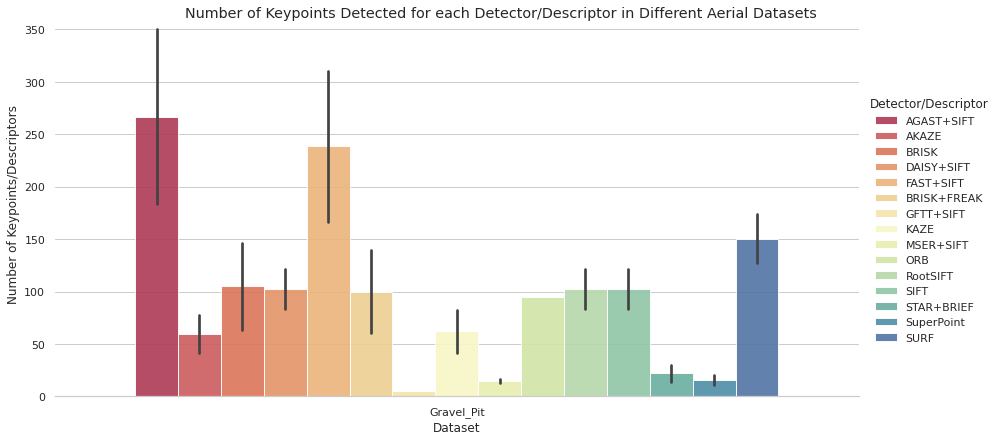

In [272]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [273]:
g.savefig(f'drive/MyDrive/Num_Kypoints_15_{Dataset}.png')

In [274]:
df_numkey_15.to_csv(f'drive/MyDrive/Num_Kypoints_15_{Dataset}.csv')

### **Total Number of Matches Detected for each Detector+Descriptor**

In [276]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf, 'Detector/Descriptor':['AGAST+SIFT']*(len_files-1) + ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['KAZE']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1) +['SIFT']*(len_files-1) + ['STAR+BRIEF']*(len_files-1) +  ['SuperPoint']*(len_files-1) + ['SURF']*(len_files-1) }
df_match_15 = pd.DataFrame(data=d)
df_match_15['Number of Total Matches'] = df_match_15['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

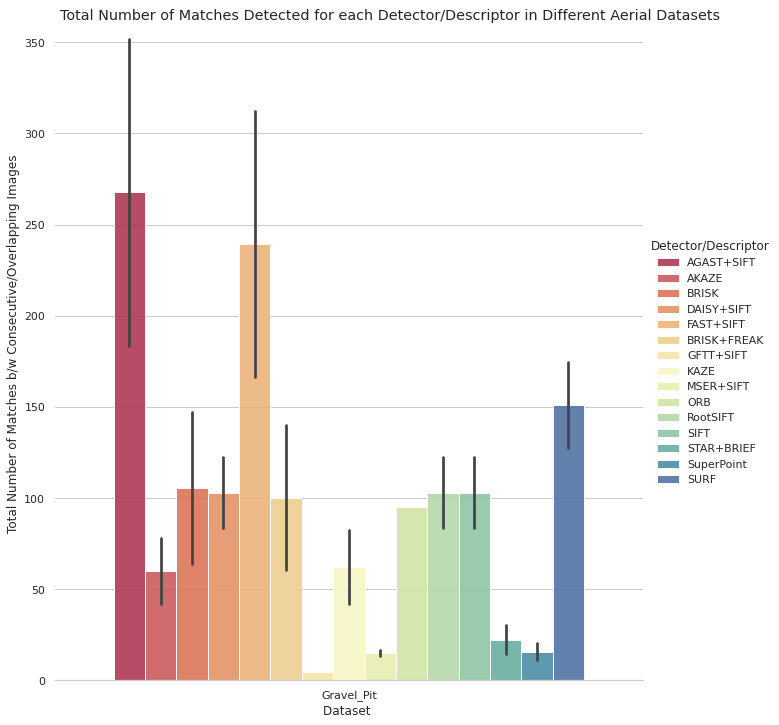

In [278]:
 import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.9
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [279]:
g.savefig(f'drive/MyDrive/Num_Matches_15_{Dataset}.png')

In [ ]:
#df_match_15.to_csv('drive/MyDrive/Num_Matches_15_{Dataset}.csv')

### **Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor**

In [280]:
df_match_15['Number of Good Matches'] = num_good_matches_agast + num_good_matches_akaze + num_good_matches_brisk + num_good_matches_daisy + num_good_matches_fast + num_good_matches_freak + num_good_matches_gftt + num_good_matches_kaze + num_good_matches_mser + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_sift + num_good_matches_briefstar + num_good_matches_superpoint+ num_good_matches_surf
df_match_15['Number of Good Matches'] = df_match_15['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

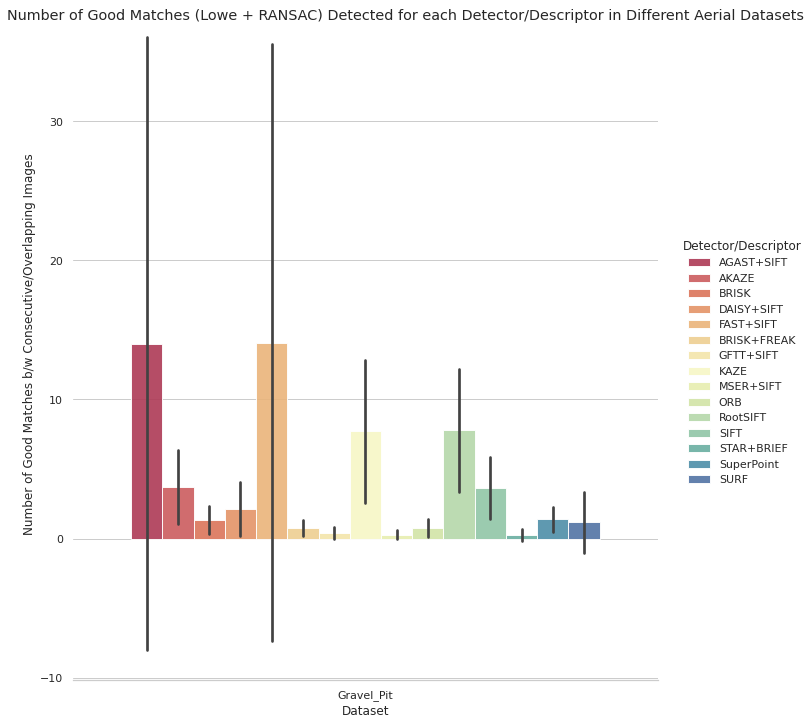

In [281]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.9
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [282]:
g.savefig(f'drive/MyDrive/Num_Good_Matches_15_{Dataset}.png')

In [ ]:
#df_match_15.to_csv('drive/MyDrive/Num_Good_Matches_15_{Dataset}.csv')

### **Recall Rate for each Detector+Descriptor**

In [283]:
df_match_15['Recall Rate of Matches'] = df_match_15['Number of Good Matches']/df_match_15['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

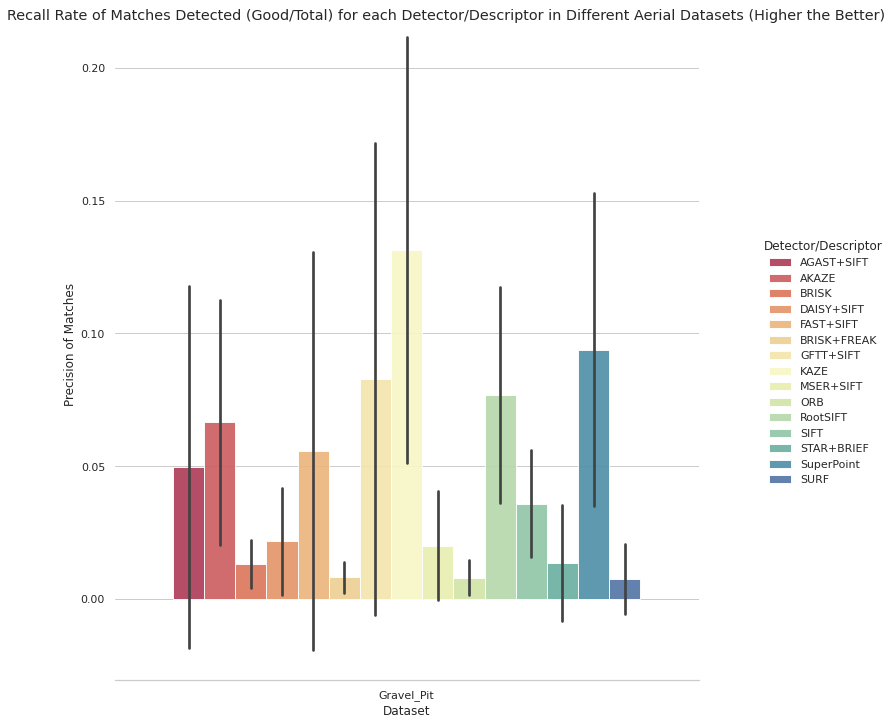

In [284]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.9
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [285]:
g.savefig(f'drive/MyDrive/Recall_Rate_Matches_15_{Dataset}.png')

### **1-Precision Rate for each Detector+Descriptor**

In [286]:
df_match_15['1 - Precision Rate of Matches'] = (df_match_15['Number of Total Matches'] - df_match_15['Number of Good Matches'])/df_match_15['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

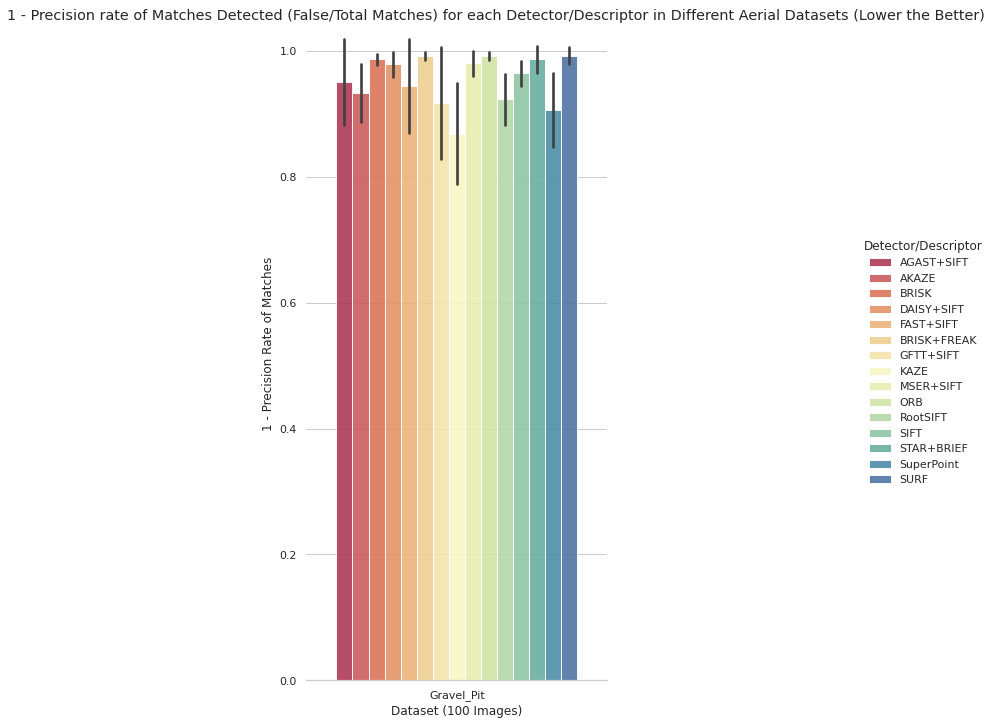

In [287]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [288]:
g.savefig(f'drive/MyDrive/One_minus_Precision_Rate_Matches_15_{Dataset}.png')

### **F-Score for each Detector+Descriptor**


In [289]:
df_match_15['F-Score'] = (2* (1 - df_match_15['1 - Precision Rate of Matches']) * df_match_15['Recall Rate of Matches'])/((1 - df_match_15['1 - Precision Rate of Matches']) + df_match_15['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

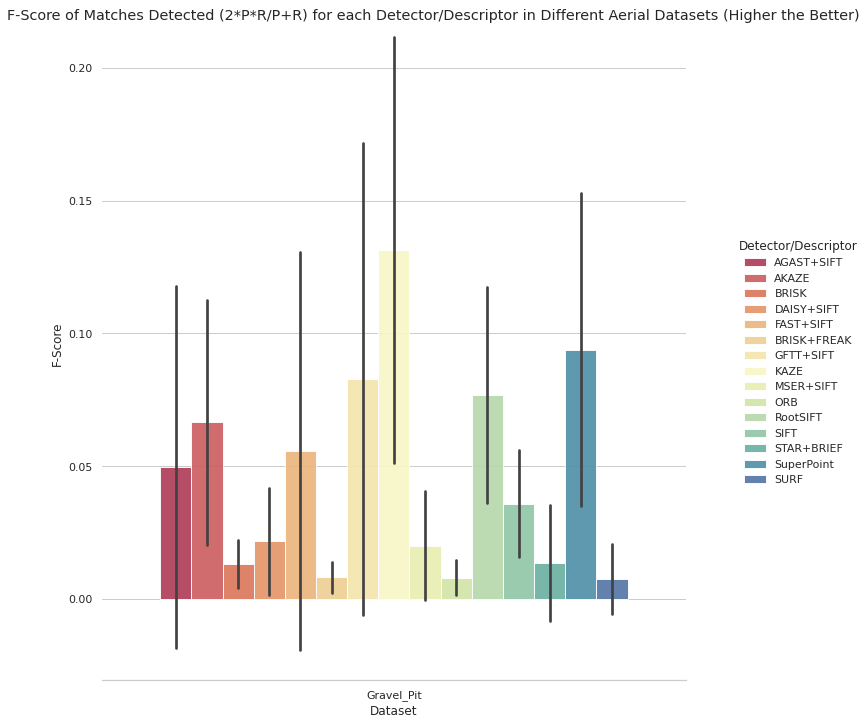

In [290]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.9
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [291]:
g.savefig(f'drive/MyDrive/F_Score_Rate_Matches_15_{Dataset}.png')

In [292]:
df_match_15.to_csv(f'drive/MyDrive/All_metrics_15_{Dataset}.csv')

### **Time for each Detector+Descriptor**

In [294]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[7]] + [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[10]] + [time_all[8]] + [time_all[9]] + [time_all[2]] + [time_all[6]] + [time_all[1]] + [time_all[13]] + [time_all[11]] + [time_all[4]] + [time_all[14]] + [time_all[12]] , 'Detector/Descriptor':['AGAST+SIFT'] + ['AKAZE'] + ['BRISK']*(1) + ['DAISY+SIFT']*(1) + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['GFTT+SIFT']*(1) + ['KAZE']*(1) + ['MSER+SIFT']*(1) + ['ORB']*(1) +['RootSIFT']*(1) +['SIFT']*(1) + ['STAR+BRIEF']*(1) +  ['SuperPoint']*(1) + ['SURF']*(1) }
df_time_15 = pd.DataFrame(data=d)

Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

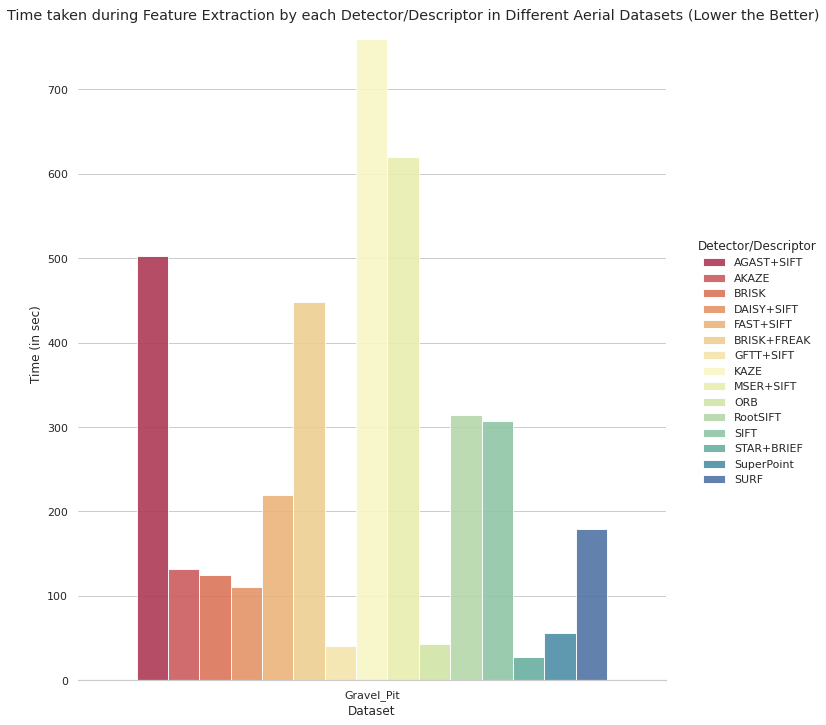

In [295]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_15, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.9
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [296]:
g.savefig(f'drive/MyDrive/Time_15_{Dataset}.png')

In [297]:
df_time_15.to_csv(f'drive/MyDrive/Time_15_{Dataset}.csv')